In [1]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from collections import defaultdict
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# If you want to use photos from google drive:
# 1. Open this link https://drive.google.com/drive/folders/1_U3udvWsm1bq6P_m8VUO9jDlGO14zPcl?usp=drive_link
# 2. Go to "Shared with me", right click on shared directory (photos) and click "Organize" -> "Add shortcut" -> "My drive"
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folders_train = {
    "/content/drive/MyDrive/photos/train_val/amsterdam/database/images":"netherlands",
    "/content/drive/MyDrive/photos/train_val/amman/database/images":"jordan",
    "/content/drive/MyDrive/photos/train_val/budapest/database/images":"hungary",
    "/content/drive/MyDrive/photos/train_val/goa/query/images":"india",
    "/content/drive/MyDrive/photos/train_val/moscow/query/images":"russia",
    "/content/drive/MyDrive/photos/train_val/paris/query/images":"france",
    "/content/drive/MyDrive/photos/train_val/zurich/query/images":"switzerland",
    "/content/drive/MyDrive/photos/train_val/nairobi/database/images":"kenya",
    "/content/drive/MyDrive/photos/train_val/ottawa/database/images":"canada",
    "/content/drive/MyDrive/photos/train_val/toronto/database/images":"canada",
    "/content/drive/MyDrive/photos/train_val/trondheim/database/images":"norway",
    "/content/drive/MyDrive/photos/train_val/boston/database/images":"usa",
    "/content/drive/MyDrive/photos/train_val/phoenix/query/images":"usa",
    "/content/drive/MyDrive/photos/train_val/saopaulo/query/images":"brazil",
    "/content/drive/MyDrive/photos/train_val/tokyo/database/images":"japan",
    "/content/drive/MyDrive/photos/test/athens/query/images":"grece",
    "/content/drive/MyDrive/photos/test/bengaluru/query/images":"india",
    "/content/drive/MyDrive/photos/test/kampala/query/images":"uganda",
    "/content/drive/MyDrive/photos/test/stockholm/query/images":"switzerland"
}

country_to_continent = {
  "netherlands": "Europe",
  "jordan": "Asia",
  "hungary": "Europe",
  "india": "Asia",
  "russia": "Europe",
  "france": "Europe",
  "switzerland": "Europe",
  "kenya": "Africa",
  "canada": "North America",
  "norway": "Europe",
  "usa": "North America",
  "brazil": "South America",
  "japan": "Asia",
  "grece": "Europe",
  "uganda": "Africa",
}

def take_images(folders):
  all_image_paths = []
  i = 0
  for folder in folders.keys():
      print("Sprawdzam folder:", folder)
      for root, _, files in os.walk(folder):
          for file in files:
              if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                  full_path = os.path.join(root, file)
                  all_image_paths.append(full_path)
  return all_image_paths

def data_stats(full_train_dataset):
    country_labels = [full_train_dataset.targets_dict[path.rsplit('/', 1)[0]] for path in full_train_dataset.images_paths]
    continent_labels = [country_to_continent[full_train_dataset.targets_dict[path.rsplit('/', 1)[0]]]for path in full_train_dataset.images_paths]

    country_counts = Counter(country_labels)
    continent_counts = Counter(continent_labels)

    print("Liczba zdjęć treningowych:", len(full_train_dataset))
    print("\n")
    for country, count in country_counts.items():
        print(f"{country}: {count} obrazów")
    print("\n")
    for continent, count in continent_counts.items():
        print(f"{continent}: {count} obrazów")

def max_count_country(full_train_dataset):

    country_labels = [full_train_dataset.targets_dict[path.rsplit('/', 1)[0]] for path in full_train_dataset.images_paths]

    country_counts = Counter(country_labels)

    max_count = max([count for country, count in country_counts.items()])
    return max_count

class ImageDataset(Dataset):
    def __init__(self, images_paths, targets_dict, country_to_continent, transform=None):
        self.images_paths = images_paths
        self.transform = transform
        self.targets_dict = targets_dict
        self.country_to_continent = country_to_continent

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = Image.open(image_path).convert("RGB")
        target = self.targets_dict[image_path.rsplit('/',1)[0]]
        general_label = self.country_to_continent[target]

        if self.transform:
            image = self.transform(image)

        return image, target, general_label

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [5]:
# Rest a little, watch some TikToks, it will take up to 10 min
# Ignore warnings about Google Drive
# There are breaks in loading

train_files = take_images(folders_train) # 483601 files

Sprawdzam folder: /content/drive/MyDrive/photos/train_val/amsterdam/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/amman/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/budapest/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/goa/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/moscow/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/paris/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/zurich/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/nairobi/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/ottawa/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/toronto/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/trondheim/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/boston/database/images
Sprawdzam folder: /content/drive/My

Liczba zdjęć treningowych: 97962


Struktura danych
Przykłady zdjęć


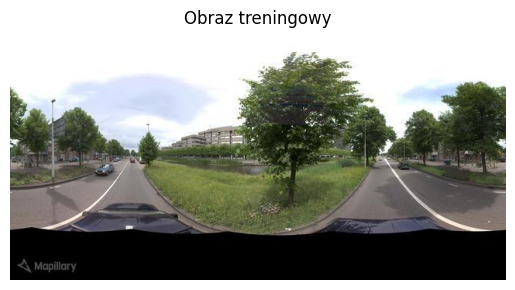

In [6]:
# <-- IMPORTANT INFO -->
# This code is used to investigate data
# You don't have to run it

print("Liczba zdjęć treningowych:", len(train_files))
print("\n")

print("Struktura danych")


print("Przykłady zdjęć")
img = cv2.imread(train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Obraz treningowy")
plt.axis('off')
plt.show()

In [7]:
# <-- IMPORTANT INFO -->
# ImageDataset object returning 3 values - image, label (Country), general_label (continent)

# Important step - normalizing images
full_train_dataset = ImageDataset(train_files, folders_train, country_to_continent, transform=transform)

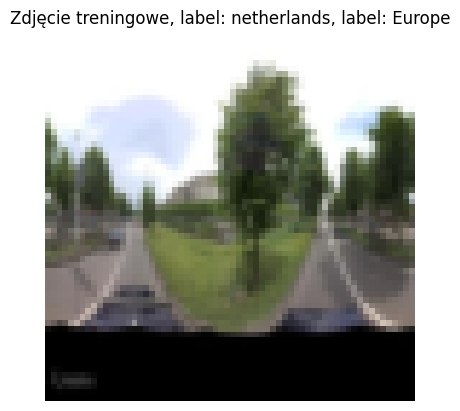

In [8]:
# <-- IMPORTANT INFO -->
# This code is used to investigate data
# You don't have to run it

image_train, label_train, general_label_train = full_train_dataset[0]
image_np_train = image_train.permute(1, 2, 0).numpy()

plt.imshow(image_np_train)
plt.title(f"Zdjęcie treningowe, label: {label_train}, label: {general_label_train}")
plt.axis('off')
plt.show()

In [9]:
data_stats(full_train_dataset)

Liczba zdjęć treningowych: 97962


netherlands: 11539 obrazów
jordan: 953 obrazów
india: 12388 obrazów
france: 8480 obrazów
switzerland: 9012 obrazów
kenya: 437 obrazów
canada: 12789 obrazów
norway: 5015 obrazów
usa: 14024 obrazów
brazil: 18989 obrazów
grece: 2466 obrazów
uganda: 1870 obrazów


Europe: 36512 obrazów
Asia: 13341 obrazów
Africa: 2307 obrazów
North America: 26813 obrazów
South America: 18989 obrazów


In [10]:
# <-- IMPORTANT INFO -->
# Jak można zobaczyć wyżej mamy problem z równomiernym rozkładem datasetu, szczególnie z danymi z Afryki
# Stworzyliśmy dataset z równomiernym rozkładem zdjęć z danych państw poprzez wyrzucenie losowych danych

#Code with augmentation

In [12]:
max_count = 500

In [ ]:
def take_images_with_augmentation(folders,max_count):
  all_image_paths = []
  i = 0
  country_to_folder = {}
  for folder in folders.keys():
      if not folders[folder] in country_to_folder.keys():
          country_to_folder[folders[folder]] = []
      country_to_folder[folders[folder]].append(folder)

  for country in country_to_folder.keys():
      folder_images = []
      for folder in country_to_folder[country]:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    full_path = os.path.join(root, file)
                    folder_images.append(full_path)
      if len(folder_images) < max_count:
          num_to_add = max_count - len(folder_images)
          additional_paths = random.choices(folder_images, k=num_to_add)
          folder_images.extend(additional_paths)
      all_image_paths.extend(folder_images)

  return all_image_paths
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

files_train_augmentation = take_images_with_augmentation(folders_train,max_count)
full_train_dataset_with_augmentation = ImageDataset(files_train_augmentation, folders_train, country_to_continent, transform=train_transform)

In [14]:
data_stats(full_train_dataset_with_augmentation )

Liczba zdjęć treningowych: 483664


netherlands: 11539 obrazów
jordan: 953 obrazów
hungary: 153321 obrazów
india: 12388 obrazów
russia: 77496 obrazów
france: 8480 obrazów
switzerland: 9012 obrazów
kenya: 500 obrazów
canada: 82545 obrazów
norway: 5015 obrazów
usa: 64267 obrazów
brazil: 18989 obrazów
japan: 34823 obrazów
grece: 2466 obrazów
uganda: 1870 obrazów


Europe: 267329 obrazów
Asia: 48164 obrazów
Africa: 2370 obrazów
North America: 146812 obrazów
South America: 18989 obrazów


In [15]:
def show_image(image_, label_, general_label_):
  image_np_train = image_.permute(1, 2, 0).numpy()
  plt.imshow(image_np_train)
  plt.title(f"Zdjęcie treningowe, label: {label_}, label: {general_label_}")
  plt.axis('off')
  plt.show()

In [ ]:
train_len = int(0.8 * len(full_train_dataset_with_augmentation))
val_len = len(full_train_dataset_with_augmentation) - train_len
train_dataset, val_dataset_paths = random_split(full_train_dataset_with_augmentation, [train_len, val_len])

val_image_paths = [files_train_augmentation[i] for i in val_dataset_paths.indices]

val_dataset = ImageDataset(
    val_image_paths,
    targets_dict=full_train_dataset_with_augmentation.targets_dict,
    country_to_continent=full_train_dataset_with_augmentation.country_to_continent,
    transform=transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)

In [17]:
print("Liczba zdjęć treningowych:", len(train_dataset))
print("Liczba zdjęć walidacyjnych:", len(val_dataset))

Liczba zdjęć treningowych: 386931
Liczba zdjęć walidacyjnych: 96733


In [ ]:
country_to_indices = defaultdict(list)

for idx, path in enumerate(full_train_dataset_with_augmentation.images_paths):
    country = full_train_dataset_with_augmentation.targets_dict[path.rsplit("/", 1)[0]]
    country_to_indices[country].append(idx)

min_count = min(len(indices) for indices in country_to_indices.values())
print(f"Minimalna liczba zdjęć w kraju: {min_count}")

balanced_indices = []

for indices in country_to_indices.values():
    balanced_indices.extend(random.sample(indices, min_count))

balanced_image_paths = [full_train_dataset_with_augmentation.images_paths[i] for i in balanced_indices]

balanced_train_dataset = ImageDataset(
    balanced_image_paths,
    targets_dict=full_train_dataset_with_augmentation.targets_dict,
    country_to_continent=full_train_dataset_with_augmentation.country_to_continent,
    transform=full_train_dataset_with_augmentation.transform
)

print(f"Liczba obrazów po undersamplingu: {len(balanced_train_dataset)}")

Minimalna liczba zdjęć w kraju: 500
Liczba obrazów po undersamplingu: 7500


In [19]:
data_stats(balanced_train_dataset)

Liczba zdjęć treningowych: 7500


netherlands: 500 obrazów
jordan: 500 obrazów
hungary: 500 obrazów
india: 500 obrazów
russia: 500 obrazów
france: 500 obrazów
switzerland: 500 obrazów
kenya: 500 obrazów
canada: 500 obrazów
norway: 500 obrazów
usa: 500 obrazów
brazil: 500 obrazów
japan: 500 obrazów
grece: 500 obrazów
uganda: 500 obrazów


Europe: 3500 obrazów
Asia: 1500 obrazów
Africa: 1000 obrazów
North America: 1000 obrazów
South America: 500 obrazów


In [ ]:
train_len = int(0.8 * len(balanced_train_dataset))
val_len = len(balanced_train_dataset) - train_len
train_dataset, val_dataset = random_split(balanced_train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

num_epochs = 10

In [21]:
print("Liczba zdjęć treningowych:", len(train_dataset))
print("Liczba zdjęć walidacyjnych:", len(val_dataset))

Liczba zdjęć treningowych: 6000
Liczba zdjęć walidacyjnych: 1500


# Ocr, do usunięcia

# Model, torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

#Model nieużywany, nastąpiły próby treningu, niestety nie było to możliwe, ponieważ trening trwał za długo.

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        weight_decay = 0.005

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(128, 128, kernel_size=3),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dropout1 = nn.Dropout(0.3)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.dropout1(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [ ]:
#Użyty model

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [31]:
device = ('cpu' if not torch.cuda.is_available() else 'cuda')

num_classes = len(country_to_continent)
# model = CNNModel(num_classes).to(device)
model = SimpleCNN(num_classes).to(device)
# model = torch.compile(model)

print(device)

cpu


In [32]:
from torch.optim import Adam

lr = 1e-4

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [33]:
num_epochs = 9

In [34]:
country_to_target = {
  "netherlands": 0,
  "jordan": 1,
  "hungary": 2,
  "india": 3,
  "russia": 4,
  "france": 5,
  "switzerland": 6,
  "kenya": 7,
  "canada": 8,
  "norway": 9,
  "usa": 10,
  "brazil": 11,
  "japan": 12,
  "grece": 13,
  "uganda": 14,
}

In [35]:
def labels_to_targets_helper(labels):
  temp = []
  for i in labels:
    temp.append(country_to_target[i])
  return torch.tensor(temp)

In [36]:
torch.cuda.empty_cache()

In [37]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [38]:
inputs, _, _ = next(iter(train_loader))
print(inputs[0].shape)

torch.Size([3, 64, 64])


In [39]:
from tqdm import tqdm

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0

  for inputs, label, label_general in tqdm(train_loader):
    label = labels_to_targets_helper(label)
    # inputs = torch.stack([inputs[0], inputs[1]], dim=0)
    inputs, label = inputs.to(device), label.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, label)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == label).sum().item()
    total += label.size(0)

    print(f"loss: {loss.item()}")

  train_loss /= total
  train_acc = correct / total

  # Validation
  model.eval()
  val_loss = 0.0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for inputs, label, label_general in tqdm(val_loader):
      label = labels_to_targets_helper(label)
      # inputs = torch.stack([inputs[0], inputs[1]], dim=0)
      inputs, label = inputs.to(device), label.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, label)

      val_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == label).sum().item()
      total_val += label.size(0)

  val_loss /= total_val
  val_acc = correct_val / total_val

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  0%|          | 1/750 [00:09<1:56:24,  9.32s/it]

loss: 2.7128818035125732


  0%|          | 2/750 [00:18<1:54:29,  9.18s/it]

loss: 2.668034791946411


  0%|          | 3/750 [00:26<1:47:22,  8.62s/it]

loss: 2.7531843185424805


  1%|          | 4/750 [00:34<1:46:12,  8.54s/it]

loss: 2.7060635089874268


  1%|          | 5/750 [00:43<1:44:44,  8.44s/it]

loss: 2.7579915523529053


  1%|          | 6/750 [00:51<1:46:12,  8.57s/it]

loss: 2.745304822921753


  1%|          | 7/750 [01:00<1:44:46,  8.46s/it]

loss: 2.6638083457946777


  1%|          | 8/750 [01:07<1:42:12,  8.27s/it]

loss: 2.7238950729370117


  1%|          | 9/750 [01:17<1:45:49,  8.57s/it]

loss: 2.710838556289673


  1%|▏         | 10/750 [01:25<1:45:22,  8.54s/it]

loss: 2.7293903827667236


  1%|▏         | 11/750 [01:33<1:41:57,  8.28s/it]

loss: 2.7211122512817383


  2%|▏         | 12/750 [01:43<1:48:05,  8.79s/it]

loss: 2.749022960662842


  2%|▏         | 13/750 [01:53<1:54:08,  9.29s/it]

loss: 2.7450790405273438


  2%|▏         | 14/750 [02:01<1:48:35,  8.85s/it]

loss: 2.691676616668701


  2%|▏         | 15/750 [02:09<1:45:18,  8.60s/it]

loss: 2.7187886238098145


  2%|▏         | 16/750 [02:18<1:45:38,  8.64s/it]

loss: 2.6931800842285156


  2%|▏         | 17/750 [02:27<1:46:56,  8.75s/it]

loss: 2.6700329780578613


  2%|▏         | 18/750 [02:37<1:51:06,  9.11s/it]

loss: 2.656118631362915


  3%|▎         | 19/750 [02:44<1:45:26,  8.65s/it]

loss: 2.746241569519043


  3%|▎         | 20/750 [02:54<1:47:29,  8.83s/it]

loss: 2.7570111751556396


  3%|▎         | 21/750 [03:01<1:42:56,  8.47s/it]

loss: 2.7166543006896973


  3%|▎         | 22/750 [03:10<1:45:06,  8.66s/it]

loss: 2.756767988204956


  3%|▎         | 23/750 [03:20<1:49:33,  9.04s/it]

loss: 2.6454100608825684


  3%|▎         | 24/750 [03:27<1:41:45,  8.41s/it]

loss: 2.7488064765930176


  3%|▎         | 25/750 [03:37<1:46:31,  8.82s/it]

loss: 2.702118158340454


  3%|▎         | 26/750 [03:46<1:46:06,  8.79s/it]

loss: 2.6543664932250977


  4%|▎         | 27/750 [03:53<1:42:03,  8.47s/it]

loss: 2.689373016357422


  4%|▎         | 28/750 [04:00<1:36:47,  8.04s/it]

loss: 2.7069292068481445


  4%|▍         | 29/750 [04:08<1:32:56,  7.73s/it]

loss: 2.744809865951538


  4%|▍         | 30/750 [04:16<1:34:40,  7.89s/it]

loss: 2.614241361618042


  4%|▍         | 31/750 [04:24<1:35:56,  8.01s/it]

loss: 2.6756935119628906


  4%|▍         | 32/750 [04:34<1:43:38,  8.66s/it]

loss: 2.6473186016082764


  4%|▍         | 33/750 [04:42<1:41:57,  8.53s/it]

loss: 2.7197277545928955


  5%|▍         | 34/750 [04:50<1:39:25,  8.33s/it]

loss: 2.6280460357666016


  5%|▍         | 35/750 [05:00<1:45:22,  8.84s/it]

loss: 2.6013152599334717


  5%|▍         | 36/750 [05:09<1:42:55,  8.65s/it]

loss: 2.6920483112335205


  5%|▍         | 37/750 [05:17<1:42:29,  8.63s/it]

loss: 2.6981279850006104


  5%|▌         | 38/750 [05:27<1:46:57,  9.01s/it]

loss: 2.5920698642730713


  5%|▌         | 39/750 [05:37<1:50:09,  9.30s/it]

loss: 2.7855963706970215


  5%|▌         | 40/750 [05:45<1:44:53,  8.86s/it]

loss: 2.7118959426879883


  5%|▌         | 41/750 [05:54<1:45:14,  8.91s/it]

loss: 2.738823413848877


  6%|▌         | 42/750 [06:02<1:42:47,  8.71s/it]

loss: 2.6211721897125244


  6%|▌         | 43/750 [06:12<1:45:25,  8.95s/it]

loss: 2.717582941055298


  6%|▌         | 44/750 [06:21<1:46:20,  9.04s/it]

loss: 2.7815134525299072


  6%|▌         | 45/750 [06:29<1:44:00,  8.85s/it]

loss: 2.7342469692230225


  6%|▌         | 46/750 [06:38<1:42:52,  8.77s/it]

loss: 2.6063544750213623


  6%|▋         | 47/750 [06:47<1:42:57,  8.79s/it]

loss: 2.715224027633667


  6%|▋         | 48/750 [06:55<1:42:17,  8.74s/it]

loss: 2.6949267387390137


  7%|▋         | 49/750 [07:04<1:43:03,  8.82s/it]

loss: 2.5353963375091553


  7%|▋         | 50/750 [07:14<1:44:10,  8.93s/it]

loss: 2.6963064670562744


  7%|▋         | 51/750 [07:23<1:45:55,  9.09s/it]

loss: 2.7131388187408447


  7%|▋         | 52/750 [07:32<1:46:00,  9.11s/it]

loss: 2.6659984588623047


  7%|▋         | 53/750 [07:42<1:47:22,  9.24s/it]

loss: 2.63619327545166


  7%|▋         | 54/750 [07:50<1:43:46,  8.95s/it]

loss: 2.6703310012817383


  7%|▋         | 55/750 [07:58<1:41:50,  8.79s/it]

loss: 2.7619705200195312


  7%|▋         | 56/750 [08:09<1:47:03,  9.26s/it]

loss: 2.6229562759399414


  8%|▊         | 57/750 [08:17<1:44:22,  9.04s/it]

loss: 2.754739999771118


  8%|▊         | 58/750 [08:27<1:47:19,  9.31s/it]

loss: 2.7244455814361572


  8%|▊         | 59/750 [08:36<1:46:14,  9.23s/it]

loss: 2.811068534851074


  8%|▊         | 60/750 [08:44<1:42:05,  8.88s/it]

loss: 2.7069339752197266


  8%|▊         | 61/750 [08:52<1:38:22,  8.57s/it]

loss: 2.608207941055298


  8%|▊         | 62/750 [09:01<1:37:44,  8.52s/it]

loss: 2.6697559356689453


  8%|▊         | 63/750 [09:10<1:42:23,  8.94s/it]

loss: 2.635451078414917


  9%|▊         | 64/750 [09:20<1:45:50,  9.26s/it]

loss: 2.672142744064331


  9%|▊         | 65/750 [09:30<1:46:05,  9.29s/it]

loss: 2.6414504051208496


  9%|▉         | 66/750 [09:38<1:42:46,  9.02s/it]

loss: 2.684835910797119


  9%|▉         | 67/750 [09:47<1:43:28,  9.09s/it]

loss: 2.7254061698913574


  9%|▉         | 68/750 [09:56<1:42:32,  9.02s/it]

loss: 2.713840961456299


  9%|▉         | 69/750 [10:06<1:45:06,  9.26s/it]

loss: 2.6116838455200195


  9%|▉         | 70/750 [10:14<1:38:43,  8.71s/it]

loss: 2.6642050743103027


  9%|▉         | 71/750 [10:21<1:35:35,  8.45s/it]

loss: 2.7329883575439453


 10%|▉         | 72/750 [10:30<1:36:53,  8.57s/it]

loss: 2.6543128490448


 10%|▉         | 73/750 [10:37<1:31:52,  8.14s/it]

loss: 2.715543270111084


 10%|▉         | 74/750 [10:47<1:36:03,  8.53s/it]

loss: 2.6412816047668457


 10%|█         | 75/750 [10:54<1:30:57,  8.08s/it]

loss: 2.6434826850891113


 10%|█         | 76/750 [11:03<1:34:05,  8.38s/it]

loss: 2.753854751586914


 10%|█         | 77/750 [11:11<1:32:42,  8.27s/it]

loss: 2.6214606761932373


 10%|█         | 78/750 [11:19<1:32:57,  8.30s/it]

loss: 2.825775623321533


 11%|█         | 79/750 [11:28<1:35:02,  8.50s/it]

loss: 2.611525058746338


 11%|█         | 80/750 [11:38<1:37:28,  8.73s/it]

loss: 2.738304853439331


 11%|█         | 81/750 [11:46<1:34:42,  8.49s/it]

loss: 2.7912795543670654


 11%|█         | 82/750 [11:54<1:34:11,  8.46s/it]

loss: 2.794248104095459


 11%|█         | 83/750 [12:02<1:32:38,  8.33s/it]

loss: 2.6603541374206543


 11%|█         | 84/750 [12:11<1:35:22,  8.59s/it]

loss: 2.846097230911255


 11%|█▏        | 85/750 [12:21<1:38:50,  8.92s/it]

loss: 2.720602512359619


 11%|█▏        | 86/750 [12:29<1:36:48,  8.75s/it]

loss: 2.7330260276794434


 12%|█▏        | 87/750 [12:39<1:40:54,  9.13s/it]

loss: 2.6633312702178955


 12%|█▏        | 88/750 [12:47<1:35:28,  8.65s/it]

loss: 2.714657783508301


 12%|█▏        | 89/750 [12:57<1:40:16,  9.10s/it]

loss: 2.6940736770629883


 12%|█▏        | 90/750 [13:05<1:37:27,  8.86s/it]

loss: 2.5496888160705566


 12%|█▏        | 91/750 [13:12<1:31:08,  8.30s/it]

loss: 2.6189751625061035


 12%|█▏        | 92/750 [13:20<1:30:35,  8.26s/it]

loss: 2.7491190433502197


 12%|█▏        | 93/750 [13:29<1:31:34,  8.36s/it]

loss: 2.6691081523895264


 13%|█▎        | 94/750 [13:37<1:31:19,  8.35s/it]

loss: 2.769412040710449


 13%|█▎        | 95/750 [13:47<1:35:41,  8.77s/it]

loss: 2.725121259689331


 13%|█▎        | 96/750 [13:55<1:34:16,  8.65s/it]

loss: 2.718689203262329


 13%|█▎        | 97/750 [14:04<1:33:52,  8.63s/it]

loss: 2.7577433586120605


 13%|█▎        | 98/750 [14:14<1:38:00,  9.02s/it]

loss: 2.659832715988159


 13%|█▎        | 99/750 [14:22<1:33:46,  8.64s/it]

loss: 2.6741867065429688


 13%|█▎        | 100/750 [14:30<1:32:33,  8.54s/it]

loss: 2.5933938026428223


 13%|█▎        | 101/750 [14:37<1:28:23,  8.17s/it]

loss: 2.788001298904419


 14%|█▎        | 102/750 [14:45<1:27:17,  8.08s/it]

loss: 2.680605888366699


 14%|█▎        | 103/750 [14:54<1:29:48,  8.33s/it]

loss: 2.74665904045105


 14%|█▍        | 104/750 [15:02<1:28:53,  8.26s/it]

loss: 2.7822253704071045


 14%|█▍        | 105/750 [15:11<1:31:49,  8.54s/it]

loss: 2.7662999629974365


 14%|█▍        | 106/750 [15:20<1:32:20,  8.60s/it]

loss: 2.6420700550079346


 14%|█▍        | 107/750 [15:28<1:31:21,  8.53s/it]

loss: 2.704308032989502


 14%|█▍        | 108/750 [15:38<1:33:44,  8.76s/it]

loss: 2.7282259464263916


 15%|█▍        | 109/750 [15:45<1:28:33,  8.29s/it]

loss: 2.700763702392578


 15%|█▍        | 110/750 [15:53<1:28:25,  8.29s/it]

loss: 2.674607515335083


 15%|█▍        | 111/750 [16:03<1:33:34,  8.79s/it]

loss: 2.677489757537842


 15%|█▍        | 112/750 [16:10<1:27:57,  8.27s/it]

loss: 2.6830735206604004


 15%|█▌        | 113/750 [16:19<1:30:13,  8.50s/it]

loss: 2.700674295425415


 15%|█▌        | 114/750 [16:28<1:31:14,  8.61s/it]

loss: 2.698423385620117


 15%|█▌        | 115/750 [16:36<1:29:42,  8.48s/it]

loss: 2.683344602584839


 15%|█▌        | 116/750 [16:45<1:30:54,  8.60s/it]

loss: 2.6952455043792725


 16%|█▌        | 117/750 [16:53<1:27:49,  8.32s/it]

loss: 2.7047088146209717


 16%|█▌        | 118/750 [17:01<1:27:27,  8.30s/it]

loss: 2.685272693634033


 16%|█▌        | 119/750 [17:10<1:28:26,  8.41s/it]

loss: 2.663501262664795


 16%|█▌        | 120/750 [17:19<1:30:18,  8.60s/it]

loss: 2.6119351387023926


 16%|█▌        | 121/750 [17:25<1:23:24,  7.96s/it]

loss: 2.7125301361083984


 16%|█▋        | 122/750 [17:34<1:27:11,  8.33s/it]

loss: 2.6450634002685547


 16%|█▋        | 123/750 [17:43<1:26:17,  8.26s/it]

loss: 2.6105926036834717


 17%|█▋        | 124/750 [17:51<1:27:31,  8.39s/it]

loss: 2.6982617378234863


 17%|█▋        | 125/750 [18:00<1:28:00,  8.45s/it]

loss: 2.696923017501831


 17%|█▋        | 126/750 [18:07<1:23:24,  8.02s/it]

loss: 2.6574738025665283


 17%|█▋        | 127/750 [18:17<1:28:21,  8.51s/it]

loss: 2.6250033378601074


 17%|█▋        | 128/750 [18:26<1:29:58,  8.68s/it]

loss: 2.7149159908294678


 17%|█▋        | 129/750 [18:34<1:27:41,  8.47s/it]

loss: 2.6766223907470703


 17%|█▋        | 130/750 [18:42<1:28:08,  8.53s/it]

loss: 2.654068946838379


 17%|█▋        | 131/750 [18:50<1:26:16,  8.36s/it]

loss: 2.5798065662384033


 18%|█▊        | 132/750 [18:59<1:28:07,  8.56s/it]

loss: 2.7314367294311523


 18%|█▊        | 133/750 [19:09<1:31:22,  8.89s/it]

loss: 2.7860257625579834


 18%|█▊        | 134/750 [19:17<1:29:31,  8.72s/it]

loss: 2.5845227241516113


 18%|█▊        | 135/750 [19:26<1:28:33,  8.64s/it]

loss: 2.63942551612854


 18%|█▊        | 136/750 [19:33<1:25:38,  8.37s/it]

loss: 2.6347413063049316


 18%|█▊        | 137/750 [19:42<1:25:06,  8.33s/it]

loss: 2.6617281436920166


 18%|█▊        | 138/750 [19:49<1:23:24,  8.18s/it]

loss: 2.634000062942505


 19%|█▊        | 139/750 [19:58<1:25:50,  8.43s/it]

loss: 2.640338659286499


 19%|█▊        | 140/750 [20:07<1:26:11,  8.48s/it]

loss: 2.541485548019409


 19%|█▉        | 141/750 [20:15<1:25:01,  8.38s/it]

loss: 2.5321216583251953


 19%|█▉        | 142/750 [20:24<1:24:54,  8.38s/it]

loss: 2.7100260257720947


 19%|█▉        | 143/750 [20:33<1:27:26,  8.64s/it]

loss: 2.6349337100982666


 19%|█▉        | 144/750 [20:40<1:22:42,  8.19s/it]

loss: 2.4991211891174316


 19%|█▉        | 145/750 [20:49<1:23:36,  8.29s/it]

loss: 2.572603225708008


 19%|█▉        | 146/750 [20:56<1:21:20,  8.08s/it]

loss: 2.747311592102051


 20%|█▉        | 147/750 [21:05<1:22:20,  8.19s/it]

loss: 2.7665796279907227


 20%|█▉        | 148/750 [21:14<1:27:01,  8.67s/it]

loss: 2.7248752117156982


 20%|█▉        | 149/750 [21:21<1:22:00,  8.19s/it]

loss: 2.71977162361145


 20%|██        | 150/750 [21:31<1:27:22,  8.74s/it]

loss: 2.7484920024871826


 20%|██        | 151/750 [21:40<1:25:41,  8.58s/it]

loss: 2.759216547012329


 20%|██        | 152/750 [21:49<1:27:21,  8.76s/it]

loss: 2.7521190643310547


 20%|██        | 153/750 [21:57<1:26:09,  8.66s/it]

loss: 2.6724002361297607


 21%|██        | 154/750 [22:07<1:28:38,  8.92s/it]

loss: 2.64615797996521


 21%|██        | 155/750 [22:15<1:26:15,  8.70s/it]

loss: 2.7703945636749268


 21%|██        | 156/750 [22:22<1:22:37,  8.35s/it]

loss: 2.7142751216888428


 21%|██        | 157/750 [22:31<1:23:34,  8.46s/it]

loss: 2.6733639240264893


 21%|██        | 158/750 [22:40<1:25:45,  8.69s/it]

loss: 2.8092217445373535


 21%|██        | 159/750 [22:49<1:24:51,  8.62s/it]

loss: 2.7727601528167725


 21%|██▏       | 160/750 [22:58<1:26:02,  8.75s/it]

loss: 2.6342782974243164


 21%|██▏       | 161/750 [23:07<1:27:18,  8.89s/it]

loss: 2.671125888824463


 22%|██▏       | 162/750 [23:14<1:22:07,  8.38s/it]

loss: 2.675300121307373


 22%|██▏       | 163/750 [23:23<1:23:31,  8.54s/it]

loss: 2.561392068862915


 22%|██▏       | 164/750 [23:30<1:18:50,  8.07s/it]

loss: 2.583402395248413


 22%|██▏       | 165/750 [23:39<1:22:11,  8.43s/it]

loss: 2.6324260234832764


 22%|██▏       | 166/750 [23:49<1:26:34,  8.89s/it]

loss: 2.600277900695801


 22%|██▏       | 167/750 [23:57<1:22:25,  8.48s/it]

loss: 2.7337682247161865


 22%|██▏       | 168/750 [24:05<1:22:11,  8.47s/it]

loss: 2.614089012145996


 23%|██▎       | 169/750 [24:14<1:22:55,  8.56s/it]

loss: 2.6741220951080322


 23%|██▎       | 170/750 [24:23<1:24:30,  8.74s/it]

loss: 2.6883199214935303


 23%|██▎       | 171/750 [24:32<1:23:16,  8.63s/it]

loss: 2.641491413116455


 23%|██▎       | 172/750 [24:41<1:24:43,  8.80s/it]

loss: 2.66599178314209


 23%|██▎       | 173/750 [24:51<1:29:05,  9.26s/it]

loss: 2.7890279293060303


 23%|██▎       | 174/750 [25:00<1:27:24,  9.11s/it]

loss: 2.5963165760040283


 23%|██▎       | 175/750 [25:07<1:20:52,  8.44s/it]

loss: 2.7393124103546143


 23%|██▎       | 176/750 [25:16<1:22:57,  8.67s/it]

loss: 2.722223997116089


 24%|██▎       | 177/750 [25:24<1:20:21,  8.42s/it]

loss: 2.601363182067871


 24%|██▎       | 178/750 [25:33<1:22:09,  8.62s/it]

loss: 2.6173696517944336


 24%|██▍       | 179/750 [25:41<1:21:10,  8.53s/it]

loss: 2.563845157623291


 24%|██▍       | 180/750 [25:51<1:23:13,  8.76s/it]

loss: 2.7246007919311523


 24%|██▍       | 181/750 [25:59<1:22:17,  8.68s/it]

loss: 2.7791495323181152


 24%|██▍       | 182/750 [26:08<1:21:26,  8.60s/it]

loss: 2.730142593383789


 24%|██▍       | 183/750 [26:15<1:16:52,  8.14s/it]

loss: 2.617499828338623


 25%|██▍       | 184/750 [26:23<1:17:24,  8.21s/it]

loss: 2.6607465744018555


 25%|██▍       | 185/750 [26:32<1:19:06,  8.40s/it]

loss: 2.705059289932251


 25%|██▍       | 186/750 [26:41<1:21:07,  8.63s/it]

loss: 2.729280471801758


 25%|██▍       | 187/750 [26:50<1:22:35,  8.80s/it]

loss: 2.661233425140381


 25%|██▌       | 188/750 [26:59<1:22:57,  8.86s/it]

loss: 2.6498992443084717


 25%|██▌       | 189/750 [27:08<1:21:38,  8.73s/it]

loss: 2.7217297554016113


 25%|██▌       | 190/750 [27:17<1:23:38,  8.96s/it]

loss: 2.690979242324829


 25%|██▌       | 191/750 [27:27<1:24:51,  9.11s/it]

loss: 2.723789691925049


 26%|██▌       | 192/750 [27:37<1:27:32,  9.41s/it]

loss: 2.7095236778259277


 26%|██▌       | 193/750 [27:45<1:25:26,  9.20s/it]

loss: 2.677236557006836


 26%|██▌       | 194/750 [27:53<1:21:50,  8.83s/it]

loss: 2.6542491912841797


 26%|██▌       | 195/750 [28:02<1:20:49,  8.74s/it]

loss: 2.6158440113067627


 26%|██▌       | 196/750 [28:09<1:17:11,  8.36s/it]

loss: 2.7844371795654297


 26%|██▋       | 197/750 [28:18<1:18:46,  8.55s/it]

loss: 2.6528611183166504


 26%|██▋       | 198/750 [28:27<1:18:14,  8.50s/it]

loss: 2.627723217010498


 27%|██▋       | 199/750 [28:34<1:13:51,  8.04s/it]

loss: 2.729501247406006


 27%|██▋       | 200/750 [28:42<1:15:04,  8.19s/it]

loss: 2.6839752197265625


 27%|██▋       | 201/750 [28:49<1:11:53,  7.86s/it]

loss: 2.5314784049987793


 27%|██▋       | 202/750 [28:59<1:17:28,  8.48s/it]

loss: 2.6581249237060547


 27%|██▋       | 203/750 [29:09<1:21:34,  8.95s/it]

loss: 2.690561056137085


 27%|██▋       | 204/750 [29:16<1:15:39,  8.31s/it]

loss: 2.510690450668335


 27%|██▋       | 205/750 [29:25<1:16:43,  8.45s/it]

loss: 2.5713462829589844


 27%|██▋       | 206/750 [29:32<1:12:51,  8.04s/it]

loss: 2.6248323917388916


 28%|██▊       | 207/750 [29:41<1:16:42,  8.48s/it]

loss: 2.573251485824585


 28%|██▊       | 208/750 [29:52<1:20:57,  8.96s/it]

loss: 2.6198580265045166


 28%|██▊       | 209/750 [30:00<1:17:57,  8.65s/it]

loss: 2.6607882976531982


 28%|██▊       | 210/750 [30:08<1:16:55,  8.55s/it]

loss: 2.639159917831421


 28%|██▊       | 211/750 [30:18<1:20:07,  8.92s/it]

loss: 2.611889123916626


 28%|██▊       | 212/750 [30:26<1:19:38,  8.88s/it]

loss: 2.6251003742218018


 28%|██▊       | 213/750 [30:36<1:20:23,  8.98s/it]

loss: 2.6317429542541504


 29%|██▊       | 214/750 [30:44<1:18:10,  8.75s/it]

loss: 2.7952260971069336


 29%|██▊       | 215/750 [30:52<1:15:18,  8.45s/it]

loss: 2.6999263763427734


 29%|██▉       | 216/750 [31:00<1:15:19,  8.46s/it]

loss: 2.6474807262420654


 29%|██▉       | 217/750 [31:08<1:14:15,  8.36s/it]

loss: 2.540656328201294


 29%|██▉       | 218/750 [31:17<1:14:06,  8.36s/it]

loss: 2.621042013168335


 29%|██▉       | 219/750 [31:24<1:12:09,  8.15s/it]

loss: 2.674860954284668


 29%|██▉       | 220/750 [31:35<1:19:03,  8.95s/it]

loss: 2.7337820529937744


 29%|██▉       | 221/750 [31:43<1:17:20,  8.77s/it]

loss: 2.7035932540893555


 30%|██▉       | 222/750 [31:51<1:14:23,  8.45s/it]

loss: 2.541520595550537


 30%|██▉       | 223/750 [32:01<1:16:49,  8.75s/it]

loss: 2.664078712463379


 30%|██▉       | 224/750 [32:09<1:16:33,  8.73s/it]

loss: 2.574275016784668


 30%|███       | 225/750 [32:17<1:12:54,  8.33s/it]

loss: 2.479379653930664


 30%|███       | 226/750 [32:25<1:12:33,  8.31s/it]

loss: 2.588458776473999


 30%|███       | 227/750 [32:32<1:09:40,  7.99s/it]

loss: 2.6233327388763428


 30%|███       | 228/750 [32:41<1:11:07,  8.18s/it]

loss: 2.59706974029541


 31%|███       | 229/750 [32:48<1:08:10,  7.85s/it]

loss: 2.578683853149414


 31%|███       | 230/750 [32:56<1:10:11,  8.10s/it]

loss: 2.5761008262634277


 31%|███       | 231/750 [33:06<1:13:16,  8.47s/it]

loss: 2.594513416290283


 31%|███       | 232/750 [33:13<1:09:12,  8.02s/it]

loss: 2.7175936698913574


 31%|███       | 233/750 [33:23<1:14:10,  8.61s/it]

loss: 2.6605489253997803


 31%|███       | 234/750 [33:31<1:12:50,  8.47s/it]

loss: 2.7294161319732666


 31%|███▏      | 235/750 [33:39<1:11:43,  8.36s/it]

loss: 2.607369899749756


 31%|███▏      | 236/750 [33:47<1:11:26,  8.34s/it]

loss: 2.6421494483947754


 32%|███▏      | 237/750 [33:56<1:12:39,  8.50s/it]

loss: 2.600029468536377


 32%|███▏      | 238/750 [34:05<1:14:10,  8.69s/it]

loss: 2.4730381965637207


 32%|███▏      | 239/750 [34:15<1:17:36,  9.11s/it]

loss: 2.4970412254333496


 32%|███▏      | 240/750 [34:25<1:18:05,  9.19s/it]

loss: 2.638620138168335


 32%|███▏      | 241/750 [34:34<1:18:55,  9.30s/it]

loss: 2.8221595287323


 32%|███▏      | 242/750 [34:43<1:16:26,  9.03s/it]

loss: 2.4741737842559814


 32%|███▏      | 243/750 [34:51<1:13:22,  8.68s/it]

loss: 2.6648402214050293


 33%|███▎      | 244/750 [35:00<1:14:48,  8.87s/it]

loss: 2.531230926513672


 33%|███▎      | 245/750 [35:07<1:10:11,  8.34s/it]

loss: 2.799424886703491


 33%|███▎      | 246/750 [35:17<1:13:58,  8.81s/it]

loss: 2.4398157596588135


 33%|███▎      | 247/750 [35:26<1:14:15,  8.86s/it]

loss: 2.6816413402557373


 33%|███▎      | 248/750 [35:33<1:09:20,  8.29s/it]

loss: 2.4934942722320557


 33%|███▎      | 249/750 [35:41<1:09:17,  8.30s/it]

loss: 2.695544958114624


 33%|███▎      | 250/750 [35:50<1:09:59,  8.40s/it]

loss: 2.5003714561462402


 33%|███▎      | 251/750 [35:59<1:10:55,  8.53s/it]

loss: 2.466243028640747


 34%|███▎      | 252/750 [36:07<1:10:27,  8.49s/it]

loss: 2.432799816131592


 34%|███▎      | 253/750 [36:15<1:09:00,  8.33s/it]

loss: 2.498569965362549


 34%|███▍      | 254/750 [36:23<1:08:49,  8.33s/it]

loss: 2.6432080268859863


 34%|███▍      | 255/750 [36:31<1:08:16,  8.28s/it]

loss: 2.507891893386841


 34%|███▍      | 256/750 [36:40<1:08:01,  8.26s/it]

loss: 2.630898952484131


 34%|███▍      | 257/750 [36:48<1:08:25,  8.33s/it]

loss: 2.551102638244629


 34%|███▍      | 258/750 [36:57<1:09:04,  8.42s/it]

loss: 2.602113962173462


 35%|███▍      | 259/750 [37:06<1:10:53,  8.66s/it]

loss: 2.6791422367095947


 35%|███▍      | 260/750 [37:16<1:14:03,  9.07s/it]

loss: 2.635423183441162


 35%|███▍      | 261/750 [37:25<1:12:43,  8.92s/it]

loss: 2.6542792320251465


 35%|███▍      | 262/750 [37:33<1:10:57,  8.72s/it]

loss: 2.5570080280303955


 35%|███▌      | 263/750 [37:41<1:09:07,  8.52s/it]

loss: 2.8799753189086914


 35%|███▌      | 264/750 [37:52<1:14:31,  9.20s/it]

loss: 2.476125717163086


 35%|███▌      | 265/750 [38:00<1:12:15,  8.94s/it]

loss: 2.625566005706787


 35%|███▌      | 266/750 [38:07<1:07:28,  8.36s/it]

loss: 2.7740612030029297


 36%|███▌      | 267/750 [38:16<1:08:48,  8.55s/it]

loss: 2.5368080139160156


 36%|███▌      | 268/750 [38:25<1:10:16,  8.75s/it]

loss: 2.561314105987549


 36%|███▌      | 269/750 [38:32<1:06:09,  8.25s/it]

loss: 2.446687936782837


 36%|███▌      | 270/750 [38:41<1:06:35,  8.32s/it]

loss: 2.6714866161346436


 36%|███▌      | 271/750 [38:49<1:06:00,  8.27s/it]

loss: 2.7093887329101562


 36%|███▋      | 272/750 [38:58<1:06:45,  8.38s/it]

loss: 2.8483469486236572


 36%|███▋      | 273/750 [39:07<1:09:03,  8.69s/it]

loss: 2.5901527404785156


 37%|███▋      | 274/750 [39:16<1:10:26,  8.88s/it]

loss: 2.75393009185791


 37%|███▋      | 275/750 [39:27<1:14:41,  9.44s/it]

loss: 2.5744946002960205


 37%|███▋      | 276/750 [39:35<1:11:35,  9.06s/it]

loss: 2.460019111633301


 37%|███▋      | 277/750 [39:42<1:06:46,  8.47s/it]

loss: 2.6671249866485596


 37%|███▋      | 278/750 [39:51<1:07:51,  8.63s/it]

loss: 2.5708649158477783


 37%|███▋      | 279/750 [40:00<1:07:03,  8.54s/it]

loss: 2.5776166915893555


 37%|███▋      | 280/750 [40:09<1:09:06,  8.82s/it]

loss: 2.7461352348327637


 37%|███▋      | 281/750 [40:19<1:11:34,  9.16s/it]

loss: 2.5049498081207275


 38%|███▊      | 282/750 [40:26<1:06:01,  8.46s/it]

loss: 2.5991175174713135


 38%|███▊      | 283/750 [40:34<1:05:12,  8.38s/it]

loss: 2.4896745681762695


 38%|███▊      | 284/750 [40:42<1:03:54,  8.23s/it]

loss: 2.5281572341918945


 38%|███▊      | 285/750 [40:52<1:06:34,  8.59s/it]

loss: 2.60904598236084


 38%|███▊      | 286/750 [41:01<1:07:43,  8.76s/it]

loss: 2.5895137786865234


 38%|███▊      | 287/750 [41:08<1:03:16,  8.20s/it]

loss: 2.7574265003204346


 38%|███▊      | 288/750 [41:16<1:03:18,  8.22s/it]

loss: 2.6036500930786133


 39%|███▊      | 289/750 [41:23<1:01:19,  7.98s/it]

loss: 2.4899322986602783


 39%|███▊      | 290/750 [41:31<1:00:44,  7.92s/it]

loss: 2.641326904296875


 39%|███▉      | 291/750 [41:40<1:02:10,  8.13s/it]

loss: 2.5912139415740967


 39%|███▉      | 292/750 [41:48<1:02:04,  8.13s/it]

loss: 2.6213746070861816


 39%|███▉      | 293/750 [41:57<1:03:30,  8.34s/it]

loss: 2.719803810119629


 39%|███▉      | 294/750 [42:04<1:00:59,  8.02s/it]

loss: 2.460165023803711


 39%|███▉      | 295/750 [42:13<1:03:11,  8.33s/it]

loss: 2.5069026947021484


 39%|███▉      | 296/750 [42:21<1:03:01,  8.33s/it]

loss: 2.614614248275757


 40%|███▉      | 297/750 [42:29<1:01:36,  8.16s/it]

loss: 2.395705223083496


 40%|███▉      | 298/750 [42:38<1:03:57,  8.49s/it]

loss: 2.6249654293060303


 40%|███▉      | 299/750 [42:46<1:01:09,  8.14s/it]

loss: 2.561492681503296


 40%|████      | 300/750 [42:53<59:02,  7.87s/it]  

loss: 2.7016191482543945


 40%|████      | 301/750 [43:00<57:08,  7.64s/it]

loss: 2.329115867614746


 40%|████      | 302/750 [43:11<1:04:12,  8.60s/it]

loss: 2.7046267986297607


 40%|████      | 303/750 [43:19<1:03:17,  8.50s/it]

loss: 2.5585105419158936


 41%|████      | 304/750 [43:27<1:01:25,  8.26s/it]

loss: 2.6395366191864014


 41%|████      | 305/750 [43:37<1:04:57,  8.76s/it]

loss: 2.431898593902588


 41%|████      | 306/750 [43:45<1:03:52,  8.63s/it]

loss: 2.5347726345062256


 41%|████      | 307/750 [43:53<1:02:35,  8.48s/it]

loss: 2.5487287044525146


 41%|████      | 308/750 [44:01<1:02:12,  8.44s/it]

loss: 2.3305540084838867


 41%|████      | 309/750 [44:09<59:36,  8.11s/it]  

loss: 2.5987963676452637


 41%|████▏     | 310/750 [44:18<1:00:53,  8.30s/it]

loss: 2.744736909866333


 41%|████▏     | 311/750 [44:27<1:02:33,  8.55s/it]

loss: 2.4714407920837402


 42%|████▏     | 312/750 [44:33<57:22,  7.86s/it]  

loss: 2.7062978744506836


 42%|████▏     | 313/750 [44:42<58:47,  8.07s/it]

loss: 2.606283664703369


 42%|████▏     | 314/750 [44:50<58:47,  8.09s/it]

loss: 2.306880474090576


 42%|████▏     | 315/750 [44:59<1:00:35,  8.36s/it]

loss: 2.548280715942383


 42%|████▏     | 316/750 [45:05<56:03,  7.75s/it]  

loss: 2.432420492172241


 42%|████▏     | 317/750 [45:13<56:57,  7.89s/it]

loss: 2.6731441020965576


 42%|████▏     | 318/750 [45:22<57:45,  8.02s/it]

loss: 2.626500129699707


 43%|████▎     | 319/750 [45:29<56:19,  7.84s/it]

loss: 2.7181570529937744


 43%|████▎     | 320/750 [45:38<59:25,  8.29s/it]

loss: 2.4658186435699463


 43%|████▎     | 321/750 [45:47<1:00:37,  8.48s/it]

loss: 2.4809207916259766


 43%|████▎     | 322/750 [45:56<1:00:45,  8.52s/it]

loss: 2.660186290740967


 43%|████▎     | 323/750 [46:05<1:02:14,  8.75s/it]

loss: 2.3711233139038086


 43%|████▎     | 324/750 [46:14<1:02:05,  8.75s/it]

loss: 2.459984302520752


 43%|████▎     | 325/750 [46:24<1:04:16,  9.07s/it]

loss: 2.6483314037323


 43%|████▎     | 326/750 [46:32<1:03:13,  8.95s/it]

loss: 2.7149107456207275


 44%|████▎     | 327/750 [46:41<1:02:15,  8.83s/it]

loss: 2.6533663272857666


 44%|████▎     | 328/750 [46:49<1:00:46,  8.64s/it]

loss: 2.18774151802063


 44%|████▍     | 329/750 [46:58<1:01:13,  8.73s/it]

loss: 2.146890640258789


 44%|████▍     | 330/750 [47:07<1:01:41,  8.81s/it]

loss: 2.5249905586242676


 44%|████▍     | 331/750 [47:16<1:02:17,  8.92s/it]

loss: 2.4480884075164795


 44%|████▍     | 332/750 [47:23<57:32,  8.26s/it]  

loss: 2.522578239440918


 44%|████▍     | 333/750 [47:31<56:53,  8.19s/it]

loss: 2.6645331382751465


 45%|████▍     | 334/750 [47:41<1:00:12,  8.68s/it]

loss: 2.5154166221618652


 45%|████▍     | 335/750 [47:50<1:00:36,  8.76s/it]

loss: 2.4248411655426025


 45%|████▍     | 336/750 [47:59<1:00:48,  8.81s/it]

loss: 2.8119730949401855


 45%|████▍     | 337/750 [48:07<59:53,  8.70s/it]  

loss: 2.7381839752197266


 45%|████▌     | 338/750 [48:15<57:38,  8.39s/it]

loss: 2.2897212505340576


 45%|████▌     | 339/750 [48:24<58:30,  8.54s/it]

loss: 2.7330760955810547


 45%|████▌     | 340/750 [48:32<57:02,  8.35s/it]

loss: 2.582230567932129


 45%|████▌     | 341/750 [48:41<58:16,  8.55s/it]

loss: 2.7402002811431885


 46%|████▌     | 342/750 [48:49<58:14,  8.56s/it]

loss: 2.645416021347046


 46%|████▌     | 343/750 [48:57<55:59,  8.25s/it]

loss: 2.6018471717834473


 46%|████▌     | 344/750 [49:06<57:25,  8.49s/it]

loss: 2.5536787509918213


 46%|████▌     | 345/750 [49:14<56:24,  8.36s/it]

loss: 2.404799461364746


 46%|████▌     | 346/750 [49:22<56:21,  8.37s/it]

loss: 2.4033002853393555


 46%|████▋     | 347/750 [49:30<55:41,  8.29s/it]

loss: 2.6307101249694824


 46%|████▋     | 348/750 [49:38<55:17,  8.25s/it]

loss: 2.4352991580963135


 47%|████▋     | 349/750 [49:47<56:14,  8.42s/it]

loss: 2.5425803661346436


 47%|████▋     | 350/750 [49:55<55:39,  8.35s/it]

loss: 2.5157833099365234


 47%|████▋     | 351/750 [50:05<57:15,  8.61s/it]

loss: 2.673539638519287


 47%|████▋     | 352/750 [50:15<1:00:21,  9.10s/it]

loss: 2.372159004211426


 47%|████▋     | 353/750 [50:22<57:03,  8.62s/it]  

loss: 2.8153481483459473


 47%|████▋     | 354/750 [50:33<59:54,  9.08s/it]

loss: 2.418503761291504


 47%|████▋     | 355/750 [50:41<59:24,  9.02s/it]

loss: 2.5888423919677734


 47%|████▋     | 356/750 [50:48<54:32,  8.31s/it]

loss: 2.632538318634033


 48%|████▊     | 357/750 [50:57<56:21,  8.60s/it]

loss: 2.415590524673462


 48%|████▊     | 358/750 [51:04<53:19,  8.16s/it]

loss: 2.828775644302368


 48%|████▊     | 359/750 [51:13<54:39,  8.39s/it]

loss: 2.6499948501586914


 48%|████▊     | 360/750 [51:22<55:53,  8.60s/it]

loss: 2.4581377506256104


 48%|████▊     | 361/750 [51:32<57:24,  8.86s/it]

loss: 2.626253128051758


 48%|████▊     | 362/750 [51:39<54:39,  8.45s/it]

loss: 2.7197060585021973


 48%|████▊     | 363/750 [51:47<53:23,  8.28s/it]

loss: 2.4948480129241943


 49%|████▊     | 364/750 [51:57<55:03,  8.56s/it]

loss: 2.241804599761963


 49%|████▊     | 365/750 [52:06<57:33,  8.97s/it]

loss: 2.1808090209960938


 49%|████▉     | 366/750 [52:14<53:47,  8.40s/it]

loss: 2.456923246383667


 49%|████▉     | 367/750 [52:23<55:06,  8.63s/it]

loss: 2.5942866802215576


 49%|████▉     | 368/750 [52:30<51:44,  8.13s/it]

loss: 2.457146406173706


 49%|████▉     | 369/750 [52:38<51:55,  8.18s/it]

loss: 2.6709280014038086


 49%|████▉     | 370/750 [52:47<53:36,  8.46s/it]

loss: 2.4672937393188477


 49%|████▉     | 371/750 [52:55<52:14,  8.27s/it]

loss: 2.392608165740967


 50%|████▉     | 372/750 [53:03<52:10,  8.28s/it]

loss: 2.718512773513794


 50%|████▉     | 373/750 [53:12<52:38,  8.38s/it]

loss: 2.4414174556732178


 50%|████▉     | 374/750 [53:22<55:30,  8.86s/it]

loss: 2.4060325622558594


 50%|█████     | 375/750 [53:31<55:59,  8.96s/it]

loss: 2.5042123794555664


 50%|█████     | 376/750 [53:39<53:27,  8.57s/it]

loss: 2.1853535175323486


 50%|█████     | 377/750 [53:48<54:30,  8.77s/it]

loss: 2.42751407623291


 50%|█████     | 378/750 [53:56<53:01,  8.55s/it]

loss: 2.539599895477295


 51%|█████     | 379/750 [54:16<1:14:09, 11.99s/it]

loss: 2.614945888519287


 51%|█████     | 380/750 [54:33<1:23:38, 13.56s/it]

loss: 3.0764541625976562


 51%|█████     | 381/750 [54:41<1:12:26, 11.78s/it]

loss: 2.216953754425049


 51%|█████     | 382/750 [54:48<1:03:27, 10.35s/it]

loss: 2.3770339488983154


 51%|█████     | 383/750 [54:55<58:08,  9.51s/it]  

loss: 2.6593637466430664


 51%|█████     | 384/750 [55:02<53:20,  8.75s/it]

loss: 2.4407479763031006


 51%|█████▏    | 385/750 [55:11<52:39,  8.66s/it]

loss: 2.8545761108398438


 51%|█████▏    | 386/750 [55:22<57:28,  9.47s/it]

loss: 2.742359161376953


 52%|█████▏    | 387/750 [55:29<53:01,  8.76s/it]

loss: 2.7611236572265625


 52%|█████▏    | 388/750 [55:37<51:46,  8.58s/it]

loss: 2.586578607559204


 52%|█████▏    | 389/750 [55:47<52:58,  8.80s/it]

loss: 2.279538631439209


 52%|█████▏    | 390/750 [55:55<51:52,  8.65s/it]

loss: 2.4557082653045654


 52%|█████▏    | 391/750 [56:03<50:41,  8.47s/it]

loss: 2.4293103218078613


 52%|█████▏    | 392/750 [56:12<51:23,  8.61s/it]

loss: 2.4714748859405518


 52%|█████▏    | 393/750 [56:20<50:41,  8.52s/it]

loss: 3.032371997833252


 53%|█████▎    | 394/750 [56:29<50:46,  8.56s/it]

loss: 2.7669830322265625


 53%|█████▎    | 395/750 [56:37<48:55,  8.27s/it]

loss: 2.4223947525024414


 53%|█████▎    | 396/750 [56:45<49:47,  8.44s/it]

loss: 2.3590404987335205


 53%|█████▎    | 397/750 [56:53<47:17,  8.04s/it]

loss: 2.737081527709961


 53%|█████▎    | 398/750 [57:01<47:34,  8.11s/it]

loss: 2.6291990280151367


 53%|█████▎    | 399/750 [57:09<46:53,  8.02s/it]

loss: 2.7808713912963867


 53%|█████▎    | 400/750 [57:18<49:57,  8.57s/it]

loss: 2.4808218479156494


 53%|█████▎    | 401/750 [57:27<50:14,  8.64s/it]

loss: 2.6123478412628174


 54%|█████▎    | 402/750 [57:34<47:14,  8.15s/it]

loss: 2.724287271499634


 54%|█████▎    | 403/750 [57:43<49:00,  8.47s/it]

loss: 2.520014524459839


 54%|█████▍    | 404/750 [57:51<47:00,  8.15s/it]

loss: 2.5995163917541504


 54%|█████▍    | 405/750 [58:00<49:02,  8.53s/it]

loss: 2.6821093559265137


 54%|█████▍    | 406/750 [58:10<50:04,  8.73s/it]

loss: 2.525200128555298


 54%|█████▍    | 407/750 [58:18<48:51,  8.55s/it]

loss: 2.7471120357513428


 54%|█████▍    | 408/750 [58:28<52:11,  9.16s/it]

loss: 1.9864025115966797


 55%|█████▍    | 409/750 [58:38<52:32,  9.25s/it]

loss: 2.507345676422119


 55%|█████▍    | 410/750 [58:45<48:45,  8.60s/it]

loss: 2.5525217056274414


 55%|█████▍    | 411/750 [58:54<49:32,  8.77s/it]

loss: 2.6279261112213135


 55%|█████▍    | 412/750 [59:05<52:57,  9.40s/it]

loss: 2.630283832550049


 55%|█████▌    | 413/750 [59:12<49:56,  8.89s/it]

loss: 2.4389030933380127


 55%|█████▌    | 414/750 [59:20<48:17,  8.62s/it]

loss: 2.3476290702819824


 55%|█████▌    | 415/750 [59:28<45:52,  8.22s/it]

loss: 2.2986159324645996


 55%|█████▌    | 416/750 [59:38<48:27,  8.70s/it]

loss: 2.257331371307373


 56%|█████▌    | 417/750 [59:46<47:18,  8.52s/it]

loss: 2.3765547275543213


 56%|█████▌    | 418/750 [59:54<46:38,  8.43s/it]

loss: 2.6800754070281982


 56%|█████▌    | 419/750 [1:00:04<49:08,  8.91s/it]

loss: 2.6946234703063965


 56%|█████▌    | 420/750 [1:00:12<48:08,  8.75s/it]

loss: 2.343721628189087


 56%|█████▌    | 421/750 [1:00:22<49:04,  8.95s/it]

loss: 2.626171827316284


 56%|█████▋    | 422/750 [1:00:30<48:08,  8.81s/it]

loss: 1.9211890697479248


 56%|█████▋    | 423/750 [1:00:39<48:13,  8.85s/it]

loss: 2.2975432872772217


 57%|█████▋    | 424/750 [1:00:45<43:59,  8.10s/it]

loss: 2.431870222091675


 57%|█████▋    | 425/750 [1:00:51<39:56,  7.37s/it]

loss: 2.9156408309936523


 57%|█████▋    | 426/750 [1:00:58<38:22,  7.11s/it]

loss: 2.6391348838806152


 57%|█████▋    | 427/750 [1:01:04<36:22,  6.76s/it]

loss: 2.2528772354125977


 57%|█████▋    | 428/750 [1:01:09<34:45,  6.48s/it]

loss: 2.1256771087646484


 57%|█████▋    | 429/750 [1:01:15<33:15,  6.22s/it]

loss: 2.482358694076538


 57%|█████▋    | 430/750 [1:01:21<32:35,  6.11s/it]

loss: 2.4716169834136963


 57%|█████▋    | 431/750 [1:01:27<32:19,  6.08s/it]

loss: 2.4237656593322754


 58%|█████▊    | 432/750 [1:01:35<35:27,  6.69s/it]

loss: 2.509661912918091


 58%|█████▊    | 433/750 [1:01:42<35:53,  6.79s/it]

loss: 2.394082546234131


 58%|█████▊    | 434/750 [1:01:50<36:51,  7.00s/it]

loss: 2.4086501598358154


 58%|█████▊    | 435/750 [1:01:57<36:56,  7.04s/it]

loss: 2.3002209663391113


 58%|█████▊    | 436/750 [1:02:04<37:47,  7.22s/it]

loss: 2.3665828704833984


 58%|█████▊    | 437/750 [1:02:11<37:32,  7.20s/it]

loss: 2.869474411010742


 58%|█████▊    | 438/750 [1:02:20<39:20,  7.57s/it]

loss: 2.4883949756622314


 59%|█████▊    | 439/750 [1:02:28<39:43,  7.66s/it]

loss: 2.664868116378784


 59%|█████▊    | 440/750 [1:02:36<39:51,  7.71s/it]

loss: 2.296081781387329


 59%|█████▉    | 441/750 [1:02:44<41:00,  7.96s/it]

loss: 2.792958974838257


 59%|█████▉    | 442/750 [1:02:51<39:41,  7.73s/it]

loss: 2.5558061599731445


 59%|█████▉    | 443/750 [1:02:59<39:23,  7.70s/it]

loss: 2.0689890384674072


 59%|█████▉    | 444/750 [1:03:06<38:25,  7.53s/it]

loss: 2.5233139991760254


 59%|█████▉    | 445/750 [1:03:15<39:38,  7.80s/it]

loss: 2.473055601119995


 59%|█████▉    | 446/750 [1:03:22<38:46,  7.65s/it]

loss: 2.563929796218872


 60%|█████▉    | 447/750 [1:03:29<38:04,  7.54s/it]

loss: 2.550577163696289


 60%|█████▉    | 448/750 [1:03:37<38:05,  7.57s/it]

loss: 2.4782214164733887


 60%|█████▉    | 449/750 [1:03:45<38:36,  7.70s/it]

loss: 2.5243406295776367


 60%|██████    | 450/750 [1:03:53<39:41,  7.94s/it]

loss: 2.6456990242004395


 60%|██████    | 451/750 [1:04:00<37:13,  7.47s/it]

loss: 2.2440383434295654


 60%|██████    | 452/750 [1:04:08<38:22,  7.72s/it]

loss: 2.33349347114563


 60%|██████    | 453/750 [1:04:15<37:17,  7.53s/it]

loss: 2.429577589035034


 61%|██████    | 454/750 [1:04:36<56:49, 11.52s/it]

loss: 2.557408332824707


 61%|██████    | 455/750 [1:04:43<50:17, 10.23s/it]

loss: 2.4704933166503906


 61%|██████    | 456/750 [1:04:52<47:31,  9.70s/it]

loss: 2.3305821418762207


 61%|██████    | 457/750 [1:04:59<44:04,  9.02s/it]

loss: 2.5434927940368652


 61%|██████    | 458/750 [1:05:07<42:40,  8.77s/it]

loss: 2.246208667755127


 61%|██████    | 459/750 [1:05:25<55:34, 11.46s/it]

loss: 2.323312759399414


 61%|██████▏   | 460/750 [1:05:33<51:05, 10.57s/it]

loss: 2.508880138397217


 61%|██████▏   | 461/750 [1:05:41<46:26,  9.64s/it]

loss: 2.519770860671997


 62%|██████▏   | 462/750 [1:05:49<44:03,  9.18s/it]

loss: 2.64005184173584


 62%|██████▏   | 463/750 [1:05:57<42:39,  8.92s/it]

loss: 2.298151969909668


 62%|██████▏   | 464/750 [1:06:06<42:17,  8.87s/it]

loss: 2.334394693374634


 62%|██████▏   | 465/750 [1:06:14<40:41,  8.57s/it]

loss: 2.498385190963745


 62%|██████▏   | 466/750 [1:06:22<39:53,  8.43s/it]

loss: 2.457834482192993


 62%|██████▏   | 467/750 [1:06:31<40:05,  8.50s/it]

loss: 2.332388162612915


 62%|██████▏   | 468/750 [1:06:38<38:34,  8.21s/it]

loss: 2.700133800506592


 63%|██████▎   | 469/750 [1:06:47<39:53,  8.52s/it]

loss: 2.374450445175171


 63%|██████▎   | 470/750 [1:06:56<39:44,  8.52s/it]

loss: 2.8009207248687744


 63%|██████▎   | 471/750 [1:07:03<38:06,  8.19s/it]

loss: 2.4698095321655273


 63%|██████▎   | 472/750 [1:07:12<38:52,  8.39s/it]

loss: 2.428743839263916


 63%|██████▎   | 473/750 [1:07:20<37:12,  8.06s/it]

loss: 2.4137837886810303


 63%|██████▎   | 474/750 [1:07:28<37:41,  8.19s/it]

loss: 2.377842664718628


 63%|██████▎   | 475/750 [1:07:36<36:53,  8.05s/it]

loss: 2.31394624710083


 63%|██████▎   | 476/750 [1:07:45<38:04,  8.34s/it]

loss: 2.4539475440979004


 64%|██████▎   | 477/750 [1:07:53<38:00,  8.35s/it]

loss: 2.711153030395508


 64%|██████▎   | 478/750 [1:08:01<36:54,  8.14s/it]

loss: 2.3329896926879883


 64%|██████▍   | 479/750 [1:08:09<37:25,  8.29s/it]

loss: 2.5025947093963623


 64%|██████▍   | 480/750 [1:08:17<35:46,  7.95s/it]

loss: 2.510390520095825


 64%|██████▍   | 481/750 [1:08:25<36:12,  8.08s/it]

loss: 2.470958709716797


 64%|██████▍   | 482/750 [1:08:33<35:41,  7.99s/it]

loss: 2.4119608402252197


 64%|██████▍   | 483/750 [1:08:41<35:55,  8.07s/it]

loss: 2.5567119121551514


 65%|██████▍   | 484/750 [1:08:50<36:32,  8.24s/it]

loss: 2.5112485885620117


 65%|██████▍   | 485/750 [1:08:57<35:02,  7.93s/it]

loss: 2.108790636062622


 65%|██████▍   | 486/750 [1:09:05<35:28,  8.06s/it]

loss: 2.4252068996429443


 65%|██████▍   | 487/750 [1:09:12<34:07,  7.79s/it]

loss: 2.455806255340576


 65%|██████▌   | 488/750 [1:09:21<34:55,  8.00s/it]

loss: 2.577730417251587


 65%|██████▌   | 489/750 [1:09:28<34:11,  7.86s/it]

loss: 2.0473990440368652


 65%|██████▌   | 490/750 [1:09:37<34:32,  7.97s/it]

loss: 2.8252134323120117


 65%|██████▌   | 491/750 [1:09:44<33:40,  7.80s/it]

loss: 2.7191851139068604


 66%|██████▌   | 492/750 [1:09:52<33:23,  7.77s/it]

loss: 2.852963447570801


 66%|██████▌   | 493/750 [1:10:00<34:28,  8.05s/it]

loss: 2.374882221221924


 66%|██████▌   | 494/750 [1:10:08<33:24,  7.83s/it]

loss: 2.4476478099823


 66%|██████▌   | 495/750 [1:10:16<34:17,  8.07s/it]

loss: 2.359435796737671


 66%|██████▌   | 496/750 [1:10:24<33:11,  7.84s/it]

loss: 2.3923773765563965


 66%|██████▋   | 497/750 [1:10:32<33:53,  8.04s/it]

loss: 2.7220780849456787


 66%|██████▋   | 498/750 [1:10:41<34:17,  8.16s/it]

loss: 2.568347454071045


 67%|██████▋   | 499/750 [1:10:48<32:54,  7.87s/it]

loss: 2.4332938194274902


 67%|██████▋   | 500/750 [1:10:55<32:19,  7.76s/it]

loss: 2.4017179012298584


 67%|██████▋   | 501/750 [1:11:03<31:39,  7.63s/it]

loss: 1.8662941455841064


 67%|██████▋   | 502/750 [1:11:10<31:24,  7.60s/it]

loss: 2.571855306625366


 67%|██████▋   | 503/750 [1:11:17<30:47,  7.48s/it]

loss: 2.279067039489746


 67%|██████▋   | 504/750 [1:11:26<31:49,  7.76s/it]

loss: 2.445415496826172


 67%|██████▋   | 505/750 [1:11:33<31:09,  7.63s/it]

loss: 2.5435054302215576


 67%|██████▋   | 506/750 [1:11:41<31:46,  7.81s/it]

loss: 2.123858690261841


 68%|██████▊   | 507/750 [1:11:49<31:51,  7.87s/it]

loss: 2.582198143005371


 68%|██████▊   | 508/750 [1:11:57<31:10,  7.73s/it]

loss: 2.346022129058838


 68%|██████▊   | 509/750 [1:12:05<31:54,  7.94s/it]

loss: 2.6108388900756836


 68%|██████▊   | 510/750 [1:12:12<30:46,  7.69s/it]

loss: 2.5843868255615234


 68%|██████▊   | 511/750 [1:12:21<31:25,  7.89s/it]

loss: 2.2971270084381104


 68%|██████▊   | 512/750 [1:12:28<30:15,  7.63s/it]

loss: 2.09626841545105


 68%|██████▊   | 513/750 [1:12:36<31:11,  7.90s/it]

loss: 2.483527421951294


 69%|██████▊   | 514/750 [1:12:44<31:19,  7.96s/it]

loss: 2.4591803550720215


 69%|██████▊   | 515/750 [1:12:52<30:52,  7.88s/it]

loss: 2.0799012184143066


 69%|██████▉   | 516/750 [1:13:00<31:20,  8.04s/it]

loss: 2.7801852226257324


 69%|██████▉   | 517/750 [1:13:07<30:07,  7.76s/it]

loss: 2.4403610229492188


 69%|██████▉   | 518/750 [1:13:15<29:57,  7.75s/it]

loss: 2.2818639278411865


 69%|██████▉   | 519/750 [1:13:22<28:54,  7.51s/it]

loss: 2.714080333709717


 69%|██████▉   | 520/750 [1:13:30<29:43,  7.75s/it]

loss: 2.474329948425293


 69%|██████▉   | 521/750 [1:13:38<29:05,  7.62s/it]

loss: 2.5833232402801514


 70%|██████▉   | 522/750 [1:13:46<30:01,  7.90s/it]

loss: 2.2460310459136963


 70%|██████▉   | 523/750 [1:13:55<30:19,  8.02s/it]

loss: 2.2452635765075684


 70%|██████▉   | 524/750 [1:14:02<29:41,  7.88s/it]

loss: 2.125485420227051


 70%|███████   | 525/750 [1:14:11<30:32,  8.14s/it]

loss: 2.6693382263183594


 70%|███████   | 526/750 [1:14:18<29:39,  7.94s/it]

loss: 2.6921896934509277


 70%|███████   | 527/750 [1:14:27<30:20,  8.16s/it]

loss: 2.550544023513794


 70%|███████   | 528/750 [1:14:35<29:55,  8.09s/it]

loss: 2.484736442565918


 71%|███████   | 529/750 [1:14:43<29:46,  8.09s/it]

loss: 2.7471423149108887


 71%|███████   | 530/750 [1:14:52<30:11,  8.24s/it]

loss: 2.2828805446624756


 71%|███████   | 531/750 [1:14:59<29:07,  7.98s/it]

loss: 2.5153188705444336


 71%|███████   | 532/750 [1:15:07<28:38,  7.88s/it]

loss: 2.425860643386841


 71%|███████   | 533/750 [1:15:12<25:52,  7.15s/it]

loss: 2.432077646255493


 71%|███████   | 534/750 [1:15:21<27:11,  7.55s/it]

loss: 2.7507505416870117


 71%|███████▏  | 535/750 [1:15:28<26:30,  7.40s/it]

loss: 2.4576921463012695


 71%|███████▏  | 536/750 [1:15:36<27:26,  7.70s/it]

loss: 2.385014533996582


 72%|███████▏  | 537/750 [1:15:42<25:48,  7.27s/it]

loss: 2.3893346786499023


 72%|███████▏  | 538/750 [1:15:51<26:48,  7.59s/it]

loss: 2.386237144470215


 72%|███████▏  | 539/750 [1:15:58<26:30,  7.54s/it]

loss: 2.713184118270874


 72%|███████▏  | 540/750 [1:16:06<26:47,  7.66s/it]

loss: 2.3331751823425293


 72%|███████▏  | 541/750 [1:16:14<27:26,  7.88s/it]

loss: 2.3320653438568115


 72%|███████▏  | 542/750 [1:16:22<26:41,  7.70s/it]

loss: 2.5181734561920166


 72%|███████▏  | 543/750 [1:16:30<27:26,  7.95s/it]

loss: 2.7219297885894775


 73%|███████▎  | 544/750 [1:16:37<26:25,  7.70s/it]

loss: 2.226818323135376


 73%|███████▎  | 545/750 [1:16:46<26:56,  7.88s/it]

loss: 2.149442195892334


 73%|███████▎  | 546/750 [1:16:53<26:04,  7.67s/it]

loss: 2.270658493041992


 73%|███████▎  | 547/750 [1:17:01<26:39,  7.88s/it]

loss: 2.3024024963378906


 73%|███████▎  | 548/750 [1:17:09<26:32,  7.88s/it]

loss: 2.600219249725342


 73%|███████▎  | 549/750 [1:17:17<26:02,  7.77s/it]

loss: 2.4246468544006348


 73%|███████▎  | 550/750 [1:17:24<25:29,  7.65s/it]

loss: 2.499678134918213


 73%|███████▎  | 551/750 [1:17:31<24:50,  7.49s/it]

loss: 2.069364070892334


 74%|███████▎  | 552/750 [1:17:40<25:42,  7.79s/it]

loss: 2.4596707820892334


 74%|███████▎  | 553/750 [1:17:47<24:50,  7.57s/it]

loss: 2.4315764904022217


 74%|███████▍  | 554/750 [1:17:55<25:27,  7.80s/it]

loss: 2.461277723312378


 74%|███████▍  | 555/750 [1:18:02<24:32,  7.55s/it]

loss: 2.1549625396728516


 74%|███████▍  | 556/750 [1:18:10<25:11,  7.79s/it]

loss: 2.0923655033111572


 74%|███████▍  | 557/750 [1:18:18<24:58,  7.76s/it]

loss: 1.6462981700897217


 74%|███████▍  | 558/750 [1:18:26<24:48,  7.75s/it]

loss: 2.505795955657959


 75%|███████▍  | 559/750 [1:18:33<24:21,  7.65s/it]

loss: 2.700810670852661


 75%|███████▍  | 560/750 [1:18:40<23:47,  7.51s/it]

loss: 2.592038154602051


 75%|███████▍  | 561/750 [1:18:52<27:09,  8.62s/it]

loss: 2.794201135635376


 75%|███████▍  | 562/750 [1:18:58<25:05,  8.01s/it]

loss: 2.4765162467956543


 75%|███████▌  | 563/750 [1:19:05<23:42,  7.61s/it]

loss: 2.5314528942108154


 75%|███████▌  | 564/750 [1:19:12<22:59,  7.42s/it]

loss: 2.414687395095825


 75%|███████▌  | 565/750 [1:19:19<22:47,  7.39s/it]

loss: 2.4864120483398438


 75%|███████▌  | 566/750 [1:19:25<21:23,  6.98s/it]

loss: 2.6636862754821777


 76%|███████▌  | 567/750 [1:19:33<21:40,  7.11s/it]

loss: 1.9413480758666992


 76%|███████▌  | 568/750 [1:19:40<21:54,  7.22s/it]

loss: 2.390345573425293


 76%|███████▌  | 569/750 [1:19:47<21:47,  7.22s/it]

loss: 2.6087160110473633


 76%|███████▌  | 570/750 [1:19:55<21:45,  7.26s/it]

loss: 2.7539968490600586


 76%|███████▌  | 571/750 [1:20:02<21:25,  7.18s/it]

loss: 2.67303204536438


 76%|███████▋  | 572/750 [1:20:09<21:11,  7.14s/it]

loss: 2.415865898132324


 76%|███████▋  | 573/750 [1:20:16<21:39,  7.34s/it]

loss: 2.6347875595092773


 77%|███████▋  | 574/750 [1:20:24<21:28,  7.32s/it]

loss: 2.4921679496765137


 77%|███████▋  | 575/750 [1:20:31<21:02,  7.21s/it]

loss: 2.663118839263916


 77%|███████▋  | 576/750 [1:20:39<21:58,  7.58s/it]

loss: 2.5260818004608154


 77%|███████▋  | 577/750 [1:20:46<21:06,  7.32s/it]

loss: 2.173081398010254


 77%|███████▋  | 578/750 [1:20:54<21:34,  7.53s/it]

loss: 2.299257278442383


 77%|███████▋  | 579/750 [1:21:01<20:48,  7.30s/it]

loss: 2.2608649730682373


 77%|███████▋  | 580/750 [1:21:09<21:16,  7.51s/it]

loss: 2.202277660369873


 77%|███████▋  | 581/750 [1:21:15<20:29,  7.28s/it]

loss: 2.2872400283813477


 78%|███████▊  | 582/750 [1:21:23<20:57,  7.48s/it]

loss: 2.3447840213775635


 78%|███████▊  | 583/750 [1:21:30<20:23,  7.33s/it]

loss: 2.0087099075317383


 78%|███████▊  | 584/750 [1:21:38<20:57,  7.57s/it]

loss: 2.457028865814209


 78%|███████▊  | 585/750 [1:21:46<20:26,  7.43s/it]

loss: 2.583343267440796


 78%|███████▊  | 586/750 [1:21:52<19:39,  7.19s/it]

loss: 2.6758344173431396


 78%|███████▊  | 587/750 [1:21:59<19:20,  7.12s/it]

loss: 2.584444046020508


 78%|███████▊  | 588/750 [1:22:07<19:44,  7.31s/it]

loss: 2.2781565189361572


 79%|███████▊  | 589/750 [1:22:14<19:30,  7.27s/it]

loss: 2.246830463409424


 79%|███████▊  | 590/750 [1:22:21<19:15,  7.22s/it]

loss: 2.313870906829834


 79%|███████▉  | 591/750 [1:22:28<19:12,  7.25s/it]

loss: 2.602909564971924


 79%|███████▉  | 592/750 [1:22:35<18:51,  7.16s/it]

loss: 2.243255138397217


 79%|███████▉  | 593/750 [1:22:43<19:18,  7.38s/it]

loss: 2.1800525188446045


 79%|███████▉  | 594/750 [1:22:50<18:40,  7.18s/it]

loss: 2.437547206878662


 79%|███████▉  | 595/750 [1:22:58<19:16,  7.46s/it]

loss: 2.867539882659912


 79%|███████▉  | 596/750 [1:23:05<18:26,  7.18s/it]

loss: 2.5596723556518555


 80%|███████▉  | 597/750 [1:23:13<18:55,  7.42s/it]

loss: 2.366647720336914


 80%|███████▉  | 598/750 [1:23:19<17:39,  6.97s/it]

loss: 2.274599313735962


 80%|███████▉  | 599/750 [1:23:25<17:26,  6.93s/it]

loss: 2.102900743484497


 80%|████████  | 600/750 [1:23:32<17:05,  6.84s/it]

loss: 2.4539177417755127


 80%|████████  | 601/750 [1:23:40<17:34,  7.08s/it]

loss: 2.6739139556884766


 80%|████████  | 602/750 [1:23:46<17:05,  6.93s/it]

loss: 2.487668991088867


 80%|████████  | 603/750 [1:23:54<17:39,  7.20s/it]

loss: 2.1051249504089355


 81%|████████  | 604/750 [1:24:00<16:25,  6.75s/it]

loss: 2.529979944229126


 81%|████████  | 605/750 [1:24:08<17:10,  7.10s/it]

loss: 2.382556676864624


 81%|████████  | 606/750 [1:24:14<16:07,  6.72s/it]

loss: 2.6559598445892334


 81%|████████  | 607/750 [1:24:21<16:48,  7.05s/it]

loss: 2.617701768875122


 81%|████████  | 608/750 [1:24:28<16:29,  6.97s/it]

loss: 2.4831295013427734


 81%|████████  | 609/750 [1:24:36<17:01,  7.25s/it]

loss: 2.419994831085205


 81%|████████▏ | 610/750 [1:24:42<16:21,  7.01s/it]

loss: 2.152836322784424


 81%|████████▏ | 611/750 [1:24:50<16:48,  7.26s/it]

loss: 2.0769007205963135


 82%|████████▏ | 612/750 [1:24:57<16:09,  7.03s/it]

loss: 2.719996929168701


 82%|████████▏ | 613/750 [1:25:05<16:36,  7.27s/it]

loss: 2.4519951343536377


 82%|████████▏ | 614/750 [1:25:11<16:00,  7.06s/it]

loss: 2.7636895179748535


 82%|████████▏ | 615/750 [1:25:18<15:57,  7.09s/it]

loss: 2.6542141437530518


 82%|████████▏ | 616/750 [1:25:25<15:22,  6.88s/it]

loss: 2.0837392807006836


 82%|████████▏ | 617/750 [1:25:32<15:47,  7.13s/it]

loss: 2.061835765838623


 82%|████████▏ | 618/750 [1:25:39<15:17,  6.95s/it]

loss: 2.3412702083587646


 83%|████████▎ | 619/750 [1:25:47<15:42,  7.19s/it]

loss: 2.7664272785186768


 83%|████████▎ | 620/750 [1:25:53<15:05,  6.97s/it]

loss: 2.278952121734619


 83%|████████▎ | 621/750 [1:26:01<15:23,  7.16s/it]

loss: 2.7166662216186523


 83%|████████▎ | 622/750 [1:26:07<14:47,  6.93s/it]

loss: 2.5611236095428467


 83%|████████▎ | 623/750 [1:26:15<15:13,  7.19s/it]

loss: 2.4682672023773193


 83%|████████▎ | 624/750 [1:26:21<14:39,  6.98s/it]

loss: 2.4838945865631104


 83%|████████▎ | 625/750 [1:26:29<15:00,  7.21s/it]

loss: 2.262235641479492


 83%|████████▎ | 626/750 [1:26:36<14:19,  6.93s/it]

loss: 2.2753541469573975


 84%|████████▎ | 627/750 [1:26:43<14:44,  7.19s/it]

loss: 1.920947790145874


 84%|████████▎ | 628/750 [1:26:50<14:09,  6.96s/it]

loss: 2.5074551105499268


 84%|████████▍ | 629/750 [1:26:57<14:29,  7.19s/it]

loss: 2.3794193267822266


 84%|████████▍ | 630/750 [1:27:04<14:16,  7.13s/it]

loss: 2.5903372764587402


 84%|████████▍ | 631/750 [1:27:12<14:25,  7.27s/it]

loss: 2.4991061687469482


 84%|████████▍ | 632/750 [1:27:19<14:07,  7.18s/it]

loss: 1.9788763523101807


 84%|████████▍ | 633/750 [1:27:26<14:03,  7.21s/it]

loss: 2.236558198928833


 85%|████████▍ | 634/750 [1:27:33<13:46,  7.13s/it]

loss: 2.011902332305908


 85%|████████▍ | 635/750 [1:27:40<13:16,  6.92s/it]

loss: 2.181380033493042


 85%|████████▍ | 636/750 [1:27:47<13:12,  6.95s/it]

loss: 2.0670597553253174


 85%|████████▍ | 637/750 [1:27:54<13:14,  7.03s/it]

loss: 2.0493428707122803


 85%|████████▌ | 638/750 [1:28:01<13:13,  7.08s/it]

loss: 2.504122257232666


 85%|████████▌ | 639/750 [1:28:08<12:44,  6.89s/it]

loss: 2.4607644081115723


 85%|████████▌ | 640/750 [1:28:15<12:42,  6.94s/it]

loss: 2.4369986057281494


 85%|████████▌ | 641/750 [1:28:22<12:51,  7.08s/it]

loss: 2.1976821422576904


 86%|████████▌ | 642/750 [1:28:29<12:41,  7.05s/it]

loss: 2.1884305477142334


 86%|████████▌ | 643/750 [1:28:35<12:10,  6.83s/it]

loss: 2.5283963680267334


 86%|████████▌ | 644/750 [1:28:41<11:29,  6.50s/it]

loss: 2.0524704456329346


 86%|████████▌ | 645/750 [1:28:48<11:36,  6.63s/it]

loss: 2.167121171951294


 86%|████████▌ | 646/750 [1:28:54<10:57,  6.32s/it]

loss: 2.5536656379699707


 86%|████████▋ | 647/750 [1:29:01<11:33,  6.73s/it]

loss: 1.9703798294067383


 86%|████████▋ | 648/750 [1:29:07<10:55,  6.43s/it]

loss: 2.1718945503234863


 87%|████████▋ | 649/750 [1:29:14<11:06,  6.60s/it]

loss: 2.3962979316711426


 87%|████████▋ | 650/750 [1:29:20<10:54,  6.54s/it]

loss: 2.702930450439453


 87%|████████▋ | 651/750 [1:29:28<11:20,  6.88s/it]

loss: 2.267529010772705


 87%|████████▋ | 652/750 [1:29:35<11:07,  6.81s/it]

loss: 2.5520291328430176


 87%|████████▋ | 653/750 [1:29:42<11:25,  7.06s/it]

loss: 2.133754253387451


 87%|████████▋ | 654/750 [1:29:49<11:07,  6.95s/it]

loss: 2.3449766635894775


 87%|████████▋ | 655/750 [1:29:57<11:21,  7.18s/it]

loss: 2.0932376384735107


 87%|████████▋ | 656/750 [1:30:03<10:52,  6.94s/it]

loss: 1.968982458114624


 88%|████████▊ | 657/750 [1:30:11<11:08,  7.19s/it]

loss: 2.3511767387390137


 88%|████████▊ | 658/750 [1:30:17<10:18,  6.72s/it]

loss: 1.850407361984253


 88%|████████▊ | 659/750 [1:30:24<10:40,  7.03s/it]

loss: 2.3033454418182373


 88%|████████▊ | 660/750 [1:30:30<09:56,  6.63s/it]

loss: 2.730421781539917


 88%|████████▊ | 661/750 [1:30:38<10:20,  6.97s/it]

loss: 2.2623445987701416


 88%|████████▊ | 662/750 [1:30:44<10:05,  6.88s/it]

loss: 2.3620805740356445


 88%|████████▊ | 663/750 [1:30:52<10:20,  7.13s/it]

loss: 2.097484588623047


 89%|████████▊ | 664/750 [1:30:58<09:36,  6.70s/it]

loss: 2.573434829711914


 89%|████████▊ | 665/750 [1:31:06<09:55,  7.01s/it]

loss: 2.5149552822113037


 89%|████████▉ | 666/750 [1:31:12<09:36,  6.86s/it]

loss: 2.5499444007873535


 89%|████████▉ | 667/750 [1:31:20<09:52,  7.14s/it]

loss: 2.3404691219329834


 89%|████████▉ | 668/750 [1:31:26<09:31,  6.97s/it]

loss: 2.1594793796539307


 89%|████████▉ | 669/750 [1:31:34<09:39,  7.15s/it]

loss: 2.7849526405334473


 89%|████████▉ | 670/750 [1:31:40<08:56,  6.71s/it]

loss: 2.3308520317077637


 89%|████████▉ | 671/750 [1:31:47<09:13,  7.01s/it]

loss: 2.7118916511535645


 90%|████████▉ | 672/750 [1:31:53<08:33,  6.58s/it]

loss: 1.952791690826416


 90%|████████▉ | 673/750 [1:32:01<08:53,  6.93s/it]

loss: 2.6991777420043945


 90%|████████▉ | 674/750 [1:32:09<09:09,  7.23s/it]

loss: 2.4065794944763184


 90%|█████████ | 675/750 [1:32:16<09:14,  7.39s/it]

loss: 2.4595508575439453


 90%|█████████ | 676/750 [1:32:23<08:53,  7.20s/it]

loss: 2.525993824005127


 90%|█████████ | 677/750 [1:32:31<09:08,  7.51s/it]

loss: 2.4608395099639893


 90%|█████████ | 678/750 [1:32:38<08:43,  7.28s/it]

loss: 2.019585132598877


 91%|█████████ | 679/750 [1:32:46<08:51,  7.49s/it]

loss: 3.2361249923706055


 91%|█████████ | 680/750 [1:32:53<08:25,  7.22s/it]

loss: 2.227522134780884


 91%|█████████ | 681/750 [1:33:01<08:31,  7.41s/it]

loss: 2.604039192199707


 91%|█████████ | 682/750 [1:33:07<08:09,  7.19s/it]

loss: 2.616071939468384


 91%|█████████ | 683/750 [1:33:15<08:16,  7.42s/it]

loss: 2.648855209350586


 91%|█████████ | 684/750 [1:33:22<07:51,  7.14s/it]

loss: 2.2863802909851074


 91%|█████████▏| 685/750 [1:33:30<07:57,  7.35s/it]

loss: 1.878204107284546


 91%|█████████▏| 686/750 [1:33:44<10:08,  9.51s/it]

loss: 2.286112070083618


 92%|█████████▏| 687/750 [1:34:01<12:15, 11.67s/it]

loss: 2.4966325759887695


 92%|█████████▏| 688/750 [1:34:19<13:58, 13.52s/it]

loss: 2.0693113803863525


 92%|█████████▏| 689/750 [1:34:36<14:47, 14.54s/it]

loss: 2.3365488052368164


 92%|█████████▏| 690/750 [1:35:07<19:44, 19.74s/it]

loss: 2.2737982273101807


 92%|█████████▏| 691/750 [1:35:15<15:55, 16.20s/it]

loss: 2.4263715744018555


 92%|█████████▏| 692/750 [1:35:40<18:03, 18.68s/it]

loss: 2.381927967071533


 92%|█████████▏| 693/750 [1:36:00<18:12, 19.16s/it]

loss: 2.0047543048858643


 93%|█████████▎| 694/750 [1:36:25<19:28, 20.87s/it]

loss: 2.6407582759857178


 93%|█████████▎| 695/750 [1:36:48<19:40, 21.47s/it]

loss: 2.593872547149658


 93%|█████████▎| 696/750 [1:37:11<19:48, 22.01s/it]

loss: 2.7168469429016113


 93%|█████████▎| 697/750 [1:37:30<18:38, 21.10s/it]

loss: 1.911155343055725


 93%|█████████▎| 698/750 [1:37:45<16:41, 19.27s/it]

loss: 2.268634080886841


 93%|█████████▎| 699/750 [1:38:11<18:07, 21.32s/it]

loss: 2.6141726970672607


 93%|█████████▎| 700/750 [1:38:43<20:20, 24.41s/it]

loss: 2.4106194972991943


 93%|█████████▎| 701/750 [1:39:08<20:10, 24.71s/it]

loss: 1.9995485544204712


 94%|█████████▎| 702/750 [1:39:28<18:31, 23.16s/it]

loss: 2.3117709159851074


 94%|█████████▎| 703/750 [1:40:22<25:22, 32.39s/it]

loss: 2.4757344722747803


 94%|█████████▍| 704/750 [1:40:27<18:41, 24.37s/it]

loss: 2.1397082805633545


 94%|█████████▍| 705/750 [1:40:33<14:05, 18.80s/it]

loss: 2.4410152435302734


 94%|█████████▍| 706/750 [1:40:39<10:54, 14.89s/it]

loss: 3.0137414932250977


 94%|█████████▍| 707/750 [1:40:44<08:36, 12.01s/it]

loss: 2.199521541595459


 94%|█████████▍| 708/750 [1:40:49<06:51,  9.81s/it]

loss: 2.634218215942383


 95%|█████████▍| 709/750 [1:40:54<05:46,  8.45s/it]

loss: 2.391305685043335


 95%|█████████▍| 710/750 [1:40:59<04:58,  7.47s/it]

loss: 2.3623199462890625


 95%|█████████▍| 711/750 [1:41:05<04:32,  6.99s/it]

loss: 2.2536091804504395


 95%|█████████▍| 712/750 [1:41:11<04:08,  6.53s/it]

loss: 2.3932478427886963


 95%|█████████▌| 713/750 [1:41:17<03:58,  6.45s/it]

loss: 2.6005897521972656


 95%|█████████▌| 714/750 [1:41:22<03:34,  5.96s/it]

loss: 2.393522024154663


 95%|█████████▌| 715/750 [1:41:27<03:20,  5.74s/it]

loss: 2.166097640991211


 95%|█████████▌| 716/750 [1:41:33<03:15,  5.74s/it]

loss: 1.9625049829483032


 96%|█████████▌| 717/750 [1:41:39<03:09,  5.74s/it]

loss: 2.426806688308716


 96%|█████████▌| 718/750 [1:41:44<03:03,  5.75s/it]

loss: 2.6650872230529785


 96%|█████████▌| 719/750 [1:41:49<02:48,  5.45s/it]

loss: 1.6690195798873901


 96%|█████████▌| 720/750 [1:41:55<02:45,  5.52s/it]

loss: 2.239058494567871


 96%|█████████▌| 721/750 [1:42:00<02:33,  5.31s/it]

loss: 2.5512259006500244


 96%|█████████▋| 722/750 [1:42:04<02:24,  5.15s/it]

loss: 2.462902069091797


 96%|█████████▋| 723/750 [1:42:09<02:19,  5.16s/it]

loss: 2.341280460357666


 97%|█████████▋| 724/750 [1:42:15<02:19,  5.38s/it]

loss: 2.5917909145355225


 97%|█████████▋| 725/750 [1:42:20<02:12,  5.29s/it]

loss: 2.5881199836730957


 97%|█████████▋| 726/750 [1:42:26<02:10,  5.46s/it]

loss: 2.465592861175537


 97%|█████████▋| 727/750 [1:42:32<02:04,  5.42s/it]

loss: 2.0075430870056152


 97%|█████████▋| 728/750 [1:42:37<02:01,  5.51s/it]

loss: 2.1916067600250244


 97%|█████████▋| 729/750 [1:42:42<01:53,  5.39s/it]

loss: 2.250141143798828


 97%|█████████▋| 730/750 [1:42:48<01:50,  5.55s/it]

loss: 2.4910457134246826


 97%|█████████▋| 731/750 [1:42:53<01:42,  5.39s/it]

loss: 2.6113669872283936


 98%|█████████▊| 732/750 [1:42:59<01:37,  5.39s/it]

loss: 1.9207873344421387


 98%|█████████▊| 733/750 [1:43:05<01:33,  5.50s/it]

loss: 2.143150806427002


 98%|█████████▊| 734/750 [1:43:10<01:26,  5.42s/it]

loss: 2.735137701034546


 98%|█████████▊| 735/750 [1:43:16<01:23,  5.54s/it]

loss: 1.8487584590911865


 98%|█████████▊| 736/750 [1:43:21<01:16,  5.45s/it]

loss: 2.3848695755004883


 98%|█████████▊| 737/750 [1:43:27<01:12,  5.60s/it]

loss: 2.391056537628174


 98%|█████████▊| 738/750 [1:43:32<01:07,  5.62s/it]

loss: 2.21244215965271


 99%|█████████▊| 739/750 [1:43:38<01:00,  5.54s/it]

loss: 2.021669864654541


 99%|█████████▊| 740/750 [1:43:42<00:52,  5.28s/it]

loss: 2.5171866416931152


 99%|█████████▉| 741/750 [1:43:47<00:46,  5.18s/it]

loss: 2.215712070465088


 99%|█████████▉| 742/750 [1:43:53<00:43,  5.44s/it]

loss: 1.9234724044799805


 99%|█████████▉| 743/750 [1:43:58<00:36,  5.25s/it]

loss: 2.818335771560669


 99%|█████████▉| 744/750 [1:44:03<00:30,  5.11s/it]

loss: 2.2797670364379883


 99%|█████████▉| 745/750 [1:44:08<00:25,  5.08s/it]

loss: 2.630103349685669


 99%|█████████▉| 746/750 [1:44:14<00:21,  5.31s/it]

loss: 2.28759765625


100%|█████████▉| 747/750 [1:44:20<00:16,  5.44s/it]

loss: 1.9504683017730713


100%|█████████▉| 748/750 [1:44:26<00:11,  5.62s/it]

loss: 2.916818618774414


100%|█████████▉| 749/750 [1:44:31<00:05,  5.41s/it]

loss: 2.2809596061706543


100%|██████████| 750/750 [1:44:36<00:00,  8.37s/it]


loss: 2.4996933937072754


100%|██████████| 188/188 [16:36<00:00,  5.30s/it]


Epoch [1/9] | Train Loss: 2.5285, Train Acc: 0.1832 | Val Loss: 2.2746, Val Acc: 0.2687


  0%|          | 1/750 [00:00<06:49,  1.83it/s]

loss: 2.617292642593384


  0%|          | 2/750 [00:01<07:17,  1.71it/s]

loss: 1.6401671171188354


  0%|          | 3/750 [00:01<06:42,  1.85it/s]

loss: 2.4966084957122803


  1%|          | 4/750 [00:02<06:09,  2.02it/s]

loss: 2.5309598445892334


  1%|          | 5/750 [00:02<05:38,  2.20it/s]

loss: 2.3612215518951416


  1%|          | 6/750 [00:02<05:30,  2.25it/s]

loss: 2.0042364597320557


  1%|          | 7/750 [00:03<05:26,  2.28it/s]

loss: 2.2544407844543457


  1%|          | 8/750 [00:03<05:18,  2.33it/s]

loss: 2.375217914581299


  1%|          | 9/750 [00:04<05:14,  2.36it/s]

loss: 2.957854747772217


  1%|▏         | 10/750 [00:04<05:25,  2.27it/s]

loss: 2.138850212097168


  1%|▏         | 11/750 [00:05<05:25,  2.27it/s]

loss: 2.352271556854248


  2%|▏         | 12/750 [00:05<05:20,  2.30it/s]

loss: 2.276888847351074


  2%|▏         | 13/750 [00:05<05:17,  2.32it/s]

loss: 2.0420799255371094


  2%|▏         | 14/750 [00:06<05:17,  2.32it/s]

loss: 2.2354421615600586


  2%|▏         | 15/750 [00:06<05:18,  2.31it/s]

loss: 2.3475303649902344


  2%|▏         | 16/750 [00:07<05:16,  2.32it/s]

loss: 2.0339527130126953


  2%|▏         | 17/750 [00:07<05:19,  2.29it/s]

loss: 2.463174819946289


  2%|▏         | 18/750 [00:08<05:18,  2.30it/s]

loss: 2.0428576469421387


  3%|▎         | 19/750 [00:08<05:13,  2.33it/s]

loss: 2.456111431121826


  3%|▎         | 20/750 [00:08<05:04,  2.40it/s]

loss: 2.307274580001831


  3%|▎         | 21/750 [00:09<05:07,  2.37it/s]

loss: 2.248138904571533


  3%|▎         | 22/750 [00:09<05:00,  2.42it/s]

loss: 2.626030206680298


  3%|▎         | 23/750 [00:10<04:59,  2.42it/s]

loss: 2.174083709716797


  3%|▎         | 24/750 [00:10<05:02,  2.40it/s]

loss: 2.014716148376465


  3%|▎         | 25/750 [00:10<05:09,  2.34it/s]

loss: 2.5504560470581055


  3%|▎         | 26/750 [00:11<05:17,  2.28it/s]

loss: 2.515864610671997


  4%|▎         | 27/750 [00:12<05:47,  2.08it/s]

loss: 2.1127119064331055


  4%|▎         | 28/750 [00:12<06:10,  1.95it/s]

loss: 2.211258888244629


  4%|▍         | 29/750 [00:13<06:19,  1.90it/s]

loss: 2.706692695617676


  4%|▍         | 30/750 [00:13<06:29,  1.85it/s]

loss: 2.752338171005249


  4%|▍         | 31/750 [00:14<06:29,  1.84it/s]

loss: 2.9403345584869385


  4%|▍         | 32/750 [00:14<06:32,  1.83it/s]

loss: 1.8823609352111816


  4%|▍         | 33/750 [00:15<06:27,  1.85it/s]

loss: 2.0758328437805176


  5%|▍         | 34/750 [00:15<06:02,  1.98it/s]

loss: 2.4380993843078613


  5%|▍         | 35/750 [00:16<05:43,  2.08it/s]

loss: 2.5192272663116455


  5%|▍         | 36/750 [00:16<05:29,  2.17it/s]

loss: 2.187807559967041


  5%|▍         | 37/750 [00:17<05:19,  2.23it/s]

loss: 2.803908109664917


  5%|▌         | 38/750 [00:17<05:06,  2.32it/s]

loss: 1.8755148649215698


  5%|▌         | 39/750 [00:17<05:01,  2.36it/s]

loss: 2.785201072692871


  5%|▌         | 40/750 [00:18<05:01,  2.35it/s]

loss: 2.293727397918701


  5%|▌         | 41/750 [00:18<04:58,  2.37it/s]

loss: 2.590142011642456


  6%|▌         | 42/750 [00:19<04:48,  2.45it/s]

loss: 2.2591118812561035


  6%|▌         | 43/750 [00:19<04:52,  2.42it/s]

loss: 2.5740160942077637


  6%|▌         | 44/750 [00:19<04:49,  2.44it/s]

loss: 2.1634325981140137


  6%|▌         | 45/750 [00:20<04:56,  2.38it/s]

loss: 2.3350298404693604


  6%|▌         | 46/750 [00:20<04:58,  2.36it/s]

loss: 2.286146402359009


  6%|▋         | 47/750 [00:21<04:57,  2.36it/s]

loss: 1.970625638961792


  6%|▋         | 48/750 [00:21<04:50,  2.41it/s]

loss: 2.511732816696167


  7%|▋         | 49/750 [00:22<04:57,  2.36it/s]

loss: 2.5053184032440186


  7%|▋         | 50/750 [00:22<04:58,  2.35it/s]

loss: 2.153092622756958


  7%|▋         | 51/750 [00:22<05:06,  2.28it/s]

loss: 2.181480646133423


  7%|▋         | 52/750 [00:23<04:58,  2.34it/s]

loss: 2.355179786682129


  7%|▋         | 53/750 [00:23<04:55,  2.36it/s]

loss: 2.479506492614746


  7%|▋         | 54/750 [00:24<04:57,  2.34it/s]

loss: 2.424173593521118


  7%|▋         | 55/750 [00:24<04:59,  2.32it/s]

loss: 2.311113119125366


  7%|▋         | 56/750 [00:25<04:59,  2.32it/s]

loss: 2.1717660427093506


  8%|▊         | 57/750 [00:25<04:59,  2.31it/s]

loss: 2.2955315113067627


  8%|▊         | 58/750 [00:26<05:24,  2.13it/s]

loss: 2.7689385414123535


  8%|▊         | 59/750 [00:26<05:49,  1.98it/s]

loss: 2.0500688552856445


  8%|▊         | 60/750 [00:27<05:56,  1.94it/s]

loss: 3.0003910064697266


  8%|▊         | 61/750 [00:27<05:51,  1.96it/s]

loss: 2.1959781646728516


  8%|▊         | 62/750 [00:28<06:06,  1.88it/s]

loss: 2.38653564453125


  8%|▊         | 63/750 [00:28<06:06,  1.87it/s]

loss: 2.4206433296203613


  9%|▊         | 64/750 [00:29<06:21,  1.80it/s]

loss: 1.9657816886901855


  9%|▊         | 65/750 [00:29<05:57,  1.92it/s]

loss: 2.311267852783203


  9%|▉         | 66/750 [00:30<05:41,  2.00it/s]

loss: 2.5627732276916504


  9%|▉         | 67/750 [00:30<05:14,  2.17it/s]

loss: 2.2595431804656982


  9%|▉         | 68/750 [00:31<05:09,  2.20it/s]

loss: 2.0843429565429688


  9%|▉         | 69/750 [00:31<05:01,  2.26it/s]

loss: 2.211803674697876


  9%|▉         | 70/750 [00:31<04:56,  2.29it/s]

loss: 2.8186588287353516


  9%|▉         | 71/750 [00:32<04:48,  2.35it/s]

loss: 2.0665159225463867


 10%|▉         | 72/750 [00:32<04:45,  2.38it/s]

loss: 2.6762495040893555


 10%|▉         | 73/750 [00:33<04:42,  2.40it/s]

loss: 2.5088143348693848


 10%|▉         | 74/750 [00:33<04:43,  2.38it/s]

loss: 2.008633852005005


 10%|█         | 75/750 [00:34<04:44,  2.37it/s]

loss: 2.3916666507720947


 10%|█         | 76/750 [00:34<04:48,  2.33it/s]

loss: 2.714552879333496


 10%|█         | 77/750 [00:34<04:54,  2.29it/s]

loss: 2.1391568183898926


 10%|█         | 78/750 [00:35<04:40,  2.40it/s]

loss: 2.2100980281829834


 11%|█         | 79/750 [00:35<04:45,  2.35it/s]

loss: 2.243828058242798


 11%|█         | 80/750 [00:36<04:42,  2.37it/s]

loss: 2.2394697666168213


 11%|█         | 81/750 [00:36<04:36,  2.42it/s]

loss: 1.874608039855957


 11%|█         | 82/750 [00:36<04:39,  2.39it/s]

loss: 1.702021837234497


 11%|█         | 83/750 [00:37<04:35,  2.42it/s]

loss: 2.0469303131103516


 11%|█         | 84/750 [00:37<04:40,  2.38it/s]

loss: 2.6685686111450195


 11%|█▏        | 85/750 [00:38<04:41,  2.36it/s]

loss: 2.123605489730835


 11%|█▏        | 86/750 [00:38<04:41,  2.36it/s]

loss: 1.9994328022003174


 12%|█▏        | 87/750 [00:39<04:33,  2.43it/s]

loss: 2.4232630729675293


 12%|█▏        | 88/750 [00:39<04:31,  2.44it/s]

loss: 2.453678846359253


 12%|█▏        | 89/750 [00:39<04:53,  2.25it/s]

loss: 2.159839153289795


 12%|█▏        | 90/750 [00:40<05:22,  2.05it/s]

loss: 2.326064348220825


 12%|█▏        | 91/750 [00:41<05:34,  1.97it/s]

loss: 2.1842868328094482


 12%|█▏        | 92/750 [00:41<05:59,  1.83it/s]

loss: 2.1898183822631836


 12%|█▏        | 93/750 [00:42<06:05,  1.80it/s]

loss: 2.614079475402832


 13%|█▎        | 94/750 [00:42<06:07,  1.79it/s]

loss: 2.0409176349639893


 13%|█▎        | 95/750 [00:43<06:06,  1.79it/s]

loss: 2.371692657470703


 13%|█▎        | 96/750 [00:43<05:45,  1.89it/s]

loss: 2.6246228218078613


 13%|█▎        | 97/750 [00:44<05:19,  2.04it/s]

loss: 1.7918163537979126


 13%|█▎        | 98/750 [00:44<05:07,  2.12it/s]

loss: 2.4604201316833496


 13%|█▎        | 99/750 [00:45<04:59,  2.17it/s]

loss: 1.9374860525131226


 13%|█▎        | 100/750 [00:45<04:54,  2.21it/s]

loss: 2.0577993392944336


 13%|█▎        | 101/750 [00:46<04:46,  2.26it/s]

loss: 2.285853385925293


 14%|█▎        | 102/750 [00:46<04:40,  2.31it/s]

loss: 1.8659217357635498


 14%|█▎        | 103/750 [00:46<04:30,  2.39it/s]

loss: 2.0858917236328125


 14%|█▍        | 104/750 [00:47<04:33,  2.36it/s]

loss: 1.647879719734192


 14%|█▍        | 105/750 [00:47<04:35,  2.34it/s]

loss: 2.200927257537842


 14%|█▍        | 106/750 [00:48<04:36,  2.33it/s]

loss: 2.453547716140747


 14%|█▍        | 107/750 [00:48<04:33,  2.35it/s]

loss: 1.8443498611450195


 14%|█▍        | 108/750 [00:48<04:32,  2.35it/s]

loss: 2.324897050857544


 15%|█▍        | 109/750 [00:49<04:36,  2.32it/s]

loss: 2.7440404891967773


 15%|█▍        | 110/750 [00:49<04:29,  2.38it/s]

loss: 2.21766996383667


 15%|█▍        | 111/750 [00:50<04:29,  2.37it/s]

loss: 2.160125494003296


 15%|█▍        | 112/750 [00:50<04:46,  2.23it/s]

loss: 2.7215499877929688


 15%|█▌        | 113/750 [00:51<04:39,  2.28it/s]

loss: 1.9853081703186035


 15%|█▌        | 114/750 [00:51<04:31,  2.34it/s]

loss: 2.3518786430358887


 15%|█▌        | 115/750 [00:51<04:30,  2.34it/s]

loss: 1.7549234628677368


 15%|█▌        | 116/750 [00:52<04:34,  2.31it/s]

loss: 2.4133410453796387


 16%|█▌        | 117/750 [00:52<04:27,  2.36it/s]

loss: 2.3358888626098633


 16%|█▌        | 118/750 [00:53<04:29,  2.35it/s]

loss: 1.9286495447158813


 16%|█▌        | 119/750 [00:53<04:17,  2.45it/s]

loss: 2.681145191192627


 16%|█▌        | 120/750 [00:54<04:38,  2.26it/s]

loss: 2.324280023574829


 16%|█▌        | 121/750 [00:54<05:08,  2.04it/s]

loss: 2.510812759399414


 16%|█▋        | 122/750 [00:55<05:23,  1.94it/s]

loss: 2.1015334129333496


 16%|█▋        | 123/750 [00:55<05:38,  1.85it/s]

loss: 2.4677791595458984


 17%|█▋        | 124/750 [00:56<05:47,  1.80it/s]

loss: 2.407982587814331


 17%|█▋        | 125/750 [00:57<05:57,  1.75it/s]

loss: 2.283721446990967


 17%|█▋        | 126/750 [00:57<05:54,  1.76it/s]

loss: 2.8389625549316406


 17%|█▋        | 127/750 [00:58<05:24,  1.92it/s]

loss: 1.8245240449905396


 17%|█▋        | 128/750 [00:58<05:01,  2.06it/s]

loss: 2.0608863830566406


 17%|█▋        | 129/750 [00:58<04:48,  2.15it/s]

loss: 2.2866392135620117


 17%|█▋        | 130/750 [00:59<04:37,  2.23it/s]

loss: 2.3303322792053223


 17%|█▋        | 131/750 [00:59<04:28,  2.30it/s]

loss: 2.0524215698242188


 18%|█▊        | 132/750 [01:00<04:29,  2.30it/s]

loss: 2.1195967197418213


 18%|█▊        | 133/750 [01:00<04:34,  2.25it/s]

loss: 2.642380714416504


 18%|█▊        | 134/750 [01:01<04:30,  2.27it/s]

loss: 2.4490509033203125


 18%|█▊        | 135/750 [01:01<04:28,  2.29it/s]

loss: 2.702265501022339


 18%|█▊        | 136/750 [01:01<04:28,  2.29it/s]

loss: 2.0112802982330322


 18%|█▊        | 137/750 [01:02<04:21,  2.34it/s]

loss: 1.7348158359527588


 18%|█▊        | 138/750 [01:02<04:20,  2.35it/s]

loss: 2.1978952884674072


 19%|█▊        | 139/750 [01:03<04:17,  2.38it/s]

loss: 2.3934555053710938


 19%|█▊        | 140/750 [01:03<04:19,  2.35it/s]

loss: 1.2854864597320557


 19%|█▉        | 141/750 [01:04<04:22,  2.32it/s]

loss: 3.0944271087646484


 19%|█▉        | 142/750 [01:04<04:17,  2.36it/s]

loss: 1.9260066747665405


 19%|█▉        | 143/750 [01:04<04:21,  2.32it/s]

loss: 2.0673210620880127


 19%|█▉        | 144/750 [01:05<04:19,  2.34it/s]

loss: 2.26356840133667


 19%|█▉        | 145/750 [01:05<04:18,  2.34it/s]

loss: 2.347109794616699


 19%|█▉        | 146/750 [01:06<04:21,  2.31it/s]

loss: 2.31718111038208


 20%|█▉        | 147/750 [01:06<04:17,  2.34it/s]

loss: 2.217513084411621


 20%|█▉        | 148/750 [01:07<04:12,  2.38it/s]

loss: 2.522996425628662


 20%|█▉        | 149/750 [01:07<04:16,  2.34it/s]

loss: 2.4541993141174316


 20%|██        | 150/750 [01:07<04:32,  2.20it/s]

loss: 2.159440517425537


 20%|██        | 151/750 [01:08<04:42,  2.12it/s]

loss: 1.968846082687378


 20%|██        | 152/750 [01:09<05:01,  1.98it/s]

loss: 2.1888506412506104


 20%|██        | 153/750 [01:09<05:17,  1.88it/s]

loss: 1.7006499767303467


 21%|██        | 154/750 [01:10<05:28,  1.82it/s]

loss: 2.1317179203033447


 21%|██        | 155/750 [01:10<05:37,  1.76it/s]

loss: 2.334069013595581


 21%|██        | 156/750 [01:11<05:41,  1.74it/s]

loss: 1.8416551351547241


 21%|██        | 157/750 [01:11<05:28,  1.80it/s]

loss: 2.2896456718444824


 21%|██        | 158/750 [01:12<05:14,  1.88it/s]

loss: 2.598097085952759


 21%|██        | 159/750 [01:12<04:49,  2.04it/s]

loss: 2.781741142272949


 21%|██▏       | 160/750 [01:13<04:31,  2.18it/s]

loss: 2.347020387649536


 21%|██▏       | 161/750 [01:13<04:26,  2.21it/s]

loss: 2.3553028106689453


 22%|██▏       | 162/750 [01:14<04:15,  2.30it/s]

loss: 2.425575017929077


 22%|██▏       | 163/750 [01:14<04:19,  2.27it/s]

loss: 2.4916276931762695


 22%|██▏       | 164/750 [01:14<04:12,  2.32it/s]

loss: 2.151660442352295


 22%|██▏       | 165/750 [01:15<04:21,  2.24it/s]

loss: 1.7638094425201416


 22%|██▏       | 166/750 [01:15<04:29,  2.17it/s]

loss: 2.209221601486206


 22%|██▏       | 167/750 [01:16<04:19,  2.25it/s]

loss: 2.6538197994232178


 22%|██▏       | 168/750 [01:16<04:19,  2.24it/s]

loss: 2.51763916015625


 23%|██▎       | 169/750 [01:17<04:16,  2.26it/s]

loss: 2.187361478805542


 23%|██▎       | 170/750 [01:17<04:12,  2.30it/s]

loss: 2.128366231918335


 23%|██▎       | 171/750 [01:17<04:03,  2.38it/s]

loss: 2.3188931941986084


 23%|██▎       | 172/750 [01:18<04:07,  2.33it/s]

loss: 2.6904525756835938


 23%|██▎       | 173/750 [01:18<04:01,  2.39it/s]

loss: 2.2228145599365234


 23%|██▎       | 174/750 [01:19<04:06,  2.34it/s]

loss: 1.998127818107605


 23%|██▎       | 175/750 [01:19<04:07,  2.32it/s]

loss: 2.403844118118286


 23%|██▎       | 176/750 [01:20<04:07,  2.32it/s]

loss: 2.54034161567688


 24%|██▎       | 177/750 [01:20<04:05,  2.34it/s]

loss: 2.1073105335235596


 24%|██▎       | 178/750 [01:21<04:06,  2.32it/s]

loss: 2.2043728828430176


 24%|██▍       | 179/750 [01:21<04:04,  2.34it/s]

loss: 2.4303455352783203


 24%|██▍       | 180/750 [01:21<04:20,  2.19it/s]

loss: 1.99439537525177


 24%|██▍       | 181/750 [01:22<04:31,  2.09it/s]

loss: 2.381092071533203


 24%|██▍       | 182/750 [01:23<04:58,  1.90it/s]

loss: 1.8937736749649048


 24%|██▍       | 183/750 [01:23<05:08,  1.84it/s]

loss: 2.4946372509002686


 25%|██▍       | 184/750 [01:24<05:26,  1.73it/s]

loss: 2.309474468231201


 25%|██▍       | 185/750 [01:24<05:24,  1.74it/s]

loss: 2.540414810180664


 25%|██▍       | 186/750 [01:25<05:21,  1.76it/s]

loss: 2.7398691177368164


 25%|██▍       | 187/750 [01:25<05:09,  1.82it/s]

loss: 1.7792332172393799


 25%|██▌       | 188/750 [01:26<04:46,  1.96it/s]

loss: 2.2173643112182617


 25%|██▌       | 189/750 [01:26<04:30,  2.08it/s]

loss: 2.1304574012756348


 25%|██▌       | 190/750 [01:27<04:32,  2.06it/s]

loss: 2.558314085006714


 25%|██▌       | 191/750 [01:27<04:19,  2.15it/s]

loss: 2.136901378631592


 26%|██▌       | 192/750 [01:28<04:14,  2.20it/s]

loss: 2.377913236618042


 26%|██▌       | 193/750 [01:28<04:04,  2.28it/s]

loss: 1.6557062864303589


 26%|██▌       | 194/750 [01:28<03:58,  2.33it/s]

loss: 2.2470192909240723


 26%|██▌       | 195/750 [01:29<03:59,  2.31it/s]

loss: 2.463580846786499


 26%|██▌       | 196/750 [01:29<03:59,  2.31it/s]

loss: 2.4902448654174805


 26%|██▋       | 197/750 [01:30<03:54,  2.36it/s]

loss: 2.398023843765259


 26%|██▋       | 198/750 [01:30<04:01,  2.29it/s]

loss: 1.8083043098449707


 27%|██▋       | 199/750 [01:31<03:59,  2.30it/s]

loss: 2.6933512687683105


 27%|██▋       | 200/750 [01:31<04:01,  2.28it/s]

loss: 1.847720742225647


 27%|██▋       | 201/750 [01:32<04:01,  2.27it/s]

loss: 2.624793767929077


 27%|██▋       | 202/750 [01:32<04:00,  2.28it/s]

loss: 2.4987194538116455


 27%|██▋       | 203/750 [01:32<04:01,  2.27it/s]

loss: 2.355607271194458


 27%|██▋       | 204/750 [01:33<04:00,  2.27it/s]

loss: 2.109609603881836


 27%|██▋       | 205/750 [01:33<03:50,  2.36it/s]

loss: 2.052255392074585


 27%|██▋       | 206/750 [01:34<03:51,  2.35it/s]

loss: 2.0858068466186523


 28%|██▊       | 207/750 [01:34<03:58,  2.28it/s]

loss: 2.2467846870422363


 28%|██▊       | 208/750 [01:35<03:51,  2.34it/s]

loss: 2.2598791122436523


 28%|██▊       | 209/750 [01:35<03:48,  2.37it/s]

loss: 2.8504176139831543


 28%|██▊       | 210/750 [01:35<03:46,  2.38it/s]

loss: 2.0260651111602783


 28%|██▊       | 211/750 [01:36<04:09,  2.16it/s]

loss: 2.1820924282073975


 28%|██▊       | 212/750 [01:36<04:17,  2.09it/s]

loss: 3.0687625408172607


 28%|██▊       | 213/750 [01:37<04:31,  1.98it/s]

loss: 2.6736977100372314


 29%|██▊       | 214/750 [01:38<04:41,  1.91it/s]

loss: 1.9837424755096436


 29%|██▊       | 215/750 [01:38<04:55,  1.81it/s]

loss: 2.087263822555542


 29%|██▉       | 216/750 [01:39<04:54,  1.81it/s]

loss: 2.263274669647217


 29%|██▉       | 217/750 [01:39<04:58,  1.78it/s]

loss: 2.5377163887023926


 29%|██▉       | 218/750 [01:40<04:40,  1.90it/s]

loss: 2.5361647605895996


 29%|██▉       | 219/750 [01:40<04:23,  2.02it/s]

loss: 2.29913330078125


 29%|██▉       | 220/750 [01:41<04:09,  2.13it/s]

loss: 2.5311405658721924


 29%|██▉       | 221/750 [01:41<03:53,  2.26it/s]

loss: 1.957612156867981


 30%|██▉       | 222/750 [01:41<03:56,  2.24it/s]

loss: 2.372714042663574


 30%|██▉       | 223/750 [01:42<03:52,  2.27it/s]

loss: 2.0402727127075195


 30%|██▉       | 224/750 [01:42<03:51,  2.27it/s]

loss: 2.2142505645751953


 30%|███       | 225/750 [01:43<03:57,  2.21it/s]

loss: 1.9455251693725586


 30%|███       | 226/750 [01:43<03:46,  2.31it/s]

loss: 2.140903949737549


 30%|███       | 227/750 [01:44<03:52,  2.25it/s]

loss: 2.8679351806640625


 30%|███       | 228/750 [01:44<03:46,  2.30it/s]

loss: 2.3172473907470703


 31%|███       | 229/750 [01:44<03:40,  2.36it/s]

loss: 2.00685977935791


 31%|███       | 230/750 [01:45<03:37,  2.39it/s]

loss: 1.8599350452423096


 31%|███       | 231/750 [01:45<03:44,  2.31it/s]

loss: 2.4886693954467773


 31%|███       | 232/750 [01:46<03:40,  2.35it/s]

loss: 2.484367847442627


 31%|███       | 233/750 [01:46<03:36,  2.39it/s]

loss: 2.043870687484741


 31%|███       | 234/750 [01:47<03:35,  2.39it/s]

loss: 2.361790657043457


 31%|███▏      | 235/750 [01:47<03:33,  2.42it/s]

loss: 2.5225820541381836


 31%|███▏      | 236/750 [01:47<03:40,  2.33it/s]

loss: 2.6194324493408203


 32%|███▏      | 237/750 [01:48<03:35,  2.38it/s]

loss: 1.6944388151168823


 32%|███▏      | 238/750 [01:48<03:33,  2.39it/s]

loss: 2.457803964614868


 32%|███▏      | 239/750 [01:49<03:45,  2.26it/s]

loss: 2.2612993717193604


 32%|███▏      | 240/750 [01:49<03:42,  2.29it/s]

loss: 2.08803129196167


 32%|███▏      | 241/750 [01:50<03:42,  2.28it/s]

loss: 1.7185516357421875


 32%|███▏      | 242/750 [01:50<04:04,  2.08it/s]

loss: 2.1247692108154297


 32%|███▏      | 243/750 [01:51<04:19,  1.95it/s]

loss: 2.318354606628418


 33%|███▎      | 244/750 [01:51<04:25,  1.91it/s]

loss: 2.132009983062744


 33%|███▎      | 245/750 [01:52<04:31,  1.86it/s]

loss: 2.0834152698516846


 33%|███▎      | 246/750 [01:52<04:35,  1.83it/s]

loss: 2.347357749938965


 33%|███▎      | 247/750 [01:53<04:40,  1.79it/s]

loss: 2.3915538787841797


 33%|███▎      | 248/750 [01:54<04:43,  1.77it/s]

loss: 2.3886029720306396


 33%|███▎      | 249/750 [01:54<04:30,  1.86it/s]

loss: 2.0065672397613525


 33%|███▎      | 250/750 [01:55<04:18,  1.93it/s]

loss: 2.114384174346924


 33%|███▎      | 251/750 [01:55<04:06,  2.02it/s]

loss: 2.641251564025879


 34%|███▎      | 252/750 [01:55<03:55,  2.12it/s]

loss: 2.1845035552978516


 34%|███▎      | 253/750 [01:56<03:49,  2.16it/s]

loss: 2.499321937561035


 34%|███▍      | 254/750 [01:56<03:50,  2.15it/s]

loss: 2.105980634689331


 34%|███▍      | 255/750 [01:57<03:46,  2.19it/s]

loss: 2.785649299621582


 34%|███▍      | 256/750 [01:57<03:37,  2.27it/s]

loss: 2.227633476257324


 34%|███▍      | 257/750 [01:58<03:36,  2.27it/s]

loss: 2.093458414077759


 34%|███▍      | 258/750 [01:58<03:26,  2.38it/s]

loss: 2.2946934700012207


 35%|███▍      | 259/750 [01:58<03:29,  2.34it/s]

loss: 2.2384984493255615


 35%|███▍      | 260/750 [01:59<03:24,  2.40it/s]

loss: 1.6937199831008911


 35%|███▍      | 261/750 [01:59<03:29,  2.34it/s]

loss: 2.219287633895874


 35%|███▍      | 262/750 [02:00<03:35,  2.26it/s]

loss: 2.5406763553619385


 35%|███▌      | 263/750 [02:00<03:35,  2.25it/s]

loss: 2.177712917327881


 35%|███▌      | 264/750 [02:01<03:31,  2.30it/s]

loss: 1.9973740577697754


 35%|███▌      | 265/750 [02:01<03:26,  2.35it/s]

loss: 1.8395922183990479


 35%|███▌      | 266/750 [02:01<03:30,  2.30it/s]

loss: 2.4365808963775635


 36%|███▌      | 267/750 [02:02<03:28,  2.32it/s]

loss: 1.978747010231018


 36%|███▌      | 268/750 [02:02<03:31,  2.28it/s]

loss: 2.142526626586914


 36%|███▌      | 269/750 [02:03<03:25,  2.35it/s]

loss: 3.0185508728027344


 36%|███▌      | 270/750 [02:03<03:27,  2.32it/s]

loss: 1.8210320472717285


 36%|███▌      | 271/750 [02:04<03:26,  2.32it/s]

loss: 2.1203038692474365


 36%|███▋      | 272/750 [02:04<03:41,  2.16it/s]

loss: 1.7195584774017334


 36%|███▋      | 273/750 [02:05<03:54,  2.04it/s]

loss: 2.2023229598999023


 37%|███▋      | 274/750 [02:05<04:03,  1.95it/s]

loss: 2.3869001865386963


 37%|███▋      | 275/750 [02:06<04:06,  1.93it/s]

loss: 2.3633456230163574


 37%|███▋      | 276/750 [02:06<04:11,  1.88it/s]

loss: 2.0305593013763428


 37%|███▋      | 277/750 [02:07<04:17,  1.83it/s]

loss: 2.5431432723999023


 37%|███▋      | 278/750 [02:08<04:27,  1.77it/s]

loss: 1.9710959196090698


 37%|███▋      | 279/750 [02:08<04:11,  1.87it/s]

loss: 1.9770023822784424


 37%|███▋      | 280/750 [02:08<03:54,  2.00it/s]

loss: 1.7972304821014404


 37%|███▋      | 281/750 [02:09<03:44,  2.09it/s]

loss: 1.9585292339324951


 38%|███▊      | 282/750 [02:09<03:35,  2.17it/s]

loss: 1.868734359741211


 38%|███▊      | 283/750 [02:10<03:26,  2.27it/s]

loss: 2.161520481109619


 38%|███▊      | 284/750 [02:10<03:20,  2.33it/s]

loss: 2.4097800254821777


 38%|███▊      | 285/750 [02:11<03:20,  2.32it/s]

loss: 2.6556591987609863


 38%|███▊      | 286/750 [02:11<03:19,  2.32it/s]

loss: 1.9518088102340698


 38%|███▊      | 287/750 [02:11<03:14,  2.38it/s]

loss: 2.6460766792297363


 38%|███▊      | 288/750 [02:12<03:12,  2.40it/s]

loss: 2.741281270980835


 39%|███▊      | 289/750 [02:12<03:09,  2.43it/s]

loss: 2.587578535079956


 39%|███▊      | 290/750 [02:13<03:07,  2.45it/s]

loss: 2.0543720722198486


 39%|███▉      | 291/750 [02:13<03:13,  2.37it/s]

loss: 1.990134596824646


 39%|███▉      | 292/750 [02:13<03:16,  2.33it/s]

loss: 1.942561388015747


 39%|███▉      | 293/750 [02:14<03:18,  2.30it/s]

loss: 2.03385066986084


 39%|███▉      | 294/750 [02:14<03:08,  2.42it/s]

loss: 2.24045467376709


 39%|███▉      | 295/750 [02:15<03:05,  2.46it/s]

loss: 2.3930952548980713


 39%|███▉      | 296/750 [02:15<03:04,  2.46it/s]

loss: 2.1264641284942627


 40%|███▉      | 297/750 [02:15<03:05,  2.45it/s]

loss: 2.409702777862549


 40%|███▉      | 298/750 [02:16<03:08,  2.40it/s]

loss: 2.425931930541992


 40%|███▉      | 299/750 [02:16<03:08,  2.39it/s]

loss: 2.104595184326172


 40%|████      | 300/750 [02:17<03:07,  2.39it/s]

loss: 2.27274751663208


 40%|████      | 301/750 [02:17<03:12,  2.34it/s]

loss: 1.936698317527771


 40%|████      | 302/750 [02:18<03:06,  2.40it/s]

loss: 1.607081413269043


 40%|████      | 303/750 [02:18<03:21,  2.22it/s]

loss: 1.9642447233200073


 41%|████      | 304/750 [02:19<03:45,  1.98it/s]

loss: 2.5056309700012207


 41%|████      | 305/750 [02:19<03:52,  1.92it/s]

loss: 2.1427245140075684


 41%|████      | 306/750 [02:20<03:53,  1.90it/s]

loss: 2.038213014602661


 41%|████      | 307/750 [02:20<04:05,  1.81it/s]

loss: 2.5281827449798584


 41%|████      | 308/750 [02:21<04:06,  1.79it/s]

loss: 2.5649492740631104


 41%|████      | 309/750 [02:22<04:10,  1.76it/s]

loss: 2.7437071800231934


 41%|████▏     | 310/750 [02:22<03:59,  1.83it/s]

loss: 1.8212944269180298


 41%|████▏     | 311/750 [02:23<03:48,  1.92it/s]

loss: 2.478868007659912


 42%|████▏     | 312/750 [02:23<03:33,  2.05it/s]

loss: 2.3083653450012207


 42%|████▏     | 313/750 [02:23<03:20,  2.18it/s]

loss: 1.4793719053268433


 42%|████▏     | 314/750 [02:24<03:17,  2.21it/s]

loss: 2.9208710193634033


 42%|████▏     | 315/750 [02:24<03:16,  2.22it/s]

loss: 2.0243215560913086


 42%|████▏     | 316/750 [02:25<03:18,  2.19it/s]

loss: 2.2485146522521973


 42%|████▏     | 317/750 [02:25<03:11,  2.26it/s]

loss: 1.9708044528961182


 42%|████▏     | 318/750 [02:26<03:11,  2.25it/s]

loss: 2.014836549758911


 43%|████▎     | 319/750 [02:26<03:06,  2.31it/s]

loss: 1.9826043844223022


 43%|████▎     | 320/750 [02:26<03:05,  2.32it/s]

loss: 2.033874988555908


 43%|████▎     | 321/750 [02:27<03:00,  2.38it/s]

loss: 1.9251139163970947


 43%|████▎     | 322/750 [02:27<02:59,  2.39it/s]

loss: 2.085435628890991


 43%|████▎     | 323/750 [02:28<03:00,  2.36it/s]

loss: 2.3446412086486816


 43%|████▎     | 324/750 [02:28<03:03,  2.32it/s]

loss: 2.4227144718170166


 43%|████▎     | 325/750 [02:29<03:00,  2.36it/s]

loss: 2.5808582305908203


 43%|████▎     | 326/750 [02:29<02:58,  2.38it/s]

loss: 2.351088285446167


 44%|████▎     | 327/750 [02:29<02:54,  2.43it/s]

loss: 2.242152214050293


 44%|████▎     | 328/750 [02:30<02:56,  2.39it/s]

loss: 2.1624858379364014


 44%|████▍     | 329/750 [02:30<03:00,  2.33it/s]

loss: 2.157867670059204


 44%|████▍     | 330/750 [02:31<02:58,  2.35it/s]

loss: 2.2583889961242676


 44%|████▍     | 331/750 [02:31<02:59,  2.33it/s]

loss: 2.0130648612976074


 44%|████▍     | 332/750 [02:32<03:06,  2.24it/s]

loss: 2.1517415046691895


 44%|████▍     | 333/750 [02:32<03:09,  2.20it/s]

loss: 2.2095389366149902


 45%|████▍     | 334/750 [02:33<03:19,  2.08it/s]

loss: 1.6296292543411255


 45%|████▍     | 335/750 [02:33<03:22,  2.05it/s]

loss: 1.4698216915130615


 45%|████▍     | 336/750 [02:34<03:37,  1.91it/s]

loss: 2.1604061126708984


 45%|████▍     | 337/750 [02:34<03:45,  1.83it/s]

loss: 2.0710391998291016


 45%|████▌     | 338/750 [02:35<03:45,  1.83it/s]

loss: 1.795827031135559


 45%|████▌     | 339/750 [02:35<03:46,  1.82it/s]

loss: 2.024372100830078


 45%|████▌     | 340/750 [02:36<03:54,  1.75it/s]

loss: 2.1348252296447754


 45%|████▌     | 341/750 [02:36<03:34,  1.91it/s]

loss: 2.314478874206543


 46%|████▌     | 342/750 [02:37<03:16,  2.07it/s]

loss: 1.890537142753601


 46%|████▌     | 343/750 [02:37<03:10,  2.13it/s]

loss: 1.6204519271850586


 46%|████▌     | 344/750 [02:38<03:03,  2.22it/s]

loss: 2.434933662414551


 46%|████▌     | 345/750 [02:38<02:56,  2.29it/s]

loss: 2.283614158630371


 46%|████▌     | 346/750 [02:38<02:49,  2.39it/s]

loss: 2.1827006340026855


 46%|████▋     | 347/750 [02:39<02:47,  2.40it/s]

loss: 2.2738847732543945


 46%|████▋     | 348/750 [02:39<02:46,  2.41it/s]

loss: 1.0879993438720703


 47%|████▋     | 349/750 [02:40<02:44,  2.44it/s]

loss: 2.2360739707946777


 47%|████▋     | 350/750 [02:40<02:45,  2.42it/s]

loss: 1.8490610122680664


 47%|████▋     | 351/750 [02:41<02:45,  2.41it/s]

loss: 2.375202178955078


 47%|████▋     | 352/750 [02:41<02:47,  2.38it/s]

loss: 2.8233039379119873


 47%|████▋     | 353/750 [02:41<02:46,  2.38it/s]

loss: 2.03105092048645


 47%|████▋     | 354/750 [02:42<02:47,  2.37it/s]

loss: 2.3275887966156006


 47%|████▋     | 355/750 [02:42<02:49,  2.33it/s]

loss: 2.399091958999634


 47%|████▋     | 356/750 [02:43<02:47,  2.35it/s]

loss: 1.980911374092102


 48%|████▊     | 357/750 [02:43<02:47,  2.35it/s]

loss: 1.869225025177002


 48%|████▊     | 358/750 [02:44<02:48,  2.32it/s]

loss: 2.26908802986145


 48%|████▊     | 359/750 [02:44<02:50,  2.30it/s]

loss: 1.9570266008377075


 48%|████▊     | 360/750 [02:44<02:47,  2.33it/s]

loss: 2.31374454498291


 48%|████▊     | 361/750 [02:45<02:47,  2.33it/s]

loss: 2.3063247203826904


 48%|████▊     | 362/750 [02:45<02:46,  2.32it/s]

loss: 1.9613544940948486


 48%|████▊     | 363/750 [02:46<02:43,  2.36it/s]

loss: 1.565940499305725


 49%|████▊     | 364/750 [02:46<02:44,  2.35it/s]

loss: 2.765618324279785


 49%|████▊     | 365/750 [02:47<03:00,  2.13it/s]

loss: 2.58245587348938


 49%|████▉     | 366/750 [02:47<03:09,  2.03it/s]

loss: 2.7098543643951416


 49%|████▉     | 367/750 [02:48<03:12,  1.99it/s]

loss: 2.41147780418396


 49%|████▉     | 368/750 [02:48<03:16,  1.94it/s]

loss: 2.2516791820526123


 49%|████▉     | 369/750 [02:49<03:26,  1.85it/s]

loss: 2.7656209468841553


 49%|████▉     | 370/750 [02:49<03:24,  1.86it/s]

loss: 2.463083505630493


 49%|████▉     | 371/750 [02:50<03:28,  1.82it/s]

loss: 1.8162063360214233


 50%|████▉     | 372/750 [02:50<03:12,  1.96it/s]

loss: 2.4128499031066895


 50%|████▉     | 373/750 [02:51<03:05,  2.04it/s]

loss: 2.702826499938965


 50%|████▉     | 374/750 [02:51<02:55,  2.15it/s]

loss: 2.298295259475708


 50%|█████     | 375/750 [02:52<02:52,  2.18it/s]

loss: 2.178041696548462


 50%|█████     | 376/750 [02:52<02:50,  2.20it/s]

loss: 2.3810160160064697


 50%|█████     | 377/750 [02:53<02:46,  2.24it/s]

loss: 2.182652711868286


 50%|█████     | 378/750 [02:53<02:41,  2.30it/s]

loss: 2.5103132724761963


 51%|█████     | 379/750 [02:53<02:37,  2.36it/s]

loss: 2.214094877243042


 51%|█████     | 380/750 [02:54<02:35,  2.39it/s]

loss: 2.8196310997009277


 51%|█████     | 381/750 [02:54<02:36,  2.36it/s]

loss: 2.0782229900360107


 51%|█████     | 382/750 [02:55<02:36,  2.35it/s]

loss: 2.513291358947754


 51%|█████     | 383/750 [02:55<02:31,  2.42it/s]

loss: 2.2013843059539795


 51%|█████     | 384/750 [02:55<02:32,  2.40it/s]

loss: 1.6040799617767334


 51%|█████▏    | 385/750 [02:56<02:33,  2.38it/s]

loss: 2.133230686187744


 51%|█████▏    | 386/750 [02:56<02:33,  2.37it/s]

loss: 2.0763070583343506


 52%|█████▏    | 387/750 [02:57<02:29,  2.43it/s]

loss: 2.142569065093994


 52%|█████▏    | 388/750 [02:57<02:28,  2.44it/s]

loss: 2.4425857067108154


 52%|█████▏    | 389/750 [02:58<02:25,  2.47it/s]

loss: 2.032588481903076


 52%|█████▏    | 390/750 [02:58<02:26,  2.47it/s]

loss: 2.066848039627075


 52%|█████▏    | 391/750 [02:58<02:30,  2.38it/s]

loss: 2.330962657928467


 52%|█████▏    | 392/750 [02:59<02:30,  2.39it/s]

loss: 2.044703245162964


 52%|█████▏    | 393/750 [02:59<02:26,  2.43it/s]

loss: 1.7672033309936523


 53%|█████▎    | 394/750 [03:00<02:29,  2.38it/s]

loss: 2.0789990425109863


 53%|█████▎    | 395/750 [03:00<02:28,  2.39it/s]

loss: 1.9623491764068604


 53%|█████▎    | 396/750 [03:01<02:40,  2.20it/s]

loss: 2.52390718460083


 53%|█████▎    | 397/750 [03:01<02:49,  2.08it/s]

loss: 1.8913830518722534


 53%|█████▎    | 398/750 [03:02<02:58,  1.97it/s]

loss: 1.9425467252731323


 53%|█████▎    | 399/750 [03:02<02:58,  1.97it/s]

loss: 2.2293124198913574


 53%|█████▎    | 400/750 [03:03<03:05,  1.88it/s]

loss: 2.2066140174865723


 53%|█████▎    | 401/750 [03:03<03:15,  1.79it/s]

loss: 2.0142452716827393


 54%|█████▎    | 402/750 [03:04<03:13,  1.79it/s]

loss: 1.7724034786224365


 54%|█████▎    | 403/750 [03:04<03:02,  1.90it/s]

loss: 2.463601589202881


 54%|█████▍    | 404/750 [03:05<02:51,  2.02it/s]

loss: 2.5819525718688965


 54%|█████▍    | 405/750 [03:05<02:44,  2.10it/s]

loss: 2.415769338607788


 54%|█████▍    | 406/750 [03:06<02:36,  2.20it/s]

loss: 1.8201332092285156


 54%|█████▍    | 407/750 [03:06<02:32,  2.25it/s]

loss: 2.6394670009613037


 54%|█████▍    | 408/750 [03:07<02:28,  2.30it/s]

loss: 2.3719911575317383


 55%|█████▍    | 409/750 [03:07<02:30,  2.27it/s]

loss: 1.8174242973327637


 55%|█████▍    | 410/750 [03:07<02:28,  2.28it/s]

loss: 1.9778708219528198


 55%|█████▍    | 411/750 [03:08<02:26,  2.31it/s]

loss: 2.060152053833008


 55%|█████▍    | 412/750 [03:08<02:23,  2.36it/s]

loss: 2.0468578338623047


 55%|█████▌    | 413/750 [03:09<02:20,  2.41it/s]

loss: 1.646216630935669


 55%|█████▌    | 414/750 [03:09<02:19,  2.41it/s]

loss: 2.6104142665863037


 55%|█████▌    | 415/750 [03:09<02:18,  2.42it/s]

loss: 2.4783687591552734


 55%|█████▌    | 416/750 [03:10<02:17,  2.42it/s]

loss: 2.1992244720458984


 56%|█████▌    | 417/750 [03:10<02:18,  2.40it/s]

loss: 1.9448893070220947


 56%|█████▌    | 418/750 [03:11<02:17,  2.41it/s]

loss: 1.9683969020843506


 56%|█████▌    | 419/750 [03:11<02:21,  2.34it/s]

loss: 2.090862274169922


 56%|█████▌    | 420/750 [03:12<02:16,  2.42it/s]

loss: 2.330491542816162


 56%|█████▌    | 421/750 [03:12<02:17,  2.39it/s]

loss: 2.158764600753784


 56%|█████▋    | 422/750 [03:12<02:17,  2.39it/s]

loss: 1.9338665008544922


 56%|█████▋    | 423/750 [03:13<02:18,  2.37it/s]

loss: 2.0152587890625


 57%|█████▋    | 424/750 [03:13<02:21,  2.30it/s]

loss: 2.1608431339263916


 57%|█████▋    | 425/750 [03:14<02:21,  2.30it/s]

loss: 2.484497547149658


 57%|█████▋    | 426/750 [03:14<02:17,  2.36it/s]

loss: 1.856616497039795


 57%|█████▋    | 427/750 [03:15<02:23,  2.25it/s]

loss: 2.677288770675659


 57%|█████▋    | 428/750 [03:15<02:34,  2.09it/s]

loss: 1.5809431076049805


 57%|█████▋    | 429/750 [03:16<02:41,  1.99it/s]

loss: 2.1051735877990723


 57%|█████▋    | 430/750 [03:16<02:47,  1.91it/s]

loss: 1.9131098985671997


 57%|█████▋    | 431/750 [03:17<02:52,  1.85it/s]

loss: 2.2756617069244385


 58%|█████▊    | 432/750 [03:17<02:51,  1.86it/s]

loss: 1.7689576148986816


 58%|█████▊    | 433/750 [03:18<02:53,  1.83it/s]

loss: 2.4827189445495605


 58%|█████▊    | 434/750 [03:18<02:49,  1.87it/s]

loss: 2.6337361335754395


 58%|█████▊    | 435/750 [03:19<02:38,  1.98it/s]

loss: 1.8817105293273926


 58%|█████▊    | 436/750 [03:19<02:30,  2.08it/s]

loss: 2.3031399250030518


 58%|█████▊    | 437/750 [03:20<02:21,  2.21it/s]

loss: 1.6263371706008911


 58%|█████▊    | 438/750 [03:20<02:18,  2.25it/s]

loss: 1.9051743745803833


 59%|█████▊    | 439/750 [03:21<02:17,  2.26it/s]

loss: 2.388256549835205


 59%|█████▊    | 440/750 [03:21<02:17,  2.26it/s]

loss: 2.098989486694336


 59%|█████▉    | 441/750 [03:21<02:17,  2.25it/s]

loss: 2.280728340148926


 59%|█████▉    | 442/750 [03:22<02:15,  2.28it/s]

loss: 2.197139263153076


 59%|█████▉    | 443/750 [03:22<02:12,  2.32it/s]

loss: 1.6459273099899292


 59%|█████▉    | 444/750 [03:23<02:12,  2.30it/s]

loss: 2.168825387954712


 59%|█████▉    | 445/750 [03:23<02:12,  2.29it/s]

loss: 2.277026891708374


 59%|█████▉    | 446/750 [03:24<02:08,  2.36it/s]

loss: 1.8859537839889526


 60%|█████▉    | 447/750 [03:24<02:06,  2.39it/s]

loss: 1.9598209857940674


 60%|█████▉    | 448/750 [03:24<02:08,  2.35it/s]

loss: 1.421061396598816


 60%|█████▉    | 449/750 [03:25<02:08,  2.35it/s]

loss: 2.778597354888916


 60%|██████    | 450/750 [03:25<02:07,  2.35it/s]

loss: 1.9584084749221802


 60%|██████    | 451/750 [03:26<02:06,  2.36it/s]

loss: 1.8878482580184937


 60%|██████    | 452/750 [03:26<02:06,  2.35it/s]

loss: 2.6207332611083984


 60%|██████    | 453/750 [03:27<02:05,  2.36it/s]

loss: 2.1079747676849365


 61%|██████    | 454/750 [03:27<02:02,  2.41it/s]

loss: 1.7014833688735962


 61%|██████    | 455/750 [03:27<02:04,  2.36it/s]

loss: 2.474884271621704


 61%|██████    | 456/750 [03:28<02:06,  2.32it/s]

loss: 2.3924219608306885


 61%|██████    | 457/750 [03:28<02:08,  2.29it/s]

loss: 2.586968183517456


 61%|██████    | 458/750 [03:29<02:25,  2.00it/s]

loss: 2.0791711807250977


 61%|██████    | 459/750 [03:29<02:29,  1.94it/s]

loss: 1.6182087659835815


 61%|██████▏   | 460/750 [03:30<02:33,  1.89it/s]

loss: 2.031928300857544


 61%|██████▏   | 461/750 [03:31<02:33,  1.88it/s]

loss: 1.7919163703918457


 62%|██████▏   | 462/750 [03:31<02:38,  1.81it/s]

loss: 3.0379748344421387


 62%|██████▏   | 463/750 [03:32<02:39,  1.80it/s]

loss: 2.157569169998169


 62%|██████▏   | 464/750 [03:32<02:42,  1.76it/s]

loss: 1.645639419555664


 62%|██████▏   | 465/750 [03:33<02:34,  1.84it/s]

loss: 2.189488410949707


 62%|██████▏   | 466/750 [03:33<02:24,  1.97it/s]

loss: 2.663048267364502


 62%|██████▏   | 467/750 [03:34<02:13,  2.11it/s]

loss: 2.2352614402770996


 62%|██████▏   | 468/750 [03:34<02:07,  2.21it/s]

loss: 2.279278039932251


 63%|██████▎   | 469/750 [03:34<02:06,  2.22it/s]

loss: 1.6570472717285156


 63%|██████▎   | 470/750 [03:35<02:01,  2.31it/s]

loss: 1.6130396127700806


 63%|██████▎   | 471/750 [03:35<02:03,  2.26it/s]

loss: 1.8798996210098267


 63%|██████▎   | 472/750 [03:36<02:03,  2.25it/s]

loss: 1.7114365100860596


 63%|██████▎   | 473/750 [03:36<02:03,  2.24it/s]

loss: 2.0196683406829834


 63%|██████▎   | 474/750 [03:37<02:00,  2.29it/s]

loss: 2.882725238800049


 63%|██████▎   | 475/750 [03:37<01:59,  2.31it/s]

loss: 1.985723853111267


 63%|██████▎   | 476/750 [03:37<01:56,  2.35it/s]

loss: 2.659761428833008


 64%|██████▎   | 477/750 [03:38<01:56,  2.35it/s]

loss: 2.4448788166046143


 64%|██████▎   | 478/750 [03:38<01:54,  2.38it/s]

loss: 1.7378772497177124


 64%|██████▍   | 479/750 [03:39<01:56,  2.32it/s]

loss: 2.766604423522949


 64%|██████▍   | 480/750 [03:39<01:55,  2.34it/s]

loss: 2.032470464706421


 64%|██████▍   | 481/750 [03:40<01:55,  2.33it/s]

loss: 2.100121259689331


 64%|██████▍   | 482/750 [03:40<01:53,  2.37it/s]

loss: 2.0879528522491455


 64%|██████▍   | 483/750 [03:40<01:49,  2.43it/s]

loss: 1.886313557624817


 65%|██████▍   | 484/750 [03:41<01:49,  2.44it/s]

loss: 2.540590763092041


 65%|██████▍   | 485/750 [03:41<01:49,  2.42it/s]

loss: 2.508873701095581


 65%|██████▍   | 486/750 [03:42<01:49,  2.40it/s]

loss: 2.174252510070801


 65%|██████▍   | 487/750 [03:42<01:48,  2.42it/s]

loss: 1.5866950750350952


 65%|██████▌   | 488/750 [03:43<01:49,  2.40it/s]

loss: 2.252873420715332


 65%|██████▌   | 489/750 [03:43<01:57,  2.23it/s]

loss: 2.1810734272003174


 65%|██████▌   | 490/750 [03:44<02:03,  2.11it/s]

loss: 2.5156309604644775


 65%|██████▌   | 491/750 [03:44<02:08,  2.02it/s]

loss: 2.564695358276367


 66%|██████▌   | 492/750 [03:45<02:15,  1.91it/s]

loss: 2.1816670894622803


 66%|██████▌   | 493/750 [03:45<02:18,  1.85it/s]

loss: 2.571425199508667


 66%|██████▌   | 494/750 [03:46<02:17,  1.86it/s]

loss: 2.534335136413574


 66%|██████▌   | 495/750 [03:46<02:19,  1.83it/s]

loss: 2.3774654865264893


 66%|██████▌   | 496/750 [03:47<02:16,  1.86it/s]

loss: 2.4235033988952637


 66%|██████▋   | 497/750 [03:47<02:05,  2.02it/s]

loss: 3.042222738265991


 66%|██████▋   | 498/750 [03:48<01:56,  2.16it/s]

loss: 2.1367695331573486


 67%|██████▋   | 499/750 [03:48<01:50,  2.27it/s]

loss: 1.7696688175201416


 67%|██████▋   | 500/750 [03:48<01:47,  2.32it/s]

loss: 2.733957052230835


 67%|██████▋   | 501/750 [03:49<01:48,  2.30it/s]

loss: 2.312389850616455


 67%|██████▋   | 502/750 [03:49<01:46,  2.33it/s]

loss: 2.711056709289551


 67%|██████▋   | 503/750 [03:50<01:46,  2.33it/s]

loss: 2.00126314163208


 67%|██████▋   | 504/750 [03:50<01:45,  2.34it/s]

loss: 1.8518389463424683


 67%|██████▋   | 505/750 [03:51<01:42,  2.40it/s]

loss: 2.8460164070129395


 67%|██████▋   | 506/750 [03:51<01:42,  2.38it/s]

loss: 2.4840173721313477


 68%|██████▊   | 507/750 [03:51<01:43,  2.36it/s]

loss: 2.1103549003601074


 68%|██████▊   | 508/750 [03:52<01:42,  2.37it/s]

loss: 2.309377670288086


 68%|██████▊   | 509/750 [03:52<01:41,  2.38it/s]

loss: 1.726665735244751


 68%|██████▊   | 510/750 [03:53<01:42,  2.35it/s]

loss: 2.381211757659912


 68%|██████▊   | 511/750 [03:53<01:40,  2.37it/s]

loss: 1.8776378631591797


 68%|██████▊   | 512/750 [03:54<01:39,  2.39it/s]

loss: 2.182262897491455


 68%|██████▊   | 513/750 [03:54<01:37,  2.44it/s]

loss: 1.5883547067642212


 69%|██████▊   | 514/750 [03:54<01:35,  2.47it/s]

loss: 1.9111356735229492


 69%|██████▊   | 515/750 [03:55<01:34,  2.49it/s]

loss: 2.480414867401123


 69%|██████▉   | 516/750 [03:55<01:37,  2.41it/s]

loss: 2.265376567840576


 69%|██████▉   | 517/750 [03:56<01:35,  2.43it/s]

loss: 2.0065250396728516


 69%|██████▉   | 518/750 [03:56<01:36,  2.41it/s]

loss: 2.7140626907348633


 69%|██████▉   | 519/750 [03:56<01:37,  2.36it/s]

loss: 2.2243218421936035


 69%|██████▉   | 520/750 [03:57<01:37,  2.35it/s]

loss: 2.05070161819458


 69%|██████▉   | 521/750 [03:57<01:45,  2.17it/s]

loss: 2.115158796310425


 70%|██████▉   | 522/750 [03:58<01:49,  2.08it/s]

loss: 2.688936710357666


 70%|██████▉   | 523/750 [03:58<01:52,  2.02it/s]

loss: 2.3021304607391357


 70%|██████▉   | 524/750 [03:59<01:55,  1.95it/s]

loss: 2.2037665843963623


 70%|███████   | 525/750 [04:00<01:56,  1.93it/s]

loss: 1.859609842300415


 70%|███████   | 526/750 [04:00<01:58,  1.89it/s]

loss: 2.0081892013549805


 70%|███████   | 527/750 [04:01<01:59,  1.87it/s]

loss: 2.0910801887512207


 70%|███████   | 528/750 [04:01<01:53,  1.96it/s]

loss: 2.098395824432373


 71%|███████   | 529/750 [04:02<01:47,  2.05it/s]

loss: 2.0753579139709473


 71%|███████   | 530/750 [04:02<01:40,  2.18it/s]

loss: 1.818674921989441


 71%|███████   | 531/750 [04:02<01:35,  2.28it/s]

loss: 1.8291294574737549


 71%|███████   | 532/750 [04:03<01:34,  2.30it/s]

loss: 2.221169948577881


 71%|███████   | 533/750 [04:03<01:34,  2.29it/s]

loss: 2.4235072135925293


 71%|███████   | 534/750 [04:04<01:32,  2.33it/s]

loss: 2.0587713718414307


 71%|███████▏  | 535/750 [04:04<01:31,  2.34it/s]

loss: 2.6289968490600586


 71%|███████▏  | 536/750 [04:04<01:31,  2.35it/s]

loss: 1.8797856569290161


 72%|███████▏  | 537/750 [04:05<01:29,  2.37it/s]

loss: 1.6332542896270752


 72%|███████▏  | 538/750 [04:05<01:28,  2.38it/s]

loss: 1.8958556652069092


 72%|███████▏  | 539/750 [04:06<01:29,  2.36it/s]

loss: 1.994593858718872


 72%|███████▏  | 540/750 [04:06<01:26,  2.42it/s]

loss: 2.156818151473999


 72%|███████▏  | 541/750 [04:07<01:28,  2.36it/s]

loss: 2.357508420944214


 72%|███████▏  | 542/750 [04:07<01:27,  2.37it/s]

loss: 1.9787805080413818


 72%|███████▏  | 543/750 [04:07<01:26,  2.38it/s]

loss: 2.7190804481506348


 73%|███████▎  | 544/750 [04:08<01:25,  2.40it/s]

loss: 2.257486581802368


 73%|███████▎  | 545/750 [04:08<01:25,  2.40it/s]

loss: 1.786919116973877


 73%|███████▎  | 546/750 [04:09<01:22,  2.46it/s]

loss: 2.729790687561035


 73%|███████▎  | 547/750 [04:09<01:21,  2.50it/s]

loss: 2.5859744548797607


 73%|███████▎  | 548/750 [04:09<01:22,  2.46it/s]

loss: 1.9973366260528564


 73%|███████▎  | 549/750 [04:10<01:23,  2.42it/s]

loss: 2.0449275970458984


 73%|███████▎  | 550/750 [04:10<01:23,  2.39it/s]

loss: 1.8657366037368774


 73%|███████▎  | 551/750 [04:11<01:22,  2.42it/s]

loss: 2.1162009239196777


 74%|███████▎  | 552/750 [04:11<01:25,  2.31it/s]

loss: 2.145716905593872


 74%|███████▎  | 553/750 [04:12<01:31,  2.14it/s]

loss: 2.2945303916931152


 74%|███████▍  | 554/750 [04:12<01:38,  1.98it/s]

loss: 2.333380937576294


 74%|███████▍  | 555/750 [04:13<01:39,  1.95it/s]

loss: 2.2082295417785645


 74%|███████▍  | 556/750 [04:13<01:42,  1.90it/s]

loss: 2.022616386413574


 74%|███████▍  | 557/750 [04:14<01:44,  1.84it/s]

loss: 2.158316135406494


 74%|███████▍  | 558/750 [04:14<01:44,  1.83it/s]

loss: 2.1387882232666016


 75%|███████▍  | 559/750 [04:15<01:43,  1.84it/s]

loss: 2.190913677215576


 75%|███████▍  | 560/750 [04:15<01:36,  1.96it/s]

loss: 1.851703405380249


 75%|███████▍  | 561/750 [04:16<01:29,  2.10it/s]

loss: 2.227357864379883


 75%|███████▍  | 562/750 [04:16<01:26,  2.16it/s]

loss: 2.2054638862609863


 75%|███████▌  | 563/750 [04:17<01:24,  2.22it/s]

loss: 2.246325731277466


 75%|███████▌  | 564/750 [04:17<01:21,  2.27it/s]

loss: 2.4795165061950684


 75%|███████▌  | 565/750 [04:18<01:20,  2.29it/s]

loss: 2.620370626449585


 75%|███████▌  | 566/750 [04:18<01:18,  2.34it/s]

loss: 2.4067656993865967


 76%|███████▌  | 567/750 [04:18<01:17,  2.37it/s]

loss: 2.278777599334717


 76%|███████▌  | 568/750 [04:19<01:16,  2.38it/s]

loss: 2.1337075233459473


 76%|███████▌  | 569/750 [04:19<01:13,  2.47it/s]

loss: 1.695120096206665


 76%|███████▌  | 570/750 [04:20<01:13,  2.44it/s]

loss: 1.884550929069519


 76%|███████▌  | 571/750 [04:20<01:12,  2.46it/s]

loss: 2.3923099040985107


 76%|███████▋  | 572/750 [04:20<01:14,  2.38it/s]

loss: 2.244534730911255


 76%|███████▋  | 573/750 [04:21<01:13,  2.39it/s]

loss: 1.7666958570480347


 77%|███████▋  | 574/750 [04:21<01:12,  2.44it/s]

loss: 1.9789413213729858


 77%|███████▋  | 575/750 [04:22<01:11,  2.46it/s]

loss: 2.2520384788513184


 77%|███████▋  | 576/750 [04:22<01:10,  2.48it/s]

loss: 2.1511616706848145


 77%|███████▋  | 577/750 [04:22<01:10,  2.45it/s]

loss: 1.5599262714385986


 77%|███████▋  | 578/750 [04:23<01:08,  2.50it/s]

loss: 2.028167724609375


 77%|███████▋  | 579/750 [04:23<01:10,  2.44it/s]

loss: 2.2147178649902344


 77%|███████▋  | 580/750 [04:24<01:08,  2.47it/s]

loss: 2.241750955581665


 77%|███████▋  | 581/750 [04:24<01:07,  2.49it/s]

loss: 1.8104357719421387


 78%|███████▊  | 582/750 [04:24<01:07,  2.48it/s]

loss: 2.0416769981384277


 78%|███████▊  | 583/750 [04:25<01:08,  2.42it/s]

loss: 2.691342353820801


 78%|███████▊  | 584/750 [04:25<01:13,  2.27it/s]

loss: 1.9173663854599


 78%|███████▊  | 585/750 [04:26<01:18,  2.09it/s]

loss: 2.3694286346435547


 78%|███████▊  | 586/750 [04:27<01:23,  1.96it/s]

loss: 2.375168800354004


 78%|███████▊  | 587/750 [04:27<01:25,  1.90it/s]

loss: 2.2301554679870605


 78%|███████▊  | 588/750 [04:28<01:25,  1.90it/s]

loss: 2.2890968322753906


 79%|███████▊  | 589/750 [04:28<01:26,  1.86it/s]

loss: 2.37738037109375


 79%|███████▊  | 590/750 [04:29<01:28,  1.80it/s]

loss: 2.3700881004333496


 79%|███████▉  | 591/750 [04:29<01:23,  1.90it/s]

loss: 2.2229087352752686


 79%|███████▉  | 592/750 [04:30<01:16,  2.07it/s]

loss: 2.132730722427368


 79%|███████▉  | 593/750 [04:30<01:13,  2.15it/s]

loss: 2.134352445602417


 79%|███████▉  | 594/750 [04:30<01:10,  2.21it/s]

loss: 1.9664027690887451


 79%|███████▉  | 595/750 [04:31<01:10,  2.19it/s]

loss: 2.223276376724243


 79%|███████▉  | 596/750 [04:31<01:09,  2.23it/s]

loss: 2.314858913421631


 80%|███████▉  | 597/750 [04:32<01:06,  2.31it/s]

loss: 2.398667335510254


 80%|███████▉  | 598/750 [04:32<01:04,  2.35it/s]

loss: 2.2273244857788086


 80%|███████▉  | 599/750 [04:33<01:03,  2.38it/s]

loss: 2.236780881881714


 80%|████████  | 600/750 [04:33<01:01,  2.45it/s]

loss: 2.152254819869995


 80%|████████  | 601/750 [04:33<01:01,  2.43it/s]

loss: 2.5327670574188232


 80%|████████  | 602/750 [04:34<01:02,  2.38it/s]

loss: 1.8277099132537842


 80%|████████  | 603/750 [04:34<01:01,  2.37it/s]

loss: 2.130805730819702


 81%|████████  | 604/750 [04:35<01:00,  2.43it/s]

loss: 2.092374086380005


 81%|████████  | 605/750 [04:35<00:58,  2.50it/s]

loss: 2.4180402755737305


 81%|████████  | 606/750 [04:35<00:57,  2.50it/s]

loss: 2.0266971588134766


 81%|████████  | 607/750 [04:36<00:56,  2.54it/s]

loss: 2.3369553089141846


 81%|████████  | 608/750 [04:36<00:58,  2.44it/s]

loss: 2.3839235305786133


 81%|████████  | 609/750 [04:37<00:58,  2.43it/s]

loss: 1.3699111938476562


 81%|████████▏ | 610/750 [04:37<00:56,  2.47it/s]

loss: 1.6943763494491577


 81%|████████▏ | 611/750 [04:38<00:58,  2.38it/s]

loss: 1.9419002532958984


 82%|████████▏ | 612/750 [04:38<00:58,  2.38it/s]

loss: 2.6440351009368896


 82%|████████▏ | 613/750 [04:38<00:56,  2.42it/s]

loss: 1.7319419384002686


 82%|████████▏ | 614/750 [04:39<00:55,  2.45it/s]

loss: 2.119046926498413


 82%|████████▏ | 615/750 [04:39<00:56,  2.38it/s]

loss: 1.9961681365966797


 82%|████████▏ | 616/750 [04:40<01:01,  2.19it/s]

loss: 1.9114201068878174


 82%|████████▏ | 617/750 [04:40<01:03,  2.11it/s]

loss: 2.605224370956421


 82%|████████▏ | 618/750 [04:41<01:05,  2.02it/s]

loss: 2.2301814556121826


 83%|████████▎ | 619/750 [04:41<01:07,  1.95it/s]

loss: 1.9974744319915771


 83%|████████▎ | 620/750 [04:42<01:08,  1.90it/s]

loss: 1.9005260467529297


 83%|████████▎ | 621/750 [04:42<01:09,  1.85it/s]

loss: 2.0806963443756104


 83%|████████▎ | 622/750 [04:43<01:09,  1.84it/s]

loss: 2.248739242553711


 83%|████████▎ | 623/750 [04:43<01:04,  1.95it/s]

loss: 2.644428253173828


 83%|████████▎ | 624/750 [04:44<01:01,  2.05it/s]

loss: 2.1213583946228027


 83%|████████▎ | 625/750 [04:44<00:58,  2.14it/s]

loss: 2.1615402698516846


 83%|████████▎ | 626/750 [04:45<00:57,  2.16it/s]

loss: 1.725500464439392


 84%|████████▎ | 627/750 [04:45<00:55,  2.23it/s]

loss: 2.7569918632507324


 84%|████████▎ | 628/750 [04:46<00:51,  2.37it/s]

loss: 2.073840856552124


 84%|████████▍ | 629/750 [04:46<00:50,  2.41it/s]

loss: 2.317399263381958


 84%|████████▍ | 630/750 [04:46<00:49,  2.42it/s]

loss: 2.064965009689331


 84%|████████▍ | 631/750 [04:47<00:48,  2.46it/s]

loss: 1.7794232368469238


 84%|████████▍ | 632/750 [04:47<00:48,  2.46it/s]

loss: 2.0258145332336426


 84%|████████▍ | 633/750 [04:48<00:47,  2.44it/s]

loss: 2.012241840362549


 85%|████████▍ | 634/750 [04:48<00:48,  2.39it/s]

loss: 1.8330217599868774


 85%|████████▍ | 635/750 [04:48<00:47,  2.44it/s]

loss: 1.8254709243774414


 85%|████████▍ | 636/750 [04:49<00:46,  2.44it/s]

loss: 1.8842153549194336


 85%|████████▍ | 637/750 [04:49<00:46,  2.43it/s]

loss: 1.9581835269927979


 85%|████████▌ | 638/750 [04:50<00:45,  2.44it/s]

loss: 2.1203179359436035


 85%|████████▌ | 639/750 [04:50<00:45,  2.46it/s]

loss: 2.378645420074463


 85%|████████▌ | 640/750 [04:50<00:45,  2.44it/s]

loss: 1.8440930843353271


 85%|████████▌ | 641/750 [04:51<00:44,  2.46it/s]

loss: 3.2138123512268066


 86%|████████▌ | 642/750 [04:51<00:43,  2.46it/s]

loss: 1.9971123933792114


 86%|████████▌ | 643/750 [04:52<00:44,  2.41it/s]

loss: 2.9571523666381836


 86%|████████▌ | 644/750 [04:52<00:44,  2.37it/s]

loss: 2.1972100734710693


 86%|████████▌ | 645/750 [04:53<00:44,  2.37it/s]

loss: 2.505099058151245


 86%|████████▌ | 646/750 [04:53<00:42,  2.43it/s]

loss: 1.7433215379714966


 86%|████████▋ | 647/750 [04:53<00:44,  2.30it/s]

loss: 2.1117641925811768


 86%|████████▋ | 648/750 [04:54<00:48,  2.12it/s]

loss: 2.1417348384857178


 87%|████████▋ | 649/750 [04:55<00:52,  1.94it/s]

loss: 3.034696102142334


 87%|████████▋ | 650/750 [04:55<00:53,  1.86it/s]

loss: 1.9334166049957275


 87%|████████▋ | 651/750 [04:56<00:55,  1.79it/s]

loss: 1.8289152383804321


 87%|████████▋ | 652/750 [04:56<00:52,  1.85it/s]

loss: 2.7231202125549316


 87%|████████▋ | 653/750 [04:57<00:53,  1.82it/s]

loss: 2.294187068939209


 87%|████████▋ | 654/750 [04:57<00:50,  1.88it/s]

loss: 2.184964418411255


 87%|████████▋ | 655/750 [04:58<00:46,  2.03it/s]

loss: 2.4509193897247314


 87%|████████▋ | 656/750 [04:58<00:44,  2.09it/s]

loss: 1.7720065116882324


 88%|████████▊ | 657/750 [04:59<00:44,  2.11it/s]

loss: 2.3478522300720215


 88%|████████▊ | 658/750 [04:59<00:41,  2.22it/s]

loss: 1.7270630598068237


 88%|████████▊ | 659/750 [04:59<00:39,  2.28it/s]

loss: 2.1983847618103027


 88%|████████▊ | 660/750 [05:00<00:39,  2.30it/s]

loss: 2.6336309909820557


 88%|████████▊ | 661/750 [05:00<00:37,  2.36it/s]

loss: 2.351734161376953


 88%|████████▊ | 662/750 [05:01<00:37,  2.33it/s]

loss: 2.0082099437713623


 88%|████████▊ | 663/750 [05:01<00:36,  2.40it/s]

loss: 1.8243135213851929


 89%|████████▊ | 664/750 [05:02<00:35,  2.40it/s]

loss: 2.4890964031219482


 89%|████████▊ | 665/750 [05:02<00:36,  2.36it/s]

loss: 2.3722970485687256


 89%|████████▉ | 666/750 [05:02<00:34,  2.41it/s]

loss: 2.561768054962158


 89%|████████▉ | 667/750 [05:03<00:35,  2.34it/s]

loss: 2.2055606842041016


 89%|████████▉ | 668/750 [05:03<00:33,  2.41it/s]

loss: 2.235602617263794


 89%|████████▉ | 669/750 [05:04<00:33,  2.43it/s]

loss: 2.4080862998962402


 89%|████████▉ | 670/750 [05:04<00:33,  2.38it/s]

loss: 2.288409948348999


 89%|████████▉ | 671/750 [05:04<00:32,  2.43it/s]

loss: 2.5064337253570557


 90%|████████▉ | 672/750 [05:05<00:31,  2.44it/s]

loss: 2.3304250240325928


 90%|████████▉ | 673/750 [05:05<00:32,  2.39it/s]

loss: 2.5701427459716797


 90%|████████▉ | 674/750 [05:06<00:31,  2.39it/s]

loss: 2.4443743228912354


 90%|█████████ | 675/750 [05:06<00:32,  2.33it/s]

loss: 2.3874831199645996


 90%|█████████ | 676/750 [05:07<00:31,  2.34it/s]

loss: 2.3265790939331055


 90%|█████████ | 677/750 [05:07<00:30,  2.38it/s]

loss: 1.4730337858200073


 90%|█████████ | 678/750 [05:07<00:30,  2.33it/s]

loss: 2.21989107131958


 91%|█████████ | 679/750 [05:08<00:33,  2.13it/s]

loss: 2.2027392387390137


 91%|█████████ | 680/750 [05:09<00:34,  2.00it/s]

loss: 2.0170023441314697


 91%|█████████ | 681/750 [05:09<00:35,  1.96it/s]

loss: 2.4861738681793213


 91%|█████████ | 682/750 [05:10<00:35,  1.93it/s]

loss: 2.754303216934204


 91%|█████████ | 683/750 [05:10<00:35,  1.89it/s]

loss: 1.7950550317764282


 91%|█████████ | 684/750 [05:11<00:34,  1.89it/s]

loss: 2.585801839828491


 91%|█████████▏| 685/750 [05:11<00:34,  1.89it/s]

loss: 1.8020997047424316


 91%|█████████▏| 686/750 [05:12<00:31,  2.02it/s]

loss: 2.5834813117980957


 92%|█████████▏| 687/750 [05:12<00:29,  2.13it/s]

loss: 1.8776954412460327


 92%|█████████▏| 688/750 [05:13<00:28,  2.17it/s]

loss: 2.241939067840576


 92%|█████████▏| 689/750 [05:13<00:26,  2.26it/s]

loss: 2.1706929206848145


 92%|█████████▏| 690/750 [05:13<00:25,  2.32it/s]

loss: 1.5563774108886719


 92%|█████████▏| 691/750 [05:14<00:24,  2.36it/s]

loss: 2.045506238937378


 92%|█████████▏| 692/750 [05:14<00:25,  2.29it/s]

loss: 2.4535341262817383


 92%|█████████▏| 693/750 [05:15<00:24,  2.36it/s]

loss: 2.274486780166626


 93%|█████████▎| 694/750 [05:15<00:23,  2.38it/s]

loss: 1.7603516578674316


 93%|█████████▎| 695/750 [05:15<00:23,  2.34it/s]

loss: 1.8075575828552246


 93%|█████████▎| 696/750 [05:16<00:23,  2.32it/s]

loss: 2.3816652297973633


 93%|█████████▎| 697/750 [05:16<00:23,  2.28it/s]

loss: 2.578439474105835


 93%|█████████▎| 698/750 [05:17<00:22,  2.36it/s]

loss: 2.022606134414673


 93%|█████████▎| 699/750 [05:17<00:21,  2.38it/s]

loss: 2.1376309394836426


 93%|█████████▎| 700/750 [05:18<00:21,  2.28it/s]

loss: 2.3013644218444824


 93%|█████████▎| 701/750 [05:18<00:20,  2.35it/s]

loss: 2.003997564315796


 94%|█████████▎| 702/750 [05:18<00:20,  2.37it/s]

loss: 1.9344841241836548


 94%|█████████▎| 703/750 [05:19<00:19,  2.40it/s]

loss: 2.157716989517212


 94%|█████████▍| 704/750 [05:19<00:19,  2.36it/s]

loss: 1.9650999307632446


 94%|█████████▍| 705/750 [05:20<00:18,  2.38it/s]

loss: 1.9750993251800537


 94%|█████████▍| 706/750 [05:20<00:18,  2.39it/s]

loss: 2.4044880867004395


 94%|█████████▍| 707/750 [05:21<00:18,  2.37it/s]

loss: 2.2642176151275635


 94%|█████████▍| 708/750 [05:21<00:17,  2.36it/s]

loss: 2.3852643966674805


 95%|█████████▍| 709/750 [05:21<00:17,  2.33it/s]

loss: 2.27565598487854


 95%|█████████▍| 710/750 [05:22<00:18,  2.14it/s]

loss: 2.3926849365234375


 95%|█████████▍| 711/750 [05:23<00:19,  2.02it/s]

loss: 1.9793601036071777


 95%|█████████▍| 712/750 [05:23<00:19,  1.92it/s]

loss: 2.1914103031158447


 95%|█████████▌| 713/750 [05:24<00:19,  1.90it/s]

loss: 2.1918632984161377


 95%|█████████▌| 714/750 [05:24<00:19,  1.85it/s]

loss: 1.882763385772705


 95%|█████████▌| 715/750 [05:25<00:19,  1.82it/s]

loss: 2.071950912475586


 95%|█████████▌| 716/750 [05:25<00:18,  1.80it/s]

loss: 1.8701207637786865


 96%|█████████▌| 717/750 [05:26<00:17,  1.92it/s]

loss: 1.6413671970367432


 96%|█████████▌| 718/750 [05:26<00:15,  2.05it/s]

loss: 1.824634313583374


 96%|█████████▌| 719/750 [05:27<00:14,  2.13it/s]

loss: 2.0999643802642822


 96%|█████████▌| 720/750 [05:27<00:13,  2.23it/s]

loss: 2.152667284011841


 96%|█████████▌| 721/750 [05:27<00:12,  2.25it/s]

loss: 2.177915096282959


 96%|█████████▋| 722/750 [05:28<00:12,  2.26it/s]

loss: 2.1013309955596924


 96%|█████████▋| 723/750 [05:28<00:11,  2.35it/s]

loss: 1.681485891342163


 97%|█████████▋| 724/750 [05:29<00:11,  2.31it/s]

loss: 1.6599787473678589


 97%|█████████▋| 725/750 [05:29<00:11,  2.27it/s]

loss: 2.500871181488037


 97%|█████████▋| 726/750 [05:30<00:10,  2.26it/s]

loss: 2.397160768508911


 97%|█████████▋| 727/750 [05:30<00:10,  2.27it/s]

loss: 1.8601524829864502


 97%|█████████▋| 728/750 [05:30<00:09,  2.31it/s]

loss: 2.2072083950042725


 97%|█████████▋| 729/750 [05:31<00:08,  2.38it/s]

loss: 2.0236287117004395


 97%|█████████▋| 730/750 [05:31<00:08,  2.34it/s]

loss: 1.5435090065002441


 97%|█████████▋| 731/750 [05:32<00:08,  2.30it/s]

loss: 1.6099756956100464


 98%|█████████▊| 732/750 [05:32<00:07,  2.27it/s]

loss: 2.0465469360351562


 98%|█████████▊| 733/750 [05:33<00:07,  2.24it/s]

loss: 2.3619384765625


 98%|█████████▊| 734/750 [05:33<00:07,  2.23it/s]

loss: 1.5085817575454712


 98%|█████████▊| 735/750 [05:34<00:06,  2.19it/s]

loss: 2.117995262145996


 98%|█████████▊| 736/750 [05:34<00:06,  2.25it/s]

loss: 2.0787718296051025


 98%|█████████▊| 737/750 [05:34<00:05,  2.25it/s]

loss: 1.770533800125122


 98%|█████████▊| 738/750 [05:35<00:05,  2.27it/s]

loss: 2.108954668045044


 99%|█████████▊| 739/750 [05:35<00:04,  2.27it/s]

loss: 1.9775612354278564


 99%|█████████▊| 740/750 [05:36<00:04,  2.07it/s]

loss: 2.0360727310180664


 99%|█████████▉| 741/750 [05:36<00:04,  1.98it/s]

loss: 1.9662230014801025


 99%|█████████▉| 742/750 [05:37<00:04,  1.88it/s]

loss: 1.8723781108856201


 99%|█████████▉| 743/750 [05:38<00:03,  1.85it/s]

loss: 2.1278059482574463


 99%|█████████▉| 744/750 [05:38<00:03,  1.79it/s]

loss: 2.664797782897949


 99%|█████████▉| 745/750 [05:39<00:02,  1.78it/s]

loss: 2.226142644882202


 99%|█████████▉| 746/750 [05:39<00:02,  1.83it/s]

loss: 2.250983953475952


100%|█████████▉| 747/750 [05:40<00:01,  1.86it/s]

loss: 2.5364925861358643


100%|█████████▉| 748/750 [05:40<00:00,  2.01it/s]

loss: 1.8499258756637573


100%|█████████▉| 749/750 [05:41<00:00,  2.11it/s]

loss: 1.7131332159042358


100%|██████████| 750/750 [05:41<00:00,  2.20it/s]


loss: 2.1423470973968506


100%|██████████| 188/188 [01:14<00:00,  2.53it/s]


Epoch [2/9] | Train Loss: 2.2068, Train Acc: 0.3063 | Val Loss: 2.0685, Val Acc: 0.3513


  0%|          | 1/750 [00:00<05:25,  2.30it/s]

loss: 2.0168533325195312


  0%|          | 2/750 [00:00<05:09,  2.42it/s]

loss: 2.3270206451416016


  0%|          | 3/750 [00:01<05:11,  2.40it/s]

loss: 2.0805466175079346


  1%|          | 4/750 [00:01<04:59,  2.49it/s]

loss: 2.3177177906036377


  1%|          | 5/750 [00:02<04:56,  2.51it/s]

loss: 2.1998672485351562


  1%|          | 6/750 [00:02<04:50,  2.56it/s]

loss: 1.2702144384384155


  1%|          | 7/750 [00:02<04:50,  2.55it/s]

loss: 2.1292202472686768


  1%|          | 8/750 [00:03<04:55,  2.51it/s]

loss: 1.6717419624328613


  1%|          | 9/750 [00:03<05:00,  2.47it/s]

loss: 2.5409529209136963


  1%|▏         | 10/750 [00:04<04:58,  2.48it/s]

loss: 1.7679566144943237


  1%|▏         | 11/750 [00:04<05:01,  2.45it/s]

loss: 2.620854139328003


  2%|▏         | 12/750 [00:04<05:18,  2.31it/s]

loss: 2.2426958084106445


  2%|▏         | 13/750 [00:05<05:45,  2.13it/s]

loss: 2.5801327228546143


  2%|▏         | 14/750 [00:06<06:06,  2.01it/s]

loss: 2.9090235233306885


  2%|▏         | 15/750 [00:06<06:16,  1.95it/s]

loss: 1.9440189599990845


  2%|▏         | 16/750 [00:07<06:25,  1.91it/s]

loss: 1.8489035367965698


  2%|▏         | 17/750 [00:07<06:33,  1.86it/s]

loss: 2.3434133529663086


  2%|▏         | 18/750 [00:08<06:41,  1.82it/s]

loss: 1.9196845293045044


  3%|▎         | 19/750 [00:08<06:17,  1.94it/s]

loss: 2.5911285877227783


  3%|▎         | 20/750 [00:09<05:46,  2.11it/s]

loss: 1.8878569602966309


  3%|▎         | 21/750 [00:09<05:22,  2.26it/s]

loss: 1.8703958988189697


  3%|▎         | 22/750 [00:09<05:39,  2.14it/s]

loss: 2.069570779800415


  3%|▎         | 23/750 [00:10<05:35,  2.17it/s]

loss: 2.676534652709961


  3%|▎         | 24/750 [00:10<05:26,  2.22it/s]

loss: 1.8150243759155273


  3%|▎         | 25/750 [00:11<05:11,  2.33it/s]

loss: 2.105292558670044


  3%|▎         | 26/750 [00:11<05:03,  2.38it/s]

loss: 2.070199489593506


  4%|▎         | 27/750 [00:12<04:54,  2.45it/s]

loss: 2.046471118927002


  4%|▎         | 28/750 [00:12<04:58,  2.42it/s]

loss: 2.24358868598938


  4%|▍         | 29/750 [00:12<04:55,  2.44it/s]

loss: 2.006143569946289


  4%|▍         | 30/750 [00:13<05:01,  2.38it/s]

loss: 2.5873265266418457


  4%|▍         | 31/750 [00:13<04:56,  2.43it/s]

loss: 2.0868043899536133


  4%|▍         | 32/750 [00:14<05:01,  2.38it/s]

loss: 2.185173273086548


  4%|▍         | 33/750 [00:14<05:00,  2.38it/s]

loss: 2.701326370239258


  5%|▍         | 34/750 [00:15<05:07,  2.33it/s]

loss: 2.093580961227417


  5%|▍         | 35/750 [00:15<05:03,  2.35it/s]

loss: 1.7393138408660889


  5%|▍         | 36/750 [00:15<04:58,  2.39it/s]

loss: 2.1608927249908447


  5%|▍         | 37/750 [00:16<05:03,  2.35it/s]

loss: 2.07317852973938


  5%|▌         | 38/750 [00:16<05:04,  2.34it/s]

loss: 1.9801790714263916


  5%|▌         | 39/750 [00:17<05:06,  2.32it/s]

loss: 2.2036356925964355


  5%|▌         | 40/750 [00:17<05:01,  2.35it/s]

loss: 2.384669065475464


  5%|▌         | 41/750 [00:17<04:55,  2.40it/s]

loss: 1.5467795133590698


  6%|▌         | 42/750 [00:18<04:59,  2.37it/s]

loss: 2.3382742404937744


  6%|▌         | 43/750 [00:18<05:26,  2.17it/s]

loss: 2.2533388137817383


  6%|▌         | 44/750 [00:19<05:50,  2.02it/s]

loss: 1.8682878017425537


  6%|▌         | 45/750 [00:20<05:57,  1.97it/s]

loss: 2.3095033168792725


  6%|▌         | 46/750 [00:20<06:00,  1.95it/s]

loss: 2.1529369354248047


  6%|▋         | 47/750 [00:21<06:05,  1.92it/s]

loss: 1.9220870733261108


  6%|▋         | 48/750 [00:21<06:23,  1.83it/s]

loss: 2.0561835765838623


  7%|▋         | 49/750 [00:22<06:15,  1.87it/s]

loss: 2.334423542022705


  7%|▋         | 50/750 [00:22<06:24,  1.82it/s]

loss: 2.511038064956665


  7%|▋         | 51/750 [00:23<05:52,  1.98it/s]

loss: 1.8102359771728516


  7%|▋         | 52/750 [00:23<05:36,  2.08it/s]

loss: 2.3177335262298584


  7%|▋         | 53/750 [00:24<05:17,  2.20it/s]

loss: 2.7157349586486816


  7%|▋         | 54/750 [00:24<05:11,  2.23it/s]

loss: 2.608194351196289


  7%|▋         | 55/750 [00:24<05:02,  2.29it/s]

loss: 1.9600704908370972


  7%|▋         | 56/750 [00:25<04:58,  2.33it/s]

loss: 1.8792506456375122


  8%|▊         | 57/750 [00:25<04:50,  2.38it/s]

loss: 1.762397289276123


  8%|▊         | 58/750 [00:26<04:49,  2.39it/s]

loss: 1.6668943166732788


  8%|▊         | 59/750 [00:26<04:43,  2.44it/s]

loss: 2.0309157371520996


  8%|▊         | 60/750 [00:26<04:55,  2.33it/s]

loss: 2.0125064849853516


  8%|▊         | 61/750 [00:27<04:53,  2.35it/s]

loss: 1.8867510557174683


  8%|▊         | 62/750 [00:27<05:08,  2.23it/s]

loss: 1.2369368076324463


  8%|▊         | 63/750 [00:28<05:04,  2.25it/s]

loss: 2.089000701904297


  9%|▊         | 64/750 [00:28<05:12,  2.19it/s]

loss: 1.796268105506897


  9%|▊         | 65/750 [00:29<05:13,  2.19it/s]

loss: 2.2867650985717773


  9%|▉         | 66/750 [00:29<05:08,  2.21it/s]

loss: 2.172083854675293


  9%|▉         | 67/750 [00:30<05:03,  2.25it/s]

loss: 1.6693888902664185


  9%|▉         | 68/750 [00:30<05:00,  2.27it/s]

loss: 1.9485321044921875


  9%|▉         | 69/750 [00:30<05:01,  2.26it/s]

loss: 2.0534961223602295


  9%|▉         | 70/750 [00:31<05:02,  2.25it/s]

loss: 1.98480224609375


  9%|▉         | 71/750 [00:31<04:56,  2.29it/s]

loss: 2.4570109844207764


 10%|▉         | 72/750 [00:32<04:50,  2.33it/s]

loss: 2.3014495372772217


 10%|▉         | 73/750 [00:32<04:46,  2.36it/s]

loss: 1.882465124130249


 10%|▉         | 74/750 [00:33<05:20,  2.11it/s]

loss: 2.1958999633789062


 10%|█         | 75/750 [00:33<05:42,  1.97it/s]

loss: 2.3679399490356445


 10%|█         | 76/750 [00:34<05:40,  1.98it/s]

loss: 1.6032040119171143


 10%|█         | 77/750 [00:34<05:43,  1.96it/s]

loss: 1.857304573059082


 10%|█         | 78/750 [00:35<05:54,  1.90it/s]

loss: 2.4040474891662598


 11%|█         | 79/750 [00:35<05:53,  1.90it/s]

loss: 1.7567824125289917


 11%|█         | 80/750 [00:36<06:05,  1.83it/s]

loss: 1.9182093143463135


 11%|█         | 81/750 [00:37<06:00,  1.85it/s]

loss: 2.1665573120117188


 11%|█         | 82/750 [00:37<05:34,  1.99it/s]

loss: 1.9676967859268188


 11%|█         | 83/750 [00:37<05:13,  2.13it/s]

loss: 2.3673288822174072


 11%|█         | 84/750 [00:38<05:05,  2.18it/s]

loss: 1.5164039134979248


 11%|█▏        | 85/750 [00:38<04:59,  2.22it/s]

loss: 2.295414924621582


 11%|█▏        | 86/750 [00:39<04:55,  2.24it/s]

loss: 2.241230010986328


 12%|█▏        | 87/750 [00:39<04:47,  2.31it/s]

loss: 1.4630851745605469


 12%|█▏        | 88/750 [00:40<04:42,  2.34it/s]

loss: 2.320425510406494


 12%|█▏        | 89/750 [00:40<04:36,  2.39it/s]

loss: 2.1113593578338623


 12%|█▏        | 90/750 [00:40<04:36,  2.39it/s]

loss: 2.0152554512023926


 12%|█▏        | 91/750 [00:41<04:30,  2.43it/s]

loss: 2.61650013923645


 12%|█▏        | 92/750 [00:41<04:34,  2.39it/s]

loss: 1.882764458656311


 12%|█▏        | 93/750 [00:42<04:29,  2.44it/s]

loss: 1.981919288635254


 13%|█▎        | 94/750 [00:42<04:33,  2.40it/s]

loss: 1.523626446723938


 13%|█▎        | 95/750 [00:42<04:34,  2.38it/s]

loss: 2.663062572479248


 13%|█▎        | 96/750 [00:43<04:34,  2.38it/s]

loss: 2.808666944503784


 13%|█▎        | 97/750 [00:43<04:26,  2.45it/s]

loss: 1.979658603668213


 13%|█▎        | 98/750 [00:44<04:27,  2.44it/s]

loss: 1.791670322418213


 13%|█▎        | 99/750 [00:44<04:21,  2.49it/s]

loss: 1.6632064580917358


 13%|█▎        | 100/750 [00:44<04:27,  2.43it/s]

loss: 2.114830493927002


 13%|█▎        | 101/750 [00:45<04:32,  2.38it/s]

loss: 1.8833028078079224


 14%|█▎        | 102/750 [00:45<04:38,  2.33it/s]

loss: 2.6357853412628174


 14%|█▎        | 103/750 [00:46<04:31,  2.38it/s]

loss: 1.5160685777664185


 14%|█▍        | 104/750 [00:46<04:31,  2.38it/s]

loss: 2.0136423110961914


 14%|█▍        | 105/750 [00:47<04:37,  2.32it/s]

loss: 2.729336977005005


 14%|█▍        | 106/750 [00:47<05:08,  2.09it/s]

loss: 1.7450758218765259


 14%|█▍        | 107/750 [00:48<05:16,  2.03it/s]

loss: 1.8560007810592651


 14%|█▍        | 108/750 [00:48<05:27,  1.96it/s]

loss: 2.3738479614257812


 15%|█▍        | 109/750 [00:49<05:33,  1.92it/s]

loss: 2.2404463291168213


 15%|█▍        | 110/750 [00:49<05:58,  1.79it/s]

loss: 2.568121910095215


 15%|█▍        | 111/750 [00:50<05:57,  1.79it/s]

loss: 1.9591727256774902


 15%|█▍        | 112/750 [00:51<06:09,  1.72it/s]

loss: 1.7148911952972412


 15%|█▌        | 113/750 [00:51<06:00,  1.77it/s]

loss: 2.3464150428771973


 15%|█▌        | 114/750 [00:52<05:35,  1.90it/s]

loss: 2.746673107147217


 15%|█▌        | 115/750 [00:52<05:07,  2.07it/s]

loss: 1.9262460470199585


 15%|█▌        | 116/750 [00:52<04:51,  2.17it/s]

loss: 1.9898501634597778


 16%|█▌        | 117/750 [00:53<04:40,  2.25it/s]

loss: 2.1015069484710693


 16%|█▌        | 118/750 [00:53<04:35,  2.29it/s]

loss: 1.9733805656433105


 16%|█▌        | 119/750 [00:54<04:37,  2.27it/s]

loss: 2.523225784301758


 16%|█▌        | 120/750 [00:54<04:30,  2.33it/s]

loss: 1.6173009872436523


 16%|█▌        | 121/750 [00:54<04:23,  2.38it/s]

loss: 2.121337652206421


 16%|█▋        | 122/750 [00:55<04:26,  2.36it/s]

loss: 1.6127433776855469


 16%|█▋        | 123/750 [00:55<04:23,  2.38it/s]

loss: 1.2940928936004639


 17%|█▋        | 124/750 [00:56<04:18,  2.42it/s]

loss: 2.001826286315918


 17%|█▋        | 125/750 [00:56<04:14,  2.46it/s]

loss: 1.702329158782959


 17%|█▋        | 126/750 [00:57<04:24,  2.36it/s]

loss: 2.4335458278656006


 17%|█▋        | 127/750 [00:57<04:25,  2.35it/s]

loss: 2.0215048789978027


 17%|█▋        | 128/750 [00:57<04:22,  2.37it/s]

loss: 2.394775867462158


 17%|█▋        | 129/750 [00:58<04:24,  2.35it/s]

loss: 2.031144857406616


 17%|█▋        | 130/750 [00:58<04:18,  2.40it/s]

loss: 2.49863862991333


 17%|█▋        | 131/750 [00:59<04:18,  2.40it/s]

loss: 1.9610319137573242


 18%|█▊        | 132/750 [00:59<04:22,  2.36it/s]

loss: 2.958038806915283


 18%|█▊        | 133/750 [01:00<04:23,  2.34it/s]

loss: 2.9648728370666504


 18%|█▊        | 134/750 [01:00<04:25,  2.32it/s]

loss: 1.9072434902191162


 18%|█▊        | 135/750 [01:00<04:24,  2.32it/s]

loss: 2.1889045238494873


 18%|█▊        | 136/750 [01:01<04:21,  2.34it/s]

loss: 2.3960886001586914


 18%|█▊        | 137/750 [01:01<04:32,  2.25it/s]

loss: 2.3606255054473877


 18%|█▊        | 138/750 [01:02<04:56,  2.07it/s]

loss: 2.2134499549865723


 19%|█▊        | 139/750 [01:02<05:07,  1.99it/s]

loss: 2.2817647457122803


 19%|█▊        | 140/750 [01:03<05:19,  1.91it/s]

loss: 2.7788562774658203


 19%|█▉        | 141/750 [01:04<05:26,  1.86it/s]

loss: 1.5561027526855469


 19%|█▉        | 142/750 [01:04<05:21,  1.89it/s]

loss: 1.4637991189956665


 19%|█▉        | 143/750 [01:05<05:27,  1.86it/s]

loss: 2.126298427581787


 19%|█▉        | 144/750 [01:05<05:33,  1.82it/s]

loss: 2.198925256729126


 19%|█▉        | 145/750 [01:06<05:04,  1.99it/s]

loss: 1.3539166450500488


 19%|█▉        | 146/750 [01:06<04:50,  2.08it/s]

loss: 1.684865951538086


 20%|█▉        | 147/750 [01:06<04:37,  2.18it/s]

loss: 2.0471222400665283


 20%|█▉        | 148/750 [01:07<04:22,  2.30it/s]

loss: 2.09275484085083


 20%|█▉        | 149/750 [01:07<04:17,  2.33it/s]

loss: 2.0766730308532715


 20%|██        | 150/750 [01:08<04:17,  2.33it/s]

loss: 2.7732913494110107


 20%|██        | 151/750 [01:08<04:15,  2.35it/s]

loss: 1.6074440479278564


 20%|██        | 152/750 [01:09<04:09,  2.40it/s]

loss: 1.5508265495300293


 20%|██        | 153/750 [01:09<04:02,  2.47it/s]

loss: 2.419405221939087


 21%|██        | 154/750 [01:09<03:57,  2.51it/s]

loss: 1.554216980934143


 21%|██        | 155/750 [01:10<04:01,  2.46it/s]

loss: 1.9799566268920898


 21%|██        | 156/750 [01:10<04:09,  2.38it/s]

loss: 2.3109652996063232


 21%|██        | 157/750 [01:11<04:05,  2.42it/s]

loss: 1.2840312719345093


 21%|██        | 158/750 [01:11<04:12,  2.35it/s]

loss: 2.3023295402526855


 21%|██        | 159/750 [01:11<04:03,  2.42it/s]

loss: 1.3957045078277588


 21%|██▏       | 160/750 [01:12<04:00,  2.45it/s]

loss: 2.553295135498047


 21%|██▏       | 161/750 [01:12<03:53,  2.52it/s]

loss: 2.432140588760376


 22%|██▏       | 162/750 [01:13<03:53,  2.52it/s]

loss: 1.8723994493484497


 22%|██▏       | 163/750 [01:13<03:55,  2.50it/s]

loss: 1.7700852155685425


 22%|██▏       | 164/750 [01:13<03:56,  2.48it/s]

loss: 2.009974956512451


 22%|██▏       | 165/750 [01:14<03:57,  2.46it/s]

loss: 1.7119641304016113


 22%|██▏       | 166/750 [01:14<04:02,  2.41it/s]

loss: 2.3931493759155273


 22%|██▏       | 167/750 [01:15<04:01,  2.41it/s]

loss: 1.8977470397949219


 22%|██▏       | 168/750 [01:15<03:59,  2.43it/s]

loss: 1.8229639530181885


 23%|██▎       | 169/750 [01:15<04:05,  2.37it/s]

loss: 2.257106065750122


 23%|██▎       | 170/750 [01:16<04:23,  2.20it/s]

loss: 1.7775764465332031


 23%|██▎       | 171/750 [01:17<04:36,  2.10it/s]

loss: 1.9877034425735474


 23%|██▎       | 172/750 [01:17<04:50,  1.99it/s]

loss: 1.7441593408584595


 23%|██▎       | 173/750 [01:18<04:59,  1.93it/s]

loss: 2.0722131729125977


 23%|██▎       | 174/750 [01:18<05:07,  1.87it/s]

loss: 1.5391056537628174


 23%|██▎       | 175/750 [01:19<05:10,  1.85it/s]

loss: 1.7988704442977905


 23%|██▎       | 176/750 [01:19<05:16,  1.81it/s]

loss: 2.4094672203063965


 24%|██▎       | 177/750 [01:20<05:11,  1.84it/s]

loss: 2.170628786087036


 24%|██▎       | 178/750 [01:20<04:53,  1.95it/s]

loss: 2.6220390796661377


 24%|██▍       | 179/750 [01:21<04:40,  2.03it/s]

loss: 1.6015634536743164


 24%|██▍       | 180/750 [01:21<04:18,  2.20it/s]

loss: 1.8263341188430786


 24%|██▍       | 181/750 [01:22<04:17,  2.21it/s]

loss: 1.7293651103973389


 24%|██▍       | 182/750 [01:22<04:06,  2.30it/s]

loss: 2.1742186546325684


 24%|██▍       | 183/750 [01:22<04:00,  2.36it/s]

loss: 1.647101640701294


 25%|██▍       | 184/750 [01:23<03:57,  2.38it/s]

loss: 1.9759471416473389


 25%|██▍       | 185/750 [01:23<03:59,  2.36it/s]

loss: 1.8810832500457764


 25%|██▍       | 186/750 [01:24<03:56,  2.38it/s]

loss: 1.7132339477539062


 25%|██▍       | 187/750 [01:24<03:49,  2.45it/s]

loss: 1.984065055847168


 25%|██▌       | 188/750 [01:24<03:56,  2.38it/s]

loss: 2.1480906009674072


 25%|██▌       | 189/750 [01:25<03:57,  2.36it/s]

loss: 2.403902292251587


 25%|██▌       | 190/750 [01:25<03:53,  2.40it/s]

loss: 2.0237393379211426


 25%|██▌       | 191/750 [01:26<03:55,  2.37it/s]

loss: 1.8501944541931152


 26%|██▌       | 192/750 [01:26<03:56,  2.36it/s]

loss: 2.566470146179199


 26%|██▌       | 193/750 [01:27<04:10,  2.22it/s]

loss: 2.293532133102417


 26%|██▌       | 194/750 [01:27<04:08,  2.24it/s]

loss: 2.3441035747528076


 26%|██▌       | 195/750 [01:28<04:02,  2.29it/s]

loss: 2.154827117919922


 26%|██▌       | 196/750 [01:28<03:57,  2.33it/s]

loss: 2.0544815063476562


 26%|██▋       | 197/750 [01:28<04:02,  2.28it/s]

loss: 1.805217981338501


 26%|██▋       | 198/750 [01:29<04:03,  2.27it/s]

loss: 2.1422154903411865


 27%|██▋       | 199/750 [01:29<03:57,  2.32it/s]

loss: 2.1618847846984863


 27%|██▋       | 200/750 [01:30<04:01,  2.27it/s]

loss: 2.4748165607452393


 27%|██▋       | 201/750 [01:30<04:16,  2.14it/s]

loss: 2.0644538402557373


 27%|██▋       | 202/750 [01:31<04:38,  1.97it/s]

loss: 1.8006937503814697


 27%|██▋       | 203/750 [01:31<04:52,  1.87it/s]

loss: 2.2634522914886475


 27%|██▋       | 204/750 [01:32<05:02,  1.81it/s]

loss: 1.8797459602355957


 27%|██▋       | 205/750 [01:33<05:18,  1.71it/s]

loss: 1.814549446105957


 27%|██▋       | 206/750 [01:33<05:24,  1.68it/s]

loss: 2.2196531295776367


 28%|██▊       | 207/750 [01:34<05:29,  1.65it/s]

loss: 2.4750070571899414


 28%|██▊       | 208/750 [01:34<05:04,  1.78it/s]

loss: 2.503323793411255


 28%|██▊       | 209/750 [01:35<04:51,  1.86it/s]

loss: 2.1100406646728516


 28%|██▊       | 210/750 [01:35<04:36,  1.95it/s]

loss: 1.998340368270874


 28%|██▊       | 211/750 [01:36<04:23,  2.05it/s]

loss: 1.7792744636535645


 28%|██▊       | 212/750 [01:36<04:11,  2.14it/s]

loss: 1.8918917179107666


 28%|██▊       | 213/750 [01:37<04:11,  2.14it/s]

loss: 2.405780076980591


 29%|██▊       | 214/750 [01:37<04:14,  2.11it/s]

loss: 2.7105259895324707


 29%|██▊       | 215/750 [01:38<04:12,  2.12it/s]

loss: 2.4201035499572754


 29%|██▉       | 216/750 [01:38<04:12,  2.11it/s]

loss: 2.338535785675049


 29%|██▉       | 217/750 [01:39<04:05,  2.17it/s]

loss: 2.5168890953063965


 29%|██▉       | 218/750 [01:39<03:57,  2.24it/s]

loss: 1.6313947439193726


 29%|██▉       | 219/750 [01:39<03:57,  2.24it/s]

loss: 2.009401559829712


 29%|██▉       | 220/750 [01:40<03:49,  2.31it/s]

loss: 2.2056400775909424


 29%|██▉       | 221/750 [01:40<03:55,  2.25it/s]

loss: 2.0632197856903076


 30%|██▉       | 222/750 [01:41<03:57,  2.22it/s]

loss: 1.8920557498931885


 30%|██▉       | 223/750 [01:41<03:45,  2.33it/s]

loss: 1.9724551439285278


 30%|██▉       | 224/750 [01:42<03:46,  2.33it/s]

loss: 1.91158926486969


 30%|███       | 225/750 [01:42<03:45,  2.33it/s]

loss: 2.034243583679199


 30%|███       | 226/750 [01:42<03:42,  2.36it/s]

loss: 1.6623339653015137


 30%|███       | 227/750 [01:43<03:49,  2.28it/s]

loss: 2.1179769039154053


 30%|███       | 228/750 [01:43<03:45,  2.31it/s]

loss: 1.8432714939117432


 31%|███       | 229/750 [01:44<03:51,  2.25it/s]

loss: 1.5690431594848633


 31%|███       | 230/750 [01:44<03:45,  2.31it/s]

loss: 1.9702701568603516


 31%|███       | 231/750 [01:45<04:08,  2.09it/s]

loss: 1.4760898351669312


 31%|███       | 232/750 [01:45<04:29,  1.92it/s]

loss: 2.00984263420105


 31%|███       | 233/750 [01:46<04:47,  1.80it/s]

loss: 2.533129930496216


 31%|███       | 234/750 [01:47<05:04,  1.70it/s]

loss: 1.6096124649047852


 31%|███▏      | 235/750 [01:47<05:05,  1.69it/s]

loss: 1.8311139345169067


 31%|███▏      | 236/750 [01:48<05:12,  1.64it/s]

loss: 2.170715808868408


 32%|███▏      | 237/750 [01:49<05:25,  1.58it/s]

loss: 2.037219285964966


 32%|███▏      | 238/750 [01:49<05:34,  1.53it/s]

loss: 1.956910490989685


 32%|███▏      | 239/750 [01:50<05:37,  1.51it/s]

loss: 1.6583452224731445


 32%|███▏      | 240/750 [01:51<05:40,  1.50it/s]

loss: 1.760565161705017


 32%|███▏      | 241/750 [01:51<05:21,  1.58it/s]

loss: 1.2776238918304443


 32%|███▏      | 242/750 [01:52<05:03,  1.67it/s]

loss: 2.1066510677337646


 32%|███▏      | 243/750 [01:52<04:54,  1.72it/s]

loss: 2.1181411743164062


 33%|███▎      | 244/750 [01:53<04:50,  1.74it/s]

loss: 1.9257595539093018


 33%|███▎      | 245/750 [01:53<04:37,  1.82it/s]

loss: 1.8708410263061523


 33%|███▎      | 246/750 [01:54<04:29,  1.87it/s]

loss: 2.087482452392578


 33%|███▎      | 247/750 [01:54<04:31,  1.85it/s]

loss: 1.6084834337234497


 33%|███▎      | 248/750 [01:55<04:20,  1.93it/s]

loss: 2.163418769836426


 33%|███▎      | 249/750 [01:55<04:23,  1.90it/s]

loss: 2.0912439823150635


 33%|███▎      | 250/750 [01:56<04:12,  1.98it/s]

loss: 1.6617114543914795


 33%|███▎      | 251/750 [01:56<04:12,  1.98it/s]

loss: 2.135908365249634


 34%|███▎      | 252/750 [01:57<04:09,  1.99it/s]

loss: 2.3217430114746094


 34%|███▎      | 253/750 [01:57<04:11,  1.98it/s]

loss: 2.5133306980133057


 34%|███▍      | 254/750 [01:58<04:09,  1.99it/s]

loss: 2.088198661804199


 34%|███▍      | 255/750 [01:58<04:06,  2.01it/s]

loss: 2.1900815963745117


 34%|███▍      | 256/750 [01:59<04:02,  2.04it/s]

loss: 2.0305962562561035


 34%|███▍      | 257/750 [01:59<04:08,  1.98it/s]

loss: 2.6830854415893555


 34%|███▍      | 258/750 [02:00<04:20,  1.89it/s]

loss: 1.7358826398849487


 35%|███▍      | 259/750 [02:00<04:25,  1.85it/s]

loss: 2.1507489681243896


 35%|███▍      | 260/750 [02:01<04:38,  1.76it/s]

loss: 2.3459370136260986


 35%|███▍      | 261/750 [02:02<04:49,  1.69it/s]

loss: 2.404604911804199


 35%|███▍      | 262/750 [02:02<04:49,  1.69it/s]

loss: 2.2230892181396484


 35%|███▌      | 263/750 [02:03<04:51,  1.67it/s]

loss: 2.2292983531951904


 35%|███▌      | 264/750 [02:04<04:59,  1.62it/s]

loss: 1.6454808712005615


 35%|███▌      | 265/750 [02:04<04:47,  1.68it/s]

loss: 2.1447391510009766


 35%|███▌      | 266/750 [02:05<04:28,  1.80it/s]

loss: 2.224344491958618


 36%|███▌      | 267/750 [02:05<04:18,  1.87it/s]

loss: 1.9505029916763306


 36%|███▌      | 268/750 [02:06<04:07,  1.95it/s]

loss: 1.786090612411499


 36%|███▌      | 269/750 [02:06<04:15,  1.88it/s]

loss: 2.4758129119873047


 36%|███▌      | 270/750 [02:07<04:10,  1.91it/s]

loss: 2.285048007965088


 36%|███▌      | 271/750 [02:07<04:10,  1.91it/s]

loss: 1.8725903034210205


 36%|███▋      | 272/750 [02:08<03:57,  2.02it/s]

loss: 1.783587098121643


 36%|███▋      | 273/750 [02:08<03:48,  2.09it/s]

loss: 2.3067831993103027


 37%|███▋      | 274/750 [02:09<03:44,  2.12it/s]

loss: 1.9234802722930908


 37%|███▋      | 275/750 [02:09<03:36,  2.19it/s]

loss: 2.181771755218506


 37%|███▋      | 276/750 [02:09<03:36,  2.19it/s]

loss: 1.7036054134368896


 37%|███▋      | 277/750 [02:10<03:29,  2.25it/s]

loss: 0.9853230118751526


 37%|███▋      | 278/750 [02:10<03:31,  2.23it/s]

loss: 2.6425201892852783


 37%|███▋      | 279/750 [02:11<03:27,  2.27it/s]

loss: 2.1058969497680664


 37%|███▋      | 280/750 [02:11<03:31,  2.22it/s]

loss: 1.8835631608963013


 37%|███▋      | 281/750 [02:12<03:24,  2.29it/s]

loss: 2.5775887966156006


 38%|███▊      | 282/750 [02:12<03:22,  2.32it/s]

loss: 1.6633490324020386


 38%|███▊      | 283/750 [02:12<03:29,  2.23it/s]

loss: 1.9605491161346436


 38%|███▊      | 284/750 [02:13<03:32,  2.20it/s]

loss: 1.7046904563903809


 38%|███▊      | 285/750 [02:13<03:36,  2.15it/s]

loss: 2.425832748413086


 38%|███▊      | 286/750 [02:14<03:38,  2.12it/s]

loss: 2.4264190196990967


 38%|███▊      | 287/750 [02:14<03:49,  2.02it/s]

loss: 1.6960431337356567


 38%|███▊      | 288/750 [02:15<03:55,  1.96it/s]

loss: 2.049058437347412


 39%|███▊      | 289/750 [02:16<03:57,  1.94it/s]

loss: 1.5762457847595215


 39%|███▊      | 290/750 [02:16<04:02,  1.90it/s]

loss: 1.2683722972869873


 39%|███▉      | 291/750 [02:17<04:11,  1.82it/s]

loss: 1.9706871509552002


 39%|███▉      | 292/750 [02:17<04:14,  1.80it/s]

loss: 1.9404313564300537


 39%|███▉      | 293/750 [02:18<04:19,  1.76it/s]

loss: 1.8754104375839233


 39%|███▉      | 294/750 [02:18<04:20,  1.75it/s]

loss: 2.081099271774292


 39%|███▉      | 295/750 [02:19<04:13,  1.79it/s]

loss: 1.4871106147766113


 39%|███▉      | 296/750 [02:19<04:06,  1.84it/s]

loss: 2.591559886932373


 40%|███▉      | 297/750 [02:20<03:55,  1.92it/s]

loss: 2.1479313373565674


 40%|███▉      | 298/750 [02:20<03:49,  1.97it/s]

loss: 1.3651071786880493


 40%|███▉      | 299/750 [02:21<03:38,  2.06it/s]

loss: 1.9796042442321777


 40%|████      | 300/750 [02:21<03:24,  2.20it/s]

loss: 1.8910861015319824


 40%|████      | 301/750 [02:22<03:23,  2.21it/s]

loss: 2.4195687770843506


 40%|████      | 302/750 [02:22<03:23,  2.20it/s]

loss: 2.4688589572906494


 40%|████      | 303/750 [02:23<03:20,  2.23it/s]

loss: 1.856749415397644


 41%|████      | 304/750 [02:23<03:16,  2.27it/s]

loss: 2.3975610733032227


 41%|████      | 305/750 [02:23<03:09,  2.35it/s]

loss: 2.4606847763061523


 41%|████      | 306/750 [02:24<03:06,  2.38it/s]

loss: 2.7266123294830322


 41%|████      | 307/750 [02:24<03:10,  2.33it/s]

loss: 1.9541860818862915


 41%|████      | 308/750 [02:25<03:16,  2.24it/s]

loss: 2.2756640911102295


 41%|████      | 309/750 [02:25<03:27,  2.13it/s]

loss: 2.5292232036590576


 41%|████▏     | 310/750 [02:26<03:23,  2.16it/s]

loss: 1.7553203105926514


 41%|████▏     | 311/750 [02:26<03:19,  2.20it/s]

loss: 2.3254079818725586


 42%|████▏     | 312/750 [02:27<03:18,  2.20it/s]

loss: 2.426682233810425


 42%|████▏     | 313/750 [02:27<03:18,  2.20it/s]

loss: 2.7563652992248535


 42%|████▏     | 314/750 [02:27<03:11,  2.28it/s]

loss: 2.019256114959717


 42%|████▏     | 315/750 [02:28<03:14,  2.24it/s]

loss: 1.8819445371627808


 42%|████▏     | 316/750 [02:28<03:21,  2.16it/s]

loss: 1.2503958940505981


 42%|████▏     | 317/750 [02:29<03:26,  2.10it/s]

loss: 2.8630030155181885


 42%|████▏     | 318/750 [02:29<03:31,  2.04it/s]

loss: 1.7414971590042114


 43%|████▎     | 319/750 [02:30<03:38,  1.97it/s]

loss: 1.5365071296691895


 43%|████▎     | 320/750 [02:31<03:46,  1.90it/s]

loss: 2.1195132732391357


 43%|████▎     | 321/750 [02:31<03:47,  1.88it/s]

loss: 1.7992877960205078


 43%|████▎     | 322/750 [02:32<03:53,  1.83it/s]

loss: 2.6866331100463867


 43%|████▎     | 323/750 [02:32<04:05,  1.74it/s]

loss: 2.6827313899993896


 43%|████▎     | 324/750 [02:33<04:03,  1.75it/s]

loss: 2.9827373027801514


 43%|████▎     | 325/750 [02:33<03:39,  1.93it/s]

loss: 1.331482172012329


 43%|████▎     | 326/750 [02:34<03:30,  2.02it/s]

loss: 2.64288067817688


 44%|████▎     | 327/750 [02:34<03:22,  2.09it/s]

loss: 2.4662365913391113


 44%|████▎     | 328/750 [02:35<03:11,  2.20it/s]

loss: 2.1923093795776367


 44%|████▍     | 329/750 [02:35<03:08,  2.23it/s]

loss: 2.458026885986328


 44%|████▍     | 330/750 [02:35<03:02,  2.30it/s]

loss: 2.621290683746338


 44%|████▍     | 331/750 [02:36<02:59,  2.33it/s]

loss: 1.8808575868606567


 44%|████▍     | 332/750 [02:36<03:00,  2.31it/s]

loss: 2.4750185012817383


 44%|████▍     | 333/750 [02:37<02:58,  2.34it/s]

loss: 2.14640474319458


 45%|████▍     | 334/750 [02:37<02:53,  2.40it/s]

loss: 2.2634544372558594


 45%|████▍     | 335/750 [02:37<02:48,  2.46it/s]

loss: 2.3063647747039795


 45%|████▍     | 336/750 [02:38<02:49,  2.44it/s]

loss: 2.268615245819092


 45%|████▍     | 337/750 [02:38<02:49,  2.44it/s]

loss: 2.5253067016601562


 45%|████▌     | 338/750 [02:39<02:53,  2.38it/s]

loss: 1.7423955202102661


 45%|████▌     | 339/750 [02:39<02:49,  2.42it/s]

loss: 2.286051034927368


 45%|████▌     | 340/750 [02:40<02:49,  2.41it/s]

loss: 2.308234453201294


 45%|████▌     | 341/750 [02:40<02:49,  2.42it/s]

loss: 2.3317151069641113


 46%|████▌     | 342/750 [02:40<02:48,  2.42it/s]

loss: 1.8741662502288818


 46%|████▌     | 343/750 [02:41<02:41,  2.52it/s]

loss: 2.6100223064422607


 46%|████▌     | 344/750 [02:41<02:43,  2.48it/s]

loss: 2.4222583770751953


 46%|████▌     | 345/750 [02:42<02:42,  2.49it/s]

loss: 2.302816390991211


 46%|████▌     | 346/750 [02:42<02:41,  2.51it/s]

loss: 2.296218156814575


 46%|████▋     | 347/750 [02:42<02:40,  2.52it/s]

loss: 1.851776361465454


 46%|████▋     | 348/750 [02:43<02:41,  2.49it/s]

loss: 2.42464017868042


 47%|████▋     | 349/750 [02:43<02:57,  2.26it/s]

loss: 1.816221833229065


 47%|████▋     | 350/750 [02:44<03:13,  2.07it/s]

loss: 1.5085499286651611


 47%|████▋     | 351/750 [02:44<03:17,  2.02it/s]

loss: 2.225576877593994


 47%|████▋     | 352/750 [02:45<03:27,  1.92it/s]

loss: 2.7554731369018555


 47%|████▋     | 353/750 [02:46<03:31,  1.88it/s]

loss: 1.8842412233352661


 47%|████▋     | 354/750 [02:46<03:34,  1.85it/s]

loss: 1.903285026550293


 47%|████▋     | 355/750 [02:47<03:39,  1.80it/s]

loss: 1.7291741371154785


 47%|████▋     | 356/750 [02:47<03:33,  1.84it/s]

loss: 1.790526032447815


 48%|████▊     | 357/750 [02:48<03:20,  1.96it/s]

loss: 1.541333556175232


 48%|████▊     | 358/750 [02:48<03:05,  2.12it/s]

loss: 1.4535585641860962


 48%|████▊     | 359/750 [02:48<03:03,  2.13it/s]

loss: 1.7502670288085938


 48%|████▊     | 360/750 [02:49<02:59,  2.17it/s]

loss: 2.159090995788574


 48%|████▊     | 361/750 [02:49<02:51,  2.27it/s]

loss: 2.2753679752349854


 48%|████▊     | 362/750 [02:50<02:48,  2.31it/s]

loss: 1.9929089546203613


 48%|████▊     | 363/750 [02:50<02:52,  2.24it/s]

loss: 1.8355894088745117


 49%|████▊     | 364/750 [02:51<02:52,  2.24it/s]

loss: 1.9266598224639893


 49%|████▊     | 365/750 [02:51<02:47,  2.30it/s]

loss: 2.1937570571899414


 49%|████▉     | 366/750 [02:51<02:42,  2.36it/s]

loss: 2.118824005126953


 49%|████▉     | 367/750 [02:52<02:39,  2.40it/s]

loss: 2.730759382247925


 49%|████▉     | 368/750 [02:52<02:38,  2.41it/s]

loss: 1.6673872470855713


 49%|████▉     | 369/750 [02:53<02:35,  2.45it/s]

loss: 2.3821864128112793


 49%|████▉     | 370/750 [02:53<02:36,  2.42it/s]

loss: 2.5652832984924316


 49%|████▉     | 371/750 [02:53<02:34,  2.46it/s]

loss: 2.7973568439483643


 50%|████▉     | 372/750 [02:54<02:35,  2.43it/s]

loss: 1.3960214853286743


 50%|████▉     | 373/750 [02:54<02:31,  2.49it/s]

loss: 1.8649463653564453


 50%|████▉     | 374/750 [02:55<02:29,  2.51it/s]

loss: 1.5057436227798462


 50%|█████     | 375/750 [02:55<02:31,  2.47it/s]

loss: 2.238909959793091


 50%|█████     | 376/750 [02:55<02:31,  2.47it/s]

loss: 1.914124846458435


 50%|█████     | 377/750 [02:56<02:33,  2.43it/s]

loss: 2.1119964122772217


 50%|█████     | 378/750 [02:56<02:36,  2.37it/s]

loss: 2.3414406776428223


 51%|█████     | 379/750 [02:57<02:34,  2.41it/s]

loss: 2.475494146347046


 51%|█████     | 380/750 [02:57<02:42,  2.28it/s]

loss: 1.9677929878234863


 51%|█████     | 381/750 [02:58<02:54,  2.11it/s]

loss: 1.906569004058838


 51%|█████     | 382/750 [02:58<03:04,  2.00it/s]

loss: 2.107321262359619


 51%|█████     | 383/750 [02:59<03:08,  1.95it/s]

loss: 2.2181355953216553


 51%|█████     | 384/750 [02:59<03:14,  1.88it/s]

loss: 3.0522561073303223


 51%|█████▏    | 385/750 [03:00<03:12,  1.90it/s]

loss: 2.2790679931640625


 51%|█████▏    | 386/750 [03:01<03:21,  1.81it/s]

loss: 2.0959110260009766


 52%|█████▏    | 387/750 [03:01<03:23,  1.78it/s]

loss: 1.998964548110962


 52%|█████▏    | 388/750 [03:02<03:06,  1.94it/s]

loss: 2.6814160346984863


 52%|█████▏    | 389/750 [03:02<02:53,  2.07it/s]

loss: 1.9007920026779175


 52%|█████▏    | 390/750 [03:02<02:45,  2.17it/s]

loss: 2.073373794555664


 52%|█████▏    | 391/750 [03:03<02:41,  2.22it/s]

loss: 2.1262497901916504


 52%|█████▏    | 392/750 [03:03<02:35,  2.30it/s]

loss: 2.3293211460113525


 52%|█████▏    | 393/750 [03:04<02:31,  2.35it/s]

loss: 2.494755744934082


 53%|█████▎    | 394/750 [03:04<02:32,  2.33it/s]

loss: 1.3623731136322021


 53%|█████▎    | 395/750 [03:05<02:35,  2.28it/s]

loss: 2.0564610958099365


 53%|█████▎    | 396/750 [03:05<02:33,  2.30it/s]

loss: 2.2993016242980957


 53%|█████▎    | 397/750 [03:05<02:29,  2.36it/s]

loss: 2.0202133655548096


 53%|█████▎    | 398/750 [03:06<02:27,  2.38it/s]

loss: 1.5436090230941772


 53%|█████▎    | 399/750 [03:06<02:25,  2.42it/s]

loss: 1.829344630241394


 53%|█████▎    | 400/750 [03:07<02:24,  2.42it/s]

loss: 1.6179805994033813


 53%|█████▎    | 401/750 [03:07<02:24,  2.41it/s]

loss: 2.2930796146392822


 54%|█████▎    | 402/750 [03:07<02:23,  2.43it/s]

loss: 2.3763415813446045


 54%|█████▎    | 403/750 [03:08<02:24,  2.40it/s]

loss: 1.8655215501785278


 54%|█████▍    | 404/750 [03:08<02:23,  2.42it/s]

loss: 2.3115592002868652


 54%|█████▍    | 405/750 [03:09<02:24,  2.39it/s]

loss: 2.1817352771759033


 54%|█████▍    | 406/750 [03:09<02:23,  2.39it/s]

loss: 2.337658643722534


 54%|█████▍    | 407/750 [03:09<02:20,  2.44it/s]

loss: 2.128190279006958


 54%|█████▍    | 408/750 [03:10<02:22,  2.39it/s]

loss: 2.2975659370422363


 55%|█████▍    | 409/750 [03:10<02:19,  2.44it/s]

loss: 2.1050283908843994


 55%|█████▍    | 410/750 [03:11<02:19,  2.43it/s]

loss: 2.102689504623413


 55%|█████▍    | 411/750 [03:11<02:22,  2.38it/s]

loss: 2.2590925693511963


 55%|█████▍    | 412/750 [03:12<02:31,  2.22it/s]

loss: 2.2572360038757324


 55%|█████▌    | 413/750 [03:12<02:39,  2.11it/s]

loss: 2.2054011821746826


 55%|█████▌    | 414/750 [03:13<02:45,  2.03it/s]

loss: 1.825937032699585


 55%|█████▌    | 415/750 [03:13<02:50,  1.96it/s]

loss: 1.6555733680725098


 55%|█████▌    | 416/750 [03:14<02:52,  1.94it/s]

loss: 1.7036077976226807


 56%|█████▌    | 417/750 [03:14<02:56,  1.89it/s]

loss: 2.271805763244629


 56%|█████▌    | 418/750 [03:15<02:53,  1.92it/s]

loss: 1.645914077758789


 56%|█████▌    | 419/750 [03:15<02:56,  1.88it/s]

loss: 2.210177183151245


 56%|█████▌    | 420/750 [03:16<02:43,  2.02it/s]

loss: 2.142225980758667


 56%|█████▌    | 421/750 [03:16<02:32,  2.15it/s]

loss: 2.172287702560425


 56%|█████▋    | 422/750 [03:17<02:25,  2.26it/s]

loss: 1.74225914478302


 56%|█████▋    | 423/750 [03:17<02:22,  2.29it/s]

loss: 1.8302114009857178


 57%|█████▋    | 424/750 [03:17<02:16,  2.39it/s]

loss: 1.9313021898269653


 57%|█████▋    | 425/750 [03:18<02:16,  2.37it/s]

loss: 2.0842113494873047


 57%|█████▋    | 426/750 [03:18<02:16,  2.38it/s]

loss: 1.5257877111434937


 57%|█████▋    | 427/750 [03:19<02:13,  2.43it/s]

loss: 1.8172014951705933


 57%|█████▋    | 428/750 [03:19<02:14,  2.39it/s]

loss: 2.03912353515625


 57%|█████▋    | 429/750 [03:20<02:11,  2.44it/s]

loss: 2.416971206665039


 57%|█████▋    | 430/750 [03:20<02:10,  2.45it/s]

loss: 1.849980354309082


 57%|█████▋    | 431/750 [03:20<02:11,  2.42it/s]

loss: 2.1184377670288086


 58%|█████▊    | 432/750 [03:21<02:14,  2.36it/s]

loss: 1.859437108039856


 58%|█████▊    | 433/750 [03:21<02:12,  2.39it/s]

loss: 2.3824057579040527


 58%|█████▊    | 434/750 [03:22<02:10,  2.42it/s]

loss: 2.22280216217041


 58%|█████▊    | 435/750 [03:22<02:05,  2.50it/s]

loss: 1.5617542266845703


 58%|█████▊    | 436/750 [03:22<02:06,  2.48it/s]

loss: 1.8110309839248657


 58%|█████▊    | 437/750 [03:23<02:09,  2.42it/s]

loss: 2.5866005420684814


 58%|█████▊    | 438/750 [03:23<02:07,  2.45it/s]

loss: 2.147475242614746


 59%|█████▊    | 439/750 [03:24<02:06,  2.45it/s]

loss: 1.597948670387268


 59%|█████▊    | 440/750 [03:24<02:08,  2.41it/s]

loss: 1.967385172843933


 59%|█████▉    | 441/750 [03:24<02:09,  2.39it/s]

loss: 2.80540132522583


 59%|█████▉    | 442/750 [03:25<02:08,  2.39it/s]

loss: 2.1844711303710938


 59%|█████▉    | 443/750 [03:25<02:10,  2.35it/s]

loss: 2.1485307216644287


 59%|█████▉    | 444/750 [03:26<02:12,  2.30it/s]

loss: 2.4441020488739014


 59%|█████▉    | 445/750 [03:26<02:25,  2.10it/s]

loss: 2.442983388900757


 59%|█████▉    | 446/750 [03:27<02:26,  2.08it/s]

loss: 1.4358152151107788


 60%|█████▉    | 447/750 [03:27<02:32,  1.99it/s]

loss: 1.9544333219528198


 60%|█████▉    | 448/750 [03:28<02:45,  1.83it/s]

loss: 2.502748489379883


 60%|█████▉    | 449/750 [03:29<02:47,  1.80it/s]

loss: 2.1459922790527344


 60%|██████    | 450/750 [03:29<02:42,  1.84it/s]

loss: 1.971282720565796


 60%|██████    | 451/750 [03:30<02:47,  1.79it/s]

loss: 2.942141532897949


 60%|██████    | 452/750 [03:30<02:33,  1.95it/s]

loss: 2.6420211791992188


 60%|██████    | 453/750 [03:31<02:20,  2.12it/s]

loss: 2.180612564086914


 61%|██████    | 454/750 [03:31<02:13,  2.21it/s]

loss: 2.166470527648926


 61%|██████    | 455/750 [03:31<02:10,  2.26it/s]

loss: 1.7998591661453247


 61%|██████    | 456/750 [03:32<02:06,  2.32it/s]

loss: 1.8940284252166748


 61%|██████    | 457/750 [03:32<02:08,  2.29it/s]

loss: 2.109029531478882


 61%|██████    | 458/750 [03:33<02:05,  2.32it/s]

loss: 1.663313865661621


 61%|██████    | 459/750 [03:33<02:04,  2.34it/s]

loss: 2.1986708641052246


 61%|██████▏   | 460/750 [03:33<02:00,  2.41it/s]

loss: 1.6762065887451172


 61%|██████▏   | 461/750 [03:34<01:59,  2.41it/s]

loss: 1.6279289722442627


 62%|██████▏   | 462/750 [03:34<02:00,  2.39it/s]

loss: 2.2143666744232178


 62%|██████▏   | 463/750 [03:35<01:59,  2.40it/s]

loss: 1.9966386556625366


 62%|██████▏   | 464/750 [03:35<01:57,  2.43it/s]

loss: 2.132932662963867


 62%|██████▏   | 465/750 [03:36<01:58,  2.40it/s]

loss: 2.3598694801330566


 62%|██████▏   | 466/750 [03:36<02:01,  2.33it/s]

loss: 1.9649919271469116


 62%|██████▏   | 467/750 [03:36<02:04,  2.28it/s]

loss: 2.313555955886841


 62%|██████▏   | 468/750 [03:37<02:02,  2.30it/s]

loss: 2.2676408290863037


 63%|██████▎   | 469/750 [03:37<02:01,  2.32it/s]

loss: 2.1662511825561523


 63%|██████▎   | 470/750 [03:38<01:58,  2.37it/s]

loss: 1.8406955003738403


 63%|██████▎   | 471/750 [03:38<01:59,  2.34it/s]

loss: 2.1187336444854736


 63%|██████▎   | 472/750 [03:39<01:56,  2.38it/s]

loss: 2.2162303924560547


 63%|██████▎   | 473/750 [03:39<01:55,  2.41it/s]

loss: 1.5589333772659302


 63%|██████▎   | 474/750 [03:39<01:57,  2.36it/s]

loss: 2.3334743976593018


 63%|██████▎   | 475/750 [03:40<01:54,  2.39it/s]

loss: 1.525635004043579


 63%|██████▎   | 476/750 [03:40<02:03,  2.21it/s]

loss: 2.0398707389831543


 64%|██████▎   | 477/750 [03:41<02:09,  2.10it/s]

loss: 1.9806479215621948


 64%|██████▎   | 478/750 [03:41<02:18,  1.96it/s]

loss: 1.583939552307129


 64%|██████▍   | 479/750 [03:42<02:23,  1.89it/s]

loss: 2.527398109436035


 64%|██████▍   | 480/750 [03:43<02:21,  1.91it/s]

loss: 2.085422992706299


 64%|██████▍   | 481/750 [03:43<02:23,  1.87it/s]

loss: 1.9515397548675537


 64%|██████▍   | 482/750 [03:44<02:23,  1.87it/s]

loss: 1.5142706632614136


 64%|██████▍   | 483/750 [03:44<02:19,  1.91it/s]

loss: 1.9725573062896729


 65%|██████▍   | 484/750 [03:45<02:12,  2.01it/s]

loss: 2.034254550933838


 65%|██████▍   | 485/750 [03:45<02:07,  2.09it/s]

loss: 2.0180580615997314


 65%|██████▍   | 486/750 [03:45<02:02,  2.16it/s]

loss: 2.2883124351501465


 65%|██████▍   | 487/750 [03:46<01:59,  2.20it/s]

loss: 2.0052859783172607


 65%|██████▌   | 488/750 [03:46<01:55,  2.27it/s]

loss: 2.434511184692383


 65%|██████▌   | 489/750 [03:47<01:52,  2.32it/s]

loss: 1.9329557418823242


 65%|██████▌   | 490/750 [03:47<01:49,  2.38it/s]

loss: 2.106935739517212


 65%|██████▌   | 491/750 [03:47<01:47,  2.40it/s]

loss: 2.3246569633483887


 66%|██████▌   | 492/750 [03:48<01:50,  2.34it/s]

loss: 2.256972312927246


 66%|██████▌   | 493/750 [03:48<01:49,  2.34it/s]

loss: 1.8944292068481445


 66%|██████▌   | 494/750 [03:49<01:53,  2.26it/s]

loss: 2.548039436340332


 66%|██████▌   | 495/750 [03:49<01:48,  2.34it/s]

loss: 1.7949035167694092


 66%|██████▌   | 496/750 [03:50<01:46,  2.38it/s]

loss: 2.090311050415039


 66%|██████▋   | 497/750 [03:50<01:48,  2.33it/s]

loss: 2.657280445098877


 66%|██████▋   | 498/750 [03:50<01:47,  2.35it/s]

loss: 2.222411870956421


 67%|██████▋   | 499/750 [03:51<01:48,  2.31it/s]

loss: 2.404780864715576


 67%|██████▋   | 500/750 [03:51<01:47,  2.32it/s]

loss: 2.4667177200317383


 67%|██████▋   | 501/750 [03:52<01:43,  2.40it/s]

loss: 1.689109206199646


 67%|██████▋   | 502/750 [03:52<01:43,  2.39it/s]

loss: 1.8187556266784668


 67%|██████▋   | 503/750 [03:53<01:42,  2.41it/s]

loss: 2.182318925857544


 67%|██████▋   | 504/750 [03:53<01:43,  2.39it/s]

loss: 2.3038508892059326


 67%|██████▋   | 505/750 [03:53<01:39,  2.46it/s]

loss: 2.0277297496795654


 67%|██████▋   | 506/750 [03:54<01:38,  2.47it/s]

loss: 2.3826229572296143


 68%|██████▊   | 507/750 [03:54<01:42,  2.37it/s]

loss: 1.6148117780685425


 68%|██████▊   | 508/750 [03:55<01:49,  2.22it/s]

loss: 2.368213415145874


 68%|██████▊   | 509/750 [03:55<01:53,  2.13it/s]

loss: 2.425513982772827


 68%|██████▊   | 510/750 [03:56<01:55,  2.08it/s]

loss: 1.75326669216156


 68%|██████▊   | 511/750 [03:56<02:00,  1.98it/s]

loss: 1.7664904594421387


 68%|██████▊   | 512/750 [03:57<02:01,  1.96it/s]

loss: 1.987974762916565


 68%|██████▊   | 513/750 [03:57<02:07,  1.85it/s]

loss: 2.658907175064087


 69%|██████▊   | 514/750 [03:58<02:07,  1.85it/s]

loss: 1.601294994354248


 69%|██████▊   | 515/750 [03:58<02:01,  1.93it/s]

loss: 2.091113328933716


 69%|██████▉   | 516/750 [03:59<01:53,  2.06it/s]

loss: 1.997789740562439


 69%|██████▉   | 517/750 [03:59<01:45,  2.20it/s]

loss: 2.128164291381836


 69%|██████▉   | 518/750 [04:00<01:43,  2.24it/s]

loss: 2.044567823410034


 69%|██████▉   | 519/750 [04:00<01:42,  2.26it/s]

loss: 1.3196778297424316


 69%|██████▉   | 520/750 [04:01<01:39,  2.31it/s]

loss: 1.3346716165542603


 69%|██████▉   | 521/750 [04:01<01:38,  2.32it/s]

loss: 2.2047722339630127


 70%|██████▉   | 522/750 [04:01<01:37,  2.34it/s]

loss: 1.6795780658721924


 70%|██████▉   | 523/750 [04:02<01:36,  2.35it/s]

loss: 3.0202431678771973


 70%|██████▉   | 524/750 [04:02<01:34,  2.40it/s]

loss: 2.160621166229248


 70%|███████   | 525/750 [04:03<01:36,  2.32it/s]

loss: 2.203749418258667


 70%|███████   | 526/750 [04:03<01:35,  2.35it/s]

loss: 2.0492022037506104


 70%|███████   | 527/750 [04:03<01:33,  2.38it/s]

loss: 2.3942885398864746


 70%|███████   | 528/750 [04:04<01:32,  2.39it/s]

loss: 1.8292479515075684


 71%|███████   | 529/750 [04:04<01:30,  2.45it/s]

loss: 1.488116979598999


 71%|███████   | 530/750 [04:05<01:29,  2.45it/s]

loss: 2.137712001800537


 71%|███████   | 531/750 [04:05<01:29,  2.45it/s]

loss: 2.1159567832946777


 71%|███████   | 532/750 [04:06<01:29,  2.43it/s]

loss: 1.6725807189941406


 71%|███████   | 533/750 [04:06<01:31,  2.36it/s]

loss: 2.4408481121063232


 71%|███████   | 534/750 [04:06<01:29,  2.42it/s]

loss: 2.129164695739746


 71%|███████▏  | 535/750 [04:07<01:30,  2.37it/s]

loss: 1.9554102420806885


 71%|███████▏  | 536/750 [04:07<01:28,  2.42it/s]

loss: 1.9645005464553833


 72%|███████▏  | 537/750 [04:08<01:26,  2.46it/s]

loss: 1.7468688488006592


 72%|███████▏  | 538/750 [04:08<01:26,  2.45it/s]

loss: 1.9841923713684082


 72%|███████▏  | 539/750 [04:08<01:29,  2.37it/s]

loss: 2.488156795501709


 72%|███████▏  | 540/750 [04:09<01:39,  2.11it/s]

loss: 1.7927649021148682


 72%|███████▏  | 541/750 [04:10<01:44,  2.01it/s]

loss: 1.7275829315185547


 72%|███████▏  | 542/750 [04:10<01:52,  1.84it/s]

loss: 2.9921045303344727


 72%|███████▏  | 543/750 [04:11<01:59,  1.73it/s]

loss: 2.3640170097351074


 73%|███████▎  | 544/750 [04:11<01:57,  1.76it/s]

loss: 1.8042203187942505


 73%|███████▎  | 545/750 [04:12<01:58,  1.73it/s]

loss: 2.228823661804199


 73%|███████▎  | 546/750 [04:13<01:57,  1.74it/s]

loss: 2.435598611831665


 73%|███████▎  | 547/750 [04:13<01:50,  1.84it/s]

loss: 1.9735609292984009


 73%|███████▎  | 548/750 [04:14<01:43,  1.96it/s]

loss: 1.3950517177581787


 73%|███████▎  | 549/750 [04:14<01:38,  2.03it/s]

loss: 1.9788544178009033


 73%|███████▎  | 550/750 [04:14<01:31,  2.18it/s]

loss: 1.797847867012024


 73%|███████▎  | 551/750 [04:15<01:27,  2.27it/s]

loss: 1.6953140497207642


 74%|███████▎  | 552/750 [04:15<01:26,  2.30it/s]

loss: 2.0091075897216797


 74%|███████▎  | 553/750 [04:16<01:25,  2.31it/s]

loss: 1.4609266519546509


 74%|███████▍  | 554/750 [04:16<01:26,  2.28it/s]

loss: 2.4553959369659424


 74%|███████▍  | 555/750 [04:16<01:23,  2.33it/s]

loss: 2.220276117324829


 74%|███████▍  | 556/750 [04:17<01:21,  2.39it/s]

loss: 2.428267478942871


 74%|███████▍  | 557/750 [04:17<01:19,  2.42it/s]

loss: 1.3465073108673096


 74%|███████▍  | 558/750 [04:18<01:25,  2.24it/s]

loss: 1.9840292930603027


 75%|███████▍  | 559/750 [04:18<01:23,  2.30it/s]

loss: 2.0842864513397217


 75%|███████▍  | 560/750 [04:19<01:22,  2.31it/s]

loss: 2.695875883102417


 75%|███████▍  | 561/750 [04:19<01:21,  2.33it/s]

loss: 2.135745048522949


 75%|███████▍  | 562/750 [04:19<01:21,  2.31it/s]

loss: 1.1024962663650513


 75%|███████▌  | 563/750 [04:20<01:20,  2.32it/s]

loss: 2.4585516452789307


 75%|███████▌  | 564/750 [04:20<01:19,  2.34it/s]

loss: 2.0392539501190186


 75%|███████▌  | 565/750 [04:21<01:17,  2.39it/s]

loss: 2.1665515899658203


 75%|███████▌  | 566/750 [04:21<01:17,  2.37it/s]

loss: 2.1599719524383545


 76%|███████▌  | 567/750 [04:22<01:15,  2.42it/s]

loss: 2.4287302494049072


 76%|███████▌  | 568/750 [04:22<01:14,  2.46it/s]

loss: 1.9267522096633911


 76%|███████▌  | 569/750 [04:22<01:12,  2.49it/s]

loss: 1.9109876155853271


 76%|███████▌  | 570/750 [04:23<01:13,  2.46it/s]

loss: 1.9177415370941162


 76%|███████▌  | 571/750 [04:23<01:18,  2.29it/s]

loss: 2.1163477897644043


 76%|███████▋  | 572/750 [04:24<01:22,  2.16it/s]

loss: 1.7997028827667236


 76%|███████▋  | 573/750 [04:24<01:25,  2.07it/s]

loss: 2.3345067501068115


 77%|███████▋  | 574/750 [04:25<01:26,  2.03it/s]

loss: 2.8216071128845215


 77%|███████▋  | 575/750 [04:25<01:29,  1.95it/s]

loss: 2.1085972785949707


 77%|███████▋  | 576/750 [04:26<01:30,  1.93it/s]

loss: 2.464343786239624


 77%|███████▋  | 577/750 [04:26<01:31,  1.89it/s]

loss: 2.4435315132141113


 77%|███████▋  | 578/750 [04:27<01:32,  1.85it/s]

loss: 1.9487316608428955


 77%|███████▋  | 579/750 [04:27<01:27,  1.96it/s]

loss: 2.7055561542510986


 77%|███████▋  | 580/750 [04:28<01:22,  2.05it/s]

loss: 2.1708645820617676


 77%|███████▋  | 581/750 [04:28<01:17,  2.17it/s]

loss: 2.7255806922912598


 78%|███████▊  | 582/750 [04:29<01:14,  2.27it/s]

loss: 1.7630974054336548


 78%|███████▊  | 583/750 [04:29<01:13,  2.27it/s]

loss: 1.889229655265808


 78%|███████▊  | 584/750 [04:30<01:13,  2.27it/s]

loss: 2.1732990741729736


 78%|███████▊  | 585/750 [04:30<01:12,  2.28it/s]

loss: 2.0870046615600586


 78%|███████▊  | 586/750 [04:30<01:09,  2.37it/s]

loss: 2.32623028755188


 78%|███████▊  | 587/750 [04:31<01:07,  2.40it/s]

loss: 2.136207103729248


 78%|███████▊  | 588/750 [04:31<01:07,  2.40it/s]

loss: 1.7334123849868774


 79%|███████▊  | 589/750 [04:32<01:05,  2.44it/s]

loss: 1.300787329673767


 79%|███████▊  | 590/750 [04:32<01:04,  2.47it/s]

loss: 2.3251044750213623


 79%|███████▉  | 591/750 [04:32<01:06,  2.40it/s]

loss: 1.9331969022750854


 79%|███████▉  | 592/750 [04:33<01:04,  2.46it/s]

loss: 2.6227712631225586


 79%|███████▉  | 593/750 [04:33<01:03,  2.49it/s]

loss: 2.104295015335083


 79%|███████▉  | 594/750 [04:34<01:03,  2.45it/s]

loss: 2.313824415206909


 79%|███████▉  | 595/750 [04:34<01:03,  2.46it/s]

loss: 1.4971215724945068


 79%|███████▉  | 596/750 [04:34<01:03,  2.42it/s]

loss: 2.4016356468200684


 80%|███████▉  | 597/750 [04:35<01:03,  2.42it/s]

loss: 2.7483973503112793


 80%|███████▉  | 598/750 [04:35<01:01,  2.45it/s]

loss: 2.216163158416748


 80%|███████▉  | 599/750 [04:36<01:02,  2.43it/s]

loss: 2.428546905517578


 80%|████████  | 600/750 [04:36<01:00,  2.46it/s]

loss: 2.4886040687561035


 80%|████████  | 601/750 [04:36<00:58,  2.54it/s]

loss: 1.9145797491073608


 80%|████████  | 602/750 [04:37<00:58,  2.54it/s]

loss: 2.3464174270629883


 80%|████████  | 603/750 [04:37<01:03,  2.30it/s]

loss: 2.03332257270813


 81%|████████  | 604/750 [04:38<01:07,  2.15it/s]

loss: 1.6059104204177856


 81%|████████  | 605/750 [04:38<01:08,  2.11it/s]

loss: 2.166332244873047


 81%|████████  | 606/750 [04:39<01:09,  2.06it/s]

loss: 1.8313546180725098


 81%|████████  | 607/750 [04:39<01:12,  1.98it/s]

loss: 2.1630871295928955


 81%|████████  | 608/750 [04:40<01:12,  1.96it/s]

loss: 2.257739782333374


 81%|████████  | 609/750 [04:41<01:14,  1.90it/s]

loss: 1.9096394777297974


 81%|████████▏ | 610/750 [04:41<01:16,  1.82it/s]

loss: 2.0538580417633057


 81%|████████▏ | 611/750 [04:42<01:13,  1.88it/s]

loss: 2.0698750019073486


 82%|████████▏ | 612/750 [04:42<01:08,  2.01it/s]

loss: 1.3397479057312012


 82%|████████▏ | 613/750 [04:42<01:04,  2.11it/s]

loss: 1.7411948442459106


 82%|████████▏ | 614/750 [04:43<01:02,  2.16it/s]

loss: 2.1071841716766357


 82%|████████▏ | 615/750 [04:43<00:59,  2.28it/s]

loss: 1.6532753705978394


 82%|████████▏ | 616/750 [04:44<00:56,  2.37it/s]

loss: 2.372330904006958


 82%|████████▏ | 617/750 [04:44<00:57,  2.32it/s]

loss: 1.7377218008041382


 82%|████████▏ | 618/750 [04:45<00:55,  2.36it/s]

loss: 2.0796470642089844


 83%|████████▎ | 619/750 [04:45<00:53,  2.44it/s]

loss: 2.261119842529297


 83%|████████▎ | 620/750 [04:45<00:52,  2.48it/s]

loss: 2.190854787826538


 83%|████████▎ | 621/750 [04:46<00:53,  2.43it/s]

loss: 1.9200365543365479


 83%|████████▎ | 622/750 [04:46<00:52,  2.42it/s]

loss: 1.4692714214324951


 83%|████████▎ | 623/750 [04:47<00:52,  2.42it/s]

loss: 2.773219347000122


 83%|████████▎ | 624/750 [04:47<00:52,  2.39it/s]

loss: 1.730279564857483


 83%|████████▎ | 625/750 [04:47<00:52,  2.39it/s]

loss: 2.300557851791382


 83%|████████▎ | 626/750 [04:48<00:52,  2.37it/s]

loss: 1.9567326307296753


 84%|████████▎ | 627/750 [04:48<00:51,  2.37it/s]

loss: 1.991737961769104


 84%|████████▎ | 628/750 [04:49<00:51,  2.35it/s]

loss: 3.1482131481170654


 84%|████████▍ | 629/750 [04:49<00:51,  2.35it/s]

loss: 1.2911574840545654


 84%|████████▍ | 630/750 [04:50<00:49,  2.41it/s]

loss: 1.5566716194152832


 84%|████████▍ | 631/750 [04:50<00:48,  2.44it/s]

loss: 2.3365349769592285


 84%|████████▍ | 632/750 [04:50<00:48,  2.45it/s]

loss: 1.514522910118103


 84%|████████▍ | 633/750 [04:51<00:48,  2.43it/s]

loss: 2.369436740875244


 85%|████████▍ | 634/750 [04:51<00:48,  2.41it/s]

loss: 2.1952309608459473


 85%|████████▍ | 635/750 [04:52<00:49,  2.31it/s]

loss: 2.2489137649536133


 85%|████████▍ | 636/750 [04:52<00:54,  2.10it/s]

loss: 2.413464069366455


 85%|████████▍ | 637/750 [04:53<00:56,  1.99it/s]

loss: 2.3694982528686523


 85%|████████▌ | 638/750 [04:53<00:59,  1.89it/s]

loss: 1.8442583084106445


 85%|████████▌ | 639/750 [04:54<00:59,  1.85it/s]

loss: 1.9083911180496216


 85%|████████▌ | 640/750 [04:54<00:59,  1.86it/s]

loss: 1.7815278768539429


 85%|████████▌ | 641/750 [04:55<01:00,  1.80it/s]

loss: 1.7458946704864502


 86%|████████▌ | 642/750 [04:56<00:59,  1.82it/s]

loss: 1.7899094820022583


 86%|████████▌ | 643/750 [04:56<00:54,  1.96it/s]

loss: 2.5321102142333984


 86%|████████▌ | 644/750 [04:56<00:51,  2.05it/s]

loss: 2.4806442260742188


 86%|████████▌ | 645/750 [04:57<00:48,  2.17it/s]

loss: 2.027301549911499


 86%|████████▌ | 646/750 [04:57<00:46,  2.24it/s]

loss: 1.741811752319336


 86%|████████▋ | 647/750 [04:58<00:45,  2.27it/s]

loss: 2.0636937618255615


 86%|████████▋ | 648/750 [04:58<00:43,  2.33it/s]

loss: 2.439371347427368


 87%|████████▋ | 649/750 [04:59<00:43,  2.31it/s]

loss: 2.0009450912475586


 87%|████████▋ | 650/750 [04:59<00:42,  2.33it/s]

loss: 2.738945960998535


 87%|████████▋ | 651/750 [04:59<00:41,  2.38it/s]

loss: 2.67435359954834


 87%|████████▋ | 652/750 [05:00<00:40,  2.42it/s]

loss: 1.6092863082885742


 87%|████████▋ | 653/750 [05:00<00:39,  2.45it/s]

loss: 2.6490848064422607


 87%|████████▋ | 654/750 [05:01<00:38,  2.48it/s]

loss: 2.6915674209594727


 87%|████████▋ | 655/750 [05:01<00:39,  2.42it/s]

loss: 1.9092075824737549


 87%|████████▋ | 656/750 [05:01<00:38,  2.42it/s]

loss: 2.032118797302246


 88%|████████▊ | 657/750 [05:02<00:38,  2.38it/s]

loss: 1.556948184967041


 88%|████████▊ | 658/750 [05:02<00:37,  2.45it/s]

loss: 1.9105942249298096


 88%|████████▊ | 659/750 [05:03<00:36,  2.48it/s]

loss: 1.5908550024032593


 88%|████████▊ | 660/750 [05:03<00:36,  2.46it/s]

loss: 1.8680874109268188


 88%|████████▊ | 661/750 [05:03<00:37,  2.40it/s]

loss: 1.2548091411590576


 88%|████████▊ | 662/750 [05:04<00:36,  2.41it/s]

loss: 1.7693240642547607


 88%|████████▊ | 663/750 [05:04<00:35,  2.45it/s]

loss: 2.027193546295166


 89%|████████▊ | 664/750 [05:05<00:35,  2.43it/s]

loss: 2.6153407096862793


 89%|████████▊ | 665/750 [05:05<00:35,  2.43it/s]

loss: 1.7855632305145264


 89%|████████▉ | 666/750 [05:05<00:33,  2.48it/s]

loss: 2.9120450019836426


 89%|████████▉ | 667/750 [05:06<00:36,  2.27it/s]

loss: 1.8604575395584106


 89%|████████▉ | 668/750 [05:07<00:38,  2.11it/s]

loss: 1.691608190536499


 89%|████████▉ | 669/750 [05:07<00:39,  2.05it/s]

loss: 1.1503859758377075


 89%|████████▉ | 670/750 [05:08<00:40,  1.98it/s]

loss: 2.235034942626953


 89%|████████▉ | 671/750 [05:08<00:40,  1.93it/s]

loss: 2.4385223388671875


 90%|████████▉ | 672/750 [05:09<00:41,  1.89it/s]

loss: 1.6825084686279297


 90%|████████▉ | 673/750 [05:09<00:41,  1.86it/s]

loss: 2.2477760314941406


 90%|████████▉ | 674/750 [05:10<00:40,  1.86it/s]

loss: 2.3898444175720215


 90%|█████████ | 675/750 [05:10<00:37,  1.98it/s]

loss: 2.170865058898926


 90%|█████████ | 676/750 [05:11<00:34,  2.14it/s]

loss: 1.4139896631240845


 90%|█████████ | 677/750 [05:11<00:32,  2.24it/s]

loss: 1.9648027420043945


 90%|█████████ | 678/750 [05:11<00:30,  2.34it/s]

loss: 1.6395589113235474


 91%|█████████ | 679/750 [05:12<00:29,  2.38it/s]

loss: 1.775643229484558


 91%|█████████ | 680/750 [05:12<00:29,  2.41it/s]

loss: 1.848325252532959


 91%|█████████ | 681/750 [05:13<00:28,  2.46it/s]

loss: 1.6562737226486206


 91%|█████████ | 682/750 [05:13<00:27,  2.46it/s]

loss: 2.474407196044922


 91%|█████████ | 683/750 [05:13<00:27,  2.42it/s]

loss: 2.252403736114502


 91%|█████████ | 684/750 [05:14<00:26,  2.45it/s]

loss: 2.072922945022583


 91%|█████████▏| 685/750 [05:14<00:25,  2.51it/s]

loss: 2.2071404457092285


 91%|█████████▏| 686/750 [05:15<00:25,  2.56it/s]

loss: 1.1815065145492554


 92%|█████████▏| 687/750 [05:15<00:24,  2.58it/s]

loss: 2.131704807281494


 92%|█████████▏| 688/750 [05:15<00:24,  2.52it/s]

loss: 2.267805337905884


 92%|█████████▏| 689/750 [05:16<00:23,  2.55it/s]

loss: 2.478400707244873


 92%|█████████▏| 690/750 [05:16<00:23,  2.50it/s]

loss: 1.8171097040176392


 92%|█████████▏| 691/750 [05:17<00:23,  2.52it/s]

loss: 2.1083691120147705


 92%|█████████▏| 692/750 [05:17<00:23,  2.51it/s]

loss: 1.9628266096115112


 92%|█████████▏| 693/750 [05:17<00:22,  2.49it/s]

loss: 2.4127087593078613


 93%|█████████▎| 694/750 [05:18<00:22,  2.47it/s]

loss: 1.8023468255996704


 93%|█████████▎| 695/750 [05:18<00:22,  2.50it/s]

loss: 1.7478151321411133


 93%|█████████▎| 696/750 [05:19<00:21,  2.46it/s]

loss: 1.7125779390335083


 93%|█████████▎| 697/750 [05:19<00:21,  2.48it/s]

loss: 1.9285023212432861


 93%|█████████▎| 698/750 [05:19<00:20,  2.48it/s]

loss: 1.6500375270843506


 93%|█████████▎| 699/750 [05:20<00:20,  2.49it/s]

loss: 2.0597310066223145


 93%|█████████▎| 700/750 [05:20<00:22,  2.26it/s]

loss: 2.301286220550537


 93%|█████████▎| 701/750 [05:21<00:22,  2.15it/s]

loss: 1.7690863609313965


 94%|█████████▎| 702/750 [05:21<00:23,  2.01it/s]

loss: 1.7928215265274048


 94%|█████████▎| 703/750 [05:22<00:24,  1.91it/s]

loss: 2.2630574703216553


 94%|█████████▍| 704/750 [05:23<00:24,  1.86it/s]

loss: 2.235550880432129


 94%|█████████▍| 705/750 [05:23<00:24,  1.86it/s]

loss: 2.0461361408233643


 94%|█████████▍| 706/750 [05:24<00:23,  1.88it/s]

loss: 1.9749261140823364


 94%|█████████▍| 707/750 [05:24<00:23,  1.86it/s]

loss: 2.4209485054016113


 94%|█████████▍| 708/750 [05:25<00:20,  2.01it/s]

loss: 2.760136365890503


 95%|█████████▍| 709/750 [05:25<00:19,  2.10it/s]

loss: 2.2341911792755127


 95%|█████████▍| 710/750 [05:25<00:18,  2.22it/s]

loss: 1.9971293210983276


 95%|█████████▍| 711/750 [05:26<00:17,  2.28it/s]

loss: 1.5496084690093994


 95%|█████████▍| 712/750 [05:26<00:16,  2.36it/s]

loss: 1.9908803701400757


 95%|█████████▌| 713/750 [05:27<00:15,  2.38it/s]

loss: 1.9247111082077026


 95%|█████████▌| 714/750 [05:27<00:15,  2.39it/s]

loss: 1.9801832437515259


 95%|█████████▌| 715/750 [05:27<00:14,  2.37it/s]

loss: 2.046020269393921


 95%|█████████▌| 716/750 [05:28<00:14,  2.40it/s]

loss: 1.8714230060577393


 96%|█████████▌| 717/750 [05:28<00:13,  2.45it/s]

loss: 2.188102960586548


 96%|█████████▌| 718/750 [05:29<00:12,  2.48it/s]

loss: 1.8382132053375244


 96%|█████████▌| 719/750 [05:29<00:12,  2.48it/s]

loss: 1.9793850183486938


 96%|█████████▌| 720/750 [05:29<00:12,  2.47it/s]

loss: 1.7218008041381836


 96%|█████████▌| 721/750 [05:30<00:11,  2.50it/s]

loss: 1.3941030502319336


 96%|█████████▋| 722/750 [05:30<00:11,  2.50it/s]

loss: 1.9942415952682495


 96%|█████████▋| 723/750 [05:31<00:10,  2.51it/s]

loss: 1.9666619300842285


 97%|█████████▋| 724/750 [05:31<00:10,  2.51it/s]

loss: 1.9963655471801758


 97%|█████████▋| 725/750 [05:31<00:10,  2.48it/s]

loss: 1.912018060684204


 97%|█████████▋| 726/750 [05:32<00:09,  2.42it/s]

loss: 2.5425007343292236


 97%|█████████▋| 727/750 [05:32<00:09,  2.51it/s]

loss: 2.058314561843872


 97%|█████████▋| 728/750 [05:33<00:08,  2.50it/s]

loss: 2.0265650749206543


 97%|█████████▋| 729/750 [05:33<00:08,  2.51it/s]

loss: 1.5892283916473389


 97%|█████████▋| 730/750 [05:33<00:08,  2.48it/s]

loss: 2.3980209827423096


 97%|█████████▋| 731/750 [05:34<00:07,  2.46it/s]

loss: 2.141852378845215


 98%|█████████▊| 732/750 [05:34<00:07,  2.40it/s]

loss: 2.2562880516052246


 98%|█████████▊| 733/750 [05:35<00:07,  2.22it/s]

loss: 2.0608184337615967


 98%|█████████▊| 734/750 [05:36<00:08,  1.98it/s]

loss: 2.0056066513061523


 98%|█████████▊| 735/750 [05:36<00:07,  1.91it/s]

loss: 2.4438319206237793


 98%|█████████▊| 736/750 [05:37<00:07,  1.87it/s]

loss: 1.9206063747406006


 98%|█████████▊| 737/750 [05:37<00:07,  1.85it/s]

loss: 1.8748364448547363


 98%|█████████▊| 738/750 [05:38<00:06,  1.83it/s]

loss: 2.6806838512420654


 99%|█████████▊| 739/750 [05:38<00:05,  1.84it/s]

loss: 2.278463840484619


 99%|█████████▊| 740/750 [05:39<00:05,  1.93it/s]

loss: 2.109276294708252


 99%|█████████▉| 741/750 [05:39<00:04,  2.06it/s]

loss: 2.0971930027008057


 99%|█████████▉| 742/750 [05:40<00:03,  2.13it/s]

loss: 1.7824965715408325


 99%|█████████▉| 743/750 [05:40<00:03,  2.22it/s]

loss: 2.0959582328796387


 99%|█████████▉| 744/750 [05:40<00:02,  2.34it/s]

loss: 1.512454867362976


 99%|█████████▉| 745/750 [05:41<00:02,  2.34it/s]

loss: 1.7020578384399414


 99%|█████████▉| 746/750 [05:41<00:01,  2.36it/s]

loss: 2.158942222595215


100%|█████████▉| 747/750 [05:42<00:01,  2.36it/s]

loss: 1.7788772583007812


100%|█████████▉| 748/750 [05:42<00:00,  2.38it/s]

loss: 2.0260233879089355


100%|█████████▉| 749/750 [05:42<00:00,  2.41it/s]

loss: 2.4407474994659424


100%|██████████| 750/750 [05:43<00:00,  2.18it/s]


loss: 1.6267598867416382


100%|██████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch [3/9] | Train Loss: 2.0709, Train Acc: 0.3475 | Val Loss: 1.9690, Val Acc: 0.3927


  0%|          | 1/750 [00:00<05:06,  2.44it/s]

loss: 1.8043676614761353


  0%|          | 2/750 [00:00<04:55,  2.53it/s]

loss: 1.5821497440338135


  0%|          | 3/750 [00:01<05:39,  2.20it/s]

loss: 2.189568519592285


  1%|          | 4/750 [00:01<06:07,  2.03it/s]

loss: 1.846634030342102


  1%|          | 5/750 [00:02<06:18,  1.97it/s]

loss: 2.406885862350464


  1%|          | 6/750 [00:02<06:20,  1.96it/s]

loss: 2.230353832244873


  1%|          | 7/750 [00:03<06:28,  1.91it/s]

loss: 2.1405539512634277


  1%|          | 8/750 [00:04<06:35,  1.88it/s]

loss: 1.7757633924484253


  1%|          | 9/750 [00:04<06:38,  1.86it/s]

loss: 1.8767651319503784


  1%|▏         | 10/750 [00:05<06:42,  1.84it/s]

loss: 1.9743143320083618


  1%|▏         | 11/750 [00:05<06:11,  1.99it/s]

loss: 2.2587695121765137


  2%|▏         | 12/750 [00:05<05:54,  2.08it/s]

loss: 2.0897183418273926


  2%|▏         | 13/750 [00:06<05:41,  2.16it/s]

loss: 2.4922542572021484


  2%|▏         | 14/750 [00:06<05:27,  2.25it/s]

loss: 2.122281074523926


  2%|▏         | 15/750 [00:07<05:29,  2.23it/s]

loss: 1.920358419418335


  2%|▏         | 16/750 [00:07<05:27,  2.24it/s]

loss: 2.3769583702087402


  2%|▏         | 17/750 [00:08<05:26,  2.25it/s]

loss: 2.3592538833618164


  2%|▏         | 18/750 [00:08<05:22,  2.27it/s]

loss: 1.7393301725387573


  3%|▎         | 19/750 [00:09<05:24,  2.26it/s]

loss: 1.3188570737838745


  3%|▎         | 20/750 [00:09<05:19,  2.29it/s]

loss: 2.0391247272491455


  3%|▎         | 21/750 [00:09<05:16,  2.31it/s]

loss: 2.3400251865386963


  3%|▎         | 22/750 [00:10<05:11,  2.34it/s]

loss: 1.7325459718704224


  3%|▎         | 23/750 [00:10<05:06,  2.37it/s]

loss: 1.3266206979751587


  3%|▎         | 24/750 [00:11<05:03,  2.40it/s]

loss: 1.5380581617355347


  3%|▎         | 25/750 [00:11<05:01,  2.41it/s]

loss: 1.5644004344940186


  3%|▎         | 26/750 [00:11<05:04,  2.38it/s]

loss: 2.1481471061706543


  4%|▎         | 27/750 [00:12<04:59,  2.41it/s]

loss: 2.2284464836120605


  4%|▎         | 28/750 [00:12<05:00,  2.40it/s]

loss: 1.908852458000183


  4%|▍         | 29/750 [00:13<05:00,  2.40it/s]

loss: 1.9758470058441162


  4%|▍         | 30/750 [00:13<05:05,  2.35it/s]

loss: 2.0047078132629395


  4%|▍         | 31/750 [00:14<05:10,  2.31it/s]

loss: 1.5763088464736938


  4%|▍         | 32/750 [00:14<05:10,  2.31it/s]

loss: 2.105130195617676


  4%|▍         | 33/750 [00:14<05:10,  2.31it/s]

loss: 2.469843864440918


  5%|▍         | 34/750 [00:15<05:22,  2.22it/s]

loss: 2.7595176696777344


  5%|▍         | 35/750 [00:16<05:49,  2.05it/s]

loss: 2.2424380779266357


  5%|▍         | 36/750 [00:16<06:06,  1.95it/s]

loss: 1.6128751039505005


  5%|▍         | 37/750 [00:17<06:12,  1.91it/s]

loss: 2.258376121520996


  5%|▌         | 38/750 [00:17<06:18,  1.88it/s]

loss: 1.8831514120101929


  5%|▌         | 39/750 [00:18<06:26,  1.84it/s]

loss: 2.335017442703247


  5%|▌         | 40/750 [00:18<06:38,  1.78it/s]

loss: 2.1869328022003174


  5%|▌         | 41/750 [00:19<06:30,  1.82it/s]

loss: 1.7415099143981934


  6%|▌         | 42/750 [00:19<06:15,  1.88it/s]

loss: 1.785075306892395


  6%|▌         | 43/750 [00:20<05:57,  1.98it/s]

loss: 2.2860798835754395


  6%|▌         | 44/750 [00:20<05:45,  2.04it/s]

loss: 1.5443203449249268


  6%|▌         | 45/750 [00:21<05:36,  2.09it/s]

loss: 1.723731279373169


  6%|▌         | 46/750 [00:21<05:40,  2.07it/s]

loss: 2.168586492538452


  6%|▋         | 47/750 [00:22<05:37,  2.09it/s]

loss: 2.04335880279541


  6%|▋         | 48/750 [00:22<05:22,  2.18it/s]

loss: 1.7771973609924316


  7%|▋         | 49/750 [00:23<05:22,  2.17it/s]

loss: 1.7867486476898193


  7%|▋         | 50/750 [00:23<05:12,  2.24it/s]

loss: 1.9382526874542236


  7%|▋         | 51/750 [00:23<05:13,  2.23it/s]

loss: 1.6169713735580444


  7%|▋         | 52/750 [00:24<05:11,  2.24it/s]

loss: 2.4133129119873047


  7%|▋         | 53/750 [00:24<05:09,  2.25it/s]

loss: 1.467685341835022


  7%|▋         | 54/750 [00:25<05:14,  2.22it/s]

loss: 2.3203723430633545


  7%|▋         | 55/750 [00:25<05:09,  2.24it/s]

loss: 2.2033872604370117


  7%|▋         | 56/750 [00:26<05:10,  2.23it/s]

loss: 1.452142596244812


  8%|▊         | 57/750 [00:26<05:11,  2.22it/s]

loss: 2.144272804260254


  8%|▊         | 58/750 [00:27<05:20,  2.16it/s]

loss: 2.208569049835205


  8%|▊         | 59/750 [00:27<05:11,  2.22it/s]

loss: 2.6701605319976807


  8%|▊         | 60/750 [00:27<04:57,  2.32it/s]

loss: 1.8502919673919678


  8%|▊         | 61/750 [00:28<04:56,  2.32it/s]

loss: 1.9521827697753906


  8%|▊         | 62/750 [00:28<04:57,  2.31it/s]

loss: 1.7154890298843384


  8%|▊         | 63/750 [00:29<04:58,  2.30it/s]

loss: 1.8732274770736694


  9%|▊         | 64/750 [00:29<05:11,  2.21it/s]

loss: 2.5868613719940186


  9%|▊         | 65/750 [00:30<05:38,  2.02it/s]

loss: 2.078549861907959


  9%|▉         | 66/750 [00:30<05:54,  1.93it/s]

loss: 2.203392267227173


  9%|▉         | 67/750 [00:31<06:06,  1.86it/s]

loss: 1.3734318017959595


  9%|▉         | 68/750 [00:31<06:05,  1.87it/s]

loss: 2.364217758178711


  9%|▉         | 69/750 [00:32<06:06,  1.86it/s]

loss: 2.1651451587677


  9%|▉         | 70/750 [00:33<06:24,  1.77it/s]

loss: 2.3839828968048096


  9%|▉         | 71/750 [00:33<06:17,  1.80it/s]

loss: 1.7236418724060059


 10%|▉         | 72/750 [00:34<06:02,  1.87it/s]

loss: 2.1178669929504395


 10%|▉         | 73/750 [00:34<05:43,  1.97it/s]

loss: 2.2720799446105957


 10%|▉         | 74/750 [00:35<05:19,  2.12it/s]

loss: 1.8418976068496704


 10%|█         | 75/750 [00:35<05:10,  2.17it/s]

loss: 1.484113335609436


 10%|█         | 76/750 [00:35<05:07,  2.19it/s]

loss: 2.1175732612609863


 10%|█         | 77/750 [00:36<04:50,  2.32it/s]

loss: 2.3841607570648193


 10%|█         | 78/750 [00:36<04:57,  2.26it/s]

loss: 1.7024738788604736


 11%|█         | 79/750 [00:37<04:45,  2.35it/s]

loss: 1.802408218383789


 11%|█         | 80/750 [00:37<04:47,  2.33it/s]

loss: 1.5677903890609741


 11%|█         | 81/750 [00:37<04:39,  2.39it/s]

loss: 1.8384130001068115


 11%|█         | 82/750 [00:38<04:38,  2.40it/s]

loss: 1.751986026763916


 11%|█         | 83/750 [00:38<04:37,  2.40it/s]

loss: 2.2858288288116455


 11%|█         | 84/750 [00:39<04:43,  2.35it/s]

loss: 1.8868188858032227


 11%|█▏        | 85/750 [00:39<04:43,  2.34it/s]

loss: 2.0237343311309814


 11%|█▏        | 86/750 [00:40<04:44,  2.34it/s]

loss: 2.0765128135681152


 12%|█▏        | 87/750 [00:40<04:38,  2.38it/s]

loss: 1.6680434942245483


 12%|█▏        | 88/750 [00:40<04:42,  2.35it/s]

loss: 2.155179500579834


 12%|█▏        | 89/750 [00:41<04:37,  2.38it/s]

loss: 1.9431407451629639


 12%|█▏        | 90/750 [00:41<04:35,  2.40it/s]

loss: 1.9812602996826172


 12%|█▏        | 91/750 [00:42<04:41,  2.34it/s]

loss: 1.2187554836273193


 12%|█▏        | 92/750 [00:42<04:33,  2.41it/s]

loss: 2.0296809673309326


 12%|█▏        | 93/750 [00:43<04:34,  2.39it/s]

loss: 2.2861404418945312


 13%|█▎        | 94/750 [00:43<04:36,  2.37it/s]

loss: 1.5608394145965576


 13%|█▎        | 95/750 [00:43<04:35,  2.38it/s]

loss: 1.716031789779663


 13%|█▎        | 96/750 [00:44<05:02,  2.16it/s]

loss: 2.0472145080566406


 13%|█▎        | 97/750 [00:44<05:18,  2.05it/s]

loss: 1.9853802919387817


 13%|█▎        | 98/750 [00:45<05:40,  1.92it/s]

loss: 1.8506548404693604


 13%|█▎        | 99/750 [00:46<05:39,  1.92it/s]

loss: 2.589411497116089


 13%|█▎        | 100/750 [00:46<05:41,  1.90it/s]

loss: 1.7848317623138428


 13%|█▎        | 101/750 [00:47<05:42,  1.90it/s]

loss: 2.3083913326263428


 14%|█▎        | 102/750 [00:47<05:53,  1.83it/s]

loss: 1.9542315006256104


 14%|█▎        | 103/750 [00:48<05:48,  1.86it/s]

loss: 1.6976577043533325


 14%|█▍        | 104/750 [00:48<05:22,  2.00it/s]

loss: 1.3611702919006348


 14%|█▍        | 105/750 [00:49<05:06,  2.11it/s]

loss: 2.284822463989258


 14%|█▍        | 106/750 [00:49<04:57,  2.17it/s]

loss: 1.7910982370376587


 14%|█▍        | 107/750 [00:49<04:51,  2.21it/s]

loss: 2.7048280239105225


 14%|█▍        | 108/750 [00:50<04:46,  2.24it/s]

loss: 2.3160719871520996


 15%|█▍        | 109/750 [00:50<04:41,  2.27it/s]

loss: 1.7237383127212524


 15%|█▍        | 110/750 [00:51<04:46,  2.23it/s]

loss: 2.1116714477539062


 15%|█▍        | 111/750 [00:51<04:40,  2.28it/s]

loss: 2.0003745555877686


 15%|█▍        | 112/750 [00:52<04:35,  2.32it/s]

loss: 1.7762374877929688


 15%|█▌        | 113/750 [00:52<04:39,  2.28it/s]

loss: 2.0918118953704834


 15%|█▌        | 114/750 [00:52<04:32,  2.33it/s]

loss: 2.0272560119628906


 15%|█▌        | 115/750 [00:53<04:30,  2.35it/s]

loss: 2.305917263031006


 15%|█▌        | 116/750 [00:53<04:27,  2.37it/s]

loss: 1.7234299182891846


 16%|█▌        | 117/750 [00:54<04:22,  2.41it/s]

loss: 1.7104082107543945


 16%|█▌        | 118/750 [00:54<04:34,  2.30it/s]

loss: 2.730135679244995


 16%|█▌        | 119/750 [00:55<04:29,  2.34it/s]

loss: 2.2357139587402344


 16%|█▌        | 120/750 [00:55<04:26,  2.36it/s]

loss: 1.4103978872299194


 16%|█▌        | 121/750 [00:55<04:24,  2.37it/s]

loss: 1.6674599647521973


 16%|█▋        | 122/750 [00:56<04:24,  2.38it/s]

loss: 2.456824541091919


 16%|█▋        | 123/750 [00:56<04:18,  2.42it/s]

loss: 2.529696226119995


 17%|█▋        | 124/750 [00:57<04:19,  2.41it/s]

loss: 2.039820432662964


 17%|█▋        | 125/750 [00:57<04:20,  2.40it/s]

loss: 2.1441335678100586


 17%|█▋        | 126/750 [00:57<04:22,  2.38it/s]

loss: 1.8455920219421387


 17%|█▋        | 127/750 [00:58<04:38,  2.24it/s]

loss: 1.5831571817398071


 17%|█▋        | 128/750 [00:59<04:56,  2.10it/s]

loss: 2.3069517612457275


 17%|█▋        | 129/750 [00:59<05:15,  1.97it/s]

loss: 2.030287504196167


 17%|█▋        | 130/750 [01:00<05:21,  1.93it/s]

loss: 1.4922810792922974


 17%|█▋        | 131/750 [01:00<05:28,  1.89it/s]

loss: 2.2779440879821777


 18%|█▊        | 132/750 [01:01<05:31,  1.87it/s]

loss: 1.749435544013977


 18%|█▊        | 133/750 [01:01<05:48,  1.77it/s]

loss: 2.4803626537323


 18%|█▊        | 134/750 [01:02<05:46,  1.78it/s]

loss: 2.224907875061035


 18%|█▊        | 135/750 [01:02<05:21,  1.91it/s]

loss: 1.5193642377853394


 18%|█▊        | 136/750 [01:03<05:04,  2.01it/s]

loss: 2.173882484436035


 18%|█▊        | 137/750 [01:03<04:45,  2.15it/s]

loss: 1.9543718099594116


 18%|█▊        | 138/750 [01:04<04:37,  2.21it/s]

loss: 2.0699234008789062


 19%|█▊        | 139/750 [01:04<04:30,  2.26it/s]

loss: 1.6704291105270386


 19%|█▊        | 140/750 [01:04<04:23,  2.31it/s]

loss: 1.7526847124099731


 19%|█▉        | 141/750 [01:05<04:16,  2.38it/s]

loss: 2.004889488220215


 19%|█▉        | 142/750 [01:05<04:20,  2.33it/s]

loss: 3.148430109024048


 19%|█▉        | 143/750 [01:06<04:17,  2.36it/s]

loss: 1.8135557174682617


 19%|█▉        | 144/750 [01:06<04:14,  2.38it/s]

loss: 2.0772814750671387


 19%|█▉        | 145/750 [01:07<04:12,  2.40it/s]

loss: 1.9340760707855225


 19%|█▉        | 146/750 [01:07<04:10,  2.41it/s]

loss: 2.1844875812530518


 20%|█▉        | 147/750 [01:07<04:02,  2.48it/s]

loss: 2.112637758255005


 20%|█▉        | 148/750 [01:08<04:05,  2.46it/s]

loss: 1.8001697063446045


 20%|█▉        | 149/750 [01:08<03:55,  2.55it/s]

loss: 1.5244466066360474


 20%|██        | 150/750 [01:08<03:52,  2.58it/s]

loss: 2.831662178039551


 20%|██        | 151/750 [01:09<03:53,  2.57it/s]

loss: 1.8700910806655884


 20%|██        | 152/750 [01:09<03:53,  2.56it/s]

loss: 1.6229568719863892


 20%|██        | 153/750 [01:10<03:54,  2.54it/s]

loss: 2.109294891357422


 21%|██        | 154/750 [01:10<04:00,  2.48it/s]

loss: 1.6978936195373535


 21%|██        | 155/750 [01:11<04:05,  2.42it/s]

loss: 2.3006110191345215


 21%|██        | 156/750 [01:11<04:05,  2.42it/s]

loss: 2.2470054626464844


 21%|██        | 157/750 [01:11<04:02,  2.45it/s]

loss: 1.6680262088775635


 21%|██        | 158/750 [01:12<03:59,  2.48it/s]

loss: 1.9769364595413208


 21%|██        | 159/750 [01:12<04:34,  2.15it/s]

loss: 2.5663819313049316


 21%|██▏       | 160/750 [01:13<04:56,  1.99it/s]

loss: 1.9987844228744507


 21%|██▏       | 161/750 [01:14<05:10,  1.90it/s]

loss: 1.7368322610855103


 22%|██▏       | 162/750 [01:14<05:10,  1.89it/s]

loss: 1.8792766332626343


 22%|██▏       | 163/750 [01:15<05:18,  1.84it/s]

loss: 2.341869592666626


 22%|██▏       | 164/750 [01:15<05:16,  1.85it/s]

loss: 1.7231731414794922


 22%|██▏       | 165/750 [01:16<05:27,  1.79it/s]

loss: 1.9533429145812988


 22%|██▏       | 166/750 [01:16<05:40,  1.71it/s]

loss: 1.7898386716842651


 22%|██▏       | 167/750 [01:17<05:12,  1.87it/s]

loss: 1.874190330505371


 22%|██▏       | 168/750 [01:17<04:53,  1.98it/s]

loss: 2.3959362506866455


 23%|██▎       | 169/750 [01:18<04:37,  2.09it/s]

loss: 1.4501785039901733


 23%|██▎       | 170/750 [01:18<04:24,  2.19it/s]

loss: 2.323582410812378


 23%|██▎       | 171/750 [01:18<04:12,  2.30it/s]

loss: 1.2963225841522217


 23%|██▎       | 172/750 [01:19<04:02,  2.38it/s]

loss: 2.5647480487823486


 23%|██▎       | 173/750 [01:19<04:03,  2.37it/s]

loss: 1.9478404521942139


 23%|██▎       | 174/750 [01:20<04:04,  2.35it/s]

loss: 1.768561601638794


 23%|██▎       | 175/750 [01:20<04:03,  2.36it/s]

loss: 1.7478268146514893


 23%|██▎       | 176/750 [01:21<03:58,  2.41it/s]

loss: 1.4639525413513184


 24%|██▎       | 177/750 [01:21<03:53,  2.46it/s]

loss: 1.7643617391586304


 24%|██▎       | 178/750 [01:21<03:53,  2.45it/s]

loss: 2.1987922191619873


 24%|██▍       | 179/750 [01:22<03:52,  2.45it/s]

loss: 1.8148916959762573


 24%|██▍       | 180/750 [01:22<03:51,  2.46it/s]

loss: 2.1571829319000244


 24%|██▍       | 181/750 [01:23<03:52,  2.45it/s]

loss: 1.962593674659729


 24%|██▍       | 182/750 [01:23<03:51,  2.45it/s]

loss: 2.029855966567993


 24%|██▍       | 183/750 [01:23<03:48,  2.49it/s]

loss: 2.135545253753662


 25%|██▍       | 184/750 [01:24<03:49,  2.47it/s]

loss: 1.8095725774765015


 25%|██▍       | 185/750 [01:24<03:46,  2.49it/s]

loss: 2.288463830947876


 25%|██▍       | 186/750 [01:25<03:43,  2.52it/s]

loss: 1.6667224168777466


 25%|██▍       | 187/750 [01:25<03:50,  2.45it/s]

loss: 1.798548936843872


 25%|██▌       | 188/750 [01:25<03:49,  2.44it/s]

loss: 2.1154956817626953


 25%|██▌       | 189/750 [01:26<03:54,  2.40it/s]

loss: 1.1079918146133423


 25%|██▌       | 190/750 [01:26<03:51,  2.42it/s]

loss: 1.7502975463867188


 25%|██▌       | 191/750 [01:27<03:58,  2.35it/s]

loss: 1.3179938793182373


 26%|██▌       | 192/750 [01:27<04:18,  2.16it/s]

loss: 2.1521708965301514


 26%|██▌       | 193/750 [01:28<04:31,  2.05it/s]

loss: 2.1142382621765137


 26%|██▌       | 194/750 [01:28<04:40,  1.98it/s]

loss: 2.3647141456604004


 26%|██▌       | 195/750 [01:29<04:55,  1.88it/s]

loss: 2.7250328063964844


 26%|██▌       | 196/750 [01:30<05:07,  1.80it/s]

loss: 2.2824745178222656


 26%|██▋       | 197/750 [01:30<05:17,  1.74it/s]

loss: 2.302910566329956


 26%|██▋       | 198/750 [01:31<05:12,  1.77it/s]

loss: 2.1497411727905273


 27%|██▋       | 199/750 [01:31<04:48,  1.91it/s]

loss: 2.1204090118408203


 27%|██▋       | 200/750 [01:32<04:26,  2.06it/s]

loss: 1.0741052627563477


 27%|██▋       | 201/750 [01:32<04:10,  2.19it/s]

loss: 2.040595293045044


 27%|██▋       | 202/750 [01:32<04:07,  2.21it/s]

loss: 2.267313241958618


 27%|██▋       | 203/750 [01:33<04:05,  2.23it/s]

loss: 2.0533909797668457


 27%|██▋       | 204/750 [01:33<04:06,  2.22it/s]

loss: 2.2132275104522705


 27%|██▋       | 205/750 [01:34<03:59,  2.27it/s]

loss: 1.8286136388778687


 27%|██▋       | 206/750 [01:34<03:52,  2.34it/s]

loss: 1.418583869934082


 28%|██▊       | 207/750 [01:34<03:52,  2.33it/s]

loss: 1.6024359464645386


 28%|██▊       | 208/750 [01:35<03:45,  2.40it/s]

loss: 2.9153997898101807


 28%|██▊       | 209/750 [01:35<03:42,  2.43it/s]

loss: 2.0975451469421387


 28%|██▊       | 210/750 [01:36<03:45,  2.40it/s]

loss: 1.8492755889892578


 28%|██▊       | 211/750 [01:36<03:40,  2.44it/s]

loss: 1.5934374332427979


 28%|██▊       | 212/750 [01:37<03:45,  2.39it/s]

loss: 2.22908353805542


 28%|██▊       | 213/750 [01:37<03:43,  2.40it/s]

loss: 2.2565550804138184


 29%|██▊       | 214/750 [01:37<03:40,  2.43it/s]

loss: 2.349639415740967


 29%|██▊       | 215/750 [01:38<03:40,  2.42it/s]

loss: 1.9546325206756592


 29%|██▉       | 216/750 [01:38<03:38,  2.44it/s]

loss: 1.9379258155822754


 29%|██▉       | 217/750 [01:39<03:35,  2.47it/s]

loss: 1.4888808727264404


 29%|██▉       | 218/750 [01:39<03:32,  2.50it/s]

loss: 2.2873873710632324


 29%|██▉       | 219/750 [01:39<03:35,  2.46it/s]

loss: 1.7385907173156738


 29%|██▉       | 220/750 [01:40<03:37,  2.44it/s]

loss: 1.9476027488708496


 29%|██▉       | 221/750 [01:40<03:37,  2.43it/s]

loss: 2.208775281906128


 30%|██▉       | 222/750 [01:41<03:37,  2.43it/s]

loss: 1.6697896718978882


 30%|██▉       | 223/750 [01:41<03:48,  2.31it/s]

loss: 1.7633631229400635


 30%|██▉       | 224/750 [01:42<04:13,  2.07it/s]

loss: 1.946143388748169


 30%|███       | 225/750 [01:42<04:25,  1.98it/s]

loss: 2.013275146484375


 30%|███       | 226/750 [01:43<04:34,  1.91it/s]

loss: 2.0006392002105713


 30%|███       | 227/750 [01:43<04:38,  1.88it/s]

loss: 2.510777473449707


 30%|███       | 228/750 [01:44<04:42,  1.85it/s]

loss: 2.2651166915893555


 31%|███       | 229/750 [01:45<04:46,  1.82it/s]

loss: 1.8761399984359741


 31%|███       | 230/750 [01:45<04:53,  1.77it/s]

loss: 2.5189108848571777


 31%|███       | 231/750 [01:46<04:27,  1.94it/s]

loss: 1.9071494340896606


 31%|███       | 232/750 [01:46<04:12,  2.05it/s]

loss: 1.9974048137664795


 31%|███       | 233/750 [01:46<03:58,  2.17it/s]

loss: 1.7080893516540527


 31%|███       | 234/750 [01:47<03:52,  2.22it/s]

loss: 1.909690499305725


 31%|███▏      | 235/750 [01:47<03:44,  2.29it/s]

loss: 2.4980380535125732


 31%|███▏      | 236/750 [01:48<03:37,  2.36it/s]

loss: 2.188157081604004


 32%|███▏      | 237/750 [01:48<03:34,  2.40it/s]

loss: 2.0435967445373535


 32%|███▏      | 238/750 [01:48<03:36,  2.37it/s]

loss: 1.7029566764831543


 32%|███▏      | 239/750 [01:49<03:29,  2.43it/s]

loss: 2.204072952270508


 32%|███▏      | 240/750 [01:49<03:35,  2.36it/s]

loss: 2.0172107219696045


 32%|███▏      | 241/750 [01:50<03:38,  2.33it/s]

loss: 1.515480637550354


 32%|███▏      | 242/750 [01:50<03:32,  2.40it/s]

loss: 2.5179920196533203


 32%|███▏      | 243/750 [01:50<03:33,  2.37it/s]

loss: 2.039973735809326


 33%|███▎      | 244/750 [01:51<03:31,  2.39it/s]

loss: 1.7672593593597412


 33%|███▎      | 245/750 [01:51<03:40,  2.29it/s]

loss: 1.8475366830825806


 33%|███▎      | 246/750 [01:52<03:38,  2.31it/s]

loss: 1.9030174016952515


 33%|███▎      | 247/750 [01:52<03:38,  2.31it/s]

loss: 1.6079188585281372


 33%|███▎      | 248/750 [01:53<03:37,  2.31it/s]

loss: 2.0632243156433105


 33%|███▎      | 249/750 [01:53<03:35,  2.33it/s]

loss: 1.321727991104126


 33%|███▎      | 250/750 [01:54<03:34,  2.33it/s]

loss: 1.5658525228500366


 33%|███▎      | 251/750 [01:54<03:39,  2.27it/s]

loss: 2.365551471710205


 34%|███▎      | 252/750 [01:54<03:37,  2.29it/s]

loss: 1.4402445554733276


 34%|███▎      | 253/750 [01:55<03:35,  2.31it/s]

loss: 1.8489456176757812


 34%|███▍      | 254/750 [01:55<03:40,  2.25it/s]

loss: 1.532166600227356


 34%|███▍      | 255/750 [01:56<03:53,  2.12it/s]

loss: 2.376420259475708


 34%|███▍      | 256/750 [01:56<04:12,  1.95it/s]

loss: 2.4313812255859375


 34%|███▍      | 257/750 [01:57<04:13,  1.94it/s]

loss: 2.0785279273986816


 34%|███▍      | 258/750 [01:57<04:08,  1.98it/s]

loss: 2.0723071098327637


 35%|███▍      | 259/750 [01:58<04:21,  1.88it/s]

loss: 2.261965751647949


 35%|███▍      | 260/750 [01:59<04:20,  1.88it/s]

loss: 2.099259614944458


 35%|███▍      | 261/750 [01:59<04:28,  1.82it/s]

loss: 1.792104721069336


 35%|███▍      | 262/750 [02:00<04:09,  1.96it/s]

loss: 2.430203914642334


 35%|███▌      | 263/750 [02:00<03:52,  2.09it/s]

loss: 2.265139579772949


 35%|███▌      | 264/750 [02:00<03:42,  2.18it/s]

loss: 1.6440354585647583


 35%|███▌      | 265/750 [02:01<03:38,  2.22it/s]

loss: 1.8051878213882446


 35%|███▌      | 266/750 [02:01<03:35,  2.25it/s]

loss: 2.1244397163391113


 36%|███▌      | 267/750 [02:02<03:25,  2.35it/s]

loss: 1.7557485103607178


 36%|███▌      | 268/750 [02:02<03:24,  2.35it/s]

loss: 1.8667012453079224


 36%|███▌      | 269/750 [02:03<03:27,  2.31it/s]

loss: 2.3558928966522217


 36%|███▌      | 270/750 [02:03<03:20,  2.39it/s]

loss: 1.7075245380401611


 36%|███▌      | 271/750 [02:03<03:11,  2.50it/s]

loss: 1.391829252243042


 36%|███▋      | 272/750 [02:04<03:11,  2.50it/s]

loss: 1.5673820972442627


 36%|███▋      | 273/750 [02:04<03:15,  2.44it/s]

loss: 2.694889545440674


 37%|███▋      | 274/750 [02:05<03:18,  2.40it/s]

loss: 1.7020220756530762


 37%|███▋      | 275/750 [02:05<03:20,  2.37it/s]

loss: 1.860803246498108


 37%|███▋      | 276/750 [02:05<03:25,  2.31it/s]

loss: 1.8729578256607056


 37%|███▋      | 277/750 [02:06<03:26,  2.29it/s]

loss: 2.5583035945892334


 37%|███▋      | 278/750 [02:06<03:24,  2.31it/s]

loss: 2.1589653491973877


 37%|███▋      | 279/750 [02:07<03:19,  2.36it/s]

loss: 1.8973802328109741


 37%|███▋      | 280/750 [02:07<03:15,  2.40it/s]

loss: 2.0049355030059814


 37%|███▋      | 281/750 [02:07<03:08,  2.48it/s]

loss: 2.2828214168548584


 38%|███▊      | 282/750 [02:08<03:06,  2.52it/s]

loss: 2.2942960262298584


 38%|███▊      | 283/750 [02:08<03:07,  2.49it/s]

loss: 2.036872386932373


 38%|███▊      | 284/750 [02:09<03:11,  2.43it/s]

loss: 1.6134552955627441


 38%|███▊      | 285/750 [02:09<03:10,  2.44it/s]

loss: 1.418939471244812


 38%|███▊      | 286/750 [02:10<03:22,  2.30it/s]

loss: 1.5219045877456665


 38%|███▊      | 287/750 [02:10<03:31,  2.19it/s]

loss: 2.1591408252716064


 38%|███▊      | 288/750 [02:11<03:43,  2.07it/s]

loss: 1.5803488492965698


 39%|███▊      | 289/750 [02:11<03:53,  1.98it/s]

loss: 2.609739303588867


 39%|███▊      | 290/750 [02:12<04:05,  1.87it/s]

loss: 1.8691990375518799


 39%|███▉      | 291/750 [02:12<04:08,  1.84it/s]

loss: 1.6106843948364258


 39%|███▉      | 292/750 [02:13<04:08,  1.84it/s]

loss: 2.043246030807495


 39%|███▉      | 293/750 [02:14<04:17,  1.78it/s]

loss: 2.348536729812622


 39%|███▉      | 294/750 [02:14<03:57,  1.92it/s]

loss: 2.968478202819824


 39%|███▉      | 295/750 [02:14<03:41,  2.06it/s]

loss: 1.9945214986801147


 39%|███▉      | 296/750 [02:15<03:25,  2.21it/s]

loss: 1.9031898975372314


 40%|███▉      | 297/750 [02:15<03:23,  2.23it/s]

loss: 2.4754345417022705


 40%|███▉      | 298/750 [02:16<03:21,  2.25it/s]

loss: 1.7914085388183594


 40%|███▉      | 299/750 [02:16<03:13,  2.33it/s]

loss: 2.8185670375823975


 40%|████      | 300/750 [02:16<03:15,  2.31it/s]

loss: 1.7917603254318237


 40%|████      | 301/750 [02:17<03:17,  2.28it/s]

loss: 1.8980661630630493


 40%|████      | 302/750 [02:17<03:13,  2.31it/s]

loss: 2.2221269607543945


 40%|████      | 303/750 [02:18<03:15,  2.29it/s]

loss: 2.0628321170806885


 41%|████      | 304/750 [02:18<03:09,  2.35it/s]

loss: 1.6964573860168457


 41%|████      | 305/750 [02:19<03:07,  2.37it/s]

loss: 1.8127952814102173


 41%|████      | 306/750 [02:19<03:11,  2.32it/s]

loss: 2.234172821044922


 41%|████      | 307/750 [02:19<03:07,  2.36it/s]

loss: 1.9337133169174194


 41%|████      | 308/750 [02:20<03:09,  2.33it/s]

loss: 1.672936201095581


 41%|████      | 309/750 [02:20<03:07,  2.35it/s]

loss: 2.017188549041748


 41%|████▏     | 310/750 [02:21<03:02,  2.41it/s]

loss: 1.7211993932724


 41%|████▏     | 311/750 [02:21<03:04,  2.38it/s]

loss: 2.203141689300537


 42%|████▏     | 312/750 [02:22<03:04,  2.38it/s]

loss: 1.4399473667144775


 42%|████▏     | 313/750 [02:22<03:00,  2.42it/s]

loss: 1.9797842502593994


 42%|████▏     | 314/750 [02:22<02:57,  2.45it/s]

loss: 1.8131234645843506


 42%|████▏     | 315/750 [02:23<02:58,  2.44it/s]

loss: 1.8792527914047241


 42%|████▏     | 316/750 [02:23<02:59,  2.41it/s]

loss: 1.6083064079284668


 42%|████▏     | 317/750 [02:24<02:59,  2.41it/s]

loss: 1.3531745672225952


 42%|████▏     | 318/750 [02:24<03:14,  2.22it/s]

loss: 1.8001009225845337


 43%|████▎     | 319/750 [02:25<03:22,  2.12it/s]

loss: 2.522195816040039


 43%|████▎     | 320/750 [02:25<03:33,  2.02it/s]

loss: 1.769008755683899


 43%|████▎     | 321/750 [02:26<03:32,  2.01it/s]

loss: 1.9232605695724487


 43%|████▎     | 322/750 [02:26<03:39,  1.95it/s]

loss: 1.9483211040496826


 43%|████▎     | 323/750 [02:27<03:53,  1.83it/s]

loss: 2.152107000350952


 43%|████▎     | 324/750 [02:27<03:59,  1.78it/s]

loss: 1.6878429651260376


 43%|████▎     | 325/750 [02:28<03:56,  1.80it/s]

loss: 2.733717441558838


 43%|████▎     | 326/750 [02:29<03:49,  1.85it/s]

loss: 2.1275992393493652


 44%|████▎     | 327/750 [02:29<03:32,  1.99it/s]

loss: 1.921252965927124


 44%|████▎     | 328/750 [02:29<03:34,  1.97it/s]

loss: 1.983856439590454


 44%|████▍     | 329/750 [02:30<03:27,  2.03it/s]

loss: 1.7611663341522217


 44%|████▍     | 330/750 [02:30<03:18,  2.11it/s]

loss: 1.9534398317337036


 44%|████▍     | 331/750 [02:31<03:16,  2.13it/s]

loss: 2.445007801055908


 44%|████▍     | 332/750 [02:31<03:09,  2.21it/s]

loss: 2.169295072555542


 44%|████▍     | 333/750 [02:32<03:04,  2.25it/s]

loss: 1.6543824672698975


 45%|████▍     | 334/750 [02:32<02:59,  2.32it/s]

loss: 1.6562840938568115


 45%|████▍     | 335/750 [02:32<02:55,  2.37it/s]

loss: 2.3856492042541504


 45%|████▍     | 336/750 [02:33<02:54,  2.37it/s]

loss: 2.1652021408081055


 45%|████▍     | 337/750 [02:33<02:53,  2.37it/s]

loss: 1.968454122543335


 45%|████▌     | 338/750 [02:34<02:53,  2.37it/s]

loss: 1.3984930515289307


 45%|████▌     | 339/750 [02:34<02:52,  2.39it/s]

loss: 1.9966950416564941


 45%|████▌     | 340/750 [02:34<02:48,  2.44it/s]

loss: 1.3279433250427246


 45%|████▌     | 341/750 [02:35<02:48,  2.43it/s]

loss: 2.3057990074157715


 46%|████▌     | 342/750 [02:35<02:46,  2.45it/s]

loss: 1.6959483623504639


 46%|████▌     | 343/750 [02:36<02:49,  2.41it/s]

loss: 2.229978561401367


 46%|████▌     | 344/750 [02:36<02:47,  2.42it/s]

loss: 2.3454272747039795


 46%|████▌     | 345/750 [02:37<02:45,  2.45it/s]

loss: 1.5130398273468018


 46%|████▌     | 346/750 [02:37<02:45,  2.44it/s]

loss: 1.4876985549926758


 46%|████▋     | 347/750 [02:37<02:44,  2.45it/s]

loss: 2.753577947616577


 46%|████▋     | 348/750 [02:38<02:43,  2.46it/s]

loss: 1.8475056886672974


 47%|████▋     | 349/750 [02:38<02:44,  2.44it/s]

loss: 2.1300439834594727


 47%|████▋     | 350/750 [02:39<03:01,  2.20it/s]

loss: 1.620314359664917


 47%|████▋     | 351/750 [02:39<03:04,  2.17it/s]

loss: 2.2945456504821777


 47%|████▋     | 352/750 [02:40<03:18,  2.00it/s]

loss: 2.1038835048675537


 47%|████▋     | 353/750 [02:40<03:20,  1.98it/s]

loss: 1.5153733491897583


 47%|████▋     | 354/750 [02:41<03:32,  1.86it/s]

loss: 2.005030632019043


 47%|████▋     | 355/750 [02:42<03:39,  1.80it/s]

loss: 2.04902982711792


 47%|████▋     | 356/750 [02:42<03:33,  1.84it/s]

loss: 1.3327449560165405


 48%|████▊     | 357/750 [02:43<03:39,  1.79it/s]

loss: 1.8485143184661865


 48%|████▊     | 358/750 [02:43<03:20,  1.95it/s]

loss: 2.447582483291626


 48%|████▊     | 359/750 [02:43<03:09,  2.07it/s]

loss: 1.6710262298583984


 48%|████▊     | 360/750 [02:44<03:02,  2.13it/s]

loss: 2.143890857696533


 48%|████▊     | 361/750 [02:44<02:56,  2.20it/s]

loss: 2.487640619277954


 48%|████▊     | 362/750 [02:45<02:54,  2.23it/s]

loss: 2.0671212673187256


 48%|████▊     | 363/750 [02:45<02:49,  2.28it/s]

loss: 1.7592719793319702


 49%|████▊     | 364/750 [02:46<02:49,  2.28it/s]

loss: 2.213540554046631


 49%|████▊     | 365/750 [02:46<02:43,  2.35it/s]

loss: 1.6988482475280762


 49%|████▉     | 366/750 [02:46<02:42,  2.37it/s]

loss: 2.3248305320739746


 49%|████▉     | 367/750 [02:47<02:40,  2.39it/s]

loss: 2.224395751953125


 49%|████▉     | 368/750 [02:47<02:39,  2.40it/s]

loss: 2.449068307876587


 49%|████▉     | 369/750 [02:48<02:36,  2.43it/s]

loss: 1.6132265329360962


 49%|████▉     | 370/750 [02:48<02:33,  2.48it/s]

loss: 1.4394738674163818


 49%|████▉     | 371/750 [02:48<02:34,  2.45it/s]

loss: 2.0852572917938232


 50%|████▉     | 372/750 [02:49<02:36,  2.41it/s]

loss: 1.8706676959991455


 50%|████▉     | 373/750 [02:49<02:37,  2.39it/s]

loss: 1.811701774597168


 50%|████▉     | 374/750 [02:50<02:39,  2.36it/s]

loss: 2.416736125946045


 50%|█████     | 375/750 [02:50<02:41,  2.32it/s]

loss: 2.1988959312438965


 50%|█████     | 376/750 [02:51<02:37,  2.37it/s]

loss: 1.2250300645828247


 50%|█████     | 377/750 [02:51<02:39,  2.34it/s]

loss: 1.996004581451416


 50%|█████     | 378/750 [02:51<02:36,  2.38it/s]

loss: 2.4022717475891113


 51%|█████     | 379/750 [02:52<02:39,  2.32it/s]

loss: 1.5730761289596558


 51%|█████     | 380/750 [02:52<02:36,  2.36it/s]

loss: 2.018601894378662


 51%|█████     | 381/750 [02:53<02:47,  2.21it/s]

loss: 2.6639959812164307


 51%|█████     | 382/750 [02:53<02:55,  2.10it/s]

loss: 1.651906132698059


 51%|█████     | 383/750 [02:54<03:05,  1.98it/s]

loss: 1.676677942276001


 51%|█████     | 384/750 [02:54<03:07,  1.95it/s]

loss: 1.9917908906936646


 51%|█████▏    | 385/750 [02:55<03:11,  1.91it/s]

loss: 1.9164968729019165


 51%|█████▏    | 386/750 [02:56<03:11,  1.90it/s]

loss: 2.1366991996765137


 52%|█████▏    | 387/750 [02:56<03:20,  1.81it/s]

loss: 2.754525661468506


 52%|█████▏    | 388/750 [02:57<03:23,  1.78it/s]

loss: 1.521977424621582


 52%|█████▏    | 389/750 [02:57<03:20,  1.80it/s]

loss: 1.928272008895874


 52%|█████▏    | 390/750 [02:58<03:08,  1.91it/s]

loss: 1.925995111465454


 52%|█████▏    | 391/750 [02:58<02:57,  2.03it/s]

loss: 2.6044092178344727


 52%|█████▏    | 392/750 [02:59<02:48,  2.13it/s]

loss: 2.3880224227905273


 52%|█████▏    | 393/750 [02:59<02:40,  2.22it/s]

loss: 2.572242259979248


 53%|█████▎    | 394/750 [02:59<02:35,  2.29it/s]

loss: 1.5854082107543945


 53%|█████▎    | 395/750 [03:00<02:29,  2.37it/s]

loss: 2.4640307426452637


 53%|█████▎    | 396/750 [03:00<02:30,  2.35it/s]

loss: 1.4764485359191895


 53%|█████▎    | 397/750 [03:01<02:30,  2.35it/s]

loss: 1.3303563594818115


 53%|█████▎    | 398/750 [03:01<02:29,  2.36it/s]

loss: 1.7729400396347046


 53%|█████▎    | 399/750 [03:01<02:23,  2.44it/s]

loss: 2.041738748550415


 53%|█████▎    | 400/750 [03:02<02:27,  2.38it/s]

loss: 1.6561942100524902


 53%|█████▎    | 401/750 [03:02<02:27,  2.37it/s]

loss: 1.5343409776687622


 54%|█████▎    | 402/750 [03:03<02:22,  2.44it/s]

loss: 1.979994297027588


 54%|█████▎    | 403/750 [03:03<02:23,  2.43it/s]

loss: 1.8924195766448975


 54%|█████▍    | 404/750 [03:04<02:24,  2.39it/s]

loss: 2.6876492500305176


 54%|█████▍    | 405/750 [03:04<02:24,  2.39it/s]

loss: 1.276672124862671


 54%|█████▍    | 406/750 [03:04<02:22,  2.42it/s]

loss: 1.930787205696106


 54%|█████▍    | 407/750 [03:05<02:21,  2.42it/s]

loss: 2.3275108337402344


 54%|█████▍    | 408/750 [03:05<02:26,  2.34it/s]

loss: 2.118034601211548


 55%|█████▍    | 409/750 [03:06<02:24,  2.37it/s]

loss: 2.2756431102752686


 55%|█████▍    | 410/750 [03:06<02:23,  2.37it/s]

loss: 1.6351871490478516


 55%|█████▍    | 411/750 [03:06<02:24,  2.35it/s]

loss: 1.7862612009048462


 55%|█████▍    | 412/750 [03:07<02:24,  2.35it/s]

loss: 1.7062602043151855


 55%|█████▌    | 413/750 [03:07<02:30,  2.23it/s]

loss: 2.1579644680023193


 55%|█████▌    | 414/750 [03:08<02:39,  2.10it/s]

loss: 2.444941520690918


 55%|█████▌    | 415/750 [03:08<02:45,  2.02it/s]

loss: 2.0932998657226562


 55%|█████▌    | 416/750 [03:09<02:55,  1.90it/s]

loss: 1.3751940727233887


 56%|█████▌    | 417/750 [03:10<02:55,  1.90it/s]

loss: 2.3063721656799316


 56%|█████▌    | 418/750 [03:10<02:58,  1.86it/s]

loss: 1.9028674364089966


 56%|█████▌    | 419/750 [03:11<02:54,  1.89it/s]

loss: 2.01401948928833


 56%|█████▌    | 420/750 [03:11<02:59,  1.84it/s]

loss: 2.7403404712677


 56%|█████▌    | 421/750 [03:12<02:51,  1.92it/s]

loss: 2.1103765964508057


 56%|█████▋    | 422/750 [03:12<02:39,  2.06it/s]

loss: 2.058532476425171


 56%|█████▋    | 423/750 [03:13<02:30,  2.17it/s]

loss: 1.885109305381775


 57%|█████▋    | 424/750 [03:13<02:27,  2.21it/s]

loss: 2.044614791870117


 57%|█████▋    | 425/750 [03:13<02:19,  2.33it/s]

loss: 1.4458316564559937


 57%|█████▋    | 426/750 [03:14<02:14,  2.42it/s]

loss: 2.251908302307129


 57%|█████▋    | 427/750 [03:14<02:19,  2.32it/s]

loss: 2.016388416290283


 57%|█████▋    | 428/750 [03:15<02:17,  2.35it/s]

loss: 2.089428663253784


 57%|█████▋    | 429/750 [03:15<02:18,  2.32it/s]

loss: 2.4051525592803955


 57%|█████▋    | 430/750 [03:15<02:15,  2.36it/s]

loss: 1.0810911655426025


 57%|█████▋    | 431/750 [03:16<02:19,  2.28it/s]

loss: 1.7276535034179688


 58%|█████▊    | 432/750 [03:16<02:18,  2.30it/s]

loss: 1.9531476497650146


 58%|█████▊    | 433/750 [03:17<02:17,  2.30it/s]

loss: 1.8098888397216797


 58%|█████▊    | 434/750 [03:17<02:15,  2.32it/s]

loss: 2.613858461380005


 58%|█████▊    | 435/750 [03:18<02:12,  2.37it/s]

loss: 2.084808588027954


 58%|█████▊    | 436/750 [03:18<02:10,  2.40it/s]

loss: 1.4284476041793823


 58%|█████▊    | 437/750 [03:18<02:09,  2.41it/s]

loss: 2.284477472305298


 58%|█████▊    | 438/750 [03:19<02:08,  2.43it/s]

loss: 2.014600992202759


 59%|█████▊    | 439/750 [03:19<02:13,  2.32it/s]

loss: 1.7489699125289917


 59%|█████▊    | 440/750 [03:20<02:14,  2.31it/s]

loss: 2.6906871795654297


 59%|█████▉    | 441/750 [03:20<02:18,  2.22it/s]

loss: 2.562978982925415


 59%|█████▉    | 442/750 [03:21<02:16,  2.25it/s]

loss: 2.1140079498291016


 59%|█████▉    | 443/750 [03:21<02:16,  2.26it/s]

loss: 2.2773680686950684


 59%|█████▉    | 444/750 [03:22<02:22,  2.15it/s]

loss: 2.008695602416992


 59%|█████▉    | 445/750 [03:22<02:26,  2.09it/s]

loss: 1.6584748029708862


 59%|█████▉    | 446/750 [03:23<02:35,  1.95it/s]

loss: 2.2893519401550293


 60%|█████▉    | 447/750 [03:23<02:36,  1.93it/s]

loss: 2.184539318084717


 60%|█████▉    | 448/750 [03:24<02:36,  1.93it/s]

loss: 1.7776458263397217


 60%|█████▉    | 449/750 [03:24<02:37,  1.91it/s]

loss: 1.623744249343872


 60%|██████    | 450/750 [03:25<02:42,  1.85it/s]

loss: 1.9765571355819702


 60%|██████    | 451/750 [03:25<02:44,  1.82it/s]

loss: 2.2463455200195312


 60%|██████    | 452/750 [03:26<02:43,  1.83it/s]

loss: 2.168367385864258


 60%|██████    | 453/750 [03:26<02:34,  1.92it/s]

loss: 2.1061456203460693


 61%|██████    | 454/750 [03:27<02:25,  2.04it/s]

loss: 2.2571215629577637


 61%|██████    | 455/750 [03:27<02:22,  2.07it/s]

loss: 2.2260630130767822


 61%|██████    | 456/750 [03:28<02:23,  2.05it/s]

loss: 1.4272273778915405


 61%|██████    | 457/750 [03:28<02:20,  2.08it/s]

loss: 1.9998316764831543


 61%|██████    | 458/750 [03:29<02:10,  2.23it/s]

loss: 1.5495809316635132


 61%|██████    | 459/750 [03:29<02:15,  2.15it/s]

loss: 1.6408051252365112


 61%|██████▏   | 460/750 [03:30<02:09,  2.23it/s]

loss: 1.6842377185821533


 61%|██████▏   | 461/750 [03:30<02:05,  2.30it/s]

loss: 1.4776930809020996


 62%|██████▏   | 462/750 [03:30<02:03,  2.33it/s]

loss: 1.4239745140075684


 62%|██████▏   | 463/750 [03:31<02:05,  2.29it/s]

loss: 2.7348082065582275


 62%|██████▏   | 464/750 [03:31<02:00,  2.37it/s]

loss: 2.211325168609619


 62%|██████▏   | 465/750 [03:32<01:58,  2.41it/s]

loss: 1.688887357711792


 62%|██████▏   | 466/750 [03:32<01:59,  2.39it/s]

loss: 2.17812442779541


 62%|██████▏   | 467/750 [03:32<01:57,  2.41it/s]

loss: 1.209166407585144


 62%|██████▏   | 468/750 [03:33<02:00,  2.34it/s]

loss: 1.4652776718139648


 63%|██████▎   | 469/750 [03:33<01:58,  2.36it/s]

loss: 2.077332019805908


 63%|██████▎   | 470/750 [03:34<02:00,  2.32it/s]

loss: 2.7472338676452637


 63%|██████▎   | 471/750 [03:34<02:02,  2.28it/s]

loss: 2.4698524475097656


 63%|██████▎   | 472/750 [03:35<02:01,  2.28it/s]

loss: 2.2073965072631836


 63%|██████▎   | 473/750 [03:35<02:01,  2.28it/s]

loss: 2.2239816188812256


 63%|██████▎   | 474/750 [03:36<01:56,  2.37it/s]

loss: 1.7672548294067383


 63%|██████▎   | 475/750 [03:36<01:53,  2.42it/s]

loss: 1.3918545246124268


 63%|██████▎   | 476/750 [03:37<02:10,  2.11it/s]

loss: 1.7798022031784058


 64%|██████▎   | 477/750 [03:37<02:17,  1.99it/s]

loss: 1.6379534006118774


 64%|██████▎   | 478/750 [03:38<02:23,  1.90it/s]

loss: 2.4477195739746094


 64%|██████▍   | 479/750 [03:38<02:25,  1.86it/s]

loss: 2.1382968425750732


 64%|██████▍   | 480/750 [03:39<02:29,  1.81it/s]

loss: 1.9757788181304932


 64%|██████▍   | 481/750 [03:39<02:36,  1.72it/s]

loss: 2.225724458694458


 64%|██████▍   | 482/750 [03:40<02:36,  1.71it/s]

loss: 1.6932965517044067


 64%|██████▍   | 483/750 [03:41<02:31,  1.76it/s]

loss: 1.7878632545471191


 65%|██████▍   | 484/750 [03:41<02:20,  1.89it/s]

loss: 2.0653295516967773


 65%|██████▍   | 485/750 [03:41<02:11,  2.02it/s]

loss: 1.7571063041687012


 65%|██████▍   | 486/750 [03:42<02:05,  2.10it/s]

loss: 2.146584987640381


 65%|██████▍   | 487/750 [03:42<02:03,  2.13it/s]

loss: 2.2904746532440186


 65%|██████▌   | 488/750 [03:43<01:59,  2.19it/s]

loss: 1.9859449863433838


 65%|██████▌   | 489/750 [03:43<01:55,  2.26it/s]

loss: 1.4282413721084595


 65%|██████▌   | 490/750 [03:44<01:55,  2.26it/s]

loss: 2.1481034755706787


 65%|██████▌   | 491/750 [03:44<01:49,  2.38it/s]

loss: 1.2830921411514282


 66%|██████▌   | 492/750 [03:44<01:47,  2.40it/s]

loss: 2.241702079772949


 66%|██████▌   | 493/750 [03:45<01:50,  2.32it/s]

loss: 2.4416515827178955


 66%|██████▌   | 494/750 [03:45<01:50,  2.32it/s]

loss: 2.4078903198242188


 66%|██████▌   | 495/750 [03:46<01:51,  2.30it/s]

loss: 2.2662878036499023


 66%|██████▌   | 496/750 [03:46<01:53,  2.24it/s]

loss: 2.2819411754608154


 66%|██████▋   | 497/750 [03:47<01:52,  2.26it/s]

loss: 1.9250930547714233


 66%|██████▋   | 498/750 [03:47<01:52,  2.24it/s]

loss: 2.152296781539917


 67%|██████▋   | 499/750 [03:47<01:48,  2.31it/s]

loss: 2.4812989234924316


 67%|██████▋   | 500/750 [03:48<01:45,  2.37it/s]

loss: 2.276500701904297


 67%|██████▋   | 501/750 [03:48<01:45,  2.36it/s]

loss: 2.683274507522583


 67%|██████▋   | 502/750 [03:49<01:44,  2.38it/s]

loss: 2.015380620956421


 67%|██████▋   | 503/750 [03:49<01:44,  2.37it/s]

loss: 2.537105083465576


 67%|██████▋   | 504/750 [03:50<01:43,  2.39it/s]

loss: 1.895943284034729


 67%|██████▋   | 505/750 [03:50<01:43,  2.37it/s]

loss: 1.96125328540802


 67%|██████▋   | 506/750 [03:50<01:44,  2.33it/s]

loss: 1.4142554998397827


 68%|██████▊   | 507/750 [03:51<01:51,  2.17it/s]

loss: 1.7418713569641113


 68%|██████▊   | 508/750 [03:52<01:59,  2.03it/s]

loss: 1.6204097270965576


 68%|██████▊   | 509/750 [03:52<02:08,  1.87it/s]

loss: 2.422478675842285


 68%|██████▊   | 510/750 [03:53<02:07,  1.88it/s]

loss: 2.0298497676849365


 68%|██████▊   | 511/750 [03:53<02:06,  1.88it/s]

loss: 1.6940863132476807


 68%|██████▊   | 512/750 [03:54<02:09,  1.84it/s]

loss: 2.6225743293762207


 68%|██████▊   | 513/750 [03:54<02:09,  1.83it/s]

loss: 2.0386993885040283


 69%|██████▊   | 514/750 [03:55<02:08,  1.83it/s]

loss: 1.5103886127471924


 69%|██████▊   | 515/750 [03:55<01:59,  1.97it/s]

loss: 2.798264980316162


 69%|██████▉   | 516/750 [03:56<01:54,  2.04it/s]

loss: 2.323349952697754


 69%|██████▉   | 517/750 [03:56<01:49,  2.13it/s]

loss: 1.5743979215621948


 69%|██████▉   | 518/750 [03:57<01:45,  2.21it/s]

loss: 1.6944218873977661


 69%|██████▉   | 519/750 [03:57<01:38,  2.33it/s]

loss: 2.05702543258667


 69%|██████▉   | 520/750 [03:57<01:37,  2.36it/s]

loss: 2.5713818073272705


 69%|██████▉   | 521/750 [03:58<01:35,  2.41it/s]

loss: 2.521502733230591


 70%|██████▉   | 522/750 [03:58<01:33,  2.45it/s]

loss: 1.6274545192718506


 70%|██████▉   | 523/750 [03:59<01:34,  2.40it/s]

loss: 2.2501368522644043


 70%|██████▉   | 524/750 [03:59<01:37,  2.31it/s]

loss: 1.5928291082382202


 70%|███████   | 525/750 [04:00<01:36,  2.33it/s]

loss: 1.7679407596588135


 70%|███████   | 526/750 [04:00<01:36,  2.31it/s]

loss: 1.6738930940628052


 70%|███████   | 527/750 [04:00<01:34,  2.36it/s]

loss: 2.1504013538360596


 70%|███████   | 528/750 [04:01<01:34,  2.34it/s]

loss: 2.0467891693115234


 71%|███████   | 529/750 [04:01<01:30,  2.44it/s]

loss: 1.7012009620666504


 71%|███████   | 530/750 [04:02<01:29,  2.45it/s]

loss: 1.470285177230835


 71%|███████   | 531/750 [04:02<01:28,  2.46it/s]

loss: 1.5444555282592773


 71%|███████   | 532/750 [04:02<01:32,  2.37it/s]

loss: 2.017340898513794


 71%|███████   | 533/750 [04:03<01:32,  2.35it/s]

loss: 2.290888547897339


 71%|███████   | 534/750 [04:03<01:28,  2.44it/s]

loss: 2.044656753540039


 71%|███████▏  | 535/750 [04:04<01:33,  2.30it/s]

loss: 1.7969932556152344


 71%|███████▏  | 536/750 [04:04<01:34,  2.27it/s]

loss: 2.561877489089966


 72%|███████▏  | 537/750 [04:05<01:31,  2.34it/s]

loss: 2.6040167808532715


 72%|███████▏  | 538/750 [04:05<01:34,  2.24it/s]

loss: 2.499431610107422


 72%|███████▏  | 539/750 [04:06<01:38,  2.14it/s]

loss: 1.3934142589569092


 72%|███████▏  | 540/750 [04:06<01:43,  2.03it/s]

loss: 2.471496343612671


 72%|███████▏  | 541/750 [04:07<01:43,  2.03it/s]

loss: 1.838834285736084


 72%|███████▏  | 542/750 [04:07<01:43,  2.00it/s]

loss: 2.3522350788116455


 72%|███████▏  | 543/750 [04:08<01:48,  1.91it/s]

loss: 1.827881097793579


 73%|███████▎  | 544/750 [04:08<01:49,  1.88it/s]

loss: 2.2914671897888184


 73%|███████▎  | 545/750 [04:09<01:50,  1.85it/s]

loss: 1.867629885673523


 73%|███████▎  | 546/750 [04:09<01:49,  1.86it/s]

loss: 2.1270692348480225


 73%|███████▎  | 547/750 [04:10<01:42,  1.99it/s]

loss: 1.7727209329605103


 73%|███████▎  | 548/750 [04:10<01:37,  2.06it/s]

loss: 1.9263324737548828


 73%|███████▎  | 549/750 [04:11<01:34,  2.13it/s]

loss: 2.260279893875122


 73%|███████▎  | 550/750 [04:11<01:29,  2.23it/s]

loss: 1.3714407682418823


 73%|███████▎  | 551/750 [04:11<01:26,  2.31it/s]

loss: 1.3560494184494019


 74%|███████▎  | 552/750 [04:12<01:23,  2.36it/s]

loss: 1.9982585906982422


 74%|███████▎  | 553/750 [04:12<01:22,  2.38it/s]

loss: 1.359588623046875


 74%|███████▍  | 554/750 [04:13<01:22,  2.37it/s]

loss: 1.9118828773498535


 74%|███████▍  | 555/750 [04:13<01:22,  2.36it/s]

loss: 1.9446390867233276


 74%|███████▍  | 556/750 [04:14<01:21,  2.38it/s]

loss: 1.7043085098266602


 74%|███████▍  | 557/750 [04:14<01:20,  2.40it/s]

loss: 1.9656602144241333


 74%|███████▍  | 558/750 [04:14<01:19,  2.41it/s]

loss: 1.8889845609664917


 75%|███████▍  | 559/750 [04:15<01:19,  2.40it/s]

loss: 2.31503963470459


 75%|███████▍  | 560/750 [04:15<01:19,  2.40it/s]

loss: 1.7283357381820679


 75%|███████▍  | 561/750 [04:16<01:20,  2.36it/s]

loss: 1.2286503314971924


 75%|███████▍  | 562/750 [04:16<01:19,  2.38it/s]

loss: 2.204178810119629


 75%|███████▌  | 563/750 [04:16<01:20,  2.33it/s]

loss: 2.1223316192626953


 75%|███████▌  | 564/750 [04:17<01:18,  2.37it/s]

loss: 1.8828295469284058


 75%|███████▌  | 565/750 [04:17<01:18,  2.37it/s]

loss: 1.3570880889892578


 75%|███████▌  | 566/750 [04:18<01:17,  2.38it/s]

loss: 1.9504773616790771


 76%|███████▌  | 567/750 [04:18<01:18,  2.34it/s]

loss: 2.895874500274658


 76%|███████▌  | 568/750 [04:19<01:15,  2.40it/s]

loss: 2.326323986053467


 76%|███████▌  | 569/750 [04:19<01:15,  2.40it/s]

loss: 1.5625618696212769


 76%|███████▌  | 570/750 [04:19<01:17,  2.33it/s]

loss: 1.6273736953735352


 76%|███████▌  | 571/750 [04:20<01:26,  2.07it/s]

loss: 2.226989984512329


 76%|███████▋  | 572/750 [04:21<01:30,  1.97it/s]

loss: 2.7156431674957275


 76%|███████▋  | 573/750 [04:21<01:30,  1.96it/s]

loss: 1.997192144393921


 77%|███████▋  | 574/750 [04:22<01:31,  1.93it/s]

loss: 2.4380414485931396


 77%|███████▋  | 575/750 [04:22<01:30,  1.93it/s]

loss: 2.1999568939208984


 77%|███████▋  | 576/750 [04:23<01:30,  1.92it/s]

loss: 1.723545789718628


 77%|███████▋  | 577/750 [04:23<01:32,  1.87it/s]

loss: 1.8421447277069092


 77%|███████▋  | 578/750 [04:24<01:32,  1.87it/s]

loss: 2.5161821842193604


 77%|███████▋  | 579/750 [04:24<01:25,  2.00it/s]

loss: 1.9801526069641113


 77%|███████▋  | 580/750 [04:25<01:20,  2.11it/s]

loss: 1.5973480939865112


 77%|███████▋  | 581/750 [04:25<01:16,  2.20it/s]

loss: 1.6101731061935425


 78%|███████▊  | 582/750 [04:26<01:15,  2.22it/s]

loss: 2.3046045303344727


 78%|███████▊  | 583/750 [04:26<01:15,  2.21it/s]

loss: 2.2106192111968994


 78%|███████▊  | 584/750 [04:26<01:13,  2.27it/s]

loss: 1.3128432035446167


 78%|███████▊  | 585/750 [04:27<01:12,  2.29it/s]

loss: 1.6101638078689575


 78%|███████▊  | 586/750 [04:27<01:15,  2.17it/s]

loss: 1.9147018194198608


 78%|███████▊  | 587/750 [04:28<01:14,  2.18it/s]

loss: 1.921744465827942


 78%|███████▊  | 588/750 [04:28<01:12,  2.23it/s]

loss: 1.2282518148422241


 79%|███████▊  | 589/750 [04:29<01:11,  2.26it/s]

loss: 1.57630455493927


 79%|███████▊  | 590/750 [04:29<01:10,  2.29it/s]

loss: 2.0170669555664062


 79%|███████▉  | 591/750 [04:29<01:07,  2.35it/s]

loss: 1.7676180601119995


 79%|███████▉  | 592/750 [04:30<01:07,  2.35it/s]

loss: 1.415398359298706


 79%|███████▉  | 593/750 [04:30<01:06,  2.37it/s]

loss: 1.9506192207336426


 79%|███████▉  | 594/750 [04:31<01:04,  2.42it/s]

loss: 1.5365145206451416


 79%|███████▉  | 595/750 [04:31<01:04,  2.41it/s]

loss: 2.0040860176086426


 79%|███████▉  | 596/750 [04:31<01:02,  2.46it/s]

loss: 1.6062195301055908


 80%|███████▉  | 597/750 [04:32<01:02,  2.44it/s]

loss: 2.0069966316223145


 80%|███████▉  | 598/750 [04:32<01:02,  2.45it/s]

loss: 2.203594207763672


 80%|███████▉  | 599/750 [04:33<01:02,  2.43it/s]

loss: 2.4270386695861816


 80%|████████  | 600/750 [04:33<01:02,  2.38it/s]

loss: 2.1745924949645996


 80%|████████  | 601/750 [04:34<01:05,  2.26it/s]

loss: 1.9053860902786255


 80%|████████  | 602/750 [04:34<01:11,  2.08it/s]

loss: 1.6858385801315308


 80%|████████  | 603/750 [04:35<01:16,  1.91it/s]

loss: 2.4941728115081787


 81%|████████  | 604/750 [04:35<01:15,  1.93it/s]

loss: 1.685619592666626


 81%|████████  | 605/750 [04:36<01:16,  1.89it/s]

loss: 1.695202350616455


 81%|████████  | 606/750 [04:36<01:17,  1.87it/s]

loss: 1.6441607475280762


 81%|████████  | 607/750 [04:37<01:18,  1.81it/s]

loss: 1.3030304908752441


 81%|████████  | 608/750 [04:38<01:18,  1.82it/s]

loss: 1.5297348499298096


 81%|████████  | 609/750 [04:38<01:16,  1.83it/s]

loss: 1.7578908205032349


 81%|████████▏ | 610/750 [04:39<01:11,  1.96it/s]

loss: 2.023717164993286


 81%|████████▏ | 611/750 [04:39<01:08,  2.04it/s]

loss: 2.635556936264038


 82%|████████▏ | 612/750 [04:39<01:05,  2.11it/s]

loss: 2.473632574081421


 82%|████████▏ | 613/750 [04:40<01:04,  2.12it/s]

loss: 1.4545835256576538


 82%|████████▏ | 614/750 [04:40<01:02,  2.17it/s]

loss: 1.779441475868225


 82%|████████▏ | 615/750 [04:41<01:02,  2.15it/s]

loss: 1.8846917152404785


 82%|████████▏ | 616/750 [04:41<01:00,  2.22it/s]

loss: 1.5123116970062256


 82%|████████▏ | 617/750 [04:42<01:00,  2.21it/s]

loss: 2.1083221435546875


 82%|████████▏ | 618/750 [04:42<00:58,  2.26it/s]

loss: 1.4872663021087646


 83%|████████▎ | 619/750 [04:42<00:55,  2.38it/s]

loss: 1.2068071365356445


 83%|████████▎ | 620/750 [04:43<00:54,  2.38it/s]

loss: 2.0319595336914062


 83%|████████▎ | 621/750 [04:43<00:53,  2.43it/s]

loss: 2.0363452434539795


 83%|████████▎ | 622/750 [04:44<00:52,  2.45it/s]

loss: 1.7022323608398438


 83%|████████▎ | 623/750 [04:44<00:51,  2.46it/s]

loss: 2.694474220275879


 83%|████████▎ | 624/750 [04:45<00:52,  2.42it/s]

loss: 2.1370203495025635


 83%|████████▎ | 625/750 [04:45<00:51,  2.43it/s]

loss: 1.5136778354644775


 83%|████████▎ | 626/750 [04:45<00:51,  2.40it/s]

loss: 1.767551302909851


 84%|████████▎ | 627/750 [04:46<00:50,  2.42it/s]

loss: 2.109780788421631


 84%|████████▎ | 628/750 [04:46<00:50,  2.43it/s]

loss: 1.6512336730957031


 84%|████████▍ | 629/750 [04:47<00:48,  2.48it/s]

loss: 1.797841191291809


 84%|████████▍ | 630/750 [04:47<00:49,  2.44it/s]

loss: 2.186361074447632


 84%|████████▍ | 631/750 [04:47<00:48,  2.48it/s]

loss: 1.935654640197754


 84%|████████▍ | 632/750 [04:48<00:48,  2.43it/s]

loss: 2.3728692531585693


 84%|████████▍ | 633/750 [04:48<00:51,  2.26it/s]

loss: 1.4867569208145142


 85%|████████▍ | 634/750 [04:49<00:55,  2.09it/s]

loss: 2.243616819381714


 85%|████████▍ | 635/750 [04:49<00:57,  2.00it/s]

loss: 2.615872621536255


 85%|████████▍ | 636/750 [04:50<01:00,  1.88it/s]

loss: 2.190396785736084


 85%|████████▍ | 637/750 [04:51<01:02,  1.81it/s]

loss: 2.173790454864502


 85%|████████▌ | 638/750 [04:51<01:02,  1.79it/s]

loss: 1.6175756454467773


 85%|████████▌ | 639/750 [04:52<01:03,  1.74it/s]

loss: 1.9462430477142334


 85%|████████▌ | 640/750 [04:52<01:03,  1.74it/s]

loss: 2.3620810508728027


 85%|████████▌ | 641/750 [04:53<00:59,  1.82it/s]

loss: 2.0260581970214844


 86%|████████▌ | 642/750 [04:53<00:54,  1.98it/s]

loss: 2.18673038482666


 86%|████████▌ | 643/750 [04:54<00:51,  2.10it/s]

loss: 1.9766696691513062


 86%|████████▌ | 644/750 [04:54<00:48,  2.19it/s]

loss: 2.5302839279174805


 86%|████████▌ | 645/750 [04:54<00:45,  2.30it/s]

loss: 1.0028756856918335


 86%|████████▌ | 646/750 [04:55<00:44,  2.33it/s]

loss: 1.9645371437072754


 86%|████████▋ | 647/750 [04:55<00:43,  2.37it/s]

loss: 1.9968018531799316


 86%|████████▋ | 648/750 [04:56<00:43,  2.36it/s]

loss: 2.044753074645996


 87%|████████▋ | 649/750 [04:56<00:42,  2.36it/s]

loss: 1.9503886699676514


 87%|████████▋ | 650/750 [04:57<00:42,  2.37it/s]

loss: 1.848762035369873


 87%|████████▋ | 651/750 [04:57<00:41,  2.38it/s]

loss: 2.133746385574341


 87%|████████▋ | 652/750 [04:57<00:41,  2.36it/s]

loss: 2.0002522468566895


 87%|████████▋ | 653/750 [04:58<00:41,  2.35it/s]

loss: 1.5889418125152588


 87%|████████▋ | 654/750 [04:58<00:39,  2.43it/s]

loss: 1.7957823276519775


 87%|████████▋ | 655/750 [04:59<00:38,  2.49it/s]

loss: 1.3425511121749878


 87%|████████▋ | 656/750 [04:59<00:38,  2.42it/s]

loss: 2.250387668609619


 88%|████████▊ | 657/750 [04:59<00:38,  2.43it/s]

loss: 1.6083390712738037


 88%|████████▊ | 658/750 [05:00<00:38,  2.42it/s]

loss: 2.2579357624053955


 88%|████████▊ | 659/750 [05:00<00:37,  2.40it/s]

loss: 1.9347560405731201


 88%|████████▊ | 660/750 [05:01<00:37,  2.38it/s]

loss: 2.696972370147705


 88%|████████▊ | 661/750 [05:01<00:37,  2.40it/s]

loss: 2.164682388305664


 88%|████████▊ | 662/750 [05:02<00:38,  2.30it/s]

loss: 1.6102544069290161


 88%|████████▊ | 663/750 [05:02<00:38,  2.26it/s]

loss: 1.8195782899856567


 89%|████████▊ | 664/750 [05:03<00:38,  2.24it/s]

loss: 2.209378957748413


 89%|████████▊ | 665/750 [05:03<00:41,  2.07it/s]

loss: 2.049579381942749


 89%|████████▉ | 666/750 [05:04<00:41,  2.04it/s]

loss: 1.7845337390899658


 89%|████████▉ | 667/750 [05:04<00:41,  2.01it/s]

loss: 1.693756341934204


 89%|████████▉ | 668/750 [05:05<00:41,  1.96it/s]

loss: 1.6250652074813843


 89%|████████▉ | 669/750 [05:05<00:44,  1.82it/s]

loss: 1.9143120050430298


 89%|████████▉ | 670/750 [05:06<00:44,  1.82it/s]

loss: 1.9009463787078857


 89%|████████▉ | 671/750 [05:06<00:44,  1.79it/s]

loss: 1.6579151153564453


 90%|████████▉ | 672/750 [05:07<00:43,  1.81it/s]

loss: 2.4467806816101074


 90%|████████▉ | 673/750 [05:07<00:40,  1.89it/s]

loss: 1.5307040214538574


 90%|████████▉ | 674/750 [05:08<00:38,  1.99it/s]

loss: 2.315541982650757


 90%|█████████ | 675/750 [05:08<00:34,  2.15it/s]

loss: 1.530070424079895


 90%|█████████ | 676/750 [05:09<00:33,  2.23it/s]

loss: 1.7543493509292603


 90%|█████████ | 677/750 [05:09<00:31,  2.33it/s]

loss: 1.822417974472046


 90%|█████████ | 678/750 [05:09<00:30,  2.40it/s]

loss: 2.157686710357666


 91%|█████████ | 679/750 [05:10<00:29,  2.39it/s]

loss: 2.2341294288635254


 91%|█████████ | 680/750 [05:10<00:29,  2.38it/s]

loss: 2.0040318965911865


 91%|█████████ | 681/750 [05:11<00:28,  2.39it/s]

loss: 1.81175696849823


 91%|█████████ | 682/750 [05:11<00:28,  2.40it/s]

loss: 2.3663840293884277


 91%|█████████ | 683/750 [05:12<00:27,  2.41it/s]

loss: 2.199594736099243


 91%|█████████ | 684/750 [05:12<00:26,  2.45it/s]

loss: 1.9675357341766357


 91%|█████████▏| 685/750 [05:12<00:26,  2.49it/s]

loss: 1.877044677734375


 91%|█████████▏| 686/750 [05:13<00:26,  2.41it/s]

loss: 2.1531805992126465


 92%|█████████▏| 687/750 [05:13<00:28,  2.19it/s]

loss: 2.580447196960449


 92%|█████████▏| 688/750 [05:14<00:27,  2.23it/s]

loss: 1.9475042819976807


 92%|█████████▏| 689/750 [05:14<00:27,  2.22it/s]

loss: 2.2412269115448


 92%|█████████▏| 690/750 [05:15<00:26,  2.25it/s]

loss: 1.3620542287826538


 92%|█████████▏| 691/750 [05:15<00:25,  2.32it/s]

loss: 2.544936180114746


 92%|█████████▏| 692/750 [05:15<00:24,  2.38it/s]

loss: 2.198151111602783


 92%|█████████▏| 693/750 [05:16<00:24,  2.36it/s]

loss: 2.287609100341797


 93%|█████████▎| 694/750 [05:16<00:24,  2.32it/s]

loss: 2.0157909393310547


 93%|█████████▎| 695/750 [05:17<00:23,  2.34it/s]

loss: 1.8969459533691406


 93%|█████████▎| 696/750 [05:17<00:21,  2.45it/s]

loss: 1.0993493795394897


 93%|█████████▎| 697/750 [05:18<00:22,  2.31it/s]

loss: 2.380066394805908


 93%|█████████▎| 698/750 [05:18<00:24,  2.10it/s]

loss: 1.9184699058532715


 93%|█████████▎| 699/750 [05:19<00:26,  1.94it/s]

loss: 1.5679652690887451


 93%|█████████▎| 700/750 [05:19<00:26,  1.91it/s]

loss: 2.4702565670013428


 93%|█████████▎| 701/750 [05:20<00:25,  1.91it/s]

loss: 1.534192442893982


 94%|█████████▎| 702/750 [05:20<00:25,  1.85it/s]

loss: 2.62868332862854


 94%|█████████▎| 703/750 [05:21<00:25,  1.84it/s]

loss: 2.1250569820404053


 94%|█████████▍| 704/750 [05:22<00:25,  1.79it/s]

loss: 2.733428716659546


 94%|█████████▍| 705/750 [05:22<00:22,  1.96it/s]

loss: 1.5744105577468872


 94%|█████████▍| 706/750 [05:22<00:21,  2.06it/s]

loss: 1.876861810684204


 94%|█████████▍| 707/750 [05:23<00:19,  2.18it/s]

loss: 1.6157068014144897


 94%|█████████▍| 708/750 [05:23<00:18,  2.23it/s]

loss: 2.149757146835327


 95%|█████████▍| 709/750 [05:24<00:18,  2.26it/s]

loss: 1.9405603408813477


 95%|█████████▍| 710/750 [05:24<00:17,  2.29it/s]

loss: 1.5902761220932007


 95%|█████████▍| 711/750 [05:24<00:17,  2.28it/s]

loss: 2.0665721893310547


 95%|█████████▍| 712/750 [05:25<00:16,  2.33it/s]

loss: 1.6923332214355469


 95%|█████████▌| 713/750 [05:25<00:16,  2.31it/s]

loss: 1.6097341775894165


 95%|█████████▌| 714/750 [05:26<00:16,  2.23it/s]

loss: 3.5563364028930664


 95%|█████████▌| 715/750 [05:26<00:16,  2.18it/s]

loss: 1.6234620809555054


 95%|█████████▌| 716/750 [05:27<00:16,  2.09it/s]

loss: 2.287912130355835


 96%|█████████▌| 717/750 [05:27<00:15,  2.12it/s]

loss: 2.041459560394287


 96%|█████████▌| 718/750 [05:28<00:14,  2.18it/s]

loss: 1.8196896314620972


 96%|█████████▌| 719/750 [05:28<00:13,  2.29it/s]

loss: 1.8042525053024292


 96%|█████████▌| 720/750 [05:29<00:12,  2.34it/s]

loss: 1.8810157775878906


 96%|█████████▌| 721/750 [05:29<00:12,  2.35it/s]

loss: 2.1442761421203613


 96%|█████████▋| 722/750 [05:29<00:12,  2.32it/s]

loss: 2.225705623626709


 96%|█████████▋| 723/750 [05:30<00:11,  2.35it/s]

loss: 2.205089807510376


 97%|█████████▋| 724/750 [05:30<00:11,  2.34it/s]

loss: 1.9322224855422974


 97%|█████████▋| 725/750 [05:31<00:10,  2.29it/s]

loss: 2.469338893890381


 97%|█████████▋| 726/750 [05:31<00:10,  2.31it/s]

loss: 2.1046407222747803


 97%|█████████▋| 727/750 [05:32<00:09,  2.32it/s]

loss: 2.442154884338379


 97%|█████████▋| 728/750 [05:32<00:10,  2.18it/s]

loss: 2.1633448600769043


 97%|█████████▋| 729/750 [05:33<00:10,  2.06it/s]

loss: 1.813367486000061


 97%|█████████▋| 730/750 [05:33<00:09,  2.02it/s]

loss: 1.9114218950271606


 97%|█████████▋| 731/750 [05:34<00:09,  1.94it/s]

loss: 2.040070056915283


 98%|█████████▊| 732/750 [05:34<00:09,  1.92it/s]

loss: 1.5316171646118164


 98%|█████████▊| 733/750 [05:35<00:09,  1.81it/s]

loss: 1.5737839937210083


 98%|█████████▊| 734/750 [05:35<00:08,  1.80it/s]

loss: 1.4964978694915771


 98%|█████████▊| 735/750 [05:36<00:08,  1.77it/s]

loss: 1.8228678703308105


 98%|█████████▊| 736/750 [05:36<00:07,  1.93it/s]

loss: 2.3263697624206543


 98%|█████████▊| 737/750 [05:37<00:06,  2.01it/s]

loss: 1.7167882919311523


 98%|█████████▊| 738/750 [05:37<00:05,  2.12it/s]

loss: 1.525988221168518


 99%|█████████▊| 739/750 [05:38<00:05,  2.08it/s]

loss: 2.690683603286743


 99%|█████████▊| 740/750 [05:38<00:05,  1.97it/s]

loss: 1.6555432081222534


 99%|█████████▉| 741/750 [05:39<00:04,  2.00it/s]

loss: 2.3234641551971436


 99%|█████████▉| 742/750 [05:39<00:03,  2.01it/s]

loss: 1.63731050491333


 99%|█████████▉| 743/750 [05:40<00:03,  2.12it/s]

loss: 1.256580114364624


 99%|█████████▉| 744/750 [05:40<00:02,  2.17it/s]

loss: 1.5703768730163574


 99%|█████████▉| 745/750 [05:41<00:02,  2.22it/s]

loss: 1.9172067642211914


 99%|█████████▉| 746/750 [05:41<00:01,  2.17it/s]

loss: 2.175135374069214


100%|█████████▉| 747/750 [05:41<00:01,  2.24it/s]

loss: 1.668747067451477


100%|█████████▉| 748/750 [05:42<00:00,  2.25it/s]

loss: 1.0610281229019165


100%|█████████▉| 749/750 [05:42<00:00,  2.26it/s]

loss: 2.1286227703094482


100%|██████████| 750/750 [05:43<00:00,  2.18it/s]


loss: 2.1754021644592285


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


Epoch [4/9] | Train Loss: 1.9779, Train Acc: 0.3833 | Val Loss: 1.8940, Val Acc: 0.4260


  0%|          | 1/750 [00:00<07:38,  1.63it/s]

loss: 2.637308120727539


  0%|          | 2/750 [00:01<07:45,  1.61it/s]

loss: 1.3153165578842163


  0%|          | 3/750 [00:01<07:24,  1.68it/s]

loss: 2.293433666229248


  1%|          | 4/750 [00:02<06:37,  1.88it/s]

loss: 1.937474250793457


  1%|          | 5/750 [00:02<06:08,  2.02it/s]

loss: 1.6417409181594849


  1%|          | 6/750 [00:03<05:49,  2.13it/s]

loss: 1.8835265636444092


  1%|          | 7/750 [00:03<05:42,  2.17it/s]

loss: 2.7630772590637207


  1%|          | 8/750 [00:03<05:36,  2.20it/s]

loss: 1.8093783855438232


  1%|          | 9/750 [00:04<05:27,  2.26it/s]

loss: 1.8503448963165283


  1%|▏         | 10/750 [00:04<05:23,  2.28it/s]

loss: 1.105695366859436


  1%|▏         | 11/750 [00:05<05:23,  2.29it/s]

loss: 2.1795594692230225


  2%|▏         | 12/750 [00:05<05:20,  2.30it/s]

loss: 2.132347345352173


  2%|▏         | 13/750 [00:06<05:18,  2.32it/s]

loss: 2.5504543781280518


  2%|▏         | 14/750 [00:06<05:16,  2.32it/s]

loss: 1.7702884674072266


  2%|▏         | 15/750 [00:06<05:17,  2.31it/s]

loss: 1.4344514608383179


  2%|▏         | 16/750 [00:07<05:21,  2.28it/s]

loss: 2.2935776710510254


  2%|▏         | 17/750 [00:07<05:17,  2.31it/s]

loss: 1.9604487419128418


  2%|▏         | 18/750 [00:08<05:06,  2.39it/s]

loss: 1.6317083835601807


  3%|▎         | 19/750 [00:08<05:06,  2.38it/s]

loss: 2.028116226196289


  3%|▎         | 20/750 [00:09<05:08,  2.36it/s]

loss: 1.7412232160568237


  3%|▎         | 21/750 [00:09<05:11,  2.34it/s]

loss: 2.125230073928833


  3%|▎         | 22/750 [00:09<05:09,  2.35it/s]

loss: 1.1508493423461914


  3%|▎         | 23/750 [00:10<05:08,  2.36it/s]

loss: 1.9826819896697998


  3%|▎         | 24/750 [00:10<05:12,  2.32it/s]

loss: 1.7170311212539673


  3%|▎         | 25/750 [00:11<05:11,  2.33it/s]

loss: 2.006164312362671


  3%|▎         | 26/750 [00:11<05:12,  2.31it/s]

loss: 2.7407634258270264


  4%|▎         | 27/750 [00:12<05:33,  2.17it/s]

loss: 2.666130781173706


  4%|▎         | 28/750 [00:12<05:56,  2.03it/s]

loss: 1.6444391012191772


  4%|▍         | 29/750 [00:13<06:15,  1.92it/s]

loss: 1.2275100946426392


  4%|▍         | 30/750 [00:13<06:14,  1.92it/s]

loss: 2.3862669467926025


  4%|▍         | 31/750 [00:14<06:14,  1.92it/s]

loss: 1.7015007734298706


  4%|▍         | 32/750 [00:14<06:21,  1.88it/s]

loss: 2.593683958053589


  4%|▍         | 33/750 [00:15<06:12,  1.93it/s]

loss: 1.87846839427948


  5%|▍         | 34/750 [00:16<06:27,  1.85it/s]

loss: 1.8329739570617676


  5%|▍         | 35/750 [00:16<06:18,  1.89it/s]

loss: 1.9796147346496582


  5%|▍         | 36/750 [00:16<05:53,  2.02it/s]

loss: 1.8955217599868774


  5%|▍         | 37/750 [00:17<05:41,  2.09it/s]

loss: 1.750758171081543


  5%|▌         | 38/750 [00:17<05:27,  2.18it/s]

loss: 1.566697597503662


  5%|▌         | 39/750 [00:18<05:19,  2.22it/s]

loss: 2.244689464569092


  5%|▌         | 40/750 [00:18<05:06,  2.32it/s]

loss: 1.906728982925415


  5%|▌         | 41/750 [00:19<05:05,  2.32it/s]

loss: 1.4897725582122803


  6%|▌         | 42/750 [00:19<04:59,  2.36it/s]

loss: 1.0233113765716553


  6%|▌         | 43/750 [00:19<05:06,  2.30it/s]

loss: 1.4799776077270508


  6%|▌         | 44/750 [00:20<05:03,  2.33it/s]

loss: 1.6724114418029785


  6%|▌         | 45/750 [00:20<05:01,  2.34it/s]

loss: 1.6695021390914917


  6%|▌         | 46/750 [00:21<05:02,  2.33it/s]

loss: 1.879494547843933


  6%|▋         | 47/750 [00:21<04:52,  2.40it/s]

loss: 1.8600056171417236


  6%|▋         | 48/750 [00:22<04:57,  2.36it/s]

loss: 2.402296543121338


  7%|▋         | 49/750 [00:22<04:56,  2.36it/s]

loss: 1.6809827089309692


  7%|▋         | 50/750 [00:22<04:55,  2.37it/s]

loss: 2.2854747772216797


  7%|▋         | 51/750 [00:23<04:54,  2.37it/s]

loss: 1.131140112876892


  7%|▋         | 52/750 [00:23<05:00,  2.32it/s]

loss: 2.231821298599243


  7%|▋         | 53/750 [00:24<05:10,  2.24it/s]

loss: 1.5134286880493164


  7%|▋         | 54/750 [00:24<04:55,  2.36it/s]

loss: 1.8727213144302368


  7%|▋         | 55/750 [00:25<04:59,  2.32it/s]

loss: 2.1207664012908936


  7%|▋         | 56/750 [00:25<04:54,  2.36it/s]

loss: 2.2540595531463623


  8%|▊         | 57/750 [00:25<04:45,  2.43it/s]

loss: 1.7009503841400146


  8%|▊         | 58/750 [00:26<04:46,  2.42it/s]

loss: 1.6949509382247925


  8%|▊         | 59/750 [00:26<05:06,  2.25it/s]

loss: 1.8764538764953613


  8%|▊         | 60/750 [00:27<05:30,  2.09it/s]

loss: 1.9439198970794678


  8%|▊         | 61/750 [00:27<05:56,  1.93it/s]

loss: 2.21732759475708


  8%|▊         | 62/750 [00:28<06:12,  1.85it/s]

loss: 2.0455331802368164


  8%|▊         | 63/750 [00:29<06:18,  1.81it/s]

loss: 2.1102263927459717


  9%|▊         | 64/750 [00:29<06:29,  1.76it/s]

loss: 2.0280680656433105


  9%|▊         | 65/750 [00:30<06:27,  1.77it/s]

loss: 1.3807830810546875


  9%|▉         | 66/750 [00:30<06:35,  1.73it/s]

loss: 1.713945746421814


  9%|▉         | 67/750 [00:31<06:06,  1.86it/s]

loss: 2.5639915466308594


  9%|▉         | 68/750 [00:31<05:50,  1.95it/s]

loss: 1.3879919052124023


  9%|▉         | 69/750 [00:32<05:38,  2.01it/s]

loss: 1.7904448509216309


  9%|▉         | 70/750 [00:32<05:27,  2.07it/s]

loss: 1.239794373512268


  9%|▉         | 71/750 [00:33<05:15,  2.15it/s]

loss: 1.848515272140503


 10%|▉         | 72/750 [00:33<05:10,  2.18it/s]

loss: 2.1276800632476807


 10%|▉         | 73/750 [00:33<05:08,  2.19it/s]

loss: 1.9269922971725464


 10%|▉         | 74/750 [00:34<04:55,  2.29it/s]

loss: 1.757608413696289


 10%|█         | 75/750 [00:34<05:00,  2.25it/s]

loss: 1.8458303213119507


 10%|█         | 76/750 [00:35<04:55,  2.28it/s]

loss: 1.8435250520706177


 10%|█         | 77/750 [00:35<05:04,  2.21it/s]

loss: 1.6505450010299683


 10%|█         | 78/750 [00:36<05:01,  2.23it/s]

loss: 2.449599027633667


 11%|█         | 79/750 [00:36<04:57,  2.26it/s]

loss: 1.596893072128296


 11%|█         | 80/750 [00:37<04:56,  2.26it/s]

loss: 1.9420204162597656


 11%|█         | 81/750 [00:37<05:11,  2.15it/s]

loss: 2.154356002807617


 11%|█         | 82/750 [00:38<05:04,  2.20it/s]

loss: 1.951894760131836


 11%|█         | 83/750 [00:38<04:56,  2.25it/s]

loss: 1.645538330078125


 11%|█         | 84/750 [00:38<04:54,  2.26it/s]

loss: 1.5789881944656372


 11%|█▏        | 85/750 [00:39<04:49,  2.30it/s]

loss: 2.088101625442505


 11%|█▏        | 86/750 [00:39<04:49,  2.29it/s]

loss: 2.1504740715026855


 12%|█▏        | 87/750 [00:40<04:50,  2.28it/s]

loss: 1.6395659446716309


 12%|█▏        | 88/750 [00:40<04:44,  2.33it/s]

loss: 1.7131764888763428


 12%|█▏        | 89/750 [00:41<04:58,  2.21it/s]

loss: 1.873233437538147


 12%|█▏        | 90/750 [00:41<05:21,  2.06it/s]

loss: 1.9515678882598877


 12%|█▏        | 91/750 [00:42<05:39,  1.94it/s]

loss: 1.3060376644134521


 12%|█▏        | 92/750 [00:42<05:53,  1.86it/s]

loss: 2.3202028274536133


 12%|█▏        | 93/750 [00:43<06:11,  1.77it/s]

loss: 2.1662120819091797


 13%|█▎        | 94/750 [00:43<06:02,  1.81it/s]

loss: 2.3932852745056152


 13%|█▎        | 95/750 [00:44<06:01,  1.81it/s]

loss: 2.2876009941101074


 13%|█▎        | 96/750 [00:45<06:02,  1.80it/s]

loss: 1.9070777893066406


 13%|█▎        | 97/750 [00:45<05:52,  1.85it/s]

loss: 1.9327938556671143


 13%|█▎        | 98/750 [00:46<05:28,  1.98it/s]

loss: 2.193835735321045


 13%|█▎        | 99/750 [00:46<05:21,  2.03it/s]

loss: 1.8437896966934204


 13%|█▎        | 100/750 [00:46<05:10,  2.09it/s]

loss: 1.8550320863723755


 13%|█▎        | 101/750 [00:47<05:05,  2.12it/s]

loss: 2.0105745792388916


 14%|█▎        | 102/750 [00:47<04:53,  2.21it/s]

loss: 1.8420908451080322


 14%|█▎        | 103/750 [00:48<04:41,  2.30it/s]

loss: 1.699284553527832


 14%|█▍        | 104/750 [00:48<04:32,  2.37it/s]

loss: 1.9606497287750244


 14%|█▍        | 105/750 [00:49<04:35,  2.34it/s]

loss: 2.342599391937256


 14%|█▍        | 106/750 [00:49<04:30,  2.38it/s]

loss: 2.0985419750213623


 14%|█▍        | 107/750 [00:49<04:31,  2.37it/s]

loss: 1.9855492115020752


 14%|█▍        | 108/750 [00:50<04:35,  2.33it/s]

loss: 2.486762762069702


 15%|█▍        | 109/750 [00:50<04:30,  2.37it/s]

loss: 1.387528896331787


 15%|█▍        | 110/750 [00:51<04:32,  2.35it/s]

loss: 1.6706563234329224


 15%|█▍        | 111/750 [00:51<04:34,  2.32it/s]

loss: 2.4549431800842285


 15%|█▍        | 112/750 [00:52<04:37,  2.30it/s]

loss: 2.715959310531616


 15%|█▌        | 113/750 [00:52<04:37,  2.30it/s]

loss: 1.5607855319976807


 15%|█▌        | 114/750 [00:52<04:35,  2.31it/s]

loss: 1.9737610816955566


 15%|█▌        | 115/750 [00:53<04:38,  2.28it/s]

loss: 2.2409918308258057


 15%|█▌        | 116/750 [00:53<04:51,  2.17it/s]

loss: 1.69046151638031


 16%|█▌        | 117/750 [00:54<04:44,  2.23it/s]

loss: 2.2092320919036865


 16%|█▌        | 118/750 [00:54<04:42,  2.23it/s]

loss: 2.2149553298950195


 16%|█▌        | 119/750 [00:55<04:39,  2.26it/s]

loss: 1.9245816469192505


 16%|█▌        | 120/750 [00:55<04:45,  2.21it/s]

loss: 2.118806838989258


 16%|█▌        | 121/750 [00:56<05:10,  2.03it/s]

loss: 2.333263397216797


 16%|█▋        | 122/750 [00:56<05:28,  1.91it/s]

loss: 1.8985481262207031


 16%|█▋        | 123/750 [00:57<05:41,  1.83it/s]

loss: 1.2317194938659668


 17%|█▋        | 124/750 [00:58<06:08,  1.70it/s]

loss: 1.6850337982177734


 17%|█▋        | 125/750 [00:58<06:10,  1.69it/s]

loss: 1.9435539245605469


 17%|█▋        | 126/750 [00:59<06:09,  1.69it/s]

loss: 2.263178586959839


 17%|█▋        | 127/750 [00:59<06:03,  1.72it/s]

loss: 1.5509376525878906


 17%|█▋        | 128/750 [01:00<05:50,  1.77it/s]

loss: 1.3109755516052246


 17%|█▋        | 129/750 [01:00<05:21,  1.93it/s]

loss: 2.071532726287842


 17%|█▋        | 130/750 [01:01<05:04,  2.04it/s]

loss: 1.6058986186981201


 17%|█▋        | 131/750 [01:01<04:47,  2.15it/s]

loss: 2.2082314491271973


 18%|█▊        | 132/750 [01:02<04:36,  2.23it/s]

loss: 1.7833032608032227


 18%|█▊        | 133/750 [01:02<04:30,  2.28it/s]

loss: 1.590598702430725


 18%|█▊        | 134/750 [01:02<04:25,  2.32it/s]

loss: 1.6074838638305664


 18%|█▊        | 135/750 [01:03<04:22,  2.34it/s]

loss: 1.8660516738891602


 18%|█▊        | 136/750 [01:03<04:16,  2.39it/s]

loss: 1.4822618961334229


 18%|█▊        | 137/750 [01:04<04:19,  2.36it/s]

loss: 1.8536473512649536


 18%|█▊        | 138/750 [01:04<04:13,  2.41it/s]

loss: 1.5947571992874146


 19%|█▊        | 139/750 [01:04<04:12,  2.42it/s]

loss: 1.4139827489852905


 19%|█▊        | 140/750 [01:05<04:15,  2.39it/s]

loss: 2.2452104091644287


 19%|█▉        | 141/750 [01:05<04:17,  2.36it/s]

loss: 1.0547634363174438


 19%|█▉        | 142/750 [01:06<04:10,  2.43it/s]

loss: 1.0581145286560059


 19%|█▉        | 143/750 [01:06<04:08,  2.45it/s]

loss: 1.4746792316436768


 19%|█▉        | 144/750 [01:06<04:12,  2.40it/s]

loss: 2.0552401542663574


 19%|█▉        | 145/750 [01:07<04:10,  2.41it/s]

loss: 2.5427775382995605


 19%|█▉        | 146/750 [01:07<04:09,  2.42it/s]

loss: 2.7009825706481934


 20%|█▉        | 147/750 [01:08<04:05,  2.45it/s]

loss: 1.8316766023635864


 20%|█▉        | 148/750 [01:08<04:11,  2.40it/s]

loss: 1.9486140012741089


 20%|█▉        | 149/750 [01:09<04:12,  2.38it/s]

loss: 2.0969157218933105


 20%|██        | 150/750 [01:09<04:14,  2.36it/s]

loss: 2.025660276412964


 20%|██        | 151/750 [01:09<04:12,  2.38it/s]

loss: 2.6275532245635986


 20%|██        | 152/750 [01:10<04:15,  2.34it/s]

loss: 1.9795970916748047


 20%|██        | 153/750 [01:10<04:48,  2.07it/s]

loss: 2.144153594970703


 21%|██        | 154/750 [01:11<04:57,  2.00it/s]

loss: 1.550682544708252


 21%|██        | 155/750 [01:12<05:05,  1.95it/s]

loss: 1.7710227966308594


 21%|██        | 156/750 [01:12<05:27,  1.81it/s]

loss: 1.3643394708633423


 21%|██        | 157/750 [01:13<05:27,  1.81it/s]

loss: 1.6128087043762207


 21%|██        | 158/750 [01:13<05:21,  1.84it/s]

loss: 1.9422293901443481


 21%|██        | 159/750 [01:14<05:18,  1.86it/s]

loss: 2.339416027069092


 21%|██▏       | 160/750 [01:14<05:10,  1.90it/s]

loss: 1.4674609899520874


 21%|██▏       | 161/750 [01:15<04:51,  2.02it/s]

loss: 2.5061352252960205


 22%|██▏       | 162/750 [01:15<04:30,  2.17it/s]

loss: 2.0152881145477295


 22%|██▏       | 163/750 [01:16<04:22,  2.24it/s]

loss: 2.009047031402588


 22%|██▏       | 164/750 [01:16<04:23,  2.22it/s]

loss: 2.05607533454895


 22%|██▏       | 165/750 [01:16<04:20,  2.24it/s]

loss: 1.054441213607788


 22%|██▏       | 166/750 [01:17<04:14,  2.29it/s]

loss: 2.4907636642456055


 22%|██▏       | 167/750 [01:17<04:16,  2.28it/s]

loss: 2.9782068729400635


 22%|██▏       | 168/750 [01:18<04:13,  2.30it/s]

loss: 1.8091689348220825


 23%|██▎       | 169/750 [01:18<04:07,  2.34it/s]

loss: 2.315542697906494


 23%|██▎       | 170/750 [01:18<03:57,  2.44it/s]

loss: 1.5476220846176147


 23%|██▎       | 171/750 [01:19<03:55,  2.46it/s]

loss: 2.1108152866363525


 23%|██▎       | 172/750 [01:19<04:05,  2.36it/s]

loss: 2.6295533180236816


 23%|██▎       | 173/750 [01:20<04:08,  2.32it/s]

loss: 2.1314964294433594


 23%|██▎       | 174/750 [01:20<04:06,  2.34it/s]

loss: 2.1308746337890625


 23%|██▎       | 175/750 [01:21<04:05,  2.35it/s]

loss: 1.646008849143982


 23%|██▎       | 176/750 [01:21<04:07,  2.32it/s]

loss: 1.772295594215393


 24%|██▎       | 177/750 [01:21<04:00,  2.38it/s]

loss: 2.5413172245025635


 24%|██▎       | 178/750 [01:22<03:57,  2.40it/s]

loss: 1.902758002281189


 24%|██▍       | 179/750 [01:22<03:53,  2.45it/s]

loss: 1.9535341262817383


 24%|██▍       | 180/750 [01:23<03:53,  2.45it/s]

loss: 1.572963833808899


 24%|██▍       | 181/750 [01:23<03:53,  2.44it/s]

loss: 2.6370766162872314


 24%|██▍       | 182/750 [01:24<03:56,  2.40it/s]

loss: 2.6137895584106445


 24%|██▍       | 183/750 [01:24<03:56,  2.40it/s]

loss: 2.1490628719329834


 25%|██▍       | 184/750 [01:24<04:01,  2.35it/s]

loss: 1.6461751461029053


 25%|██▍       | 185/750 [01:25<04:17,  2.19it/s]

loss: 1.5111452341079712


 25%|██▍       | 186/750 [01:25<04:28,  2.10it/s]

loss: 1.6306623220443726


 25%|██▍       | 187/750 [01:26<04:44,  1.98it/s]

loss: 1.7007468938827515


 25%|██▌       | 188/750 [01:27<04:56,  1.89it/s]

loss: 1.6219321489334106


 25%|██▌       | 189/750 [01:27<05:00,  1.87it/s]

loss: 1.4493873119354248


 25%|██▌       | 190/750 [01:28<04:58,  1.87it/s]

loss: 1.3980249166488647


 25%|██▌       | 191/750 [01:28<05:04,  1.84it/s]

loss: 2.6050000190734863


 26%|██▌       | 192/750 [01:29<04:55,  1.89it/s]

loss: 1.6864798069000244


 26%|██▌       | 193/750 [01:29<04:35,  2.02it/s]

loss: 1.593366265296936


 26%|██▌       | 194/750 [01:30<04:28,  2.07it/s]

loss: 1.7921580076217651


 26%|██▌       | 195/750 [01:30<04:14,  2.18it/s]

loss: 2.104719400405884


 26%|██▌       | 196/750 [01:30<04:19,  2.14it/s]

loss: 1.8507018089294434


 26%|██▋       | 197/750 [01:31<04:13,  2.18it/s]

loss: 2.0213727951049805


 26%|██▋       | 198/750 [01:31<04:07,  2.23it/s]

loss: 2.535510301589966


 27%|██▋       | 199/750 [01:32<04:00,  2.29it/s]

loss: 1.8494577407836914


 27%|██▋       | 200/750 [01:32<03:58,  2.30it/s]

loss: 1.5967018604278564


 27%|██▋       | 201/750 [01:33<03:57,  2.31it/s]

loss: 2.151757001876831


 27%|██▋       | 202/750 [01:33<03:56,  2.32it/s]

loss: 2.097397565841675


 27%|██▋       | 203/750 [01:34<04:00,  2.27it/s]

loss: 2.044100761413574


 27%|██▋       | 204/750 [01:34<03:57,  2.30it/s]

loss: 1.9936896562576294


 27%|██▋       | 205/750 [01:34<03:51,  2.35it/s]

loss: 2.0819272994995117


 27%|██▋       | 206/750 [01:35<03:54,  2.32it/s]

loss: 1.0810022354125977


 28%|██▊       | 207/750 [01:35<03:53,  2.33it/s]

loss: 1.9801877737045288


 28%|██▊       | 208/750 [01:36<03:52,  2.33it/s]

loss: 1.784356713294983


 28%|██▊       | 209/750 [01:36<03:53,  2.32it/s]

loss: 1.7467738389968872


 28%|██▊       | 210/750 [01:36<03:49,  2.35it/s]

loss: 1.882355809211731


 28%|██▊       | 211/750 [01:37<03:47,  2.37it/s]

loss: 2.2014641761779785


 28%|██▊       | 212/750 [01:37<03:50,  2.33it/s]

loss: 2.4159579277038574


 28%|██▊       | 213/750 [01:38<03:50,  2.33it/s]

loss: 1.8683981895446777


 29%|██▊       | 214/750 [01:38<03:44,  2.39it/s]

loss: 2.164961814880371


 29%|██▊       | 215/750 [01:39<03:37,  2.46it/s]

loss: 1.651168704032898


 29%|██▉       | 216/750 [01:39<03:50,  2.31it/s]

loss: 2.0007920265197754


 29%|██▉       | 217/750 [01:40<04:05,  2.18it/s]

loss: 1.9697507619857788


 29%|██▉       | 218/750 [01:40<04:13,  2.10it/s]

loss: 2.3162856101989746


 29%|██▉       | 219/750 [01:41<04:28,  1.98it/s]

loss: 2.3701093196868896


 29%|██▉       | 220/750 [01:41<04:37,  1.91it/s]

loss: 2.6354854106903076


 29%|██▉       | 221/750 [01:42<04:33,  1.93it/s]

loss: 2.9078352451324463


 30%|██▉       | 222/750 [01:42<04:40,  1.88it/s]

loss: 2.03867769241333


 30%|██▉       | 223/750 [01:43<04:40,  1.88it/s]

loss: 1.5571579933166504


 30%|██▉       | 224/750 [01:43<04:49,  1.82it/s]

loss: 2.0888407230377197


 30%|███       | 225/750 [01:44<04:26,  1.97it/s]

loss: 1.5572519302368164


 30%|███       | 226/750 [01:44<04:07,  2.12it/s]

loss: 2.4216222763061523


 30%|███       | 227/750 [01:45<03:59,  2.18it/s]

loss: 1.908142328262329


 30%|███       | 228/750 [01:45<03:53,  2.24it/s]

loss: 2.308469772338867


 31%|███       | 229/750 [01:45<03:52,  2.24it/s]

loss: 1.603739857673645


 31%|███       | 230/750 [01:46<03:48,  2.28it/s]

loss: 1.999961018562317


 31%|███       | 231/750 [01:46<03:51,  2.25it/s]

loss: 2.3891351222991943


 31%|███       | 232/750 [01:47<03:46,  2.28it/s]

loss: 2.205799102783203


 31%|███       | 233/750 [01:47<03:41,  2.34it/s]

loss: 2.7778737545013428


 31%|███       | 234/750 [01:48<03:38,  2.36it/s]

loss: 2.545286178588867


 31%|███▏      | 235/750 [01:48<03:41,  2.33it/s]

loss: 1.8112744092941284


 31%|███▏      | 236/750 [01:48<03:42,  2.31it/s]

loss: 2.5147030353546143


 32%|███▏      | 237/750 [01:49<03:39,  2.33it/s]

loss: 1.9345531463623047


 32%|███▏      | 238/750 [01:49<03:37,  2.35it/s]

loss: 1.3222448825836182


 32%|███▏      | 239/750 [01:50<03:39,  2.33it/s]

loss: 1.552475929260254


 32%|███▏      | 240/750 [01:50<03:38,  2.34it/s]

loss: 1.670325517654419


 32%|███▏      | 241/750 [01:51<03:40,  2.31it/s]

loss: 2.3604683876037598


 32%|███▏      | 242/750 [01:51<03:40,  2.31it/s]

loss: 2.1258933544158936


 32%|███▏      | 243/750 [01:51<03:35,  2.35it/s]

loss: 1.7137595415115356


 33%|███▎      | 244/750 [01:52<03:35,  2.35it/s]

loss: 2.0081565380096436


 33%|███▎      | 245/750 [01:52<03:31,  2.38it/s]

loss: 1.676039457321167


 33%|███▎      | 246/750 [01:53<03:30,  2.39it/s]

loss: 1.3152347803115845


 33%|███▎      | 247/750 [01:53<03:33,  2.35it/s]

loss: 1.787428379058838


 33%|███▎      | 248/750 [01:54<03:48,  2.20it/s]

loss: 2.7097604274749756


 33%|███▎      | 249/750 [01:54<03:59,  2.09it/s]

loss: 2.514439821243286


 33%|███▎      | 250/750 [01:55<04:16,  1.95it/s]

loss: 2.2894644737243652


 33%|███▎      | 251/750 [01:55<04:19,  1.93it/s]

loss: 0.8549306392669678


 34%|███▎      | 252/750 [01:56<04:23,  1.89it/s]

loss: 1.6758824586868286


 34%|███▎      | 253/750 [01:57<04:33,  1.82it/s]

loss: 1.5939123630523682


 34%|███▍      | 254/750 [01:57<04:32,  1.82it/s]

loss: 2.164984941482544


 34%|███▍      | 255/750 [01:58<04:33,  1.81it/s]

loss: 1.3077514171600342


 34%|███▍      | 256/750 [01:58<04:22,  1.88it/s]

loss: 1.9802870750427246


 34%|███▍      | 257/750 [01:58<04:02,  2.03it/s]

loss: 2.2752227783203125


 34%|███▍      | 258/750 [01:59<03:53,  2.10it/s]

loss: 1.9129867553710938


 35%|███▍      | 259/750 [01:59<03:44,  2.19it/s]

loss: 1.3254610300064087


 35%|███▍      | 260/750 [02:00<03:37,  2.26it/s]

loss: 1.8119425773620605


 35%|███▍      | 261/750 [02:00<03:29,  2.33it/s]

loss: 1.128381371498108


 35%|███▍      | 262/750 [02:01<03:25,  2.37it/s]

loss: 1.3981833457946777


 35%|███▌      | 263/750 [02:01<03:24,  2.38it/s]

loss: 1.447075366973877


 35%|███▌      | 264/750 [02:01<03:26,  2.36it/s]

loss: 1.998826503753662


 35%|███▌      | 265/750 [02:02<03:20,  2.42it/s]

loss: 1.3571449518203735


 35%|███▌      | 266/750 [02:02<03:19,  2.43it/s]

loss: 2.0730996131896973


 36%|███▌      | 267/750 [02:03<03:21,  2.39it/s]

loss: 1.3383042812347412


 36%|███▌      | 268/750 [02:03<03:21,  2.40it/s]

loss: 1.6200083494186401


 36%|███▌      | 269/750 [02:03<03:19,  2.41it/s]

loss: 1.815423607826233


 36%|███▌      | 270/750 [02:04<03:18,  2.42it/s]

loss: 1.167150616645813


 36%|███▌      | 271/750 [02:04<03:17,  2.43it/s]

loss: 2.030470609664917


 36%|███▋      | 272/750 [02:05<03:16,  2.43it/s]

loss: 1.572437047958374


 36%|███▋      | 273/750 [02:05<03:18,  2.40it/s]

loss: 2.221129894256592


 37%|███▋      | 274/750 [02:06<03:25,  2.31it/s]

loss: 2.2138686180114746


 37%|███▋      | 275/750 [02:06<03:23,  2.34it/s]

loss: 1.6914644241333008


 37%|███▋      | 276/750 [02:06<03:24,  2.32it/s]

loss: 1.149569034576416


 37%|███▋      | 277/750 [02:07<03:22,  2.34it/s]

loss: 1.9837360382080078


 37%|███▋      | 278/750 [02:07<03:16,  2.41it/s]

loss: 1.3811523914337158


 37%|███▋      | 279/750 [02:08<03:13,  2.44it/s]

loss: 3.0146398544311523


 37%|███▋      | 280/750 [02:08<03:23,  2.31it/s]

loss: 2.0298514366149902


 37%|███▋      | 281/750 [02:09<03:49,  2.04it/s]

loss: 3.2039034366607666


 38%|███▊      | 282/750 [02:09<03:58,  1.96it/s]

loss: 2.464566946029663


 38%|███▊      | 283/750 [02:10<04:11,  1.86it/s]

loss: 2.2076778411865234


 38%|███▊      | 284/750 [02:10<04:13,  1.84it/s]

loss: 1.4080333709716797


 38%|███▊      | 285/750 [02:11<04:13,  1.83it/s]

loss: 1.5074471235275269


 38%|███▊      | 286/750 [02:12<04:09,  1.86it/s]

loss: 1.7100539207458496


 38%|███▊      | 287/750 [02:12<04:12,  1.83it/s]

loss: 1.9537714719772339


 38%|███▊      | 288/750 [02:13<04:08,  1.86it/s]

loss: 1.6307506561279297


 39%|███▊      | 289/750 [02:13<03:50,  2.00it/s]

loss: 1.9614206552505493


 39%|███▊      | 290/750 [02:13<03:36,  2.13it/s]

loss: 1.7408192157745361


 39%|███▉      | 291/750 [02:14<03:22,  2.27it/s]

loss: 1.9893099069595337


 39%|███▉      | 292/750 [02:14<03:22,  2.26it/s]

loss: 1.9403759241104126


 39%|███▉      | 293/750 [02:15<03:19,  2.29it/s]

loss: 2.2199416160583496


 39%|███▉      | 294/750 [02:15<03:17,  2.31it/s]

loss: 1.7857908010482788


 39%|███▉      | 295/750 [02:16<03:13,  2.35it/s]

loss: 1.8312231302261353


 39%|███▉      | 296/750 [02:16<03:10,  2.39it/s]

loss: 1.934983491897583


 40%|███▉      | 297/750 [02:16<03:11,  2.36it/s]

loss: 2.1261260509490967


 40%|███▉      | 298/750 [02:17<03:12,  2.35it/s]

loss: 1.5373753309249878


 40%|███▉      | 299/750 [02:17<03:09,  2.38it/s]

loss: 1.9944289922714233


 40%|████      | 300/750 [02:18<03:08,  2.39it/s]

loss: 2.0826947689056396


 40%|████      | 301/750 [02:18<03:09,  2.37it/s]

loss: 2.2578885555267334


 40%|████      | 302/750 [02:18<03:08,  2.38it/s]

loss: 1.9548308849334717


 40%|████      | 303/750 [02:19<03:08,  2.37it/s]

loss: 2.298901319503784


 41%|████      | 304/750 [02:19<03:07,  2.38it/s]

loss: 2.143723964691162


 41%|████      | 305/750 [02:20<03:07,  2.37it/s]

loss: 1.6434526443481445


 41%|████      | 306/750 [02:20<03:06,  2.38it/s]

loss: 2.3750507831573486


 41%|████      | 307/750 [02:21<03:09,  2.34it/s]

loss: 2.0861315727233887


 41%|████      | 308/750 [02:21<03:01,  2.43it/s]

loss: 2.8000686168670654


 41%|████      | 309/750 [02:21<03:02,  2.42it/s]

loss: 1.7909361124038696


 41%|████▏     | 310/750 [02:22<03:02,  2.41it/s]

loss: 1.5970813035964966


 41%|████▏     | 311/750 [02:22<02:58,  2.45it/s]

loss: 2.3420872688293457


 42%|████▏     | 312/750 [02:23<03:08,  2.32it/s]

loss: 1.1142923831939697


 42%|████▏     | 313/750 [02:23<03:25,  2.13it/s]

loss: 1.8841254711151123


 42%|████▏     | 314/750 [02:24<03:37,  2.00it/s]

loss: 2.320119619369507


 42%|████▏     | 315/750 [02:24<03:40,  1.98it/s]

loss: 1.9642828702926636


 42%|████▏     | 316/750 [02:25<03:50,  1.88it/s]

loss: 2.261479139328003


 42%|████▏     | 317/750 [02:25<03:53,  1.85it/s]

loss: 1.9103524684906006


 42%|████▏     | 318/750 [02:26<03:55,  1.84it/s]

loss: 1.7720673084259033


 43%|████▎     | 319/750 [02:27<03:53,  1.85it/s]

loss: 2.046901226043701


 43%|████▎     | 320/750 [02:27<03:49,  1.87it/s]

loss: 2.6373589038848877


 43%|████▎     | 321/750 [02:28<03:38,  1.96it/s]

loss: 2.219801187515259


 43%|████▎     | 322/750 [02:28<03:25,  2.08it/s]

loss: 2.309995651245117


 43%|████▎     | 323/750 [02:28<03:16,  2.18it/s]

loss: 2.3125786781311035


 43%|████▎     | 324/750 [02:29<03:15,  2.18it/s]

loss: 1.7259317636489868


 43%|████▎     | 325/750 [02:29<03:09,  2.24it/s]

loss: 2.3699727058410645


 43%|████▎     | 326/750 [02:30<03:05,  2.29it/s]

loss: 1.1584253311157227


 44%|████▎     | 327/750 [02:30<03:03,  2.31it/s]

loss: 1.8036231994628906


 44%|████▎     | 328/750 [02:30<03:00,  2.34it/s]

loss: 2.3640353679656982


 44%|████▍     | 329/750 [02:31<03:06,  2.25it/s]

loss: 1.624534010887146


 44%|████▍     | 330/750 [02:31<03:02,  2.31it/s]

loss: 2.0926673412323


 44%|████▍     | 331/750 [02:32<02:58,  2.35it/s]

loss: 1.9753530025482178


 44%|████▍     | 332/750 [02:32<02:58,  2.35it/s]

loss: 1.7970614433288574


 44%|████▍     | 333/750 [02:33<02:59,  2.32it/s]

loss: 1.8326157331466675


 45%|████▍     | 334/750 [02:33<03:01,  2.29it/s]

loss: 2.480504035949707


 45%|████▍     | 335/750 [02:34<03:01,  2.29it/s]

loss: 2.3022847175598145


 45%|████▍     | 336/750 [02:34<02:54,  2.38it/s]

loss: 1.700221061706543


 45%|████▍     | 337/750 [02:34<02:52,  2.39it/s]

loss: 1.5060478448867798


 45%|████▌     | 338/750 [02:35<02:52,  2.38it/s]

loss: 1.9215621948242188


 45%|████▌     | 339/750 [02:35<02:52,  2.39it/s]

loss: 1.9894659519195557


 45%|████▌     | 340/750 [02:36<02:51,  2.40it/s]

loss: 2.2684836387634277


 45%|████▌     | 341/750 [02:36<02:53,  2.36it/s]

loss: 1.7478280067443848


 46%|████▌     | 342/750 [02:36<02:51,  2.38it/s]

loss: 2.0763189792633057


 46%|████▌     | 343/750 [02:37<02:49,  2.40it/s]

loss: 1.9917070865631104


 46%|████▌     | 344/750 [02:37<03:07,  2.17it/s]

loss: 1.9603286981582642


 46%|████▌     | 345/750 [02:38<03:20,  2.02it/s]

loss: 2.126441478729248


 46%|████▌     | 346/750 [02:39<03:26,  1.95it/s]

loss: 1.9943584203720093


 46%|████▋     | 347/750 [02:39<03:27,  1.94it/s]

loss: 2.399864912033081


 46%|████▋     | 348/750 [02:40<03:34,  1.87it/s]

loss: 1.1533267498016357


 47%|████▋     | 349/750 [02:40<03:36,  1.86it/s]

loss: 1.5892295837402344


 47%|████▋     | 350/750 [02:41<03:39,  1.82it/s]

loss: 1.3862004280090332


 47%|████▋     | 351/750 [02:41<03:37,  1.84it/s]

loss: 1.8802016973495483


 47%|████▋     | 352/750 [02:42<03:30,  1.89it/s]

loss: 2.679577589035034


 47%|████▋     | 353/750 [02:42<03:15,  2.03it/s]

loss: 1.7880711555480957


 47%|████▋     | 354/750 [02:43<03:03,  2.15it/s]

loss: 1.9490623474121094


 47%|████▋     | 355/750 [02:43<02:55,  2.25it/s]

loss: 1.9469478130340576


 47%|████▋     | 356/750 [02:43<02:50,  2.32it/s]

loss: 2.485645294189453


 48%|████▊     | 357/750 [02:44<02:50,  2.31it/s]

loss: 1.4433279037475586


 48%|████▊     | 358/750 [02:44<02:47,  2.34it/s]

loss: 1.7443853616714478


 48%|████▊     | 359/750 [02:45<02:50,  2.29it/s]

loss: 1.903998851776123


 48%|████▊     | 360/750 [02:45<02:47,  2.33it/s]

loss: 1.9815874099731445


 48%|████▊     | 361/750 [02:46<02:45,  2.35it/s]

loss: 2.463660478591919


 48%|████▊     | 362/750 [02:46<02:45,  2.35it/s]

loss: 1.3054466247558594


 48%|████▊     | 363/750 [02:46<02:41,  2.40it/s]

loss: 1.7739633321762085


 49%|████▊     | 364/750 [02:47<02:37,  2.45it/s]

loss: 1.9674172401428223


 49%|████▊     | 365/750 [02:47<02:42,  2.37it/s]

loss: 1.3024213314056396


 49%|████▉     | 366/750 [02:48<02:37,  2.44it/s]

loss: 1.561120629310608


 49%|████▉     | 367/750 [02:48<02:39,  2.40it/s]

loss: 2.477196216583252


 49%|████▉     | 368/750 [02:48<02:35,  2.45it/s]

loss: 2.0929758548736572


 49%|████▉     | 369/750 [02:49<02:34,  2.47it/s]

loss: 1.399289846420288


 49%|████▉     | 370/750 [02:49<02:38,  2.40it/s]

loss: 2.2846179008483887


 49%|████▉     | 371/750 [02:50<02:39,  2.38it/s]

loss: 1.9632058143615723


 50%|████▉     | 372/750 [02:50<02:42,  2.32it/s]

loss: 1.8366317749023438


 50%|████▉     | 373/750 [02:51<02:43,  2.31it/s]

loss: 1.7792563438415527


 50%|████▉     | 374/750 [02:51<02:40,  2.34it/s]

loss: 1.7513301372528076


 50%|█████     | 375/750 [02:51<02:41,  2.32it/s]

loss: 1.615384817123413


 50%|█████     | 376/750 [02:52<02:54,  2.15it/s]

loss: 1.6533585786819458


 50%|█████     | 377/750 [02:53<03:03,  2.03it/s]

loss: 1.9449336528778076


 50%|█████     | 378/750 [02:53<03:05,  2.00it/s]

loss: 2.217505693435669


 51%|█████     | 379/750 [02:54<03:06,  1.99it/s]

loss: 2.152089834213257


 51%|█████     | 380/750 [02:54<03:07,  1.97it/s]

loss: 2.4749350547790527


 51%|█████     | 381/750 [02:55<03:10,  1.93it/s]

loss: 2.1180500984191895


 51%|█████     | 382/750 [02:55<03:11,  1.92it/s]

loss: 2.0156681537628174


 51%|█████     | 383/750 [02:56<03:25,  1.79it/s]

loss: 2.8824398517608643


 51%|█████     | 384/750 [02:56<03:22,  1.80it/s]

loss: 1.3714478015899658


 51%|█████▏    | 385/750 [02:57<03:09,  1.92it/s]

loss: 2.1660943031311035


 51%|█████▏    | 386/750 [02:57<02:59,  2.03it/s]

loss: 1.5739924907684326


 52%|█████▏    | 387/750 [02:58<02:55,  2.07it/s]

loss: 2.1374685764312744


 52%|█████▏    | 388/750 [02:58<02:47,  2.17it/s]

loss: 1.293161153793335


 52%|█████▏    | 389/750 [02:59<02:48,  2.14it/s]

loss: 2.136979818344116


 52%|█████▏    | 390/750 [02:59<02:48,  2.14it/s]

loss: 2.2389142513275146


 52%|█████▏    | 391/750 [02:59<02:41,  2.23it/s]

loss: 2.1109824180603027


 52%|█████▏    | 392/750 [03:00<02:35,  2.30it/s]

loss: 1.5581685304641724


 52%|█████▏    | 393/750 [03:00<02:34,  2.32it/s]

loss: 2.009634256362915


 53%|█████▎    | 394/750 [03:01<02:31,  2.35it/s]

loss: 1.8099735975265503


 53%|█████▎    | 395/750 [03:01<02:25,  2.44it/s]

loss: 2.4884164333343506


 53%|█████▎    | 396/750 [03:01<02:25,  2.44it/s]

loss: 1.7685552835464478


 53%|█████▎    | 397/750 [03:02<02:25,  2.43it/s]

loss: 2.072205066680908


 53%|█████▎    | 398/750 [03:02<02:30,  2.35it/s]

loss: 1.7806599140167236


 53%|█████▎    | 399/750 [03:03<02:29,  2.35it/s]

loss: 2.093453884124756


 53%|█████▎    | 400/750 [03:03<02:26,  2.40it/s]

loss: 1.5793856382369995


 53%|█████▎    | 401/750 [03:04<02:29,  2.34it/s]

loss: 1.8600835800170898


 54%|█████▎    | 402/750 [03:04<02:24,  2.40it/s]

loss: 2.3994154930114746


 54%|█████▎    | 403/750 [03:04<02:27,  2.36it/s]

loss: 2.7758610248565674


 54%|█████▍    | 404/750 [03:05<02:31,  2.28it/s]

loss: 1.6980228424072266


 54%|█████▍    | 405/750 [03:05<02:29,  2.30it/s]

loss: 2.292222499847412


 54%|█████▍    | 406/750 [03:06<02:33,  2.25it/s]

loss: 2.0105719566345215


 54%|█████▍    | 407/750 [03:06<02:28,  2.31it/s]

loss: 2.1608150005340576


 54%|█████▍    | 408/750 [03:07<02:41,  2.12it/s]

loss: 1.4738826751708984


 55%|█████▍    | 409/750 [03:07<02:49,  2.01it/s]

loss: 2.0580341815948486


 55%|█████▍    | 410/750 [03:08<02:52,  1.97it/s]

loss: 1.6103177070617676


 55%|█████▍    | 411/750 [03:08<03:01,  1.87it/s]

loss: 1.7526273727416992


 55%|█████▍    | 412/750 [03:09<02:59,  1.88it/s]

loss: 2.090308427810669


 55%|█████▌    | 413/750 [03:09<02:59,  1.87it/s]

loss: 1.2636823654174805


 55%|█████▌    | 414/750 [03:10<03:05,  1.81it/s]

loss: 2.507516860961914


 55%|█████▌    | 415/750 [03:11<03:04,  1.81it/s]

loss: 1.8995349407196045


 55%|█████▌    | 416/750 [03:11<02:56,  1.90it/s]

loss: 1.6818599700927734


 56%|█████▌    | 417/750 [03:12<02:45,  2.01it/s]

loss: 1.6527974605560303


 56%|█████▌    | 418/750 [03:12<02:37,  2.11it/s]

loss: 2.3784875869750977


 56%|█████▌    | 419/750 [03:12<02:31,  2.18it/s]

loss: 1.8563051223754883


 56%|█████▌    | 420/750 [03:13<02:25,  2.27it/s]

loss: 1.472888469696045


 56%|█████▌    | 421/750 [03:13<02:23,  2.29it/s]

loss: 1.749892234802246


 56%|█████▋    | 422/750 [03:14<02:20,  2.33it/s]

loss: 1.5278477668762207


 56%|█████▋    | 423/750 [03:14<02:18,  2.36it/s]

loss: 2.0680630207061768


 57%|█████▋    | 424/750 [03:14<02:17,  2.38it/s]

loss: 1.7301158905029297


 57%|█████▋    | 425/750 [03:15<02:14,  2.41it/s]

loss: 1.0061490535736084


 57%|█████▋    | 426/750 [03:15<02:15,  2.40it/s]

loss: 1.8972722291946411


 57%|█████▋    | 427/750 [03:16<02:16,  2.37it/s]

loss: 1.8340569734573364


 57%|█████▋    | 428/750 [03:16<02:16,  2.36it/s]

loss: 1.641182541847229


 57%|█████▋    | 429/750 [03:17<02:18,  2.32it/s]

loss: 1.8259979486465454


 57%|█████▋    | 430/750 [03:17<02:16,  2.34it/s]

loss: 1.7919420003890991


 57%|█████▋    | 431/750 [03:17<02:12,  2.41it/s]

loss: 2.4554662704467773


 58%|█████▊    | 432/750 [03:18<02:14,  2.36it/s]

loss: 2.2945473194122314


 58%|█████▊    | 433/750 [03:18<02:10,  2.42it/s]

loss: 1.808767318725586


 58%|█████▊    | 434/750 [03:19<02:14,  2.36it/s]

loss: 2.1634883880615234


 58%|█████▊    | 435/750 [03:19<02:12,  2.37it/s]

loss: 1.5743526220321655


 58%|█████▊    | 436/750 [03:20<02:12,  2.37it/s]

loss: 1.8157720565795898


 58%|█████▊    | 437/750 [03:20<02:18,  2.26it/s]

loss: 2.3559744358062744


 58%|█████▊    | 438/750 [03:20<02:17,  2.27it/s]

loss: 1.8990366458892822


 59%|█████▊    | 439/750 [03:21<02:18,  2.25it/s]

loss: 1.7254878282546997


 59%|█████▊    | 440/750 [03:21<02:33,  2.02it/s]

loss: 2.4460394382476807


 59%|█████▉    | 441/750 [03:22<02:36,  1.97it/s]

loss: 1.3496885299682617


 59%|█████▉    | 442/750 [03:23<02:43,  1.88it/s]

loss: 1.9128203392028809


 59%|█████▉    | 443/750 [03:23<02:47,  1.83it/s]

loss: 2.146515369415283


 59%|█████▉    | 444/750 [03:24<02:49,  1.80it/s]

loss: 1.8974062204360962


 59%|█████▉    | 445/750 [03:24<02:48,  1.81it/s]

loss: 1.601501226425171


 59%|█████▉    | 446/750 [03:25<02:48,  1.80it/s]

loss: 2.6715192794799805


 60%|█████▉    | 447/750 [03:25<02:45,  1.83it/s]

loss: 2.5670437812805176


 60%|█████▉    | 448/750 [03:26<02:32,  1.97it/s]

loss: 1.4921810626983643


 60%|█████▉    | 449/750 [03:26<02:25,  2.08it/s]

loss: 1.9820729494094849


 60%|██████    | 450/750 [03:27<02:20,  2.14it/s]

loss: 1.8341114521026611


 60%|██████    | 451/750 [03:27<02:13,  2.23it/s]

loss: 1.7234718799591064


 60%|██████    | 452/750 [03:28<02:13,  2.24it/s]

loss: 1.5718597173690796


 60%|██████    | 453/750 [03:28<02:08,  2.31it/s]

loss: 1.3180174827575684


 61%|██████    | 454/750 [03:28<02:09,  2.29it/s]

loss: 1.953143835067749


 61%|██████    | 455/750 [03:29<02:11,  2.24it/s]

loss: 2.024416446685791


 61%|██████    | 456/750 [03:29<02:11,  2.24it/s]

loss: 1.558432698249817


 61%|██████    | 457/750 [03:30<02:08,  2.27it/s]

loss: 1.4797950983047485


 61%|██████    | 458/750 [03:30<02:03,  2.37it/s]

loss: 1.3044513463974


 61%|██████    | 459/750 [03:31<02:02,  2.38it/s]

loss: 1.4100732803344727


 61%|██████▏   | 460/750 [03:31<02:02,  2.36it/s]

loss: 1.9410368204116821


 61%|██████▏   | 461/750 [03:31<02:00,  2.39it/s]

loss: 1.6924034357070923


 62%|██████▏   | 462/750 [03:32<02:04,  2.32it/s]

loss: 2.268887996673584


 62%|██████▏   | 463/750 [03:32<02:01,  2.36it/s]

loss: 2.5200672149658203


 62%|██████▏   | 464/750 [03:33<02:01,  2.36it/s]

loss: 2.4440135955810547


 62%|██████▏   | 465/750 [03:33<02:02,  2.32it/s]

loss: 1.8692466020584106


 62%|██████▏   | 466/750 [03:34<02:02,  2.32it/s]

loss: 1.8804237842559814


 62%|██████▏   | 467/750 [03:34<02:02,  2.31it/s]

loss: 2.1351256370544434


 62%|██████▏   | 468/750 [03:34<02:02,  2.30it/s]

loss: 1.9020717144012451


 63%|██████▎   | 469/750 [03:35<02:00,  2.33it/s]

loss: 2.774071216583252


 63%|██████▎   | 470/750 [03:35<01:57,  2.38it/s]

loss: 1.7803541421890259


 63%|██████▎   | 471/750 [03:36<02:07,  2.19it/s]

loss: 1.651017427444458


 63%|██████▎   | 472/750 [03:36<02:19,  1.99it/s]

loss: 2.5261025428771973


 63%|██████▎   | 473/750 [03:37<02:27,  1.88it/s]

loss: 1.3906691074371338


 63%|██████▎   | 474/750 [03:38<02:28,  1.86it/s]

loss: 1.5236308574676514


 63%|██████▎   | 475/750 [03:38<02:31,  1.81it/s]

loss: 1.8695886135101318


 63%|██████▎   | 476/750 [03:39<02:36,  1.75it/s]

loss: 2.62107515335083


 64%|██████▎   | 477/750 [03:39<02:40,  1.70it/s]

loss: 1.613267183303833


 64%|██████▎   | 478/750 [03:40<02:36,  1.74it/s]

loss: 1.658943772315979


 64%|██████▍   | 479/750 [03:40<02:27,  1.83it/s]

loss: 1.4010709524154663


 64%|██████▍   | 480/750 [03:41<02:19,  1.93it/s]

loss: 1.5820454359054565


 64%|██████▍   | 481/750 [03:41<02:15,  1.99it/s]

loss: 1.8299903869628906


 64%|██████▍   | 482/750 [03:42<02:05,  2.14it/s]

loss: 2.2808568477630615


 64%|██████▍   | 483/750 [03:42<02:03,  2.16it/s]

loss: 1.8087871074676514


 65%|██████▍   | 484/750 [03:42<01:55,  2.30it/s]

loss: 1.2863878011703491


 65%|██████▍   | 485/750 [03:43<01:57,  2.26it/s]

loss: 1.8506102561950684


 65%|██████▍   | 486/750 [03:43<01:58,  2.23it/s]

loss: 2.0295212268829346


 65%|██████▍   | 487/750 [03:44<01:56,  2.25it/s]

loss: 1.7867369651794434


 65%|██████▌   | 488/750 [03:44<01:55,  2.27it/s]

loss: 2.0630083084106445


 65%|██████▌   | 489/750 [03:45<01:52,  2.32it/s]

loss: 2.107732057571411


 65%|██████▌   | 490/750 [03:45<01:53,  2.29it/s]

loss: 1.8377785682678223


 65%|██████▌   | 491/750 [03:46<01:52,  2.30it/s]

loss: 1.4948410987854004


 66%|██████▌   | 492/750 [03:46<01:52,  2.30it/s]

loss: 2.03470516204834


 66%|██████▌   | 493/750 [03:46<01:51,  2.30it/s]

loss: 2.153230905532837


 66%|██████▌   | 494/750 [03:47<01:48,  2.36it/s]

loss: 1.7842260599136353


 66%|██████▌   | 495/750 [03:47<01:49,  2.32it/s]

loss: 1.5111830234527588


 66%|██████▌   | 496/750 [03:48<01:46,  2.37it/s]

loss: 2.1706037521362305


 66%|██████▋   | 497/750 [03:48<01:47,  2.35it/s]

loss: 2.1218273639678955


 66%|██████▋   | 498/750 [03:49<01:46,  2.36it/s]

loss: 2.0338292121887207


 67%|██████▋   | 499/750 [03:49<01:44,  2.39it/s]

loss: 2.196333169937134


 67%|██████▋   | 500/750 [03:49<01:48,  2.30it/s]

loss: 2.455080986022949


 67%|██████▋   | 501/750 [03:50<01:46,  2.33it/s]

loss: 1.8291717767715454


 67%|██████▋   | 502/750 [03:50<01:53,  2.18it/s]

loss: 1.6786917448043823


 67%|██████▋   | 503/750 [03:51<02:02,  2.01it/s]

loss: 2.1726536750793457


 67%|██████▋   | 504/750 [03:52<02:07,  1.92it/s]

loss: 1.599273681640625


 67%|██████▋   | 505/750 [03:52<02:17,  1.78it/s]

loss: 1.6197242736816406


 67%|██████▋   | 506/750 [03:53<02:18,  1.77it/s]

loss: 2.170424461364746


 68%|██████▊   | 507/750 [03:53<02:14,  1.81it/s]

loss: 2.480726718902588


 68%|██████▊   | 508/750 [03:54<02:17,  1.77it/s]

loss: 1.5599228143692017


 68%|██████▊   | 509/750 [03:54<02:18,  1.74it/s]

loss: 2.344867706298828


 68%|██████▊   | 510/750 [03:55<02:08,  1.87it/s]

loss: 1.554173231124878


 68%|██████▊   | 511/750 [03:55<02:01,  1.97it/s]

loss: 1.6459217071533203


 68%|██████▊   | 512/750 [03:56<01:58,  2.01it/s]

loss: 2.204486131668091


 68%|██████▊   | 513/750 [03:56<01:53,  2.09it/s]

loss: 2.5018117427825928


 69%|██████▊   | 514/750 [03:57<01:51,  2.12it/s]

loss: 2.5652010440826416


 69%|██████▊   | 515/750 [03:57<01:48,  2.17it/s]

loss: 1.6821811199188232


 69%|██████▉   | 516/750 [03:58<01:46,  2.20it/s]

loss: 1.2047665119171143


 69%|██████▉   | 517/750 [03:58<01:44,  2.22it/s]

loss: 2.270712375640869


 69%|██████▉   | 518/750 [03:58<01:42,  2.25it/s]

loss: 2.206890106201172


 69%|██████▉   | 519/750 [03:59<01:41,  2.28it/s]

loss: 1.8743164539337158


 69%|██████▉   | 520/750 [03:59<01:42,  2.25it/s]

loss: 2.226071834564209


 69%|██████▉   | 521/750 [04:00<01:39,  2.31it/s]

loss: 1.4956512451171875


 70%|██████▉   | 522/750 [04:00<01:39,  2.28it/s]

loss: 2.0094220638275146


 70%|██████▉   | 523/750 [04:01<01:37,  2.32it/s]

loss: 1.5373395681381226


 70%|██████▉   | 524/750 [04:01<01:35,  2.36it/s]

loss: 1.660567045211792


 70%|███████   | 525/750 [04:01<01:35,  2.36it/s]

loss: 2.286194086074829


 70%|███████   | 526/750 [04:02<01:32,  2.41it/s]

loss: 1.9349926710128784


 70%|███████   | 527/750 [04:02<01:34,  2.36it/s]

loss: 2.3779144287109375


 70%|███████   | 528/750 [04:03<01:35,  2.32it/s]

loss: 1.7322115898132324


 71%|███████   | 529/750 [04:03<01:36,  2.29it/s]

loss: 2.4829883575439453


 71%|███████   | 530/750 [04:04<01:36,  2.27it/s]

loss: 1.841210961341858


 71%|███████   | 531/750 [04:04<01:34,  2.31it/s]

loss: 1.4791815280914307


 71%|███████   | 532/750 [04:05<01:41,  2.14it/s]

loss: 1.6188563108444214


 71%|███████   | 533/750 [04:05<01:48,  2.01it/s]

loss: 1.7640533447265625


 71%|███████   | 534/750 [04:06<01:50,  1.95it/s]

loss: 2.0473592281341553


 71%|███████▏  | 535/750 [04:06<01:53,  1.89it/s]

loss: 1.5783520936965942


 71%|███████▏  | 536/750 [04:07<01:55,  1.85it/s]

loss: 1.6518242359161377


 72%|███████▏  | 537/750 [04:07<01:59,  1.79it/s]

loss: 2.1902008056640625


 72%|███████▏  | 538/750 [04:08<01:56,  1.83it/s]

loss: 1.5470718145370483


 72%|███████▏  | 539/750 [04:09<01:57,  1.80it/s]

loss: 2.0988311767578125


 72%|███████▏  | 540/750 [04:09<01:59,  1.75it/s]

loss: 1.9665813446044922


 72%|███████▏  | 541/750 [04:10<01:50,  1.89it/s]

loss: 2.4307641983032227


 72%|███████▏  | 542/750 [04:10<01:44,  2.00it/s]

loss: 2.4154727458953857


 72%|███████▏  | 543/750 [04:10<01:39,  2.07it/s]

loss: 0.9224462509155273


 73%|███████▎  | 544/750 [04:11<01:34,  2.17it/s]

loss: 1.5846412181854248


 73%|███████▎  | 545/750 [04:11<01:34,  2.16it/s]

loss: 1.690345048904419


 73%|███████▎  | 546/750 [04:12<01:29,  2.28it/s]

loss: 1.7063959836959839


 73%|███████▎  | 547/750 [04:12<01:28,  2.29it/s]

loss: 2.348129987716675


 73%|███████▎  | 548/750 [04:13<01:28,  2.29it/s]

loss: 1.9114696979522705


 73%|███████▎  | 549/750 [04:13<01:26,  2.33it/s]

loss: 1.0696531534194946


 73%|███████▎  | 550/750 [04:13<01:23,  2.38it/s]

loss: 1.763168215751648


 73%|███████▎  | 551/750 [04:14<01:22,  2.41it/s]

loss: 2.0158259868621826


 74%|███████▎  | 552/750 [04:14<01:23,  2.36it/s]

loss: 2.346306324005127


 74%|███████▎  | 553/750 [04:15<01:25,  2.29it/s]

loss: 2.271836757659912


 74%|███████▍  | 554/750 [04:15<01:25,  2.29it/s]

loss: 1.6328641176223755


 74%|███████▍  | 555/750 [04:16<01:24,  2.30it/s]

loss: 2.0487515926361084


 74%|███████▍  | 556/750 [04:16<01:23,  2.33it/s]

loss: 1.720162272453308


 74%|███████▍  | 557/750 [04:16<01:24,  2.28it/s]

loss: 2.392597198486328


 74%|███████▍  | 558/750 [04:17<01:23,  2.30it/s]

loss: 2.1495306491851807


 75%|███████▍  | 559/750 [04:17<01:22,  2.33it/s]

loss: 2.0318763256073


 75%|███████▍  | 560/750 [04:18<01:19,  2.39it/s]

loss: 2.4521985054016113


 75%|███████▍  | 561/750 [04:18<01:19,  2.39it/s]

loss: 1.1220468282699585


 75%|███████▍  | 562/750 [04:19<01:19,  2.36it/s]

loss: 2.152271032333374


 75%|███████▌  | 563/750 [04:19<01:18,  2.39it/s]

loss: 1.9855780601501465


 75%|███████▌  | 564/750 [04:19<01:20,  2.30it/s]

loss: 2.1539435386657715


 75%|███████▌  | 565/750 [04:20<01:28,  2.08it/s]

loss: 2.039552927017212


 75%|███████▌  | 566/750 [04:21<01:29,  2.05it/s]

loss: 1.519884705543518


 76%|███████▌  | 567/750 [04:21<01:31,  2.01it/s]

loss: 1.7039639949798584


 76%|███████▌  | 568/750 [04:22<01:32,  1.98it/s]

loss: 1.4828553199768066


 76%|███████▌  | 569/750 [04:22<01:32,  1.96it/s]

loss: 1.536063551902771


 76%|███████▌  | 570/750 [04:23<01:35,  1.89it/s]

loss: 2.405575752258301


 76%|███████▌  | 571/750 [04:23<01:36,  1.86it/s]

loss: 1.272705316543579


 76%|███████▋  | 572/750 [04:24<01:38,  1.80it/s]

loss: 1.7780400514602661


 76%|███████▋  | 573/750 [04:24<01:31,  1.93it/s]

loss: 1.7426743507385254


 77%|███████▋  | 574/750 [04:25<01:26,  2.03it/s]

loss: 1.924509048461914


 77%|███████▋  | 575/750 [04:25<01:22,  2.11it/s]

loss: 2.346832752227783


 77%|███████▋  | 576/750 [04:26<01:20,  2.16it/s]

loss: 1.729246735572815


 77%|███████▋  | 577/750 [04:26<01:15,  2.29it/s]

loss: 1.8523701429367065


 77%|███████▋  | 578/750 [04:26<01:13,  2.33it/s]

loss: 1.5620315074920654


 77%|███████▋  | 579/750 [04:27<01:12,  2.35it/s]

loss: 2.0183234214782715


 77%|███████▋  | 580/750 [04:27<01:10,  2.40it/s]

loss: 1.4690570831298828


 77%|███████▋  | 581/750 [04:28<01:10,  2.39it/s]

loss: 2.0645625591278076


 78%|███████▊  | 582/750 [04:28<01:10,  2.39it/s]

loss: 1.4624106884002686


 78%|███████▊  | 583/750 [04:28<01:10,  2.38it/s]

loss: 2.0291736125946045


 78%|███████▊  | 584/750 [04:29<01:11,  2.34it/s]

loss: 2.0590555667877197


 78%|███████▊  | 585/750 [04:29<01:10,  2.35it/s]

loss: 1.9891548156738281


 78%|███████▊  | 586/750 [04:30<01:09,  2.35it/s]

loss: 2.4536404609680176


 78%|███████▊  | 587/750 [04:30<01:09,  2.34it/s]

loss: 1.4941742420196533


 78%|███████▊  | 588/750 [04:31<01:08,  2.37it/s]

loss: 1.664467215538025


 79%|███████▊  | 589/750 [04:31<01:06,  2.43it/s]

loss: 1.1413823366165161


 79%|███████▊  | 590/750 [04:31<01:05,  2.44it/s]

loss: 2.310706853866577


 79%|███████▉  | 591/750 [04:32<01:05,  2.44it/s]

loss: 1.330610990524292


 79%|███████▉  | 592/750 [04:32<01:05,  2.41it/s]

loss: 2.2399075031280518


 79%|███████▉  | 593/750 [04:33<01:04,  2.44it/s]

loss: 1.6061652898788452


 79%|███████▉  | 594/750 [04:33<01:05,  2.39it/s]

loss: 2.25447416305542


 79%|███████▉  | 595/750 [04:33<01:04,  2.40it/s]

loss: 1.7270853519439697


 79%|███████▉  | 596/750 [04:34<01:04,  2.39it/s]

loss: 1.6181681156158447


 80%|███████▉  | 597/750 [04:34<01:10,  2.17it/s]

loss: 1.9598983526229858


 80%|███████▉  | 598/750 [04:35<01:14,  2.04it/s]

loss: 1.745251178741455


 80%|███████▉  | 599/750 [04:36<01:19,  1.91it/s]

loss: 2.0568246841430664


 80%|████████  | 600/750 [04:36<01:18,  1.90it/s]

loss: 1.531968116760254


 80%|████████  | 601/750 [04:37<01:20,  1.86it/s]

loss: 2.2400929927825928


 80%|████████  | 602/750 [04:37<01:19,  1.86it/s]

loss: 1.5848870277404785


 80%|████████  | 603/750 [04:38<01:21,  1.81it/s]

loss: 1.9902423620224


 81%|████████  | 604/750 [04:38<01:20,  1.82it/s]

loss: 1.9128015041351318


 81%|████████  | 605/750 [04:39<01:14,  1.94it/s]

loss: 1.347851276397705


 81%|████████  | 606/750 [04:39<01:10,  2.05it/s]

loss: 2.674743413925171


 81%|████████  | 607/750 [04:40<01:08,  2.10it/s]

loss: 1.7752214670181274


 81%|████████  | 608/750 [04:40<01:05,  2.17it/s]

loss: 3.166546106338501


 81%|████████  | 609/750 [04:41<01:04,  2.20it/s]

loss: 1.4071741104125977


 81%|████████▏ | 610/750 [04:41<01:00,  2.30it/s]

loss: 2.251115560531616


 81%|████████▏ | 611/750 [04:41<01:00,  2.31it/s]

loss: 2.127192735671997


 82%|████████▏ | 612/750 [04:42<00:59,  2.30it/s]

loss: 1.7655787467956543


 82%|████████▏ | 613/750 [04:42<00:58,  2.34it/s]

loss: 1.6844247579574585


 82%|████████▏ | 614/750 [04:43<00:58,  2.32it/s]

loss: 2.2516684532165527


 82%|████████▏ | 615/750 [04:43<00:57,  2.34it/s]

loss: 1.623186469078064


 82%|████████▏ | 616/750 [04:43<00:56,  2.37it/s]

loss: 2.8446362018585205


 82%|████████▏ | 617/750 [04:44<00:56,  2.34it/s]

loss: 1.7010209560394287


 82%|████████▏ | 618/750 [04:44<00:55,  2.36it/s]

loss: 2.0617618560791016


 83%|████████▎ | 619/750 [04:45<00:55,  2.37it/s]

loss: 1.822006106376648


 83%|████████▎ | 620/750 [04:45<00:54,  2.38it/s]

loss: 1.9159619808197021


 83%|████████▎ | 621/750 [04:46<00:54,  2.39it/s]

loss: 2.1499991416931152


 83%|████████▎ | 622/750 [04:46<00:53,  2.38it/s]

loss: 1.9708080291748047


 83%|████████▎ | 623/750 [04:46<00:54,  2.33it/s]

loss: 1.7086374759674072


 83%|████████▎ | 624/750 [04:47<00:54,  2.30it/s]

loss: 2.434410810470581


 83%|████████▎ | 625/750 [04:47<00:53,  2.33it/s]

loss: 1.4221429824829102


 83%|████████▎ | 626/750 [04:48<00:52,  2.35it/s]

loss: 2.401683807373047


 84%|████████▎ | 627/750 [04:48<00:52,  2.33it/s]

loss: 1.7850066423416138


 84%|████████▎ | 628/750 [04:49<00:55,  2.20it/s]

loss: 2.352444887161255


 84%|████████▍ | 629/750 [04:49<00:58,  2.06it/s]

loss: 1.4549126625061035


 84%|████████▍ | 630/750 [04:50<01:02,  1.93it/s]

loss: 1.7711931467056274


 84%|████████▍ | 631/750 [04:50<01:02,  1.89it/s]

loss: 1.1629137992858887


 84%|████████▍ | 632/750 [04:51<01:05,  1.80it/s]

loss: 1.451362133026123


 84%|████████▍ | 633/750 [04:52<01:06,  1.77it/s]

loss: 1.5755510330200195


 85%|████████▍ | 634/750 [04:52<01:07,  1.73it/s]

loss: 1.500327706336975


 85%|████████▍ | 635/750 [04:53<01:05,  1.77it/s]

loss: 2.0763649940490723


 85%|████████▍ | 636/750 [04:53<00:58,  1.94it/s]

loss: 1.875558614730835


 85%|████████▍ | 637/750 [04:54<00:54,  2.06it/s]

loss: 1.8741209506988525


 85%|████████▌ | 638/750 [04:54<00:53,  2.10it/s]

loss: 1.817072868347168


 85%|████████▌ | 639/750 [04:54<00:50,  2.19it/s]

loss: 1.5400972366333008


 85%|████████▌ | 640/750 [04:55<00:48,  2.25it/s]

loss: 2.4855480194091797


 85%|████████▌ | 641/750 [04:55<00:47,  2.31it/s]

loss: 1.2004655599594116


 86%|████████▌ | 642/750 [04:56<00:47,  2.27it/s]

loss: 1.8579328060150146


 86%|████████▌ | 643/750 [04:56<00:46,  2.30it/s]

loss: 1.8177995681762695


 86%|████████▌ | 644/750 [04:56<00:44,  2.38it/s]

loss: 1.406343936920166


 86%|████████▌ | 645/750 [04:57<00:44,  2.38it/s]

loss: 2.3811118602752686


 86%|████████▌ | 646/750 [04:57<00:45,  2.31it/s]

loss: 1.531569004058838


 86%|████████▋ | 647/750 [04:58<00:43,  2.37it/s]

loss: 1.785515546798706


 86%|████████▋ | 648/750 [04:58<00:43,  2.36it/s]

loss: 2.2293026447296143


 87%|████████▋ | 649/750 [04:59<00:43,  2.33it/s]

loss: 1.2496823072433472


 87%|████████▋ | 650/750 [04:59<00:41,  2.39it/s]

loss: 1.7047775983810425


 87%|████████▋ | 651/750 [04:59<00:41,  2.38it/s]

loss: 1.7306413650512695


 87%|████████▋ | 652/750 [05:00<00:42,  2.33it/s]

loss: 2.152048110961914


 87%|████████▋ | 653/750 [05:00<00:42,  2.31it/s]

loss: 1.8078854084014893


 87%|████████▋ | 654/750 [05:01<00:41,  2.34it/s]

loss: 1.6789270639419556


 87%|████████▋ | 655/750 [05:01<00:40,  2.35it/s]

loss: 1.88697350025177


 87%|████████▋ | 656/750 [05:02<00:39,  2.38it/s]

loss: 1.9162170886993408


 88%|████████▊ | 657/750 [05:02<00:39,  2.34it/s]

loss: 1.9869893789291382


 88%|████████▊ | 658/750 [05:02<00:38,  2.37it/s]

loss: 1.6325644254684448


 88%|████████▊ | 659/750 [05:03<00:38,  2.34it/s]

loss: 1.5096502304077148


 88%|████████▊ | 660/750 [05:03<00:42,  2.10it/s]

loss: 2.1383090019226074


 88%|████████▊ | 661/750 [05:04<00:46,  1.92it/s]

loss: 1.2391338348388672


 88%|████████▊ | 662/750 [05:05<00:46,  1.90it/s]

loss: 1.7653990983963013


 88%|████████▊ | 663/750 [05:05<00:47,  1.84it/s]

loss: 1.307265281677246


 89%|████████▊ | 664/750 [05:06<00:46,  1.86it/s]

loss: 1.719862461090088


 89%|████████▊ | 665/750 [05:06<00:45,  1.87it/s]

loss: 1.8046375513076782


 89%|████████▉ | 666/750 [05:07<00:44,  1.87it/s]

loss: 0.7735259532928467


 89%|████████▉ | 667/750 [05:07<00:44,  1.85it/s]

loss: 2.0160295963287354


 89%|████████▉ | 668/750 [05:08<00:41,  1.97it/s]

loss: 1.3891890048980713


 89%|████████▉ | 669/750 [05:08<00:39,  2.04it/s]

loss: 2.4856677055358887


 89%|████████▉ | 670/750 [05:09<00:36,  2.17it/s]

loss: 2.01470947265625


 89%|████████▉ | 671/750 [05:09<00:35,  2.24it/s]

loss: 2.5936968326568604


 90%|████████▉ | 672/750 [05:09<00:34,  2.27it/s]

loss: 1.3517894744873047


 90%|████████▉ | 673/750 [05:10<00:33,  2.30it/s]

loss: 2.7615561485290527


 90%|████████▉ | 674/750 [05:10<00:32,  2.31it/s]

loss: 1.8745436668395996


 90%|█████████ | 675/750 [05:11<00:31,  2.36it/s]

loss: 1.6435335874557495


 90%|█████████ | 676/750 [05:11<00:30,  2.46it/s]

loss: 1.9678514003753662


 90%|█████████ | 677/750 [05:11<00:29,  2.43it/s]

loss: 1.210237741470337


 90%|█████████ | 678/750 [05:12<00:29,  2.45it/s]

loss: 1.6520543098449707


 91%|█████████ | 679/750 [05:12<00:29,  2.44it/s]

loss: 1.687402367591858


 91%|█████████ | 680/750 [05:13<00:28,  2.42it/s]

loss: 2.327317953109741


 91%|█████████ | 681/750 [05:13<00:28,  2.46it/s]

loss: 1.1198070049285889


 91%|█████████ | 682/750 [05:14<00:27,  2.43it/s]

loss: 1.5782734155654907


 91%|█████████ | 683/750 [05:14<00:27,  2.43it/s]

loss: 1.4186406135559082


 91%|█████████ | 684/750 [05:14<00:27,  2.37it/s]

loss: 1.1093305349349976


 91%|█████████▏| 685/750 [05:15<00:27,  2.34it/s]

loss: 1.729086995124817


 91%|█████████▏| 686/750 [05:15<00:26,  2.39it/s]

loss: 1.8058992624282837


 92%|█████████▏| 687/750 [05:16<00:26,  2.37it/s]

loss: 1.6329768896102905


 92%|█████████▏| 688/750 [05:16<00:26,  2.36it/s]

loss: 2.262925148010254


 92%|█████████▏| 689/750 [05:17<00:26,  2.31it/s]

loss: 2.8781931400299072


 92%|█████████▏| 690/750 [05:17<00:25,  2.33it/s]

loss: 1.14972984790802


 92%|█████████▏| 691/750 [05:17<00:24,  2.37it/s]

loss: 1.6832489967346191


 92%|█████████▏| 692/750 [05:18<00:25,  2.25it/s]

loss: 1.6046631336212158


 92%|█████████▏| 693/750 [05:18<00:27,  2.08it/s]

loss: 2.4052634239196777


 93%|█████████▎| 694/750 [05:19<00:28,  2.00it/s]

loss: 1.8341484069824219


 93%|█████████▎| 695/750 [05:20<00:28,  1.91it/s]

loss: 2.2406368255615234


 93%|█████████▎| 696/750 [05:20<00:28,  1.88it/s]

loss: 1.3396527767181396


 93%|█████████▎| 697/750 [05:21<00:29,  1.82it/s]

loss: 2.3136229515075684


 93%|█████████▎| 698/750 [05:21<00:28,  1.84it/s]

loss: 1.8485397100448608


 93%|█████████▎| 699/750 [05:22<00:27,  1.83it/s]

loss: 1.8167359828948975


 93%|█████████▎| 700/750 [05:22<00:26,  1.89it/s]

loss: 1.6515119075775146


 93%|█████████▎| 701/750 [05:23<00:24,  2.01it/s]

loss: 1.5563355684280396


 94%|█████████▎| 702/750 [05:23<00:22,  2.13it/s]

loss: 2.1326088905334473


 94%|█████████▎| 703/750 [05:24<00:21,  2.23it/s]

loss: 1.1255524158477783


 94%|█████████▍| 704/750 [05:24<00:20,  2.28it/s]

loss: 2.127915143966675


 94%|█████████▍| 705/750 [05:24<00:19,  2.35it/s]

loss: 2.482734441757202


 94%|█████████▍| 706/750 [05:25<00:18,  2.35it/s]

loss: 1.6606156826019287


 94%|█████████▍| 707/750 [05:25<00:18,  2.37it/s]

loss: 2.4529945850372314


 94%|█████████▍| 708/750 [05:26<00:18,  2.32it/s]

loss: 2.0144553184509277


 95%|█████████▍| 709/750 [05:26<00:17,  2.31it/s]

loss: 1.5766903162002563


 95%|█████████▍| 710/750 [05:26<00:17,  2.33it/s]

loss: 1.7114951610565186


 95%|█████████▍| 711/750 [05:27<00:16,  2.32it/s]

loss: 1.3388593196868896


 95%|█████████▍| 712/750 [05:27<00:16,  2.25it/s]

loss: 2.864109516143799


 95%|█████████▌| 713/750 [05:28<00:16,  2.26it/s]

loss: 2.1894683837890625


 95%|█████████▌| 714/750 [05:28<00:16,  2.21it/s]

loss: 2.1922428607940674


 95%|█████████▌| 715/750 [05:29<00:16,  2.19it/s]

loss: 1.1011589765548706


 95%|█████████▌| 716/750 [05:29<00:15,  2.21it/s]

loss: 2.0361404418945312


 96%|█████████▌| 717/750 [05:30<00:14,  2.26it/s]

loss: 2.327343225479126


 96%|█████████▌| 718/750 [05:30<00:14,  2.23it/s]

loss: 1.4806429147720337


 96%|█████████▌| 719/750 [05:31<00:13,  2.26it/s]

loss: 1.7059158086776733


 96%|█████████▌| 720/750 [05:31<00:13,  2.29it/s]

loss: 1.9064468145370483


 96%|█████████▌| 721/750 [05:31<00:12,  2.27it/s]

loss: 1.656691551208496


 96%|█████████▋| 722/750 [05:32<00:11,  2.35it/s]

loss: 1.702703595161438


 96%|█████████▋| 723/750 [05:32<00:12,  2.22it/s]

loss: 1.5553874969482422


 97%|█████████▋| 724/750 [05:33<00:12,  2.07it/s]

loss: 2.1159324645996094


 97%|█████████▋| 725/750 [05:33<00:13,  1.89it/s]

loss: 2.83646297454834


 97%|█████████▋| 726/750 [05:34<00:12,  1.87it/s]

loss: 2.218538999557495


 97%|█████████▋| 727/750 [05:35<00:12,  1.80it/s]

loss: 2.5151429176330566


 97%|█████████▋| 728/750 [05:35<00:12,  1.80it/s]

loss: 1.2960788011550903


 97%|█████████▋| 729/750 [05:36<00:11,  1.83it/s]

loss: 1.9654020071029663


 97%|█████████▋| 730/750 [05:36<00:10,  1.83it/s]

loss: 1.7082449197769165


 97%|█████████▋| 731/750 [05:37<00:10,  1.79it/s]

loss: 2.0231897830963135


 98%|█████████▊| 732/750 [05:37<00:09,  1.95it/s]

loss: 1.3801560401916504


 98%|█████████▊| 733/750 [05:38<00:08,  2.01it/s]

loss: 1.7042474746704102


 98%|█████████▊| 734/750 [05:38<00:07,  2.10it/s]

loss: 1.7885922193527222


 98%|█████████▊| 735/750 [05:39<00:06,  2.20it/s]

loss: 1.6909337043762207


 98%|█████████▊| 736/750 [05:39<00:06,  2.21it/s]

loss: 1.4180092811584473


 98%|█████████▊| 737/750 [05:39<00:05,  2.25it/s]

loss: 2.2168612480163574


 98%|█████████▊| 738/750 [05:40<00:05,  2.24it/s]

loss: 2.8191092014312744


 99%|█████████▊| 739/750 [05:40<00:04,  2.28it/s]

loss: 1.5674468278884888


 99%|█████████▊| 740/750 [05:41<00:04,  2.33it/s]

loss: 2.538745164871216


 99%|█████████▉| 741/750 [05:41<00:03,  2.30it/s]

loss: 2.3021531105041504


 99%|█████████▉| 742/750 [05:42<00:03,  2.32it/s]

loss: 1.9339573383331299


 99%|█████████▉| 743/750 [05:42<00:03,  2.33it/s]

loss: 1.939754843711853


 99%|█████████▉| 744/750 [05:42<00:02,  2.33it/s]

loss: 1.8256665468215942


 99%|█████████▉| 745/750 [05:43<00:02,  2.31it/s]

loss: 2.2155370712280273


 99%|█████████▉| 746/750 [05:43<00:01,  2.26it/s]

loss: 2.381620407104492


100%|█████████▉| 747/750 [05:44<00:01,  2.29it/s]

loss: 1.8284633159637451


100%|█████████▉| 748/750 [05:44<00:00,  2.31it/s]

loss: 2.4197514057159424


100%|█████████▉| 749/750 [05:45<00:00,  2.30it/s]

loss: 1.6552664041519165


100%|██████████| 750/750 [05:45<00:00,  2.17it/s]


loss: 2.089817523956299


100%|██████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch [5/9] | Train Loss: 1.9086, Train Acc: 0.4095 | Val Loss: 1.8149, Val Acc: 0.4513


  0%|          | 1/750 [00:00<06:41,  1.87it/s]

loss: 1.8650912046432495


  0%|          | 2/750 [00:01<06:09,  2.02it/s]

loss: 1.6879961490631104


  0%|          | 3/750 [00:01<05:46,  2.15it/s]

loss: 1.780692219734192


  1%|          | 4/750 [00:01<05:29,  2.27it/s]

loss: 1.3388868570327759


  1%|          | 5/750 [00:02<05:26,  2.28it/s]

loss: 1.512345552444458


  1%|          | 6/750 [00:02<05:22,  2.30it/s]

loss: 1.515788197517395


  1%|          | 7/750 [00:03<05:26,  2.27it/s]

loss: 2.4521732330322266


  1%|          | 8/750 [00:03<05:22,  2.30it/s]

loss: 1.7985974550247192


  1%|          | 9/750 [00:04<05:23,  2.29it/s]

loss: 2.504138708114624


  1%|▏         | 10/750 [00:04<05:21,  2.30it/s]

loss: 1.9922709465026855


  1%|▏         | 11/750 [00:04<05:18,  2.32it/s]

loss: 1.513386845588684


  2%|▏         | 12/750 [00:05<05:18,  2.32it/s]

loss: 2.2736165523529053


  2%|▏         | 13/750 [00:05<05:13,  2.35it/s]

loss: 2.162519693374634


  2%|▏         | 14/750 [00:06<05:18,  2.31it/s]

loss: 2.3102200031280518


  2%|▏         | 15/750 [00:06<05:10,  2.37it/s]

loss: 1.484501600265503


  2%|▏         | 16/750 [00:06<05:06,  2.39it/s]

loss: 1.8968374729156494


  2%|▏         | 17/750 [00:07<05:11,  2.36it/s]

loss: 1.8051925897598267


  2%|▏         | 18/750 [00:07<05:15,  2.32it/s]

loss: 1.7533320188522339


  3%|▎         | 19/750 [00:08<05:23,  2.26it/s]

loss: 2.0820491313934326


  3%|▎         | 20/750 [00:08<05:22,  2.27it/s]

loss: 1.7043977975845337


  3%|▎         | 21/750 [00:09<05:11,  2.34it/s]

loss: 1.4905245304107666


  3%|▎         | 22/750 [00:09<05:10,  2.35it/s]

loss: 2.2810709476470947


  3%|▎         | 23/750 [00:09<05:07,  2.37it/s]

loss: 2.1911022663116455


  3%|▎         | 24/750 [00:10<05:33,  2.17it/s]

loss: 1.9253861904144287


  3%|▎         | 25/750 [00:11<05:57,  2.03it/s]

loss: 1.0034719705581665


  3%|▎         | 26/750 [00:11<06:09,  1.96it/s]

loss: 2.541741371154785


  4%|▎         | 27/750 [00:12<06:20,  1.90it/s]

loss: 2.7295784950256348


  4%|▎         | 28/750 [00:12<06:44,  1.79it/s]

loss: 1.932457447052002


  4%|▍         | 29/750 [00:13<06:56,  1.73it/s]

loss: 1.5978316068649292


  4%|▍         | 30/750 [00:14<06:51,  1.75it/s]

loss: 1.6696628332138062


  4%|▍         | 31/750 [00:14<06:50,  1.75it/s]

loss: 2.014143705368042


  4%|▍         | 32/750 [00:15<06:35,  1.82it/s]

loss: 2.3846611976623535


  4%|▍         | 33/750 [00:15<05:53,  2.03it/s]

loss: 1.801863193511963


  5%|▍         | 34/750 [00:15<05:38,  2.11it/s]

loss: 1.4464932680130005


  5%|▍         | 35/750 [00:16<05:33,  2.15it/s]

loss: 1.2393665313720703


  5%|▍         | 36/750 [00:16<05:23,  2.21it/s]

loss: 1.7389123439788818


  5%|▍         | 37/750 [00:17<05:14,  2.27it/s]

loss: 1.5871952772140503


  5%|▌         | 38/750 [00:17<05:00,  2.37it/s]

loss: 1.7291717529296875


  5%|▌         | 39/750 [00:17<05:01,  2.36it/s]

loss: 3.028341770172119


  5%|▌         | 40/750 [00:18<05:00,  2.36it/s]

loss: 1.6745043992996216


  5%|▌         | 41/750 [00:18<05:03,  2.33it/s]

loss: 1.7907822132110596


  6%|▌         | 42/750 [00:19<04:58,  2.37it/s]

loss: 1.7196816205978394


  6%|▌         | 43/750 [00:19<05:05,  2.31it/s]

loss: 2.036465883255005


  6%|▌         | 44/750 [00:20<04:50,  2.43it/s]

loss: 1.9337166547775269


  6%|▌         | 45/750 [00:20<04:55,  2.39it/s]

loss: 1.82317054271698


  6%|▌         | 46/750 [00:20<04:54,  2.39it/s]

loss: 1.3598166704177856


  6%|▋         | 47/750 [00:21<04:55,  2.38it/s]

loss: 2.260883331298828


  6%|▋         | 48/750 [00:21<05:01,  2.33it/s]

loss: 1.6443887948989868


  7%|▋         | 49/750 [00:22<04:56,  2.37it/s]

loss: 2.397916316986084


  7%|▋         | 50/750 [00:22<05:02,  2.32it/s]

loss: 1.6008824110031128


  7%|▋         | 51/750 [00:23<05:11,  2.24it/s]

loss: 1.816255807876587


  7%|▋         | 52/750 [00:23<04:59,  2.33it/s]

loss: 1.7666001319885254


  7%|▋         | 53/750 [00:23<04:53,  2.38it/s]

loss: 1.6143434047698975


  7%|▋         | 54/750 [00:24<04:59,  2.33it/s]

loss: 2.036755084991455


  7%|▋         | 55/750 [00:24<04:54,  2.36it/s]

loss: 2.0218505859375


  7%|▋         | 56/750 [00:25<05:19,  2.17it/s]

loss: 1.1646071672439575


  8%|▊         | 57/750 [00:25<05:49,  1.98it/s]

loss: 1.8520023822784424


  8%|▊         | 58/750 [00:26<06:09,  1.87it/s]

loss: 2.6655068397521973


  8%|▊         | 59/750 [00:27<06:16,  1.83it/s]

loss: 1.7637419700622559


  8%|▊         | 60/750 [00:27<06:21,  1.81it/s]

loss: 1.6958695650100708


  8%|▊         | 61/750 [00:28<06:19,  1.82it/s]

loss: 2.0013201236724854


  8%|▊         | 62/750 [00:28<06:12,  1.84it/s]

loss: 2.0704262256622314


  8%|▊         | 63/750 [00:29<06:21,  1.80it/s]

loss: 1.574627161026001


  9%|▊         | 64/750 [00:29<06:07,  1.87it/s]

loss: 1.8598809242248535


  9%|▊         | 65/750 [00:30<05:41,  2.01it/s]

loss: 1.4856115579605103


  9%|▉         | 66/750 [00:30<05:28,  2.08it/s]

loss: 2.126394271850586


  9%|▉         | 67/750 [00:31<05:19,  2.14it/s]

loss: 1.6494747400283813


  9%|▉         | 68/750 [00:31<05:09,  2.20it/s]

loss: 1.8246821165084839


  9%|▉         | 69/750 [00:31<05:09,  2.20it/s]

loss: 1.3891366720199585


  9%|▉         | 70/750 [00:32<05:00,  2.26it/s]

loss: 1.9861387014389038


  9%|▉         | 71/750 [00:32<04:58,  2.27it/s]

loss: 1.3326125144958496


 10%|▉         | 72/750 [00:33<04:57,  2.28it/s]

loss: 2.4884893894195557


 10%|▉         | 73/750 [00:33<04:59,  2.26it/s]

loss: 1.722868800163269


 10%|▉         | 74/750 [00:34<04:53,  2.31it/s]

loss: 1.722530722618103


 10%|█         | 75/750 [00:34<04:51,  2.32it/s]

loss: 2.254157066345215


 10%|█         | 76/750 [00:34<04:48,  2.33it/s]

loss: 1.2226333618164062


 10%|█         | 77/750 [00:35<04:40,  2.40it/s]

loss: 2.7040328979492188


 10%|█         | 78/750 [00:35<04:47,  2.34it/s]

loss: 2.1304399967193604


 11%|█         | 79/750 [00:36<04:40,  2.39it/s]

loss: 0.9195728302001953


 11%|█         | 80/750 [00:36<04:33,  2.45it/s]

loss: 1.9067332744598389


 11%|█         | 81/750 [00:37<04:37,  2.41it/s]

loss: 1.9781925678253174


 11%|█         | 82/750 [00:37<04:39,  2.39it/s]

loss: 2.2757928371429443


 11%|█         | 83/750 [00:37<04:47,  2.32it/s]

loss: 1.4208871126174927


 11%|█         | 84/750 [00:38<04:38,  2.39it/s]

loss: 2.3623769283294678


 11%|█▏        | 85/750 [00:38<04:38,  2.39it/s]

loss: 1.4186047315597534


 11%|█▏        | 86/750 [00:39<04:34,  2.42it/s]

loss: 1.4434725046157837


 12%|█▏        | 87/750 [00:39<04:31,  2.44it/s]

loss: 1.8000047206878662


 12%|█▏        | 88/750 [00:40<04:56,  2.24it/s]

loss: 2.619442939758301


 12%|█▏        | 89/750 [00:40<05:05,  2.16it/s]

loss: 1.7447938919067383


 12%|█▏        | 90/750 [00:41<05:15,  2.09it/s]

loss: 2.2078919410705566


 12%|█▏        | 91/750 [00:41<05:33,  1.97it/s]

loss: 1.061476707458496


 12%|█▏        | 92/750 [00:42<05:49,  1.88it/s]

loss: 2.077840805053711


 12%|█▏        | 93/750 [00:42<05:48,  1.89it/s]

loss: 1.3875923156738281


 13%|█▎        | 94/750 [00:43<06:02,  1.81it/s]

loss: 1.882133960723877


 13%|█▎        | 95/750 [00:43<05:59,  1.82it/s]

loss: 1.6798672676086426


 13%|█▎        | 96/750 [00:44<05:47,  1.88it/s]

loss: 2.0900561809539795


 13%|█▎        | 97/750 [00:44<05:21,  2.03it/s]

loss: 1.2959071397781372


 13%|█▎        | 98/750 [00:45<05:00,  2.17it/s]

loss: 1.8347786664962769


 13%|█▎        | 99/750 [00:45<04:57,  2.19it/s]

loss: 2.102970838546753


 13%|█▎        | 100/750 [00:46<04:57,  2.18it/s]

loss: 2.7079343795776367


 13%|█▎        | 101/750 [00:46<04:49,  2.24it/s]

loss: 0.9534239768981934


 14%|█▎        | 102/750 [00:46<04:41,  2.30it/s]

loss: 2.303412437438965


 14%|█▎        | 103/750 [00:47<04:38,  2.32it/s]

loss: 1.6769956350326538


 14%|█▍        | 104/750 [00:47<04:38,  2.32it/s]

loss: 1.7476110458374023


 14%|█▍        | 105/750 [00:48<04:30,  2.38it/s]

loss: 2.0484366416931152


 14%|█▍        | 106/750 [00:48<04:30,  2.38it/s]

loss: 2.306144952774048


 14%|█▍        | 107/750 [00:49<04:35,  2.33it/s]

loss: 1.829450249671936


 14%|█▍        | 108/750 [00:49<04:29,  2.38it/s]

loss: 1.319880485534668


 15%|█▍        | 109/750 [00:49<04:28,  2.38it/s]

loss: 1.2812771797180176


 15%|█▍        | 110/750 [00:50<04:24,  2.42it/s]

loss: 1.727351427078247


 15%|█▍        | 111/750 [00:50<04:29,  2.37it/s]

loss: 1.6574599742889404


 15%|█▍        | 112/750 [00:51<04:23,  2.42it/s]

loss: 1.7615262269973755


 15%|█▌        | 113/750 [00:51<04:21,  2.43it/s]

loss: 2.232877731323242


 15%|█▌        | 114/750 [00:51<04:23,  2.42it/s]

loss: 1.811197280883789


 15%|█▌        | 115/750 [00:52<04:22,  2.42it/s]

loss: 1.2441682815551758


 15%|█▌        | 116/750 [00:52<04:17,  2.46it/s]

loss: 1.181754469871521


 16%|█▌        | 117/750 [00:53<04:23,  2.40it/s]

loss: 1.7188079357147217


 16%|█▌        | 118/750 [00:53<04:20,  2.43it/s]

loss: 1.3459651470184326


 16%|█▌        | 119/750 [00:53<04:20,  2.42it/s]

loss: 2.1000657081604004


 16%|█▌        | 120/750 [00:54<04:35,  2.29it/s]

loss: 1.4703543186187744


 16%|█▌        | 121/750 [00:55<05:08,  2.04it/s]

loss: 2.035114049911499


 16%|█▋        | 122/750 [00:55<05:06,  2.05it/s]

loss: 1.8549997806549072


 16%|█▋        | 123/750 [00:56<05:23,  1.94it/s]

loss: 1.805299997329712


 17%|█▋        | 124/750 [00:56<05:35,  1.86it/s]

loss: 1.3109809160232544


 17%|█▋        | 125/750 [00:57<05:33,  1.88it/s]

loss: 2.0660412311553955


 17%|█▋        | 126/750 [00:57<05:42,  1.82it/s]

loss: 2.052586317062378


 17%|█▋        | 127/750 [00:58<05:45,  1.80it/s]

loss: 1.517694354057312


 17%|█▋        | 128/750 [00:58<05:30,  1.88it/s]

loss: 1.6776561737060547


 17%|█▋        | 129/750 [00:59<05:07,  2.02it/s]

loss: 1.7753781080245972


 17%|█▋        | 130/750 [00:59<04:57,  2.08it/s]

loss: 2.129375696182251


 17%|█▋        | 131/750 [01:00<04:50,  2.13it/s]

loss: 2.655273914337158


 18%|█▊        | 132/750 [01:00<04:42,  2.19it/s]

loss: 1.2880706787109375


 18%|█▊        | 133/750 [01:01<04:38,  2.22it/s]

loss: 1.8620944023132324


 18%|█▊        | 134/750 [01:01<04:31,  2.27it/s]

loss: 1.5134025812149048


 18%|█▊        | 135/750 [01:01<04:27,  2.30it/s]

loss: 1.2034611701965332


 18%|█▊        | 136/750 [01:02<04:23,  2.33it/s]

loss: 1.2829972505569458


 18%|█▊        | 137/750 [01:02<04:23,  2.32it/s]

loss: 2.6668567657470703


 18%|█▊        | 138/750 [01:03<04:26,  2.29it/s]

loss: 1.4672857522964478


 19%|█▊        | 139/750 [01:03<04:27,  2.29it/s]

loss: 2.4544625282287598


 19%|█▊        | 140/750 [01:04<04:28,  2.27it/s]

loss: 1.3651851415634155


 19%|█▉        | 141/750 [01:04<04:28,  2.26it/s]

loss: 2.666194438934326


 19%|█▉        | 142/750 [01:04<04:22,  2.32it/s]

loss: 1.333455204963684


 19%|█▉        | 143/750 [01:05<04:15,  2.38it/s]

loss: 1.1811835765838623


 19%|█▉        | 144/750 [01:05<04:20,  2.32it/s]

loss: 1.6403369903564453


 19%|█▉        | 145/750 [01:06<04:19,  2.33it/s]

loss: 2.4199485778808594


 19%|█▉        | 146/750 [01:06<04:23,  2.29it/s]

loss: 1.7275660037994385


 20%|█▉        | 147/750 [01:07<04:18,  2.34it/s]

loss: 2.089128017425537


 20%|█▉        | 148/750 [01:07<04:13,  2.38it/s]

loss: 1.7426925897598267


 20%|█▉        | 149/750 [01:07<04:17,  2.33it/s]

loss: 2.4059371948242188


 20%|██        | 150/750 [01:08<04:05,  2.44it/s]

loss: 1.4958775043487549


 20%|██        | 151/750 [01:08<04:09,  2.40it/s]

loss: 1.768041729927063


 20%|██        | 152/750 [01:09<04:31,  2.20it/s]

loss: 1.867576241493225


 20%|██        | 153/750 [01:09<04:44,  2.10it/s]

loss: 1.1844285726547241


 21%|██        | 154/750 [01:10<04:55,  2.02it/s]

loss: 1.9392623901367188


 21%|██        | 155/750 [01:10<05:10,  1.91it/s]

loss: 1.3240597248077393


 21%|██        | 156/750 [01:11<05:10,  1.91it/s]

loss: 1.7035338878631592


 21%|██        | 157/750 [01:11<05:06,  1.94it/s]

loss: 2.0337302684783936


 21%|██        | 158/750 [01:12<05:14,  1.88it/s]

loss: 2.2465336322784424


 21%|██        | 159/750 [01:13<05:27,  1.81it/s]

loss: 2.2515809535980225


 21%|██▏       | 160/750 [01:13<05:16,  1.86it/s]

loss: 2.2424683570861816


 21%|██▏       | 161/750 [01:14<04:56,  1.98it/s]

loss: 2.043057918548584


 22%|██▏       | 162/750 [01:14<04:39,  2.10it/s]

loss: 2.0601131916046143


 22%|██▏       | 163/750 [01:14<04:23,  2.23it/s]

loss: 1.3476513624191284


 22%|██▏       | 164/750 [01:15<04:16,  2.29it/s]

loss: 1.740156650543213


 22%|██▏       | 165/750 [01:15<04:10,  2.33it/s]

loss: 2.2717413902282715


 22%|██▏       | 166/750 [01:16<04:09,  2.34it/s]

loss: 2.052483320236206


 22%|██▏       | 167/750 [01:16<04:10,  2.32it/s]

loss: 2.25764799118042


 22%|██▏       | 168/750 [01:16<04:10,  2.32it/s]

loss: 1.7273213863372803


 23%|██▎       | 169/750 [01:17<04:11,  2.31it/s]

loss: 2.0203535556793213


 23%|██▎       | 170/750 [01:17<04:15,  2.27it/s]

loss: 2.2621817588806152


 23%|██▎       | 171/750 [01:18<04:10,  2.31it/s]

loss: 1.9133546352386475


 23%|██▎       | 172/750 [01:18<04:09,  2.32it/s]

loss: 2.252323627471924


 23%|██▎       | 173/750 [01:19<04:06,  2.34it/s]

loss: 1.808444619178772


 23%|██▎       | 174/750 [01:19<04:01,  2.39it/s]

loss: 1.8196691274642944


 23%|██▎       | 175/750 [01:19<04:01,  2.38it/s]

loss: 1.6109708547592163


 23%|██▎       | 176/750 [01:20<03:58,  2.40it/s]

loss: 1.6927483081817627


 24%|██▎       | 177/750 [01:20<03:58,  2.40it/s]

loss: 1.6460824012756348


 24%|██▎       | 178/750 [01:21<04:02,  2.36it/s]

loss: 1.318469762802124


 24%|██▍       | 179/750 [01:21<04:04,  2.33it/s]

loss: 1.8953222036361694


 24%|██▍       | 180/750 [01:22<04:07,  2.30it/s]

loss: 1.928680181503296


 24%|██▍       | 181/750 [01:22<04:08,  2.29it/s]

loss: 1.0483684539794922


 24%|██▍       | 182/750 [01:22<04:09,  2.28it/s]

loss: 1.8750605583190918


 24%|██▍       | 183/750 [01:23<04:05,  2.31it/s]

loss: 2.310002088546753


 25%|██▍       | 184/750 [01:23<04:25,  2.13it/s]

loss: 3.056425094604492


 25%|██▍       | 185/750 [01:24<04:36,  2.04it/s]

loss: 1.6201071739196777


 25%|██▍       | 186/750 [01:25<04:55,  1.91it/s]

loss: 2.1085596084594727


 25%|██▍       | 187/750 [01:25<04:56,  1.90it/s]

loss: 2.1117422580718994


 25%|██▌       | 188/750 [01:26<05:00,  1.87it/s]

loss: 1.3500741720199585


 25%|██▌       | 189/750 [01:26<05:06,  1.83it/s]

loss: 2.5479719638824463


 25%|██▌       | 190/750 [01:27<05:09,  1.81it/s]

loss: 1.8163628578186035


 25%|██▌       | 191/750 [01:27<05:13,  1.78it/s]

loss: 2.2943191528320312


 26%|██▌       | 192/750 [01:28<04:57,  1.88it/s]

loss: 1.0650913715362549


 26%|██▌       | 193/750 [01:28<04:43,  1.97it/s]

loss: 1.704340934753418


 26%|██▌       | 194/750 [01:29<04:33,  2.04it/s]

loss: 2.0767297744750977


 26%|██▌       | 195/750 [01:29<04:22,  2.12it/s]

loss: 2.167271137237549


 26%|██▌       | 196/750 [01:30<04:19,  2.14it/s]

loss: 2.2286746501922607


 26%|██▋       | 197/750 [01:30<04:09,  2.22it/s]

loss: 2.1752846240997314


 26%|██▋       | 198/750 [01:30<04:03,  2.26it/s]

loss: 1.622865080833435


 27%|██▋       | 199/750 [01:31<03:58,  2.31it/s]

loss: 1.3430514335632324


 27%|██▋       | 200/750 [01:31<04:00,  2.29it/s]

loss: 2.524641752243042


 27%|██▋       | 201/750 [01:32<03:56,  2.32it/s]

loss: 1.303269624710083


 27%|██▋       | 202/750 [01:32<03:59,  2.29it/s]

loss: 2.153031349182129


 27%|██▋       | 203/750 [01:33<03:58,  2.29it/s]

loss: 2.2357821464538574


 27%|██▋       | 204/750 [01:33<03:56,  2.31it/s]

loss: 2.092501401901245


 27%|██▋       | 205/750 [01:33<03:55,  2.31it/s]

loss: 1.7729542255401611


 27%|██▋       | 206/750 [01:34<03:52,  2.34it/s]

loss: 2.7389745712280273


 28%|██▊       | 207/750 [01:34<03:54,  2.32it/s]

loss: 2.068338394165039


 28%|██▊       | 208/750 [01:35<03:55,  2.30it/s]

loss: 2.1576857566833496


 28%|██▊       | 209/750 [01:35<03:55,  2.30it/s]

loss: 2.020111083984375


 28%|██▊       | 210/750 [01:36<03:57,  2.27it/s]

loss: 1.844855546951294


 28%|██▊       | 211/750 [01:36<04:01,  2.23it/s]

loss: 2.191835641860962


 28%|██▊       | 212/750 [01:37<04:00,  2.24it/s]

loss: 1.780789852142334


 28%|██▊       | 213/750 [01:37<03:58,  2.25it/s]

loss: 1.8591771125793457


 29%|██▊       | 214/750 [01:37<03:57,  2.26it/s]

loss: 3.1252856254577637


 29%|██▊       | 215/750 [01:38<04:23,  2.03it/s]

loss: 2.042483329772949


 29%|██▉       | 216/750 [01:39<04:22,  2.03it/s]

loss: 1.7314138412475586


 29%|██▉       | 217/750 [01:39<04:37,  1.92it/s]

loss: 1.5327930450439453


 29%|██▉       | 218/750 [01:40<04:32,  1.95it/s]

loss: 1.5112794637680054


 29%|██▉       | 219/750 [01:40<04:39,  1.90it/s]

loss: 1.4257972240447998


 29%|██▉       | 220/750 [01:41<04:36,  1.92it/s]

loss: 2.4969897270202637


 29%|██▉       | 221/750 [01:41<04:39,  1.90it/s]

loss: 1.5855563879013062


 30%|██▉       | 222/750 [01:42<04:42,  1.87it/s]

loss: 1.9023213386535645


 30%|██▉       | 223/750 [01:42<04:39,  1.89it/s]

loss: 1.859268307685852


 30%|██▉       | 224/750 [01:43<04:23,  1.99it/s]

loss: 1.652496576309204


 30%|███       | 225/750 [01:43<04:12,  2.08it/s]

loss: 1.719114899635315


 30%|███       | 226/750 [01:44<04:01,  2.17it/s]

loss: 1.6545419692993164


 30%|███       | 227/750 [01:44<03:53,  2.24it/s]

loss: 1.765444040298462


 30%|███       | 228/750 [01:44<03:48,  2.28it/s]

loss: 2.1890623569488525


 31%|███       | 229/750 [01:45<03:46,  2.30it/s]

loss: 2.2196779251098633


 31%|███       | 230/750 [01:45<03:42,  2.33it/s]

loss: 1.7669172286987305


 31%|███       | 231/750 [01:46<03:38,  2.37it/s]

loss: 1.38020920753479


 31%|███       | 232/750 [01:46<03:36,  2.39it/s]

loss: 1.8591125011444092


 31%|███       | 233/750 [01:47<03:43,  2.31it/s]

loss: 1.5851571559906006


 31%|███       | 234/750 [01:47<03:40,  2.34it/s]

loss: 1.9931004047393799


 31%|███▏      | 235/750 [01:47<03:36,  2.38it/s]

loss: 1.2876592874526978


 31%|███▏      | 236/750 [01:48<03:39,  2.34it/s]

loss: 1.7464300394058228


 32%|███▏      | 237/750 [01:48<03:40,  2.33it/s]

loss: 1.597048044204712


 32%|███▏      | 238/750 [01:49<03:41,  2.31it/s]

loss: 1.4913337230682373


 32%|███▏      | 239/750 [01:49<03:38,  2.33it/s]

loss: 2.245666980743408


 32%|███▏      | 240/750 [01:50<03:41,  2.30it/s]

loss: 1.4419078826904297


 32%|███▏      | 241/750 [01:50<03:41,  2.29it/s]

loss: 2.5145723819732666


 32%|███▏      | 242/750 [01:50<03:36,  2.34it/s]

loss: 1.6419742107391357


 32%|███▏      | 243/750 [01:51<03:42,  2.28it/s]

loss: 1.408743977546692


 33%|███▎      | 244/750 [01:51<03:41,  2.29it/s]

loss: 1.7925664186477661


 33%|███▎      | 245/750 [01:52<03:37,  2.32it/s]

loss: 1.2722715139389038


 33%|███▎      | 246/750 [01:52<03:35,  2.34it/s]

loss: 1.6952673196792603


 33%|███▎      | 247/750 [01:53<03:56,  2.13it/s]

loss: 2.268104076385498


 33%|███▎      | 248/750 [01:53<04:08,  2.02it/s]

loss: 2.4924304485321045


 33%|███▎      | 249/750 [01:54<04:16,  1.95it/s]

loss: 1.9427354335784912


 33%|███▎      | 250/750 [01:54<04:28,  1.87it/s]

loss: 2.6131348609924316


 33%|███▎      | 251/750 [01:55<04:29,  1.85it/s]

loss: 1.806309700012207


 34%|███▎      | 252/750 [01:56<04:33,  1.82it/s]

loss: 1.9688653945922852


 34%|███▎      | 253/750 [01:56<04:34,  1.81it/s]

loss: 1.4373823404312134


 34%|███▍      | 254/750 [01:57<04:36,  1.79it/s]

loss: 1.803503155708313


 34%|███▍      | 255/750 [01:57<04:18,  1.92it/s]

loss: 2.0145485401153564


 34%|███▍      | 256/750 [01:58<04:15,  1.93it/s]

loss: 2.6201510429382324


 34%|███▍      | 257/750 [01:58<04:03,  2.02it/s]

loss: 2.6744918823242188


 34%|███▍      | 258/750 [01:59<03:58,  2.06it/s]

loss: 1.5859826803207397


 35%|███▍      | 259/750 [01:59<03:45,  2.18it/s]

loss: 2.0599470138549805


 35%|███▍      | 260/750 [01:59<03:44,  2.19it/s]

loss: 2.0585827827453613


 35%|███▍      | 261/750 [02:00<03:43,  2.19it/s]

loss: 1.3876619338989258


 35%|███▍      | 262/750 [02:00<03:39,  2.23it/s]

loss: 2.0268394947052


 35%|███▌      | 263/750 [02:01<03:38,  2.23it/s]

loss: 2.0305404663085938


 35%|███▌      | 264/750 [02:01<03:42,  2.18it/s]

loss: 2.555016279220581


 35%|███▌      | 265/750 [02:02<03:42,  2.18it/s]

loss: 1.5734564065933228


 35%|███▌      | 266/750 [02:02<03:36,  2.24it/s]

loss: 2.0678257942199707


 36%|███▌      | 267/750 [02:03<03:33,  2.26it/s]

loss: 1.7993030548095703


 36%|███▌      | 268/750 [02:03<03:28,  2.31it/s]

loss: 0.98863285779953


 36%|███▌      | 269/750 [02:03<03:34,  2.24it/s]

loss: 2.1922430992126465


 36%|███▌      | 270/750 [02:04<03:39,  2.18it/s]

loss: 1.6662122011184692


 36%|███▌      | 271/750 [02:04<03:32,  2.26it/s]

loss: 1.378572702407837


 36%|███▋      | 272/750 [02:05<03:31,  2.26it/s]

loss: 2.290180206298828


 36%|███▋      | 273/750 [02:05<03:25,  2.32it/s]

loss: 1.7595494985580444


 37%|███▋      | 274/750 [02:06<03:22,  2.35it/s]

loss: 2.1495485305786133


 37%|███▋      | 275/750 [02:06<03:20,  2.37it/s]

loss: 1.6015357971191406


 37%|███▋      | 276/750 [02:06<03:15,  2.42it/s]

loss: 1.783738613128662


 37%|███▋      | 277/750 [02:07<03:16,  2.40it/s]

loss: 2.012101888656616


 37%|███▋      | 278/750 [02:07<03:26,  2.29it/s]

loss: 1.6975606679916382


 37%|███▋      | 279/750 [02:08<03:45,  2.08it/s]

loss: 1.2146060466766357


 37%|███▋      | 280/750 [02:08<03:55,  2.00it/s]

loss: 1.3597017526626587


 37%|███▋      | 281/750 [02:09<04:12,  1.86it/s]

loss: 1.5155788660049438


 38%|███▊      | 282/750 [02:10<04:20,  1.79it/s]

loss: 1.9726548194885254


 38%|███▊      | 283/750 [02:10<04:24,  1.76it/s]

loss: 2.0370352268218994


 38%|███▊      | 284/750 [02:11<04:16,  1.82it/s]

loss: 1.5268443822860718


 38%|███▊      | 285/750 [02:11<04:22,  1.77it/s]

loss: 2.2766668796539307


 38%|███▊      | 286/750 [02:12<04:16,  1.81it/s]

loss: 2.523134231567383


 38%|███▊      | 287/750 [02:12<04:01,  1.92it/s]

loss: 2.0969810485839844


 38%|███▊      | 288/750 [02:13<03:52,  1.99it/s]

loss: 2.3324811458587646


 39%|███▊      | 289/750 [02:13<03:45,  2.04it/s]

loss: 2.2756245136260986


 39%|███▊      | 290/750 [02:14<03:38,  2.10it/s]

loss: 1.8976037502288818


 39%|███▉      | 291/750 [02:14<03:32,  2.16it/s]

loss: 1.3925261497497559


 39%|███▉      | 292/750 [02:14<03:23,  2.25it/s]

loss: 1.6095619201660156


 39%|███▉      | 293/750 [02:15<03:22,  2.26it/s]

loss: 1.6990344524383545


 39%|███▉      | 294/750 [02:15<03:25,  2.22it/s]

loss: 1.9027540683746338


 39%|███▉      | 295/750 [02:16<03:22,  2.25it/s]

loss: 2.2147843837738037


 39%|███▉      | 296/750 [02:16<03:21,  2.25it/s]

loss: 2.151935338973999


 40%|███▉      | 297/750 [02:17<03:22,  2.24it/s]

loss: 2.7644004821777344


 40%|███▉      | 298/750 [02:17<03:18,  2.27it/s]

loss: 1.5773476362228394


 40%|███▉      | 299/750 [02:18<03:18,  2.27it/s]

loss: 1.8986135721206665


 40%|████      | 300/750 [02:18<03:12,  2.34it/s]

loss: 1.7172495126724243


 40%|████      | 301/750 [02:18<03:10,  2.36it/s]

loss: 2.130664110183716


 40%|████      | 302/750 [02:19<03:11,  2.34it/s]

loss: 1.9789631366729736


 40%|████      | 303/750 [02:19<03:18,  2.26it/s]

loss: 1.6629858016967773


 41%|████      | 304/750 [02:20<03:17,  2.26it/s]

loss: 2.136497974395752


 41%|████      | 305/750 [02:20<03:11,  2.32it/s]

loss: 1.8585106134414673


 41%|████      | 306/750 [02:21<03:18,  2.23it/s]

loss: 2.309767961502075


 41%|████      | 307/750 [02:21<03:16,  2.25it/s]

loss: 1.8186147212982178


 41%|████      | 308/750 [02:22<03:13,  2.28it/s]

loss: 2.3213953971862793


 41%|████      | 309/750 [02:22<03:30,  2.10it/s]

loss: 1.7257323265075684


 41%|████▏     | 310/750 [02:23<03:50,  1.91it/s]

loss: 2.5470645427703857


 41%|████▏     | 311/750 [02:23<04:01,  1.82it/s]

loss: 1.8452985286712646


 42%|████▏     | 312/750 [02:24<03:58,  1.84it/s]

loss: 1.3502861261367798


 42%|████▏     | 313/750 [02:24<04:04,  1.79it/s]

loss: 1.908208966255188


 42%|████▏     | 314/750 [02:25<04:09,  1.75it/s]

loss: 1.6275593042373657


 42%|████▏     | 315/750 [02:26<04:10,  1.73it/s]

loss: 2.134671211242676


 42%|████▏     | 316/750 [02:26<04:14,  1.71it/s]

loss: 1.6754882335662842


 42%|████▏     | 317/750 [02:27<03:52,  1.86it/s]

loss: 1.7836976051330566


 42%|████▏     | 318/750 [02:27<03:46,  1.91it/s]

loss: 1.7787079811096191


 43%|████▎     | 319/750 [02:28<03:44,  1.92it/s]

loss: 1.4472416639328003


 43%|████▎     | 320/750 [02:28<03:41,  1.95it/s]

loss: 2.170062303543091


 43%|████▎     | 321/750 [02:29<03:34,  2.00it/s]

loss: 1.7357765436172485


 43%|████▎     | 322/750 [02:29<03:26,  2.08it/s]

loss: 2.406982898712158


 43%|████▎     | 323/750 [02:30<03:20,  2.13it/s]

loss: 1.8744819164276123


 43%|████▎     | 324/750 [02:30<03:16,  2.16it/s]

loss: 2.455831289291382


 43%|████▎     | 325/750 [02:30<03:15,  2.18it/s]

loss: 1.6766042709350586


 43%|████▎     | 326/750 [02:31<03:07,  2.26it/s]

loss: 1.7907447814941406


 44%|████▎     | 327/750 [02:31<03:06,  2.26it/s]

loss: 2.6743581295013428


 44%|████▎     | 328/750 [02:32<03:04,  2.28it/s]

loss: 1.381430983543396


 44%|████▍     | 329/750 [02:32<03:01,  2.32it/s]

loss: 1.8101716041564941


 44%|████▍     | 330/750 [02:33<02:58,  2.36it/s]

loss: 1.9332001209259033


 44%|████▍     | 331/750 [02:33<02:56,  2.37it/s]

loss: 1.4527955055236816


 44%|████▍     | 332/750 [02:33<02:55,  2.38it/s]

loss: 2.1366214752197266


 44%|████▍     | 333/750 [02:34<02:53,  2.40it/s]

loss: 2.2482964992523193


 45%|████▍     | 334/750 [02:34<02:57,  2.34it/s]

loss: 1.6230953931808472


 45%|████▍     | 335/750 [02:35<02:57,  2.34it/s]

loss: 1.6561028957366943


 45%|████▍     | 336/750 [02:35<02:53,  2.39it/s]

loss: 1.6915417909622192


 45%|████▍     | 337/750 [02:35<02:50,  2.42it/s]

loss: 1.8286840915679932


 45%|████▌     | 338/750 [02:36<02:49,  2.43it/s]

loss: 1.564548373222351


 45%|████▌     | 339/750 [02:36<02:55,  2.35it/s]

loss: 1.9532971382141113


 45%|████▌     | 340/750 [02:37<03:14,  2.10it/s]

loss: 1.8092141151428223


 45%|████▌     | 341/750 [02:37<03:23,  2.01it/s]

loss: 1.812228798866272


 46%|████▌     | 342/750 [02:38<03:35,  1.90it/s]

loss: 1.902381420135498


 46%|████▌     | 343/750 [02:39<03:47,  1.79it/s]

loss: 2.462062120437622


 46%|████▌     | 344/750 [02:39<03:50,  1.76it/s]

loss: 2.207747220993042


 46%|████▌     | 345/750 [02:40<03:46,  1.78it/s]

loss: 2.668395519256592


 46%|████▌     | 346/750 [02:40<03:48,  1.77it/s]

loss: 1.9824068546295166


 46%|████▋     | 347/750 [02:41<03:46,  1.78it/s]

loss: 1.961976408958435


 46%|████▋     | 348/750 [02:41<03:24,  1.96it/s]

loss: 1.6984779834747314


 47%|████▋     | 349/750 [02:42<03:17,  2.03it/s]

loss: 2.2794737815856934


 47%|████▋     | 350/750 [02:42<03:13,  2.07it/s]

loss: 1.8841410875320435


 47%|████▋     | 351/750 [02:43<03:04,  2.16it/s]

loss: 1.4851393699645996


 47%|████▋     | 352/750 [02:43<02:57,  2.24it/s]

loss: 2.157595157623291


 47%|████▋     | 353/750 [02:43<02:53,  2.29it/s]

loss: 1.791142225265503


 47%|████▋     | 354/750 [02:44<02:50,  2.32it/s]

loss: 2.654358148574829


 47%|████▋     | 355/750 [02:44<02:47,  2.35it/s]

loss: 1.5977097749710083


 47%|████▋     | 356/750 [02:45<02:45,  2.39it/s]

loss: 1.380060076713562


 48%|████▊     | 357/750 [02:45<02:44,  2.39it/s]

loss: 1.8322792053222656


 48%|████▊     | 358/750 [02:46<02:46,  2.35it/s]

loss: 1.9051051139831543


 48%|████▊     | 359/750 [02:46<02:44,  2.37it/s]

loss: 2.567502021789551


 48%|████▊     | 360/750 [02:46<02:41,  2.42it/s]

loss: 0.9392010569572449


 48%|████▊     | 361/750 [02:47<02:46,  2.34it/s]

loss: 1.2513593435287476


 48%|████▊     | 362/750 [02:47<02:46,  2.33it/s]

loss: 1.8506077527999878


 48%|████▊     | 363/750 [02:48<02:46,  2.32it/s]

loss: 2.1466948986053467


 49%|████▊     | 364/750 [02:48<02:45,  2.34it/s]

loss: 2.4692513942718506


 49%|████▊     | 365/750 [02:49<02:47,  2.30it/s]

loss: 2.0429437160491943


 49%|████▉     | 366/750 [02:49<02:45,  2.33it/s]

loss: 1.9549047946929932


 49%|████▉     | 367/750 [02:49<02:45,  2.32it/s]

loss: 1.8914906978607178


 49%|████▉     | 368/750 [02:50<02:45,  2.31it/s]

loss: 1.4407473802566528


 49%|████▉     | 369/750 [02:50<02:45,  2.30it/s]

loss: 2.1507203578948975


 49%|████▉     | 370/750 [02:51<02:46,  2.28it/s]

loss: 1.7588173151016235


 49%|████▉     | 371/750 [02:51<02:52,  2.19it/s]

loss: 3.1022543907165527


 50%|████▉     | 372/750 [02:52<03:06,  2.03it/s]

loss: 2.0338857173919678


 50%|████▉     | 373/750 [02:52<03:24,  1.84it/s]

loss: 2.64833927154541


 50%|████▉     | 374/750 [02:53<03:26,  1.82it/s]

loss: 1.3861737251281738


 50%|█████     | 375/750 [02:54<03:21,  1.86it/s]

loss: 1.6777441501617432


 50%|█████     | 376/750 [02:54<03:15,  1.92it/s]

loss: 2.0117483139038086


 50%|█████     | 377/750 [02:55<03:20,  1.86it/s]

loss: 1.7794585227966309


 50%|█████     | 378/750 [02:55<03:28,  1.79it/s]

loss: 2.063241958618164


 51%|█████     | 379/750 [02:56<03:21,  1.84it/s]

loss: 1.363120675086975


 51%|█████     | 380/750 [02:56<03:15,  1.89it/s]

loss: 1.9774315357208252


 51%|█████     | 381/750 [02:57<03:06,  1.98it/s]

loss: 1.4984300136566162


 51%|█████     | 382/750 [02:57<02:55,  2.10it/s]

loss: 1.4515818357467651


 51%|█████     | 383/750 [02:58<02:48,  2.17it/s]

loss: 1.479569911956787


 51%|█████     | 384/750 [02:58<02:39,  2.30it/s]

loss: 1.3864879608154297


 51%|█████▏    | 385/750 [02:58<02:40,  2.28it/s]

loss: 1.9513431787490845


 51%|█████▏    | 386/750 [02:59<02:39,  2.28it/s]

loss: 2.5549416542053223


 52%|█████▏    | 387/750 [02:59<02:43,  2.22it/s]

loss: 2.4247984886169434


 52%|█████▏    | 388/750 [03:00<02:41,  2.25it/s]

loss: 1.820037603378296


 52%|█████▏    | 389/750 [03:00<02:42,  2.22it/s]

loss: 1.2804346084594727


 52%|█████▏    | 390/750 [03:01<02:34,  2.33it/s]

loss: 2.082719087600708


 52%|█████▏    | 391/750 [03:01<02:31,  2.37it/s]

loss: 1.4113157987594604


 52%|█████▏    | 392/750 [03:01<02:34,  2.32it/s]

loss: 1.8658065795898438


 52%|█████▏    | 393/750 [03:02<02:35,  2.29it/s]

loss: 2.073845624923706


 53%|█████▎    | 394/750 [03:02<02:42,  2.18it/s]

loss: 2.3629164695739746


 53%|█████▎    | 395/750 [03:03<02:38,  2.24it/s]

loss: 2.2491726875305176


 53%|█████▎    | 396/750 [03:03<02:40,  2.21it/s]

loss: 1.9490257501602173


 53%|█████▎    | 397/750 [03:04<02:35,  2.27it/s]

loss: 1.6675158739089966


 53%|█████▎    | 398/750 [03:04<02:34,  2.28it/s]

loss: 2.3532848358154297


 53%|█████▎    | 399/750 [03:05<02:35,  2.26it/s]

loss: 2.2649190425872803


 53%|█████▎    | 400/750 [03:05<02:35,  2.26it/s]

loss: 1.9844906330108643


 53%|█████▎    | 401/750 [03:05<02:35,  2.24it/s]

loss: 2.3971118927001953


 54%|█████▎    | 402/750 [03:06<02:42,  2.14it/s]

loss: 2.273096799850464


 54%|█████▎    | 403/750 [03:07<02:53,  2.00it/s]

loss: 1.6574798822402954


 54%|█████▍    | 404/750 [03:07<03:06,  1.86it/s]

loss: 2.0281317234039307


 54%|█████▍    | 405/750 [03:08<03:05,  1.86it/s]

loss: 1.3503367900848389


 54%|█████▍    | 406/750 [03:08<03:06,  1.84it/s]

loss: 1.7972208261489868


 54%|█████▍    | 407/750 [03:09<03:06,  1.84it/s]

loss: 1.3660938739776611


 54%|█████▍    | 408/750 [03:09<03:06,  1.83it/s]

loss: 1.4875843524932861


 55%|█████▍    | 409/750 [03:10<03:11,  1.78it/s]

loss: 2.045445203781128


 55%|█████▍    | 410/750 [03:10<03:04,  1.84it/s]

loss: 1.8874952793121338


 55%|█████▍    | 411/750 [03:11<02:50,  1.99it/s]

loss: 1.393731951713562


 55%|█████▍    | 412/750 [03:11<02:42,  2.08it/s]

loss: 1.9715495109558105


 55%|█████▌    | 413/750 [03:12<02:33,  2.19it/s]

loss: 1.1107277870178223


 55%|█████▌    | 414/750 [03:12<02:28,  2.26it/s]

loss: 1.8578836917877197


 55%|█████▌    | 415/750 [03:12<02:23,  2.33it/s]

loss: 1.966637134552002


 55%|█████▌    | 416/750 [03:13<02:24,  2.32it/s]

loss: 1.7387293577194214


 56%|█████▌    | 417/750 [03:13<02:24,  2.30it/s]

loss: 1.1690971851348877


 56%|█████▌    | 418/750 [03:14<02:26,  2.27it/s]

loss: 1.5626137256622314


 56%|█████▌    | 419/750 [03:14<02:30,  2.19it/s]

loss: 1.4547032117843628


 56%|█████▌    | 420/750 [03:15<02:30,  2.20it/s]

loss: 1.5039210319519043


 56%|█████▌    | 421/750 [03:15<02:31,  2.18it/s]

loss: 1.371683120727539


 56%|█████▋    | 422/750 [03:16<02:30,  2.18it/s]

loss: 1.7939062118530273


 56%|█████▋    | 423/750 [03:16<02:25,  2.25it/s]

loss: 1.8588145971298218


 57%|█████▋    | 424/750 [03:17<02:23,  2.27it/s]

loss: 1.8368477821350098


 57%|█████▋    | 425/750 [03:17<02:23,  2.26it/s]

loss: 2.2427985668182373


 57%|█████▋    | 426/750 [03:17<02:25,  2.22it/s]

loss: 1.7602591514587402


 57%|█████▋    | 427/750 [03:18<02:27,  2.20it/s]

loss: 2.339324951171875


 57%|█████▋    | 428/750 [03:18<02:24,  2.23it/s]

loss: 2.209643602371216


 57%|█████▋    | 429/750 [03:19<02:23,  2.23it/s]

loss: 1.9076372385025024


 57%|█████▋    | 430/750 [03:19<02:19,  2.30it/s]

loss: 1.8856379985809326


 57%|█████▋    | 431/750 [03:20<02:15,  2.36it/s]

loss: 1.7090885639190674


 58%|█████▊    | 432/750 [03:20<02:14,  2.36it/s]

loss: 1.951413869857788


 58%|█████▊    | 433/750 [03:20<02:16,  2.33it/s]

loss: 1.9174020290374756


 58%|█████▊    | 434/750 [03:21<02:24,  2.18it/s]

loss: 2.2699265480041504


 58%|█████▊    | 435/750 [03:22<02:38,  1.98it/s]

loss: 2.495814085006714


 58%|█████▊    | 436/750 [03:22<02:41,  1.94it/s]

loss: 1.136361002922058


 58%|█████▊    | 437/750 [03:23<02:45,  1.89it/s]

loss: 2.0709609985351562


 58%|█████▊    | 438/750 [03:23<02:45,  1.88it/s]

loss: 2.0379951000213623


 59%|█████▊    | 439/750 [03:24<02:45,  1.88it/s]

loss: 1.215338945388794


 59%|█████▊    | 440/750 [03:24<02:46,  1.86it/s]

loss: 2.164334535598755


 59%|█████▉    | 441/750 [03:25<02:54,  1.77it/s]

loss: 1.899855136871338


 59%|█████▉    | 442/750 [03:25<02:45,  1.86it/s]

loss: 1.702453374862671


 59%|█████▉    | 443/750 [03:26<02:46,  1.85it/s]

loss: 2.039454221725464


 59%|█████▉    | 444/750 [03:26<02:43,  1.88it/s]

loss: 1.5717675685882568


 59%|█████▉    | 445/750 [03:27<02:35,  1.96it/s]

loss: 2.427865505218506


 59%|█████▉    | 446/750 [03:27<02:26,  2.08it/s]

loss: 1.8362559080123901


 60%|█████▉    | 447/750 [03:28<02:21,  2.14it/s]

loss: 2.0441536903381348


 60%|█████▉    | 448/750 [03:28<02:14,  2.24it/s]

loss: 1.5020239353179932


 60%|█████▉    | 449/750 [03:29<02:10,  2.31it/s]

loss: 2.3838982582092285


 60%|██████    | 450/750 [03:29<02:11,  2.29it/s]

loss: 2.099234104156494


 60%|██████    | 451/750 [03:29<02:12,  2.26it/s]

loss: 2.236440896987915


 60%|██████    | 452/750 [03:30<02:12,  2.25it/s]

loss: 1.7892041206359863


 60%|██████    | 453/750 [03:30<02:10,  2.28it/s]

loss: 1.2758845090866089


 61%|██████    | 454/750 [03:31<02:08,  2.31it/s]

loss: 1.7635530233383179


 61%|██████    | 455/750 [03:31<02:05,  2.35it/s]

loss: 2.07141375541687


 61%|██████    | 456/750 [03:32<02:05,  2.35it/s]

loss: 1.419012427330017


 61%|██████    | 457/750 [03:32<02:05,  2.34it/s]

loss: 1.7403357028961182


 61%|██████    | 458/750 [03:32<02:03,  2.37it/s]

loss: 1.6120916604995728


 61%|██████    | 459/750 [03:33<02:05,  2.32it/s]

loss: 2.1209752559661865


 61%|██████▏   | 460/750 [03:33<02:05,  2.31it/s]

loss: 1.74176025390625


 61%|██████▏   | 461/750 [03:34<02:03,  2.35it/s]

loss: 1.8205260038375854


 62%|██████▏   | 462/750 [03:34<02:01,  2.37it/s]

loss: 1.6132795810699463


 62%|██████▏   | 463/750 [03:35<02:00,  2.38it/s]

loss: 1.8043118715286255


 62%|██████▏   | 464/750 [03:35<02:02,  2.34it/s]

loss: 1.5445553064346313


 62%|██████▏   | 465/750 [03:36<02:12,  2.16it/s]

loss: 1.9260838031768799


 62%|██████▏   | 466/750 [03:36<02:21,  2.01it/s]

loss: 1.3967854976654053


 62%|██████▏   | 467/750 [03:37<02:23,  1.97it/s]

loss: 1.1161518096923828


 62%|██████▏   | 468/750 [03:37<02:26,  1.92it/s]

loss: 0.6691871881484985


 63%|██████▎   | 469/750 [03:38<02:29,  1.88it/s]

loss: 1.5305880308151245


 63%|██████▎   | 470/750 [03:38<02:27,  1.90it/s]

loss: 1.8008521795272827


 63%|██████▎   | 471/750 [03:39<02:29,  1.86it/s]

loss: 1.6818286180496216


 63%|██████▎   | 472/750 [03:39<02:29,  1.86it/s]

loss: 2.1083953380584717


 63%|██████▎   | 473/750 [03:40<02:26,  1.89it/s]

loss: 1.5525404214859009


 63%|██████▎   | 474/750 [03:40<02:18,  1.99it/s]

loss: 2.1993303298950195


 63%|██████▎   | 475/750 [03:41<02:11,  2.09it/s]

loss: 1.870798945426941


 63%|██████▎   | 476/750 [03:41<02:07,  2.15it/s]

loss: 2.4290199279785156


 64%|██████▎   | 477/750 [03:42<02:04,  2.20it/s]

loss: 2.399073839187622


 64%|██████▎   | 478/750 [03:42<02:00,  2.26it/s]

loss: 2.580904245376587


 64%|██████▍   | 479/750 [03:42<02:00,  2.26it/s]

loss: 1.4416298866271973


 64%|██████▍   | 480/750 [03:43<01:58,  2.28it/s]

loss: 1.5751495361328125


 64%|██████▍   | 481/750 [03:43<01:55,  2.33it/s]

loss: 1.7288047075271606


 64%|██████▍   | 482/750 [03:44<01:55,  2.33it/s]

loss: 1.6885461807250977


 64%|██████▍   | 483/750 [03:44<01:55,  2.31it/s]

loss: 1.3223594427108765


 65%|██████▍   | 484/750 [03:45<01:53,  2.34it/s]

loss: 1.9385459423065186


 65%|██████▍   | 485/750 [03:45<01:54,  2.31it/s]

loss: 2.2184550762176514


 65%|██████▍   | 486/750 [03:46<01:55,  2.28it/s]

loss: 1.981236219406128


 65%|██████▍   | 487/750 [03:46<01:54,  2.30it/s]

loss: 1.140041708946228


 65%|██████▌   | 488/750 [03:46<01:51,  2.36it/s]

loss: 1.1193408966064453


 65%|██████▌   | 489/750 [03:47<01:50,  2.35it/s]

loss: 1.8772931098937988


 65%|██████▌   | 490/750 [03:47<01:50,  2.35it/s]

loss: 2.0850095748901367


 65%|██████▌   | 491/750 [03:48<01:48,  2.38it/s]

loss: 1.3856492042541504


 66%|██████▌   | 492/750 [03:48<01:48,  2.38it/s]

loss: 1.4967596530914307


 66%|██████▌   | 493/750 [03:48<01:46,  2.41it/s]

loss: 2.638709783554077


 66%|██████▌   | 494/750 [03:49<01:45,  2.43it/s]

loss: 1.7314701080322266


 66%|██████▌   | 495/750 [03:49<01:44,  2.44it/s]

loss: 1.1496785879135132


 66%|██████▌   | 496/750 [03:50<01:42,  2.47it/s]

loss: 1.266088843345642


 66%|██████▋   | 497/750 [03:50<01:52,  2.25it/s]

loss: 1.5428909063339233


 66%|██████▋   | 498/750 [03:51<02:00,  2.09it/s]

loss: 1.636605978012085


 67%|██████▋   | 499/750 [03:51<02:03,  2.03it/s]

loss: 2.0910897254943848


 67%|██████▋   | 500/750 [03:52<02:08,  1.94it/s]

loss: 1.863661289215088


 67%|██████▋   | 501/750 [03:52<02:12,  1.87it/s]

loss: 1.9507756233215332


 67%|██████▋   | 502/750 [03:53<02:15,  1.83it/s]

loss: 2.5828166007995605


 67%|██████▋   | 503/750 [03:54<02:18,  1.78it/s]

loss: 2.6328487396240234


 67%|██████▋   | 504/750 [03:54<02:20,  1.75it/s]

loss: 2.455643653869629


 67%|██████▋   | 505/750 [03:55<02:13,  1.84it/s]

loss: 2.253810405731201


 67%|██████▋   | 506/750 [03:55<02:05,  1.94it/s]

loss: 2.6569831371307373


 68%|██████▊   | 507/750 [03:56<02:00,  2.02it/s]

loss: 1.5974180698394775


 68%|██████▊   | 508/750 [03:56<01:55,  2.10it/s]

loss: 1.807588815689087


 68%|██████▊   | 509/750 [03:56<01:49,  2.20it/s]

loss: 1.4309214353561401


 68%|██████▊   | 510/750 [03:57<01:47,  2.23it/s]

loss: 1.5772342681884766


 68%|██████▊   | 511/750 [03:57<01:46,  2.25it/s]

loss: 1.6708760261535645


 68%|██████▊   | 512/750 [03:58<01:45,  2.26it/s]

loss: 1.6747448444366455


 68%|██████▊   | 513/750 [03:58<01:43,  2.29it/s]

loss: 2.383439779281616


 69%|██████▊   | 514/750 [03:59<01:42,  2.31it/s]

loss: 1.4312448501586914


 69%|██████▊   | 515/750 [03:59<01:41,  2.32it/s]

loss: 2.0278353691101074


 69%|██████▉   | 516/750 [03:59<01:41,  2.30it/s]

loss: 1.7353296279907227


 69%|██████▉   | 517/750 [04:00<01:39,  2.33it/s]

loss: 1.3887790441513062


 69%|██████▉   | 518/750 [04:00<01:38,  2.35it/s]

loss: 2.8247077465057373


 69%|██████▉   | 519/750 [04:01<01:37,  2.37it/s]

loss: 1.9531142711639404


 69%|██████▉   | 520/750 [04:01<01:38,  2.33it/s]

loss: 2.0661373138427734


 69%|██████▉   | 521/750 [04:02<01:38,  2.32it/s]

loss: 1.5463427305221558


 70%|██████▉   | 522/750 [04:02<01:37,  2.34it/s]

loss: 1.8055285215377808


 70%|██████▉   | 523/750 [04:02<01:37,  2.34it/s]

loss: 1.188461184501648


 70%|██████▉   | 524/750 [04:03<01:37,  2.33it/s]

loss: 2.187389850616455


 70%|███████   | 525/750 [04:03<01:38,  2.29it/s]

loss: 2.1283130645751953


 70%|███████   | 526/750 [04:04<01:35,  2.35it/s]

loss: 1.392320156097412


 70%|███████   | 527/750 [04:04<01:35,  2.33it/s]

loss: 1.7553622722625732


 70%|███████   | 528/750 [04:05<01:39,  2.22it/s]

loss: 2.7277796268463135


 71%|███████   | 529/750 [04:05<01:50,  2.00it/s]

loss: 1.555282473564148


 71%|███████   | 530/750 [04:06<01:55,  1.91it/s]

loss: 1.933131217956543


 71%|███████   | 531/750 [04:06<01:52,  1.95it/s]

loss: 1.3437944650650024


 71%|███████   | 532/750 [04:07<01:54,  1.90it/s]

loss: 1.7719621658325195


 71%|███████   | 533/750 [04:07<01:58,  1.84it/s]

loss: 1.954930067062378


 71%|███████   | 534/750 [04:08<01:57,  1.83it/s]

loss: 1.9313726425170898


 71%|███████▏  | 535/750 [04:09<02:01,  1.77it/s]

loss: 1.9046313762664795


 71%|███████▏  | 536/750 [04:09<01:55,  1.85it/s]

loss: 1.9810361862182617


 72%|███████▏  | 537/750 [04:09<01:48,  1.97it/s]

loss: 1.546199083328247


 72%|███████▏  | 538/750 [04:10<01:41,  2.10it/s]

loss: 1.9137203693389893


 72%|███████▏  | 539/750 [04:10<01:39,  2.12it/s]

loss: 2.342266798019409


 72%|███████▏  | 540/750 [04:11<01:34,  2.22it/s]

loss: 1.4087738990783691


 72%|███████▏  | 541/750 [04:11<01:31,  2.28it/s]

loss: 2.0534181594848633


 72%|███████▏  | 542/750 [04:12<01:29,  2.31it/s]

loss: 1.9166322946548462


 72%|███████▏  | 543/750 [04:12<01:28,  2.33it/s]

loss: 2.062525749206543


 73%|███████▎  | 544/750 [04:12<01:30,  2.28it/s]

loss: 1.7815122604370117


 73%|███████▎  | 545/750 [04:13<01:32,  2.22it/s]

loss: 2.7089409828186035


 73%|███████▎  | 546/750 [04:13<01:36,  2.12it/s]

loss: 2.2267417907714844


 73%|███████▎  | 547/750 [04:14<01:31,  2.23it/s]

loss: 1.5671844482421875


 73%|███████▎  | 548/750 [04:14<01:27,  2.32it/s]

loss: 1.4507851600646973


 73%|███████▎  | 549/750 [04:15<01:24,  2.37it/s]

loss: 1.5625488758087158


 73%|███████▎  | 550/750 [04:15<01:24,  2.37it/s]

loss: 1.8879512548446655


 73%|███████▎  | 551/750 [04:16<01:25,  2.33it/s]

loss: 2.3370261192321777


 74%|███████▎  | 552/750 [04:16<01:24,  2.33it/s]

loss: 1.663849949836731


 74%|███████▎  | 553/750 [04:16<01:24,  2.33it/s]

loss: 2.04314923286438


 74%|███████▍  | 554/750 [04:17<01:23,  2.34it/s]

loss: 1.5983176231384277


 74%|███████▍  | 555/750 [04:17<01:23,  2.34it/s]

loss: 1.699693202972412


 74%|███████▍  | 556/750 [04:18<01:21,  2.37it/s]

loss: 2.055436134338379


 74%|███████▍  | 557/750 [04:18<01:20,  2.39it/s]

loss: 1.7908122539520264


 74%|███████▍  | 558/750 [04:18<01:18,  2.43it/s]

loss: 1.6287144422531128


 75%|███████▍  | 559/750 [04:19<01:22,  2.31it/s]

loss: 1.864192247390747


 75%|███████▍  | 560/750 [04:19<01:29,  2.12it/s]

loss: 2.1226439476013184


 75%|███████▍  | 561/750 [04:20<01:33,  2.01it/s]

loss: 2.258220672607422


 75%|███████▍  | 562/750 [04:21<01:37,  1.93it/s]

loss: 2.3861567974090576


 75%|███████▌  | 563/750 [04:21<01:39,  1.89it/s]

loss: 2.0087950229644775


 75%|███████▌  | 564/750 [04:22<01:38,  1.89it/s]

loss: 1.689501404762268


 75%|███████▌  | 565/750 [04:22<01:38,  1.88it/s]

loss: 1.6126916408538818


 75%|███████▌  | 566/750 [04:23<01:35,  1.92it/s]

loss: 2.443242073059082


 76%|███████▌  | 567/750 [04:23<01:40,  1.82it/s]

loss: 2.023106336593628


 76%|███████▌  | 568/750 [04:24<01:35,  1.91it/s]

loss: 1.0312464237213135


 76%|███████▌  | 569/750 [04:24<01:31,  1.97it/s]

loss: 2.4216341972351074


 76%|███████▌  | 570/750 [04:25<01:25,  2.10it/s]

loss: 1.374956727027893


 76%|███████▌  | 571/750 [04:25<01:22,  2.17it/s]

loss: 1.7206426858901978


 76%|███████▋  | 572/750 [04:26<01:20,  2.20it/s]

loss: 2.067664384841919


 76%|███████▋  | 573/750 [04:26<01:19,  2.23it/s]

loss: 1.497679591178894


 77%|███████▋  | 574/750 [04:26<01:20,  2.18it/s]

loss: 2.44541597366333


 77%|███████▋  | 575/750 [04:27<01:18,  2.23it/s]

loss: 1.5917824506759644


 77%|███████▋  | 576/750 [04:27<01:18,  2.23it/s]

loss: 3.218474864959717


 77%|███████▋  | 577/750 [04:28<01:16,  2.25it/s]

loss: 1.509027361869812


 77%|███████▋  | 578/750 [04:28<01:14,  2.29it/s]

loss: 2.061148166656494


 77%|███████▋  | 579/750 [04:29<01:11,  2.38it/s]

loss: 2.2231881618499756


 77%|███████▋  | 580/750 [04:29<01:10,  2.40it/s]

loss: 1.6265900135040283


 77%|███████▋  | 581/750 [04:29<01:09,  2.42it/s]

loss: 1.880660891532898


 78%|███████▊  | 582/750 [04:30<01:10,  2.39it/s]

loss: 1.6174664497375488


 78%|███████▊  | 583/750 [04:30<01:10,  2.37it/s]

loss: 2.0850155353546143


 78%|███████▊  | 584/750 [04:31<01:09,  2.38it/s]

loss: 1.5797502994537354


 78%|███████▊  | 585/750 [04:31<01:09,  2.37it/s]

loss: 2.409580707550049


 78%|███████▊  | 586/750 [04:31<01:08,  2.40it/s]

loss: 1.5955066680908203


 78%|███████▊  | 587/750 [04:32<01:07,  2.41it/s]

loss: 1.7187511920928955


 78%|███████▊  | 588/750 [04:32<01:07,  2.40it/s]

loss: 1.2247965335845947


 79%|███████▊  | 589/750 [04:33<01:08,  2.35it/s]

loss: 1.1148760318756104


 79%|███████▊  | 590/750 [04:33<01:07,  2.36it/s]

loss: 1.9675159454345703


 79%|███████▉  | 591/750 [04:34<01:08,  2.31it/s]

loss: 1.4893261194229126


 79%|███████▉  | 592/750 [04:34<01:15,  2.09it/s]

loss: 2.24619197845459


 79%|███████▉  | 593/750 [04:35<01:18,  2.01it/s]

loss: 1.949440360069275


 79%|███████▉  | 594/750 [04:35<01:18,  1.99it/s]

loss: 1.2405967712402344


 79%|███████▉  | 595/750 [04:36<01:18,  1.97it/s]

loss: 1.7101926803588867


 79%|███████▉  | 596/750 [04:36<01:21,  1.89it/s]

loss: 1.7210911512374878


 80%|███████▉  | 597/750 [04:37<01:25,  1.80it/s]

loss: 1.6660668849945068


 80%|███████▉  | 598/750 [04:38<01:25,  1.78it/s]

loss: 1.605535626411438


 80%|███████▉  | 599/750 [04:38<01:26,  1.75it/s]

loss: 1.621873378753662


 80%|████████  | 600/750 [04:39<01:20,  1.87it/s]

loss: 2.0968997478485107


 80%|████████  | 601/750 [04:39<01:16,  1.95it/s]

loss: 1.4761029481887817


 80%|████████  | 602/750 [04:40<01:12,  2.05it/s]

loss: 1.720842957496643


 80%|████████  | 603/750 [04:40<01:08,  2.13it/s]

loss: 1.9134913682937622


 81%|████████  | 604/750 [04:40<01:05,  2.21it/s]

loss: 1.8596832752227783


 81%|████████  | 605/750 [04:41<01:04,  2.26it/s]

loss: 1.8850945234298706


 81%|████████  | 606/750 [04:41<01:02,  2.29it/s]

loss: 1.8583941459655762


 81%|████████  | 607/750 [04:42<01:02,  2.30it/s]

loss: 1.7322410345077515


 81%|████████  | 608/750 [04:42<01:00,  2.33it/s]

loss: 1.6752339601516724


 81%|████████  | 609/750 [04:42<01:00,  2.35it/s]

loss: 1.2742996215820312


 81%|████████▏ | 610/750 [04:43<00:58,  2.41it/s]

loss: 1.6133265495300293


 81%|████████▏ | 611/750 [04:43<00:57,  2.42it/s]

loss: 1.619952917098999


 82%|████████▏ | 612/750 [04:44<00:57,  2.41it/s]

loss: 1.9278512001037598


 82%|████████▏ | 613/750 [04:44<00:58,  2.34it/s]

loss: 2.0743372440338135


 82%|████████▏ | 614/750 [04:45<00:56,  2.41it/s]

loss: 1.8317036628723145


 82%|████████▏ | 615/750 [04:45<00:56,  2.40it/s]

loss: 2.35176944732666


 82%|████████▏ | 616/750 [04:45<00:54,  2.45it/s]

loss: 1.0735000371932983


 82%|████████▏ | 617/750 [04:46<00:52,  2.52it/s]

loss: 2.51651668548584


 82%|████████▏ | 618/750 [04:46<00:52,  2.50it/s]

loss: 1.8742669820785522


 83%|████████▎ | 619/750 [04:47<00:53,  2.45it/s]

loss: 1.1754978895187378


 83%|████████▎ | 620/750 [04:47<00:52,  2.46it/s]

loss: 2.437379837036133


 83%|████████▎ | 621/750 [04:47<00:53,  2.42it/s]

loss: 1.4873661994934082


 83%|████████▎ | 622/750 [04:48<00:53,  2.39it/s]

loss: 1.8535311222076416


 83%|████████▎ | 623/750 [04:48<00:52,  2.42it/s]

loss: 1.7531226873397827


 83%|████████▎ | 624/750 [04:49<00:56,  2.23it/s]

loss: 2.5786240100860596


 83%|████████▎ | 625/750 [04:49<01:00,  2.07it/s]

loss: 2.3956353664398193


 83%|████████▎ | 626/750 [04:50<01:02,  1.99it/s]

loss: 1.8334311246871948


 84%|████████▎ | 627/750 [04:50<01:04,  1.92it/s]

loss: 1.8299683332443237


 84%|████████▎ | 628/750 [04:51<01:04,  1.90it/s]

loss: 2.31522798538208


 84%|████████▍ | 629/750 [04:51<01:03,  1.89it/s]

loss: 1.833962082862854


 84%|████████▍ | 630/750 [04:52<01:06,  1.81it/s]

loss: 2.295053482055664


 84%|████████▍ | 631/750 [04:53<01:06,  1.78it/s]

loss: 2.472787380218506


 84%|████████▍ | 632/750 [04:53<01:05,  1.81it/s]

loss: 1.8807100057601929


 84%|████████▍ | 633/750 [04:54<01:00,  1.94it/s]

loss: 2.0722670555114746


 85%|████████▍ | 634/750 [04:54<00:57,  2.02it/s]

loss: 1.9492920637130737


 85%|████████▍ | 635/750 [04:54<00:53,  2.13it/s]

loss: 1.399033546447754


 85%|████████▍ | 636/750 [04:55<00:53,  2.12it/s]

loss: 1.7496144771575928


 85%|████████▍ | 637/750 [04:55<00:51,  2.21it/s]

loss: 1.8014658689498901


 85%|████████▌ | 638/750 [04:56<00:50,  2.21it/s]

loss: 1.8443472385406494


 85%|████████▌ | 639/750 [04:56<00:49,  2.24it/s]

loss: 2.523979663848877


 85%|████████▌ | 640/750 [04:57<00:48,  2.28it/s]

loss: 2.1314475536346436


 85%|████████▌ | 641/750 [04:57<00:47,  2.32it/s]

loss: 2.184166193008423


 86%|████████▌ | 642/750 [04:57<00:46,  2.35it/s]

loss: 1.3466081619262695


 86%|████████▌ | 643/750 [04:58<00:45,  2.34it/s]

loss: 1.9490079879760742


 86%|████████▌ | 644/750 [04:58<00:46,  2.30it/s]

loss: 1.385430932044983


 86%|████████▌ | 645/750 [04:59<00:46,  2.27it/s]

loss: 2.5320403575897217


 86%|████████▌ | 646/750 [04:59<00:44,  2.32it/s]

loss: 2.225053548812866


 86%|████████▋ | 647/750 [05:00<00:43,  2.34it/s]

loss: 1.504734992980957


 86%|████████▋ | 648/750 [05:00<00:44,  2.29it/s]

loss: 1.6223160028457642


 87%|████████▋ | 649/750 [05:01<00:43,  2.34it/s]

loss: 1.9931483268737793


 87%|████████▋ | 650/750 [05:01<00:43,  2.32it/s]

loss: 1.8359007835388184


 87%|████████▋ | 651/750 [05:01<00:42,  2.33it/s]

loss: 1.8378715515136719


 87%|████████▋ | 652/750 [05:02<00:43,  2.27it/s]

loss: 1.7732579708099365


 87%|████████▋ | 653/750 [05:02<00:41,  2.33it/s]

loss: 2.0802853107452393


 87%|████████▋ | 654/750 [05:03<00:40,  2.35it/s]

loss: 1.6631290912628174


 87%|████████▋ | 655/750 [05:03<00:41,  2.28it/s]

loss: 1.683640956878662


 87%|████████▋ | 656/750 [05:04<00:45,  2.06it/s]

loss: 0.8760477304458618


 88%|████████▊ | 657/750 [05:04<00:45,  2.03it/s]

loss: 1.7565935850143433


 88%|████████▊ | 658/750 [05:05<00:48,  1.90it/s]

loss: 1.6361569166183472


 88%|████████▊ | 659/750 [05:05<00:47,  1.90it/s]

loss: 2.0989413261413574


 88%|████████▊ | 660/750 [05:06<00:48,  1.85it/s]

loss: 1.2218459844589233


 88%|████████▊ | 661/750 [05:06<00:47,  1.86it/s]

loss: 1.733253002166748


 88%|████████▊ | 662/750 [05:07<00:48,  1.82it/s]

loss: 2.5546388626098633


 88%|████████▊ | 663/750 [05:08<00:47,  1.83it/s]

loss: 1.7144936323165894


 89%|████████▊ | 664/750 [05:08<00:44,  1.92it/s]

loss: 1.9550671577453613


 89%|████████▊ | 665/750 [05:08<00:41,  2.04it/s]

loss: 1.431214690208435


 89%|████████▉ | 666/750 [05:09<00:39,  2.11it/s]

loss: 1.70957350730896


 89%|████████▉ | 667/750 [05:09<00:37,  2.20it/s]

loss: 2.2500345706939697


 89%|████████▉ | 668/750 [05:10<00:36,  2.27it/s]

loss: 1.883184790611267


 89%|████████▉ | 669/750 [05:10<00:35,  2.27it/s]

loss: 1.8529996871948242


 89%|████████▉ | 670/750 [05:11<00:34,  2.29it/s]

loss: 1.8433475494384766


 89%|████████▉ | 671/750 [05:11<00:34,  2.27it/s]

loss: 2.1790411472320557


 90%|████████▉ | 672/750 [05:11<00:33,  2.30it/s]

loss: 2.12939190864563


 90%|████████▉ | 673/750 [05:12<00:32,  2.35it/s]

loss: 1.9628745317459106


 90%|████████▉ | 674/750 [05:12<00:32,  2.33it/s]

loss: 2.4200661182403564


 90%|█████████ | 675/750 [05:13<00:32,  2.29it/s]

loss: 2.015872001647949


 90%|█████████ | 676/750 [05:13<00:32,  2.28it/s]

loss: 1.5331284999847412


 90%|█████████ | 677/750 [05:14<00:32,  2.22it/s]

loss: 1.5576308965682983


 90%|█████████ | 678/750 [05:14<00:32,  2.21it/s]

loss: 1.7055429220199585


 91%|█████████ | 679/750 [05:15<00:31,  2.27it/s]

loss: 1.5403190851211548


 91%|█████████ | 680/750 [05:15<00:30,  2.32it/s]

loss: 1.866578221321106


 91%|█████████ | 681/750 [05:15<00:29,  2.32it/s]

loss: 2.238234281539917


 91%|█████████ | 682/750 [05:16<00:29,  2.33it/s]

loss: 3.248380184173584


 91%|█████████ | 683/750 [05:16<00:28,  2.31it/s]

loss: 1.958441972732544


 91%|█████████ | 684/750 [05:17<00:28,  2.32it/s]

loss: 1.3630702495574951


 91%|█████████▏| 685/750 [05:17<00:28,  2.31it/s]

loss: 2.4987547397613525


 91%|█████████▏| 686/750 [05:18<00:27,  2.36it/s]

loss: 1.8127995729446411


 92%|█████████▏| 687/750 [05:18<00:28,  2.22it/s]

loss: 1.9869955778121948


 92%|█████████▏| 688/750 [05:19<00:30,  2.02it/s]

loss: 1.8692100048065186


 92%|█████████▏| 689/750 [05:19<00:31,  1.96it/s]

loss: 1.4102427959442139


 92%|█████████▏| 690/750 [05:20<00:31,  1.90it/s]

loss: 0.6606166362762451


 92%|█████████▏| 691/750 [05:20<00:32,  1.83it/s]

loss: 1.9521527290344238


 92%|█████████▏| 692/750 [05:21<00:32,  1.81it/s]

loss: 1.265641450881958


 92%|█████████▏| 693/750 [05:21<00:31,  1.80it/s]

loss: 1.9067480564117432


 93%|█████████▎| 694/750 [05:22<00:31,  1.79it/s]

loss: 2.3400497436523438


 93%|█████████▎| 695/750 [05:23<00:30,  1.81it/s]

loss: 1.7722556591033936


 93%|█████████▎| 696/750 [05:23<00:27,  1.96it/s]

loss: 1.6193933486938477


 93%|█████████▎| 697/750 [05:23<00:26,  2.04it/s]

loss: 2.248089075088501


 93%|█████████▎| 698/750 [05:24<00:24,  2.09it/s]

loss: 2.4106671810150146


 93%|█████████▎| 699/750 [05:24<00:23,  2.16it/s]

loss: 1.8720439672470093


 93%|█████████▎| 700/750 [05:25<00:22,  2.21it/s]

loss: 1.9705203771591187


 93%|█████████▎| 701/750 [05:25<00:21,  2.24it/s]

loss: 2.2997512817382812


 94%|█████████▎| 702/750 [05:26<00:21,  2.20it/s]

loss: 1.398944616317749


 94%|█████████▎| 703/750 [05:26<00:20,  2.29it/s]

loss: 1.56894850730896


 94%|█████████▍| 704/750 [05:26<00:19,  2.35it/s]

loss: 1.443509817123413


 94%|█████████▍| 705/750 [05:27<00:19,  2.32it/s]

loss: 1.7304539680480957


 94%|█████████▍| 706/750 [05:27<00:19,  2.31it/s]

loss: 2.0395359992980957


 94%|█████████▍| 707/750 [05:28<00:18,  2.34it/s]

loss: 1.2158350944519043


 94%|█████████▍| 708/750 [05:28<00:17,  2.34it/s]

loss: 1.691849708557129


 95%|█████████▍| 709/750 [05:29<00:16,  2.42it/s]

loss: 1.0462005138397217


 95%|█████████▍| 710/750 [05:29<00:16,  2.36it/s]

loss: 1.9504663944244385


 95%|█████████▍| 711/750 [05:29<00:16,  2.41it/s]

loss: 2.9698681831359863


 95%|█████████▍| 712/750 [05:30<00:15,  2.42it/s]

loss: 1.1266570091247559


 95%|█████████▌| 713/750 [05:30<00:15,  2.34it/s]

loss: 1.3839408159255981


 95%|█████████▌| 714/750 [05:31<00:15,  2.30it/s]

loss: 1.92291259765625


 95%|█████████▌| 715/750 [05:31<00:15,  2.30it/s]

loss: 1.3143625259399414


 95%|█████████▌| 716/750 [05:32<00:14,  2.30it/s]

loss: 2.0079493522644043


 96%|█████████▌| 717/750 [05:32<00:14,  2.35it/s]

loss: 1.8303380012512207


 96%|█████████▌| 718/750 [05:32<00:13,  2.39it/s]

loss: 1.877976417541504


 96%|█████████▌| 719/750 [05:33<00:14,  2.15it/s]

loss: 1.4591028690338135


 96%|█████████▌| 720/750 [05:33<00:14,  2.04it/s]

loss: 1.9817098379135132


 96%|█████████▌| 721/750 [05:34<00:15,  1.88it/s]

loss: 1.8671350479125977


 96%|█████████▋| 722/750 [05:35<00:15,  1.84it/s]

loss: 1.347964882850647


 96%|█████████▋| 723/750 [05:35<00:14,  1.82it/s]

loss: 1.5597507953643799


 97%|█████████▋| 724/750 [05:36<00:14,  1.77it/s]

loss: 2.176820993423462


 97%|█████████▋| 725/750 [05:36<00:14,  1.77it/s]

loss: 1.7230340242385864


 97%|█████████▋| 726/750 [05:37<00:13,  1.75it/s]

loss: 1.9165421724319458


 97%|█████████▋| 727/750 [05:37<00:12,  1.89it/s]

loss: 2.201498508453369


 97%|█████████▋| 728/750 [05:38<00:10,  2.01it/s]

loss: 1.739025354385376


 97%|█████████▋| 729/750 [05:38<00:10,  2.08it/s]

loss: 2.0759389400482178


 97%|█████████▋| 730/750 [05:39<00:09,  2.15it/s]

loss: 1.8751155138015747


 97%|█████████▋| 731/750 [05:39<00:08,  2.24it/s]

loss: 1.536765456199646


 98%|█████████▊| 732/750 [05:40<00:07,  2.27it/s]

loss: 0.9459397792816162


 98%|█████████▊| 733/750 [05:40<00:07,  2.30it/s]

loss: 1.8231630325317383


 98%|█████████▊| 734/750 [05:40<00:06,  2.32it/s]

loss: 2.0725128650665283


 98%|█████████▊| 735/750 [05:41<00:06,  2.37it/s]

loss: 1.77094566822052


 98%|█████████▊| 736/750 [05:41<00:05,  2.38it/s]

loss: 2.268801212310791


 98%|█████████▊| 737/750 [05:42<00:05,  2.33it/s]

loss: 1.095359444618225


 98%|█████████▊| 738/750 [05:42<00:05,  2.31it/s]

loss: 1.600035309791565


 99%|█████████▊| 739/750 [05:43<00:04,  2.32it/s]

loss: 1.7635927200317383


 99%|█████████▊| 740/750 [05:43<00:04,  2.32it/s]

loss: 1.0514451265335083


 99%|█████████▉| 741/750 [05:43<00:03,  2.31it/s]

loss: 1.7689967155456543


 99%|█████████▉| 742/750 [05:44<00:03,  2.28it/s]

loss: 1.4356597661972046


 99%|█████████▉| 743/750 [05:44<00:03,  2.29it/s]

loss: 1.4972020387649536


 99%|█████████▉| 744/750 [05:45<00:02,  2.28it/s]

loss: 1.8018584251403809


 99%|█████████▉| 745/750 [05:45<00:02,  2.33it/s]

loss: 2.08264422416687


 99%|█████████▉| 746/750 [05:46<00:01,  2.37it/s]

loss: 1.1529988050460815


100%|█████████▉| 747/750 [05:46<00:01,  2.38it/s]

loss: 2.579423666000366


100%|█████████▉| 748/750 [05:46<00:00,  2.42it/s]

loss: 2.0940003395080566


100%|█████████▉| 749/750 [05:47<00:00,  2.35it/s]

loss: 2.046774387359619


100%|██████████| 750/750 [05:47<00:00,  2.16it/s]


loss: 2.325741767883301


100%|██████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch [6/9] | Train Loss: 1.8575, Train Acc: 0.4273 | Val Loss: 1.7546, Val Acc: 0.4533


  0%|          | 1/750 [00:00<06:23,  1.95it/s]

loss: 1.4928274154663086


  0%|          | 2/750 [00:00<05:33,  2.24it/s]

loss: 1.3682923316955566


  0%|          | 3/750 [00:01<05:26,  2.29it/s]

loss: 2.0377235412597656


  1%|          | 4/750 [00:01<05:25,  2.29it/s]

loss: 1.9092433452606201


  1%|          | 5/750 [00:02<05:29,  2.26it/s]

loss: 2.4495372772216797


  1%|          | 6/750 [00:02<05:24,  2.29it/s]

loss: 1.6208021640777588


  1%|          | 7/750 [00:03<05:21,  2.31it/s]

loss: 1.320595383644104


  1%|          | 8/750 [00:03<05:17,  2.34it/s]

loss: 2.245321273803711


  1%|          | 9/750 [00:03<05:11,  2.38it/s]

loss: 2.267568826675415


  1%|▏         | 10/750 [00:04<05:06,  2.42it/s]

loss: 1.8445982933044434


  1%|▏         | 11/750 [00:04<05:12,  2.36it/s]

loss: 1.4407601356506348


  2%|▏         | 12/750 [00:05<05:08,  2.39it/s]

loss: 1.86345374584198


  2%|▏         | 13/750 [00:05<05:06,  2.40it/s]

loss: 1.5406837463378906


  2%|▏         | 14/750 [00:05<05:08,  2.39it/s]

loss: 1.8020174503326416


  2%|▏         | 15/750 [00:06<05:18,  2.31it/s]

loss: 1.9382750988006592


  2%|▏         | 16/750 [00:07<06:02,  2.02it/s]

loss: 1.2565758228302002


  2%|▏         | 17/750 [00:07<05:55,  2.06it/s]

loss: 2.6127209663391113


  2%|▏         | 18/750 [00:07<05:39,  2.15it/s]

loss: 1.471192479133606


  3%|▎         | 19/750 [00:08<05:31,  2.21it/s]

loss: 1.9255013465881348


  3%|▎         | 20/750 [00:08<05:45,  2.11it/s]

loss: 2.0574300289154053


  3%|▎         | 21/750 [00:09<06:16,  1.94it/s]

loss: 1.76255202293396


  3%|▎         | 22/750 [00:10<06:21,  1.91it/s]

loss: 2.1095752716064453


  3%|▎         | 23/750 [00:10<06:21,  1.91it/s]

loss: 1.6587897539138794


  3%|▎         | 24/750 [00:11<06:41,  1.81it/s]

loss: 1.4249547719955444


  3%|▎         | 25/750 [00:11<07:05,  1.70it/s]

loss: 1.72129487991333


  3%|▎         | 26/750 [00:12<07:09,  1.69it/s]

loss: 2.2875752449035645


  4%|▎         | 27/750 [00:13<06:59,  1.72it/s]

loss: 1.7495166063308716


  4%|▎         | 28/750 [00:13<06:52,  1.75it/s]

loss: 1.861987590789795


  4%|▍         | 29/750 [00:14<06:18,  1.90it/s]

loss: 1.506346583366394


  4%|▍         | 30/750 [00:14<06:03,  1.98it/s]

loss: 1.7412184476852417


  4%|▍         | 31/750 [00:14<05:50,  2.05it/s]

loss: 1.5840494632720947


  4%|▍         | 32/750 [00:15<05:38,  2.12it/s]

loss: 1.5637779235839844


  4%|▍         | 33/750 [00:15<05:39,  2.11it/s]

loss: 1.2356992959976196


  5%|▍         | 34/750 [00:16<05:27,  2.19it/s]

loss: 2.4436538219451904


  5%|▍         | 35/750 [00:16<05:26,  2.19it/s]

loss: 2.422419548034668


  5%|▍         | 36/750 [00:17<05:14,  2.27it/s]

loss: 2.8652148246765137


  5%|▍         | 37/750 [00:17<05:09,  2.30it/s]

loss: 2.3641345500946045


  5%|▌         | 38/750 [00:17<05:04,  2.34it/s]

loss: 1.7138278484344482


  5%|▌         | 39/750 [00:18<05:09,  2.30it/s]

loss: 1.8615614175796509


  5%|▌         | 40/750 [00:18<05:12,  2.27it/s]

loss: 2.048058271408081


  5%|▌         | 41/750 [00:19<05:07,  2.30it/s]

loss: 1.7834663391113281


  6%|▌         | 42/750 [00:19<05:07,  2.31it/s]

loss: 1.4692258834838867


  6%|▌         | 43/750 [00:20<04:58,  2.36it/s]

loss: 1.3837859630584717


  6%|▌         | 44/750 [00:20<04:58,  2.36it/s]

loss: 2.7084665298461914


  6%|▌         | 45/750 [00:20<05:06,  2.30it/s]

loss: 2.549288034439087


  6%|▌         | 46/750 [00:21<05:03,  2.32it/s]

loss: 1.3314261436462402


  6%|▋         | 47/750 [00:21<05:03,  2.31it/s]

loss: 1.7147085666656494


  6%|▋         | 48/750 [00:22<05:08,  2.28it/s]

loss: 2.2339720726013184


  7%|▋         | 49/750 [00:22<05:15,  2.22it/s]

loss: 1.5748119354248047


  7%|▋         | 50/750 [00:23<05:13,  2.23it/s]

loss: 2.044208288192749


  7%|▋         | 51/750 [00:23<05:12,  2.24it/s]

loss: 1.5430234670639038


  7%|▋         | 52/750 [00:24<05:39,  2.06it/s]

loss: 2.1098291873931885


  7%|▋         | 53/750 [00:24<05:56,  1.96it/s]

loss: 1.833275318145752


  7%|▋         | 54/750 [00:25<06:20,  1.83it/s]

loss: 1.6866289377212524


  7%|▋         | 55/750 [00:26<06:30,  1.78it/s]

loss: 2.048046112060547


  7%|▋         | 56/750 [00:26<06:39,  1.74it/s]

loss: 2.104727268218994


  8%|▊         | 57/750 [00:27<06:38,  1.74it/s]

loss: 1.7764850854873657


  8%|▊         | 58/750 [00:27<06:42,  1.72it/s]

loss: 1.7219665050506592


  8%|▊         | 59/750 [00:28<06:43,  1.71it/s]

loss: 2.1107470989227295


  8%|▊         | 60/750 [00:28<06:13,  1.85it/s]

loss: 1.3816272020339966


  8%|▊         | 61/750 [00:29<05:54,  1.94it/s]

loss: 1.8728523254394531


  8%|▊         | 62/750 [00:29<05:37,  2.04it/s]

loss: 1.1367117166519165


  8%|▊         | 63/750 [00:30<05:27,  2.09it/s]

loss: 2.342524528503418


  9%|▊         | 64/750 [00:30<05:25,  2.11it/s]

loss: 1.4773802757263184


  9%|▊         | 65/750 [00:31<05:16,  2.16it/s]

loss: 1.6439192295074463


  9%|▉         | 66/750 [00:31<05:08,  2.22it/s]

loss: 1.7261285781860352


  9%|▉         | 67/750 [00:31<04:55,  2.31it/s]

loss: 2.196347713470459


  9%|▉         | 68/750 [00:32<05:00,  2.27it/s]

loss: 1.5421414375305176


  9%|▉         | 69/750 [00:32<05:03,  2.25it/s]

loss: 1.9292570352554321


  9%|▉         | 70/750 [00:33<04:58,  2.28it/s]

loss: 2.5772500038146973


  9%|▉         | 71/750 [00:33<04:58,  2.27it/s]

loss: 1.110636591911316


 10%|▉         | 72/750 [00:34<04:55,  2.29it/s]

loss: 1.3719427585601807


 10%|▉         | 73/750 [00:34<05:13,  2.16it/s]

loss: 1.3907570838928223


 10%|▉         | 74/750 [00:35<05:07,  2.20it/s]

loss: 1.7316393852233887


 10%|█         | 75/750 [00:35<05:06,  2.20it/s]

loss: 2.294677495956421


 10%|█         | 76/750 [00:35<05:05,  2.21it/s]

loss: 2.3741400241851807


 10%|█         | 77/750 [00:36<05:04,  2.21it/s]

loss: 1.954099178314209


 10%|█         | 78/750 [00:36<05:01,  2.23it/s]

loss: 2.1488101482391357


 11%|█         | 79/750 [00:37<04:59,  2.24it/s]

loss: 2.1123156547546387


 11%|█         | 80/750 [00:37<04:54,  2.28it/s]

loss: 1.1726781129837036


 11%|█         | 81/750 [00:38<05:11,  2.15it/s]

loss: 1.830127477645874


 11%|█         | 82/750 [00:38<05:27,  2.04it/s]

loss: 1.4790260791778564


 11%|█         | 83/750 [00:39<05:53,  1.89it/s]

loss: 1.2992994785308838


 11%|█         | 84/750 [00:40<06:06,  1.82it/s]

loss: 1.4960949420928955


 11%|█▏        | 85/750 [00:40<06:19,  1.75it/s]

loss: 2.044515371322632


 11%|█▏        | 86/750 [00:41<06:30,  1.70it/s]

loss: 2.08986496925354


 12%|█▏        | 87/750 [00:41<06:26,  1.72it/s]

loss: 1.4484987258911133


 12%|█▏        | 88/750 [00:42<06:31,  1.69it/s]

loss: 2.0373687744140625


 12%|█▏        | 89/750 [00:43<06:47,  1.62it/s]

loss: 1.7244939804077148


 12%|█▏        | 90/750 [00:43<06:35,  1.67it/s]

loss: 2.4163694381713867


 12%|█▏        | 91/750 [00:44<06:08,  1.79it/s]

loss: 2.051607847213745


 12%|█▏        | 92/750 [00:44<05:51,  1.87it/s]

loss: 1.57134211063385


 12%|█▏        | 93/750 [00:45<05:27,  2.00it/s]

loss: 2.042213201522827


 13%|█▎        | 94/750 [00:45<05:19,  2.05it/s]

loss: 1.6299508810043335


 13%|█▎        | 95/750 [00:45<05:12,  2.09it/s]

loss: 1.5624240636825562


 13%|█▎        | 96/750 [00:46<05:07,  2.12it/s]

loss: 2.173572301864624


 13%|█▎        | 97/750 [00:46<05:05,  2.14it/s]

loss: 3.19674015045166


 13%|█▎        | 98/750 [00:47<05:00,  2.17it/s]

loss: 2.3309414386749268


 13%|█▎        | 99/750 [00:47<05:01,  2.16it/s]

loss: 1.9973509311676025


 13%|█▎        | 100/750 [00:48<04:58,  2.18it/s]

loss: 2.100968360900879


 13%|█▎        | 101/750 [00:48<04:51,  2.23it/s]

loss: 1.6347181797027588


 14%|█▎        | 102/750 [00:49<04:47,  2.26it/s]

loss: 2.212533473968506


 14%|█▎        | 103/750 [00:49<04:44,  2.27it/s]

loss: 2.0033135414123535


 14%|█▍        | 104/750 [00:49<04:41,  2.29it/s]

loss: 1.858939290046692


 14%|█▍        | 105/750 [00:50<04:43,  2.28it/s]

loss: 1.5323874950408936


 14%|█▍        | 106/750 [00:50<04:41,  2.29it/s]

loss: 1.4409325122833252


 14%|█▍        | 107/750 [00:51<04:37,  2.31it/s]

loss: 1.6820255517959595


 14%|█▍        | 108/750 [00:51<04:36,  2.32it/s]

loss: 2.0237650871276855


 15%|█▍        | 109/750 [00:52<04:33,  2.35it/s]

loss: 1.4351346492767334


 15%|█▍        | 110/750 [00:52<04:32,  2.35it/s]

loss: 2.211470365524292


 15%|█▍        | 111/750 [00:52<04:33,  2.34it/s]

loss: 1.102113962173462


 15%|█▍        | 112/750 [00:53<04:29,  2.36it/s]

loss: 2.0956742763519287


 15%|█▌        | 113/750 [00:53<04:54,  2.16it/s]

loss: 2.6482722759246826


 15%|█▌        | 114/750 [00:54<05:05,  2.08it/s]

loss: 1.2417361736297607


 15%|█▌        | 115/750 [00:54<05:10,  2.05it/s]

loss: 1.6955815553665161


 15%|█▌        | 116/750 [00:55<05:12,  2.03it/s]

loss: 1.7841384410858154


 16%|█▌        | 117/750 [00:56<05:27,  1.94it/s]

loss: 2.138132095336914


 16%|█▌        | 118/750 [00:56<05:30,  1.91it/s]

loss: 2.6133012771606445


 16%|█▌        | 119/750 [00:57<05:32,  1.90it/s]

loss: 2.0409295558929443


 16%|█▌        | 120/750 [00:57<05:36,  1.87it/s]

loss: 2.0935873985290527


 16%|█▌        | 121/750 [00:58<05:53,  1.78it/s]

loss: 1.5171098709106445


 16%|█▋        | 122/750 [00:58<05:37,  1.86it/s]

loss: 2.053234577178955


 16%|█▋        | 123/750 [00:59<05:12,  2.01it/s]

loss: 1.8220226764678955


 17%|█▋        | 124/750 [00:59<05:01,  2.08it/s]

loss: 1.5880978107452393


 17%|█▋        | 125/750 [00:59<04:46,  2.18it/s]

loss: 1.4621026515960693


 17%|█▋        | 126/750 [01:00<04:38,  2.24it/s]

loss: 0.9863958358764648


 17%|█▋        | 127/750 [01:00<04:37,  2.25it/s]

loss: 1.894791603088379


 17%|█▋        | 128/750 [01:01<04:30,  2.30it/s]

loss: 1.8928859233856201


 17%|█▋        | 129/750 [01:01<04:30,  2.30it/s]

loss: 1.4403759241104126


 17%|█▋        | 130/750 [01:02<04:30,  2.29it/s]

loss: 1.1910619735717773


 17%|█▋        | 131/750 [01:02<04:32,  2.27it/s]

loss: 1.9190421104431152


 18%|█▊        | 132/750 [01:03<04:28,  2.30it/s]

loss: 1.5657440423965454


 18%|█▊        | 133/750 [01:03<04:22,  2.35it/s]

loss: 1.681075096130371


 18%|█▊        | 134/750 [01:03<04:29,  2.28it/s]

loss: 1.7231265306472778


 18%|█▊        | 135/750 [01:04<04:31,  2.26it/s]

loss: 1.706325650215149


 18%|█▊        | 136/750 [01:04<04:28,  2.28it/s]

loss: 1.4028739929199219


 18%|█▊        | 137/750 [01:05<04:30,  2.27it/s]

loss: 2.050363779067993


 18%|█▊        | 138/750 [01:05<04:27,  2.29it/s]

loss: 1.8139965534210205


 19%|█▊        | 139/750 [01:06<04:23,  2.32it/s]

loss: 2.4861884117126465


 19%|█▊        | 140/750 [01:06<04:20,  2.34it/s]

loss: 2.299623489379883


 19%|█▉        | 141/750 [01:06<04:21,  2.33it/s]

loss: 2.26393985748291


 19%|█▉        | 142/750 [01:07<04:17,  2.36it/s]

loss: 1.7091624736785889


 19%|█▉        | 143/750 [01:07<04:19,  2.34it/s]

loss: 2.428790330886841


 19%|█▉        | 144/750 [01:08<04:16,  2.36it/s]

loss: 2.2894175052642822


 19%|█▉        | 145/750 [01:08<04:23,  2.30it/s]

loss: 1.7037734985351562


 19%|█▉        | 146/750 [01:09<04:43,  2.13it/s]

loss: 1.7350704669952393


 20%|█▉        | 147/750 [01:09<05:02,  1.99it/s]

loss: 1.3331193923950195


 20%|█▉        | 148/750 [01:10<05:16,  1.90it/s]

loss: 2.010136842727661


 20%|█▉        | 149/750 [01:10<05:24,  1.85it/s]

loss: 1.602116346359253


 20%|██        | 150/750 [01:11<05:24,  1.85it/s]

loss: 1.7174614667892456


 20%|██        | 151/750 [01:11<05:23,  1.85it/s]

loss: 2.0163791179656982


 20%|██        | 152/750 [01:12<05:15,  1.89it/s]

loss: 1.3156158924102783


 20%|██        | 153/750 [01:13<05:20,  1.87it/s]

loss: 1.4412575960159302


 21%|██        | 154/750 [01:13<05:17,  1.87it/s]

loss: 2.3570103645324707


 21%|██        | 155/750 [01:13<04:53,  2.03it/s]

loss: 2.2468855381011963


 21%|██        | 156/750 [01:14<04:37,  2.14it/s]

loss: 1.522963285446167


 21%|██        | 157/750 [01:14<04:31,  2.18it/s]

loss: 1.8751251697540283


 21%|██        | 158/750 [01:15<04:23,  2.24it/s]

loss: 1.4272637367248535


 21%|██        | 159/750 [01:15<04:18,  2.29it/s]

loss: 2.0037841796875


 21%|██▏       | 160/750 [01:16<04:15,  2.31it/s]

loss: 2.046785354614258


 21%|██▏       | 161/750 [01:16<04:17,  2.28it/s]

loss: 2.3473029136657715


 22%|██▏       | 162/750 [01:16<04:14,  2.31it/s]

loss: 1.528407096862793


 22%|██▏       | 163/750 [01:17<04:13,  2.32it/s]

loss: 2.1872518062591553


 22%|██▏       | 164/750 [01:17<04:11,  2.33it/s]

loss: 0.9954243898391724


 22%|██▏       | 165/750 [01:18<04:15,  2.29it/s]

loss: 2.0117554664611816


 22%|██▏       | 166/750 [01:18<04:12,  2.31it/s]

loss: 1.3567821979522705


 22%|██▏       | 167/750 [01:19<04:14,  2.29it/s]

loss: 1.3593523502349854


 22%|██▏       | 168/750 [01:19<04:10,  2.32it/s]

loss: 1.0188820362091064


 23%|██▎       | 169/750 [01:20<04:15,  2.28it/s]

loss: 1.4409699440002441


 23%|██▎       | 170/750 [01:20<04:07,  2.35it/s]

loss: 0.9347206354141235


 23%|██▎       | 171/750 [01:20<04:11,  2.30it/s]

loss: 1.7883166074752808


 23%|██▎       | 172/750 [01:21<04:12,  2.29it/s]

loss: 1.3520464897155762


 23%|██▎       | 173/750 [01:21<04:07,  2.34it/s]

loss: 1.9856061935424805


 23%|██▎       | 174/750 [01:22<04:01,  2.39it/s]

loss: 1.6932469606399536


 23%|██▎       | 175/750 [01:22<03:58,  2.41it/s]

loss: 1.9614299535751343


 23%|██▎       | 176/750 [01:22<04:09,  2.30it/s]

loss: 1.2277971506118774


 24%|██▎       | 177/750 [01:23<04:09,  2.30it/s]

loss: 1.86484694480896


 24%|██▎       | 178/750 [01:24<04:35,  2.08it/s]

loss: 2.2171127796173096


 24%|██▍       | 179/750 [01:24<04:52,  1.95it/s]

loss: 2.3601267337799072


 24%|██▍       | 180/750 [01:25<04:53,  1.94it/s]

loss: 2.4766762256622314


 24%|██▍       | 181/750 [01:25<05:02,  1.88it/s]

loss: 1.648351788520813


 24%|██▍       | 182/750 [01:26<05:12,  1.82it/s]

loss: 1.06887686252594


 24%|██▍       | 183/750 [01:26<05:08,  1.84it/s]

loss: 1.4067400693893433


 25%|██▍       | 184/750 [01:27<05:26,  1.73it/s]

loss: 1.8921526670455933


 25%|██▍       | 185/750 [01:28<05:31,  1.71it/s]

loss: 1.537574291229248


 25%|██▍       | 186/750 [01:28<05:16,  1.78it/s]

loss: 1.4528731107711792


 25%|██▍       | 187/750 [01:29<04:55,  1.91it/s]

loss: 1.4432740211486816


 25%|██▌       | 188/750 [01:29<04:39,  2.01it/s]

loss: 1.6531522274017334


 25%|██▌       | 189/750 [01:29<04:28,  2.09it/s]

loss: 1.4765554666519165


 25%|██▌       | 190/750 [01:30<04:21,  2.14it/s]

loss: 2.7905404567718506


 25%|██▌       | 191/750 [01:30<04:12,  2.21it/s]

loss: 1.924912691116333


 26%|██▌       | 192/750 [01:31<04:13,  2.20it/s]

loss: 2.318178415298462


 26%|██▌       | 193/750 [01:31<04:10,  2.22it/s]

loss: 1.3765543699264526


 26%|██▌       | 194/750 [01:32<04:02,  2.29it/s]

loss: 1.8715482950210571


 26%|██▌       | 195/750 [01:32<04:01,  2.30it/s]

loss: 1.2454252243041992


 26%|██▌       | 196/750 [01:32<03:59,  2.31it/s]

loss: 3.0208473205566406


 26%|██▋       | 197/750 [01:33<04:02,  2.28it/s]

loss: 2.182875394821167


 26%|██▋       | 198/750 [01:33<04:00,  2.29it/s]

loss: 2.4376986026763916


 27%|██▋       | 199/750 [01:34<04:00,  2.29it/s]

loss: 2.6152329444885254


 27%|██▋       | 200/750 [01:34<03:58,  2.31it/s]

loss: 1.3913732767105103


 27%|██▋       | 201/750 [01:35<03:55,  2.33it/s]

loss: 2.069286823272705


 27%|██▋       | 202/750 [01:35<03:52,  2.35it/s]

loss: 2.247926712036133


 27%|██▋       | 203/750 [01:35<03:52,  2.35it/s]

loss: 1.609307050704956


 27%|██▋       | 204/750 [01:36<03:51,  2.36it/s]

loss: 2.0270047187805176


 27%|██▋       | 205/750 [01:36<03:54,  2.32it/s]

loss: 1.677921175956726


 27%|██▋       | 206/750 [01:37<03:51,  2.35it/s]

loss: 2.3326263427734375


 28%|██▊       | 207/750 [01:37<03:48,  2.37it/s]

loss: 1.2874191999435425


 28%|██▊       | 208/750 [01:38<03:55,  2.30it/s]

loss: 1.7413982152938843


 28%|██▊       | 209/750 [01:38<03:59,  2.26it/s]

loss: 2.0295209884643555


 28%|██▊       | 210/750 [01:39<04:25,  2.04it/s]

loss: 2.119262933731079


 28%|██▊       | 211/750 [01:39<04:29,  2.00it/s]

loss: 1.701572060585022


 28%|██▊       | 212/750 [01:40<04:34,  1.96it/s]

loss: 1.6116485595703125


 28%|██▊       | 213/750 [01:40<04:26,  2.01it/s]

loss: 1.0612165927886963


 29%|██▊       | 214/750 [01:41<04:33,  1.96it/s]

loss: 1.6523666381835938


 29%|██▊       | 215/750 [01:41<04:41,  1.90it/s]

loss: 1.2909621000289917


 29%|██▉       | 216/750 [01:42<04:56,  1.80it/s]

loss: 1.6078732013702393


 29%|██▉       | 217/750 [01:42<05:02,  1.76it/s]

loss: 1.314457893371582


 29%|██▉       | 218/750 [01:43<04:59,  1.78it/s]

loss: 2.1210145950317383


 29%|██▉       | 219/750 [01:43<04:36,  1.92it/s]

loss: 1.6018120050430298


 29%|██▉       | 220/750 [01:44<04:23,  2.01it/s]

loss: 1.292897343635559


 29%|██▉       | 221/750 [01:44<04:15,  2.07it/s]

loss: 2.0496037006378174


 30%|██▉       | 222/750 [01:45<04:11,  2.10it/s]

loss: 1.5067875385284424


 30%|██▉       | 223/750 [01:45<04:07,  2.13it/s]

loss: 1.5183380842208862


 30%|██▉       | 224/750 [01:46<04:06,  2.13it/s]

loss: 2.4301698207855225


 30%|███       | 225/750 [01:46<04:00,  2.19it/s]

loss: 1.2172117233276367


 30%|███       | 226/750 [01:47<03:55,  2.23it/s]

loss: 2.564286947250366


 30%|███       | 227/750 [01:47<03:57,  2.20it/s]

loss: 2.1085352897644043


 30%|███       | 228/750 [01:47<03:51,  2.25it/s]

loss: 1.1852961778640747


 31%|███       | 229/750 [01:48<03:51,  2.25it/s]

loss: 2.229546070098877


 31%|███       | 230/750 [01:48<03:47,  2.28it/s]

loss: 2.230524778366089


 31%|███       | 231/750 [01:49<03:41,  2.35it/s]

loss: 1.1057332754135132


 31%|███       | 232/750 [01:49<03:43,  2.32it/s]

loss: 1.2965329885482788


 31%|███       | 233/750 [01:50<03:43,  2.32it/s]

loss: 2.2352616786956787


 31%|███       | 234/750 [01:50<03:40,  2.34it/s]

loss: 1.7902275323867798


 31%|███▏      | 235/750 [01:50<03:42,  2.32it/s]

loss: 0.9392069578170776


 31%|███▏      | 236/750 [01:51<03:42,  2.31it/s]

loss: 1.4529109001159668


 32%|███▏      | 237/750 [01:51<03:47,  2.26it/s]

loss: 1.6599504947662354


 32%|███▏      | 238/750 [01:52<03:47,  2.25it/s]

loss: 1.4346176385879517


 32%|███▏      | 239/750 [01:52<03:46,  2.25it/s]

loss: 1.3855526447296143


 32%|███▏      | 240/750 [01:53<03:46,  2.26it/s]

loss: 1.609485149383545


 32%|███▏      | 241/750 [01:53<03:51,  2.20it/s]

loss: 2.303663969039917


 32%|███▏      | 242/750 [01:54<04:07,  2.05it/s]

loss: 2.004240036010742


 32%|███▏      | 243/750 [01:54<04:09,  2.03it/s]

loss: 2.7172205448150635


 33%|███▎      | 244/750 [01:55<04:28,  1.88it/s]

loss: 1.6699243783950806


 33%|███▎      | 245/750 [01:56<04:45,  1.77it/s]

loss: 1.248166561126709


 33%|███▎      | 246/750 [01:56<04:41,  1.79it/s]

loss: 1.811297059059143


 33%|███▎      | 247/750 [01:57<04:48,  1.74it/s]

loss: 1.7778931856155396


 33%|███▎      | 248/750 [01:57<04:46,  1.75it/s]

loss: 1.773795247077942


 33%|███▎      | 249/750 [01:58<04:52,  1.71it/s]

loss: 1.3332312107086182


 33%|███▎      | 250/750 [01:58<04:30,  1.85it/s]

loss: 1.4392387866973877


 33%|███▎      | 251/750 [01:59<04:10,  1.99it/s]

loss: 2.0712926387786865


 34%|███▎      | 252/750 [01:59<03:59,  2.08it/s]

loss: 2.9186108112335205


 34%|███▎      | 253/750 [02:00<03:53,  2.12it/s]

loss: 1.359176516532898


 34%|███▍      | 254/750 [02:00<03:48,  2.17it/s]

loss: 2.0650064945220947


 34%|███▍      | 255/750 [02:00<03:44,  2.20it/s]

loss: 1.2585080862045288


 34%|███▍      | 256/750 [02:01<03:39,  2.25it/s]

loss: 2.265260696411133


 34%|███▍      | 257/750 [02:01<03:34,  2.30it/s]

loss: 2.2830748558044434


 34%|███▍      | 258/750 [02:02<03:26,  2.38it/s]

loss: 1.3596078157424927


 35%|███▍      | 259/750 [02:02<03:29,  2.34it/s]

loss: 1.5808242559432983


 35%|███▍      | 260/750 [02:03<03:30,  2.33it/s]

loss: 1.9601970911026


 35%|███▍      | 261/750 [02:03<03:28,  2.35it/s]

loss: 2.0389060974121094


 35%|███▍      | 262/750 [02:03<03:30,  2.32it/s]

loss: 1.9645514488220215


 35%|███▌      | 263/750 [02:04<03:28,  2.34it/s]

loss: 1.1644306182861328


 35%|███▌      | 264/750 [02:04<03:22,  2.40it/s]

loss: 1.1856169700622559


 35%|███▌      | 265/750 [02:05<03:20,  2.42it/s]

loss: 1.4126975536346436


 35%|███▌      | 266/750 [02:05<03:23,  2.38it/s]

loss: 1.6597400903701782


 36%|███▌      | 267/750 [02:05<03:19,  2.42it/s]

loss: 2.0354995727539062


 36%|███▌      | 268/750 [02:06<03:18,  2.43it/s]

loss: 2.0932228565216064


 36%|███▌      | 269/750 [02:06<03:20,  2.40it/s]

loss: 1.9810354709625244


 36%|███▌      | 270/750 [02:07<03:20,  2.39it/s]

loss: 1.2861791849136353


 36%|███▌      | 271/750 [02:07<03:24,  2.35it/s]

loss: 2.1678683757781982


 36%|███▋      | 272/750 [02:08<03:23,  2.35it/s]

loss: 1.962389349937439


 36%|███▋      | 273/750 [02:08<03:22,  2.35it/s]

loss: 1.8250436782836914


 37%|███▋      | 274/750 [02:09<03:42,  2.14it/s]

loss: 2.7061805725097656


 37%|███▋      | 275/750 [02:09<03:54,  2.02it/s]

loss: 2.046222686767578


 37%|███▋      | 276/750 [02:10<04:06,  1.92it/s]

loss: 1.5907424688339233


 37%|███▋      | 277/750 [02:10<04:13,  1.87it/s]

loss: 1.941009759902954


 37%|███▋      | 278/750 [02:11<04:22,  1.80it/s]

loss: 1.5856237411499023


 37%|███▋      | 279/750 [02:12<04:29,  1.75it/s]

loss: 1.4900946617126465


 37%|███▋      | 280/750 [02:12<04:29,  1.74it/s]

loss: 2.01606822013855


 37%|███▋      | 281/750 [02:13<04:29,  1.74it/s]

loss: 1.6289818286895752


 38%|███▊      | 282/750 [02:13<04:07,  1.89it/s]

loss: 2.260312795639038


 38%|███▊      | 283/750 [02:14<03:52,  2.01it/s]

loss: 1.654022455215454


 38%|███▊      | 284/750 [02:14<03:42,  2.10it/s]

loss: 2.0533480644226074


 38%|███▊      | 285/750 [02:14<03:29,  2.22it/s]

loss: 1.4462224245071411


 38%|███▊      | 286/750 [02:15<03:30,  2.21it/s]

loss: 1.9622924327850342


 38%|███▊      | 287/750 [02:15<03:27,  2.24it/s]

loss: 2.0509066581726074


 38%|███▊      | 288/750 [02:16<03:20,  2.31it/s]

loss: 1.8269562721252441


 39%|███▊      | 289/750 [02:16<03:19,  2.31it/s]

loss: 2.3782708644866943


 39%|███▊      | 290/750 [02:16<03:19,  2.30it/s]

loss: 2.407636880874634


 39%|███▉      | 291/750 [02:17<03:19,  2.31it/s]

loss: 1.7068504095077515


 39%|███▉      | 292/750 [02:17<03:21,  2.28it/s]

loss: 1.4408985376358032


 39%|███▉      | 293/750 [02:18<03:21,  2.27it/s]

loss: 2.186199426651001


 39%|███▉      | 294/750 [02:18<03:26,  2.21it/s]

loss: 1.741199016571045


 39%|███▉      | 295/750 [02:19<03:19,  2.29it/s]

loss: 2.2699027061462402


 39%|███▉      | 296/750 [02:19<03:15,  2.32it/s]

loss: 1.6250265836715698


 40%|███▉      | 297/750 [02:20<03:15,  2.32it/s]

loss: 1.3594722747802734


 40%|███▉      | 298/750 [02:20<03:12,  2.35it/s]

loss: 1.0630438327789307


 40%|███▉      | 299/750 [02:20<03:14,  2.32it/s]

loss: 1.317029356956482


 40%|████      | 300/750 [02:21<03:15,  2.30it/s]

loss: 1.3618359565734863


 40%|████      | 301/750 [02:21<03:14,  2.31it/s]

loss: 2.1402387619018555


 40%|████      | 302/750 [02:22<03:16,  2.28it/s]

loss: 2.3275983333587646


 40%|████      | 303/750 [02:22<03:12,  2.32it/s]

loss: 2.3293402194976807


 41%|████      | 304/750 [02:23<03:14,  2.29it/s]

loss: 1.321953535079956


 41%|████      | 305/750 [02:23<03:23,  2.19it/s]

loss: 1.541468858718872


 41%|████      | 306/750 [02:24<03:40,  2.02it/s]

loss: 1.6530781984329224


 41%|████      | 307/750 [02:24<03:49,  1.93it/s]

loss: 1.941907286643982


 41%|████      | 308/750 [02:25<03:53,  1.89it/s]

loss: 1.0443050861358643


 41%|████      | 309/750 [02:25<03:57,  1.86it/s]

loss: 1.187950849533081


 41%|████▏     | 310/750 [02:26<04:07,  1.78it/s]

loss: 2.1848225593566895


 41%|████▏     | 311/750 [02:27<04:01,  1.82it/s]

loss: 1.4524470567703247


 42%|████▏     | 312/750 [02:27<04:05,  1.78it/s]

loss: 1.4733027219772339


 42%|████▏     | 313/750 [02:28<04:01,  1.81it/s]

loss: 1.777368426322937


 42%|████▏     | 314/750 [02:28<03:44,  1.95it/s]

loss: 1.6776890754699707


 42%|████▏     | 315/750 [02:29<03:37,  2.00it/s]

loss: 1.2228626012802124


 42%|████▏     | 316/750 [02:29<03:34,  2.03it/s]

loss: 1.9012314081192017


 42%|████▏     | 317/750 [02:29<03:22,  2.13it/s]

loss: 2.393519401550293


 42%|████▏     | 318/750 [02:30<03:19,  2.17it/s]

loss: 2.396329402923584


 43%|████▎     | 319/750 [02:30<03:10,  2.26it/s]

loss: 2.374521493911743


 43%|████▎     | 320/750 [02:31<03:09,  2.27it/s]

loss: 2.6572482585906982


 43%|████▎     | 321/750 [02:31<03:08,  2.28it/s]

loss: 1.6025915145874023


 43%|████▎     | 322/750 [02:32<03:03,  2.33it/s]

loss: 2.785719633102417


 43%|████▎     | 323/750 [02:32<03:03,  2.33it/s]

loss: 2.302328586578369


 43%|████▎     | 324/750 [02:32<03:03,  2.32it/s]

loss: 1.0919369459152222


 43%|████▎     | 325/750 [02:33<03:04,  2.30it/s]

loss: 1.8790417909622192


 43%|████▎     | 326/750 [02:33<02:59,  2.36it/s]

loss: 1.7415722608566284


 44%|████▎     | 327/750 [02:34<03:02,  2.32it/s]

loss: 1.510772943496704


 44%|████▎     | 328/750 [02:34<03:02,  2.32it/s]

loss: 1.3463870286941528


 44%|████▍     | 329/750 [02:35<03:00,  2.33it/s]

loss: 1.8661996126174927


 44%|████▍     | 330/750 [02:35<02:57,  2.37it/s]

loss: 1.6637965440750122


 44%|████▍     | 331/750 [02:35<03:00,  2.32it/s]

loss: 3.510545253753662


 44%|████▍     | 332/750 [02:36<02:55,  2.38it/s]

loss: 2.2697360515594482


 44%|████▍     | 333/750 [02:36<02:58,  2.34it/s]

loss: 1.8858600854873657


 45%|████▍     | 334/750 [02:37<02:57,  2.34it/s]

loss: 1.4275145530700684


 45%|████▍     | 335/750 [02:37<02:54,  2.39it/s]

loss: 2.086120367050171


 45%|████▍     | 336/750 [02:37<02:55,  2.36it/s]

loss: 1.387880563735962


 45%|████▍     | 337/750 [02:38<03:05,  2.23it/s]

loss: 1.8207639455795288


 45%|████▌     | 338/750 [02:39<03:19,  2.07it/s]

loss: 2.1814308166503906


 45%|████▌     | 339/750 [02:39<03:29,  1.96it/s]

loss: 0.961296558380127


 45%|████▌     | 340/750 [02:40<03:34,  1.91it/s]

loss: 1.8696153163909912


 45%|████▌     | 341/750 [02:40<03:41,  1.84it/s]

loss: 1.640666127204895


 46%|████▌     | 342/750 [02:41<03:46,  1.80it/s]

loss: 1.3992390632629395


 46%|████▌     | 343/750 [02:41<03:51,  1.76it/s]

loss: 1.7091072797775269


 46%|████▌     | 344/750 [02:42<03:55,  1.72it/s]

loss: 1.8269931077957153


 46%|████▌     | 345/750 [02:43<03:42,  1.82it/s]

loss: 1.5526047945022583


 46%|████▌     | 346/750 [02:43<03:27,  1.95it/s]

loss: 1.7175217866897583


 46%|████▋     | 347/750 [02:43<03:17,  2.04it/s]

loss: 2.8414008617401123


 46%|████▋     | 348/750 [02:44<03:10,  2.11it/s]

loss: 2.0283725261688232


 47%|████▋     | 349/750 [02:44<03:05,  2.16it/s]

loss: 1.8517298698425293


 47%|████▋     | 350/750 [02:45<03:03,  2.18it/s]

loss: 2.436237335205078


 47%|████▋     | 351/750 [02:45<02:58,  2.24it/s]

loss: 1.442920207977295


 47%|████▋     | 352/750 [02:46<02:55,  2.27it/s]

loss: 2.4722750186920166


 47%|████▋     | 353/750 [02:46<02:53,  2.29it/s]

loss: 2.0316455364227295


 47%|████▋     | 354/750 [02:46<02:52,  2.30it/s]

loss: 1.640118956565857


 47%|████▋     | 355/750 [02:47<02:54,  2.27it/s]

loss: 2.739370822906494


 47%|████▋     | 356/750 [02:47<02:54,  2.26it/s]

loss: 1.784055471420288


 48%|████▊     | 357/750 [02:48<02:48,  2.33it/s]

loss: 2.312192916870117


 48%|████▊     | 358/750 [02:48<02:47,  2.34it/s]

loss: 1.7434409856796265


 48%|████▊     | 359/750 [02:49<02:46,  2.35it/s]

loss: 1.5390123128890991


 48%|████▊     | 360/750 [02:49<02:43,  2.38it/s]

loss: 1.5598336458206177


 48%|████▊     | 361/750 [02:49<02:40,  2.42it/s]

loss: 1.386368751525879


 48%|████▊     | 362/750 [02:50<02:43,  2.38it/s]

loss: 2.2802329063415527


 48%|████▊     | 363/750 [02:50<02:45,  2.34it/s]

loss: 1.9007806777954102


 49%|████▊     | 364/750 [02:51<02:44,  2.35it/s]

loss: 2.6836512088775635


 49%|████▊     | 365/750 [02:51<02:46,  2.31it/s]

loss: 1.313481092453003


 49%|████▉     | 366/750 [02:52<02:47,  2.29it/s]

loss: 1.8932119607925415


 49%|████▉     | 367/750 [02:52<02:44,  2.33it/s]

loss: 1.9430820941925049


 49%|████▉     | 368/750 [02:53<02:54,  2.19it/s]

loss: 1.846131682395935


 49%|████▉     | 369/750 [02:53<03:00,  2.11it/s]

loss: 2.469311475753784


 49%|████▉     | 370/750 [02:54<03:08,  2.02it/s]

loss: 1.2163136005401611


 49%|████▉     | 371/750 [02:54<03:13,  1.96it/s]

loss: 1.9638793468475342


 50%|████▉     | 372/750 [02:55<03:22,  1.87it/s]

loss: 2.2557036876678467


 50%|████▉     | 373/750 [02:55<03:23,  1.85it/s]

loss: 1.8141571283340454


 50%|████▉     | 374/750 [02:56<03:25,  1.83it/s]

loss: 1.6546385288238525


 50%|█████     | 375/750 [02:56<03:25,  1.83it/s]

loss: 2.1056299209594727


 50%|█████     | 376/750 [02:57<03:31,  1.77it/s]

loss: 2.4421308040618896


 50%|█████     | 377/750 [02:57<03:14,  1.92it/s]

loss: 1.9870882034301758


 50%|█████     | 378/750 [02:58<03:04,  2.02it/s]

loss: 1.9423867464065552


 51%|█████     | 379/750 [02:58<02:57,  2.09it/s]

loss: 1.7872495651245117


 51%|█████     | 380/750 [02:59<02:52,  2.15it/s]

loss: 1.74973464012146


 51%|█████     | 381/750 [02:59<02:43,  2.26it/s]

loss: 1.4847983121871948


 51%|█████     | 382/750 [03:00<02:43,  2.25it/s]

loss: 2.4060535430908203


 51%|█████     | 383/750 [03:00<02:40,  2.29it/s]

loss: 1.8647587299346924


 51%|█████     | 384/750 [03:00<02:40,  2.28it/s]

loss: 2.3066561222076416


 51%|█████▏    | 385/750 [03:01<02:40,  2.27it/s]

loss: 1.7479621171951294


 51%|█████▏    | 386/750 [03:01<02:37,  2.30it/s]

loss: 2.1067299842834473


 52%|█████▏    | 387/750 [03:02<02:38,  2.29it/s]

loss: 1.3186184167861938


 52%|█████▏    | 388/750 [03:02<02:37,  2.29it/s]

loss: 2.074193000793457


 52%|█████▏    | 389/750 [03:03<02:35,  2.33it/s]

loss: 1.8300111293792725


 52%|█████▏    | 390/750 [03:03<02:36,  2.29it/s]

loss: 1.8021190166473389


 52%|█████▏    | 391/750 [03:03<02:35,  2.30it/s]

loss: 1.1062355041503906


 52%|█████▏    | 392/750 [03:04<02:36,  2.29it/s]

loss: 1.7444732189178467


 52%|█████▏    | 393/750 [03:04<02:36,  2.28it/s]

loss: 2.2712202072143555


 53%|█████▎    | 394/750 [03:05<02:37,  2.26it/s]

loss: 1.9697891473770142


 53%|█████▎    | 395/750 [03:05<02:34,  2.29it/s]

loss: 1.5937069654464722


 53%|█████▎    | 396/750 [03:06<02:35,  2.28it/s]

loss: 2.9214885234832764


 53%|█████▎    | 397/750 [03:06<02:33,  2.30it/s]

loss: 1.5063364505767822


 53%|█████▎    | 398/750 [03:07<02:34,  2.27it/s]

loss: 1.5330324172973633


 53%|█████▎    | 399/750 [03:07<02:32,  2.29it/s]

loss: 1.929957628250122


 53%|█████▎    | 400/750 [03:08<02:45,  2.12it/s]

loss: 1.9749064445495605


 53%|█████▎    | 401/750 [03:08<02:57,  1.97it/s]

loss: 1.4637947082519531


 54%|█████▎    | 402/750 [03:09<02:57,  1.96it/s]

loss: 1.8467521667480469


 54%|█████▎    | 403/750 [03:09<03:03,  1.89it/s]

loss: 2.421787738800049


 54%|█████▍    | 404/750 [03:10<03:05,  1.86it/s]

loss: 1.6535784006118774


 54%|█████▍    | 405/750 [03:10<03:07,  1.84it/s]

loss: 1.7681671380996704


 54%|█████▍    | 406/750 [03:11<03:08,  1.83it/s]

loss: 2.0351595878601074


 54%|█████▍    | 407/750 [03:11<03:09,  1.81it/s]

loss: 1.6690813302993774


 54%|█████▍    | 408/750 [03:12<03:06,  1.83it/s]

loss: 1.5194616317749023


 55%|█████▍    | 409/750 [03:12<02:49,  2.01it/s]

loss: 1.2901968955993652


 55%|█████▍    | 410/750 [03:13<02:45,  2.05it/s]

loss: 1.970768928527832


 55%|█████▍    | 411/750 [03:13<02:35,  2.18it/s]

loss: 1.9138453006744385


 55%|█████▍    | 412/750 [03:14<02:29,  2.25it/s]

loss: 1.9439696073532104


 55%|█████▌    | 413/750 [03:14<02:27,  2.28it/s]

loss: 1.5472608804702759


 55%|█████▌    | 414/750 [03:14<02:25,  2.30it/s]

loss: 1.4807711839675903


 55%|█████▌    | 415/750 [03:15<02:23,  2.33it/s]

loss: 1.5730984210968018


 55%|█████▌    | 416/750 [03:15<02:22,  2.34it/s]

loss: 1.2097198963165283


 56%|█████▌    | 417/750 [03:16<02:25,  2.30it/s]

loss: 1.8831655979156494


 56%|█████▌    | 418/750 [03:16<02:24,  2.30it/s]

loss: 1.7534738779067993


 56%|█████▌    | 419/750 [03:17<02:26,  2.26it/s]

loss: 1.3183503150939941


 56%|█████▌    | 420/750 [03:17<02:25,  2.26it/s]

loss: 1.7137031555175781


 56%|█████▌    | 421/750 [03:18<02:25,  2.27it/s]

loss: 2.4740657806396484


 56%|█████▋    | 422/750 [03:18<02:24,  2.28it/s]

loss: 1.6931978464126587


 56%|█████▋    | 423/750 [03:18<02:23,  2.29it/s]

loss: 1.8701164722442627


 57%|█████▋    | 424/750 [03:19<02:22,  2.29it/s]

loss: 2.016484260559082


 57%|█████▋    | 425/750 [03:19<02:22,  2.28it/s]

loss: 1.6479218006134033


 57%|█████▋    | 426/750 [03:20<02:25,  2.23it/s]

loss: 1.3233431577682495


 57%|█████▋    | 427/750 [03:20<02:26,  2.21it/s]

loss: 1.7519854307174683


 57%|█████▋    | 428/750 [03:21<02:24,  2.22it/s]

loss: 1.8210899829864502


 57%|█████▋    | 429/750 [03:21<02:22,  2.26it/s]

loss: 1.2193971872329712


 57%|█████▋    | 430/750 [03:22<02:19,  2.29it/s]

loss: 2.4583280086517334


 57%|█████▋    | 431/750 [03:22<02:19,  2.29it/s]

loss: 1.6856416463851929


 58%|█████▊    | 432/750 [03:22<02:24,  2.20it/s]

loss: 2.1289470195770264


 58%|█████▊    | 433/750 [03:23<02:34,  2.05it/s]

loss: 1.982323408126831


 58%|█████▊    | 434/750 [03:24<02:43,  1.93it/s]

loss: 1.5177052021026611


 58%|█████▊    | 435/750 [03:24<02:41,  1.96it/s]

loss: 2.1717584133148193


 58%|█████▊    | 436/750 [03:25<02:41,  1.94it/s]

loss: 2.042262554168701


 58%|█████▊    | 437/750 [03:25<02:47,  1.87it/s]

loss: 1.7533340454101562


 58%|█████▊    | 438/750 [03:26<02:49,  1.84it/s]

loss: 2.1005947589874268


 59%|█████▊    | 439/750 [03:26<02:52,  1.80it/s]

loss: 2.0592470169067383


 59%|█████▊    | 440/750 [03:27<02:47,  1.85it/s]

loss: 1.7430013418197632


 59%|█████▉    | 441/750 [03:27<02:35,  1.99it/s]

loss: 1.9282935857772827


 59%|█████▉    | 442/750 [03:28<02:27,  2.09it/s]

loss: 1.545576572418213


 59%|█████▉    | 443/750 [03:28<02:25,  2.11it/s]

loss: 1.8496936559677124


 59%|█████▉    | 444/750 [03:29<02:22,  2.15it/s]

loss: 2.4623560905456543


 59%|█████▉    | 445/750 [03:29<02:15,  2.24it/s]

loss: 2.155653953552246


 59%|█████▉    | 446/750 [03:29<02:13,  2.27it/s]

loss: 1.3489210605621338


 60%|█████▉    | 447/750 [03:30<02:11,  2.30it/s]

loss: 2.401212453842163


 60%|█████▉    | 448/750 [03:30<02:09,  2.34it/s]

loss: 1.7054905891418457


 60%|█████▉    | 449/750 [03:31<02:12,  2.27it/s]

loss: 1.8894872665405273


 60%|██████    | 450/750 [03:31<02:09,  2.31it/s]

loss: 1.425465703010559


 60%|██████    | 451/750 [03:32<02:10,  2.29it/s]

loss: 1.841278314590454


 60%|██████    | 452/750 [03:32<02:10,  2.28it/s]

loss: 1.8192393779754639


 60%|██████    | 453/750 [03:32<02:05,  2.36it/s]

loss: 1.532555103302002


 61%|██████    | 454/750 [03:33<02:08,  2.31it/s]

loss: 1.7087677717208862


 61%|██████    | 455/750 [03:33<02:04,  2.36it/s]

loss: 1.9509245157241821


 61%|██████    | 456/750 [03:34<02:05,  2.34it/s]

loss: 1.8082175254821777


 61%|██████    | 457/750 [03:34<02:07,  2.30it/s]

loss: 1.6783232688903809


 61%|██████    | 458/750 [03:35<02:04,  2.35it/s]

loss: 1.6534390449523926


 61%|██████    | 459/750 [03:35<02:04,  2.34it/s]

loss: 1.6473665237426758


 61%|██████▏   | 460/750 [03:35<02:02,  2.37it/s]

loss: 1.7995768785476685


 61%|██████▏   | 461/750 [03:36<02:02,  2.36it/s]

loss: 2.4430978298187256


 62%|██████▏   | 462/750 [03:36<02:00,  2.40it/s]

loss: 1.3815592527389526


 62%|██████▏   | 463/750 [03:37<01:59,  2.41it/s]

loss: 1.9958971738815308


 62%|██████▏   | 464/750 [03:37<02:07,  2.24it/s]

loss: 2.0290133953094482


 62%|██████▏   | 465/750 [03:38<02:16,  2.09it/s]

loss: 2.3188345432281494


 62%|██████▏   | 466/750 [03:38<02:27,  1.93it/s]

loss: 1.8108644485473633


 62%|██████▏   | 467/750 [03:39<02:32,  1.86it/s]

loss: 1.5882303714752197


 62%|██████▏   | 468/750 [03:39<02:34,  1.83it/s]

loss: 1.4683806896209717


 63%|██████▎   | 469/750 [03:40<02:39,  1.77it/s]

loss: 1.6961337327957153


 63%|██████▎   | 470/750 [03:41<02:37,  1.78it/s]

loss: 1.8192481994628906


 63%|██████▎   | 471/750 [03:41<02:42,  1.72it/s]

loss: 1.4730145931243896


 63%|██████▎   | 472/750 [03:42<02:29,  1.86it/s]

loss: 1.485302209854126


 63%|██████▎   | 473/750 [03:42<02:23,  1.94it/s]

loss: 2.728640079498291


 63%|██████▎   | 474/750 [03:43<02:16,  2.02it/s]

loss: 2.115628957748413


 63%|██████▎   | 475/750 [03:43<02:07,  2.16it/s]

loss: 1.8983863592147827


 63%|██████▎   | 476/750 [03:43<02:02,  2.24it/s]

loss: 1.8232898712158203


 64%|██████▎   | 477/750 [03:44<01:57,  2.32it/s]

loss: 1.9231600761413574


 64%|██████▎   | 478/750 [03:44<01:57,  2.32it/s]

loss: 1.8202273845672607


 64%|██████▍   | 479/750 [03:45<01:55,  2.36it/s]

loss: 1.48981511592865


 64%|██████▍   | 480/750 [03:45<01:56,  2.32it/s]

loss: 1.5391134023666382


 64%|██████▍   | 481/750 [03:46<01:54,  2.35it/s]

loss: 2.1952505111694336


 64%|██████▍   | 482/750 [03:46<01:53,  2.36it/s]

loss: 1.770434021949768


 64%|██████▍   | 483/750 [03:46<01:53,  2.35it/s]

loss: 1.8977711200714111


 65%|██████▍   | 484/750 [03:47<01:51,  2.38it/s]

loss: 1.6604832410812378


 65%|██████▍   | 485/750 [03:47<01:49,  2.43it/s]

loss: 2.055539846420288


 65%|██████▍   | 486/750 [03:48<01:50,  2.39it/s]

loss: 1.7480926513671875


 65%|██████▍   | 487/750 [03:48<01:51,  2.37it/s]

loss: 2.2602503299713135


 65%|██████▌   | 488/750 [03:48<01:52,  2.32it/s]

loss: 1.2116351127624512


 65%|██████▌   | 489/750 [03:49<01:50,  2.36it/s]

loss: 1.3651986122131348


 65%|██████▌   | 490/750 [03:49<01:49,  2.36it/s]

loss: 2.221588373184204


 65%|██████▌   | 491/750 [03:50<01:48,  2.38it/s]

loss: 2.1395487785339355


 66%|██████▌   | 492/750 [03:50<01:46,  2.42it/s]

loss: 2.131513833999634


 66%|██████▌   | 493/750 [03:51<01:45,  2.44it/s]

loss: 1.8534244298934937


 66%|██████▌   | 494/750 [03:51<01:47,  2.39it/s]

loss: 1.6303118467330933


 66%|██████▌   | 495/750 [03:51<01:47,  2.37it/s]

loss: 1.9536237716674805


 66%|██████▌   | 496/750 [03:52<02:02,  2.08it/s]

loss: 2.1374459266662598


 66%|██████▋   | 497/750 [03:53<02:05,  2.02it/s]

loss: 2.2438976764678955


 66%|██████▋   | 498/750 [03:53<02:09,  1.94it/s]

loss: 1.8292427062988281


 67%|██████▋   | 499/750 [03:54<02:17,  1.82it/s]

loss: 1.6121749877929688


 67%|██████▋   | 500/750 [03:54<02:16,  1.83it/s]

loss: 1.5855693817138672


 67%|██████▋   | 501/750 [03:55<02:16,  1.83it/s]

loss: 1.9158856868743896


 67%|██████▋   | 502/750 [03:55<02:18,  1.78it/s]

loss: 2.1802403926849365


 67%|██████▋   | 503/750 [03:56<02:22,  1.73it/s]

loss: 1.8841890096664429


 67%|██████▋   | 504/750 [03:57<02:17,  1.79it/s]

loss: 1.8333096504211426


 67%|██████▋   | 505/750 [03:57<02:05,  1.95it/s]

loss: 1.9079184532165527


 67%|██████▋   | 506/750 [03:57<01:58,  2.07it/s]

loss: 1.2470717430114746


 68%|██████▊   | 507/750 [03:58<01:55,  2.10it/s]

loss: 1.5673235654830933


 68%|██████▊   | 508/750 [03:58<01:52,  2.15it/s]

loss: 1.5737638473510742


 68%|██████▊   | 509/750 [03:59<01:49,  2.21it/s]

loss: 1.6597156524658203


 68%|██████▊   | 510/750 [03:59<01:45,  2.28it/s]

loss: 2.6949265003204346


 68%|██████▊   | 511/750 [03:59<01:42,  2.32it/s]

loss: 1.1685250997543335


 68%|██████▊   | 512/750 [04:00<01:41,  2.36it/s]

loss: 2.2509779930114746


 68%|██████▊   | 513/750 [04:00<01:40,  2.35it/s]

loss: 2.472259044647217


 69%|██████▊   | 514/750 [04:01<01:41,  2.34it/s]

loss: 1.7837613821029663


 69%|██████▊   | 515/750 [04:01<01:41,  2.33it/s]

loss: 2.035550117492676


 69%|██████▉   | 516/750 [04:02<01:39,  2.35it/s]

loss: 1.1658961772918701


 69%|██████▉   | 517/750 [04:02<01:38,  2.37it/s]

loss: 1.7769434452056885


 69%|██████▉   | 518/750 [04:02<01:37,  2.38it/s]

loss: 2.362077236175537


 69%|██████▉   | 519/750 [04:03<01:40,  2.30it/s]

loss: 1.5253698825836182


 69%|██████▉   | 520/750 [04:03<01:37,  2.35it/s]

loss: 1.7924233675003052


 69%|██████▉   | 521/750 [04:04<01:37,  2.34it/s]

loss: 1.3802236318588257


 70%|██████▉   | 522/750 [04:04<01:37,  2.33it/s]

loss: 0.9041539430618286


 70%|██████▉   | 523/750 [04:05<01:38,  2.30it/s]

loss: 1.940421223640442


 70%|██████▉   | 524/750 [04:05<01:36,  2.33it/s]

loss: 1.7072782516479492


 70%|███████   | 525/750 [04:05<01:36,  2.34it/s]

loss: 1.3457980155944824


 70%|███████   | 526/750 [04:06<01:38,  2.28it/s]

loss: 2.008868455886841


 70%|███████   | 527/750 [04:06<01:37,  2.29it/s]

loss: 1.921003818511963


 70%|███████   | 528/750 [04:07<01:48,  2.04it/s]

loss: 1.6997843980789185


 71%|███████   | 529/750 [04:07<01:47,  2.05it/s]

loss: 1.7903635501861572


 71%|███████   | 530/750 [04:08<01:51,  1.97it/s]

loss: 2.548647880554199


 71%|███████   | 531/750 [04:09<01:51,  1.97it/s]

loss: 1.24886953830719


 71%|███████   | 532/750 [04:09<01:53,  1.91it/s]

loss: 1.9286808967590332


 71%|███████   | 533/750 [04:10<01:57,  1.85it/s]

loss: 1.6552337408065796


 71%|███████   | 534/750 [04:10<02:01,  1.77it/s]

loss: 1.6778030395507812


 71%|███████▏  | 535/750 [04:11<02:01,  1.77it/s]

loss: 1.6668249368667603


 71%|███████▏  | 536/750 [04:11<01:56,  1.83it/s]

loss: 1.722259759902954


 72%|███████▏  | 537/750 [04:12<01:48,  1.96it/s]

loss: 1.4501824378967285


 72%|███████▏  | 538/750 [04:12<01:42,  2.06it/s]

loss: 1.8320388793945312


 72%|███████▏  | 539/750 [04:13<01:39,  2.12it/s]

loss: 1.5759422779083252


 72%|███████▏  | 540/750 [04:13<01:37,  2.15it/s]

loss: 1.2631460428237915


 72%|███████▏  | 541/750 [04:14<01:35,  2.19it/s]

loss: 1.9781855344772339


 72%|███████▏  | 542/750 [04:14<01:33,  2.21it/s]

loss: 1.8821989297866821


 72%|███████▏  | 543/750 [04:14<01:32,  2.25it/s]

loss: 1.7636865377426147


 73%|███████▎  | 544/750 [04:15<01:31,  2.26it/s]

loss: 1.601361632347107


 73%|███████▎  | 545/750 [04:15<01:29,  2.29it/s]

loss: 1.4305224418640137


 73%|███████▎  | 546/750 [04:16<01:31,  2.23it/s]

loss: 1.7148513793945312


 73%|███████▎  | 547/750 [04:16<01:28,  2.29it/s]

loss: 2.693535089492798


 73%|███████▎  | 548/750 [04:17<01:27,  2.30it/s]

loss: 1.5855740308761597


 73%|███████▎  | 549/750 [04:17<01:25,  2.35it/s]

loss: 1.5292809009552002


 73%|███████▎  | 550/750 [04:17<01:27,  2.29it/s]

loss: 2.0042991638183594


 73%|███████▎  | 551/750 [04:18<01:26,  2.30it/s]

loss: 1.353485345840454


 74%|███████▎  | 552/750 [04:18<01:25,  2.31it/s]

loss: 1.9671337604522705


 74%|███████▎  | 553/750 [04:19<01:25,  2.29it/s]

loss: 2.083397150039673


 74%|███████▍  | 554/750 [04:19<01:25,  2.30it/s]

loss: 1.3755695819854736


 74%|███████▍  | 555/750 [04:20<01:25,  2.29it/s]

loss: 1.8784388303756714


 74%|███████▍  | 556/750 [04:20<01:23,  2.33it/s]

loss: 1.6160321235656738


 74%|███████▍  | 557/750 [04:20<01:24,  2.28it/s]

loss: 1.9489264488220215


 74%|███████▍  | 558/750 [04:21<01:25,  2.26it/s]

loss: 1.7595348358154297


 75%|███████▍  | 559/750 [04:21<01:25,  2.25it/s]

loss: 1.2844499349594116


 75%|███████▍  | 560/750 [04:22<01:30,  2.11it/s]

loss: 0.8921531438827515


 75%|███████▍  | 561/750 [04:23<01:35,  1.98it/s]

loss: 2.356517791748047


 75%|███████▍  | 562/750 [04:23<01:37,  1.94it/s]

loss: 1.8057539463043213


 75%|███████▌  | 563/750 [04:24<01:39,  1.88it/s]

loss: 2.0273919105529785


 75%|███████▌  | 564/750 [04:24<01:43,  1.80it/s]

loss: 2.057727813720703


 75%|███████▌  | 565/750 [04:25<01:44,  1.77it/s]

loss: 1.2636314630508423


 75%|███████▌  | 566/750 [04:25<01:46,  1.73it/s]

loss: 1.3509384393692017


 76%|███████▌  | 567/750 [04:26<01:45,  1.74it/s]

loss: 2.086721897125244


 76%|███████▌  | 568/750 [04:26<01:38,  1.84it/s]

loss: 1.979670524597168


 76%|███████▌  | 569/750 [04:27<01:31,  1.98it/s]

loss: 2.3402369022369385


 76%|███████▌  | 570/750 [04:27<01:27,  2.06it/s]

loss: 1.54599130153656


 76%|███████▌  | 571/750 [04:28<01:23,  2.14it/s]

loss: 1.6615054607391357


 76%|███████▋  | 572/750 [04:28<01:22,  2.17it/s]

loss: 2.3917057514190674


 76%|███████▋  | 573/750 [04:29<01:24,  2.10it/s]

loss: 1.9637832641601562


 77%|███████▋  | 574/750 [04:29<01:23,  2.10it/s]

loss: 1.9992339611053467


 77%|███████▋  | 575/750 [04:30<01:21,  2.14it/s]

loss: 2.8920419216156006


 77%|███████▋  | 576/750 [04:30<01:20,  2.17it/s]

loss: 1.480886697769165


 77%|███████▋  | 577/750 [04:30<01:17,  2.24it/s]

loss: 1.6161069869995117


 77%|███████▋  | 578/750 [04:31<01:16,  2.26it/s]

loss: 2.3108513355255127


 77%|███████▋  | 579/750 [04:31<01:16,  2.22it/s]

loss: 2.1064300537109375


 77%|███████▋  | 580/750 [04:32<01:17,  2.20it/s]

loss: 1.1790376901626587


 77%|███████▋  | 581/750 [04:32<01:16,  2.20it/s]

loss: 1.9405779838562012


 78%|███████▊  | 582/750 [04:33<01:16,  2.20it/s]

loss: 2.299905776977539


 78%|███████▊  | 583/750 [04:33<01:15,  2.21it/s]

loss: 1.892041563987732


 78%|███████▊  | 584/750 [04:34<01:14,  2.22it/s]

loss: 1.7442598342895508


 78%|███████▊  | 585/750 [04:34<01:12,  2.27it/s]

loss: 2.0087666511535645


 78%|███████▊  | 586/750 [04:35<01:13,  2.24it/s]

loss: 1.5996112823486328


 78%|███████▊  | 587/750 [04:35<01:11,  2.29it/s]

loss: 2.32200288772583


 78%|███████▊  | 588/750 [04:35<01:11,  2.26it/s]

loss: 1.959580898284912


 79%|███████▊  | 589/750 [04:36<01:11,  2.25it/s]

loss: 2.309946298599243


 79%|███████▊  | 590/750 [04:36<01:11,  2.25it/s]

loss: 1.3067115545272827


 79%|███████▉  | 591/750 [04:37<01:17,  2.06it/s]

loss: 1.6867437362670898


 79%|███████▉  | 592/750 [04:37<01:21,  1.95it/s]

loss: 2.170835018157959


 79%|███████▉  | 593/750 [04:38<01:24,  1.86it/s]

loss: 1.2803605794906616


 79%|███████▉  | 594/750 [04:39<01:24,  1.85it/s]

loss: 2.505272388458252


 79%|███████▉  | 595/750 [04:39<01:26,  1.79it/s]

loss: 1.5068765878677368


 79%|███████▉  | 596/750 [04:40<01:30,  1.71it/s]

loss: 1.9238355159759521


 80%|███████▉  | 597/750 [04:40<01:30,  1.69it/s]

loss: 1.4290530681610107


 80%|███████▉  | 598/750 [04:41<01:27,  1.73it/s]

loss: 1.9063606262207031


 80%|███████▉  | 599/750 [04:41<01:19,  1.89it/s]

loss: 1.4917879104614258


 80%|████████  | 600/750 [04:42<01:14,  2.02it/s]

loss: 1.8495392799377441


 80%|████████  | 601/750 [04:42<01:09,  2.13it/s]

loss: 1.6538289785385132


 80%|████████  | 602/750 [04:43<01:07,  2.21it/s]

loss: 2.0761685371398926


 80%|████████  | 603/750 [04:43<01:06,  2.22it/s]

loss: 1.6773173809051514


 81%|████████  | 604/750 [04:44<01:05,  2.21it/s]

loss: 1.1338467597961426


 81%|████████  | 605/750 [04:44<01:03,  2.27it/s]

loss: 1.8310716152191162


 81%|████████  | 606/750 [04:44<01:02,  2.32it/s]

loss: 1.8995797634124756


 81%|████████  | 607/750 [04:45<01:01,  2.33it/s]

loss: 1.2386057376861572


 81%|████████  | 608/750 [04:45<01:01,  2.31it/s]

loss: 1.4220553636550903


 81%|████████  | 609/750 [04:46<01:01,  2.31it/s]

loss: 2.526615858078003


 81%|████████▏ | 610/750 [04:46<01:00,  2.32it/s]

loss: 1.9744672775268555


 81%|████████▏ | 611/750 [04:47<01:00,  2.30it/s]

loss: 2.6265172958374023


 82%|████████▏ | 612/750 [04:47<01:01,  2.23it/s]

loss: 1.5727248191833496


 82%|████████▏ | 613/750 [04:47<01:00,  2.28it/s]

loss: 1.2396880388259888


 82%|████████▏ | 614/750 [04:48<00:59,  2.28it/s]

loss: 1.9761013984680176


 82%|████████▏ | 615/750 [04:48<00:59,  2.28it/s]

loss: 1.3614290952682495


 82%|████████▏ | 616/750 [04:49<00:57,  2.34it/s]

loss: 1.9413132667541504


 82%|████████▏ | 617/750 [04:49<00:56,  2.35it/s]

loss: 1.8745328187942505


 82%|████████▏ | 618/750 [04:50<00:56,  2.32it/s]

loss: 1.8864740133285522


 83%|████████▎ | 619/750 [04:50<00:58,  2.26it/s]

loss: 1.79506516456604


 83%|████████▎ | 620/750 [04:51<00:58,  2.22it/s]

loss: 2.1719119548797607


 83%|████████▎ | 621/750 [04:51<00:56,  2.30it/s]

loss: 1.5178018808364868


 83%|████████▎ | 622/750 [04:51<00:59,  2.15it/s]

loss: 3.1500072479248047


 83%|████████▎ | 623/750 [04:52<01:01,  2.07it/s]

loss: 1.8207768201828003


 83%|████████▎ | 624/750 [04:53<01:03,  1.99it/s]

loss: 1.6157715320587158


 83%|████████▎ | 625/750 [04:53<01:04,  1.93it/s]

loss: 0.893521785736084


 83%|████████▎ | 626/750 [04:54<01:05,  1.91it/s]

loss: 1.0644296407699585


 84%|████████▎ | 627/750 [04:54<01:06,  1.84it/s]

loss: 1.5253691673278809


 84%|████████▎ | 628/750 [04:55<01:07,  1.80it/s]

loss: 1.9387643337249756


 84%|████████▍ | 629/750 [04:55<01:08,  1.78it/s]

loss: 2.5458145141601562


 84%|████████▍ | 630/750 [04:56<01:09,  1.74it/s]

loss: 1.0843786001205444


 84%|████████▍ | 631/750 [04:56<01:03,  1.88it/s]

loss: 1.7234050035476685


 84%|████████▍ | 632/750 [04:57<00:59,  1.98it/s]

loss: 1.787800669670105


 84%|████████▍ | 633/750 [04:57<00:55,  2.10it/s]

loss: 2.2244982719421387


 85%|████████▍ | 634/750 [04:58<00:52,  2.19it/s]

loss: 1.80045485496521


 85%|████████▍ | 635/750 [04:58<00:53,  2.15it/s]

loss: 1.3863211870193481


 85%|████████▍ | 636/750 [04:59<00:52,  2.15it/s]

loss: 1.7662668228149414


 85%|████████▍ | 637/750 [04:59<00:52,  2.15it/s]

loss: 1.8839483261108398


 85%|████████▌ | 638/750 [05:00<00:50,  2.23it/s]

loss: 1.8919661045074463


 85%|████████▌ | 639/750 [05:00<00:48,  2.30it/s]

loss: 1.5521178245544434


 85%|████████▌ | 640/750 [05:00<00:48,  2.27it/s]

loss: 2.372642993927002


 85%|████████▌ | 641/750 [05:01<00:47,  2.29it/s]

loss: 2.096574068069458


 86%|████████▌ | 642/750 [05:01<00:47,  2.29it/s]

loss: 1.0158709287643433


 86%|████████▌ | 643/750 [05:02<00:47,  2.27it/s]

loss: 2.134568691253662


 86%|████████▌ | 644/750 [05:02<00:47,  2.24it/s]

loss: 1.471709966659546


 86%|████████▌ | 645/750 [05:03<00:46,  2.24it/s]

loss: 1.2370857000350952


 86%|████████▌ | 646/750 [05:03<00:45,  2.29it/s]

loss: 1.6830754280090332


 86%|████████▋ | 647/750 [05:03<00:44,  2.32it/s]

loss: 1.909123182296753


 86%|████████▋ | 648/750 [05:04<00:43,  2.33it/s]

loss: 2.1080873012542725


 87%|████████▋ | 649/750 [05:04<00:43,  2.33it/s]

loss: 1.751008152961731


 87%|████████▋ | 650/750 [05:05<00:43,  2.31it/s]

loss: 1.3284133672714233


 87%|████████▋ | 651/750 [05:05<00:43,  2.30it/s]

loss: 0.9057334661483765


 87%|████████▋ | 652/750 [05:06<00:42,  2.30it/s]

loss: 1.6821870803833008


 87%|████████▋ | 653/750 [05:06<00:42,  2.29it/s]

loss: 1.067714810371399


 87%|████████▋ | 654/750 [05:07<00:45,  2.10it/s]

loss: 1.3360872268676758


 87%|████████▋ | 655/750 [05:07<00:45,  2.11it/s]

loss: 1.0301921367645264


 87%|████████▋ | 656/750 [05:08<00:46,  2.01it/s]

loss: 1.3993936777114868


 88%|████████▊ | 657/750 [05:08<00:47,  1.98it/s]

loss: 2.6366162300109863


 88%|████████▊ | 658/750 [05:09<00:48,  1.90it/s]

loss: 1.5798919200897217


 88%|████████▊ | 659/750 [05:09<00:49,  1.84it/s]

loss: 1.8492083549499512


 88%|████████▊ | 660/750 [05:10<00:51,  1.75it/s]

loss: 1.558544635772705


 88%|████████▊ | 661/750 [05:10<00:50,  1.77it/s]

loss: 0.9195791482925415


 88%|████████▊ | 662/750 [05:11<00:48,  1.83it/s]

loss: 1.6874597072601318


 88%|████████▊ | 663/750 [05:11<00:44,  1.96it/s]

loss: 1.751584529876709


 89%|████████▊ | 664/750 [05:12<00:41,  2.08it/s]

loss: 2.100095748901367


 89%|████████▊ | 665/750 [05:12<00:39,  2.17it/s]

loss: 1.6544209718704224


 89%|████████▉ | 666/750 [05:13<00:38,  2.18it/s]

loss: 1.9781584739685059


 89%|████████▉ | 667/750 [05:13<00:37,  2.23it/s]

loss: 1.3650078773498535


 89%|████████▉ | 668/750 [05:14<00:36,  2.24it/s]

loss: 1.8054826259613037


 89%|████████▉ | 669/750 [05:14<00:35,  2.30it/s]

loss: 1.4573934078216553


 89%|████████▉ | 670/750 [05:14<00:34,  2.34it/s]

loss: 1.2012110948562622


 89%|████████▉ | 671/750 [05:15<00:33,  2.33it/s]

loss: 1.4577183723449707


 90%|████████▉ | 672/750 [05:15<00:34,  2.27it/s]

loss: 1.9486560821533203


 90%|████████▉ | 673/750 [05:16<00:34,  2.25it/s]

loss: 1.8052774667739868


 90%|████████▉ | 674/750 [05:16<00:33,  2.29it/s]

loss: 1.0781424045562744


 90%|█████████ | 675/750 [05:17<00:32,  2.34it/s]

loss: 1.801339864730835


 90%|█████████ | 676/750 [05:17<00:32,  2.28it/s]

loss: 2.39927077293396


 90%|█████████ | 677/750 [05:17<00:31,  2.34it/s]

loss: 1.9637210369110107


 90%|█████████ | 678/750 [05:18<00:30,  2.36it/s]

loss: 1.315138578414917


 91%|█████████ | 679/750 [05:18<00:29,  2.37it/s]

loss: 1.4245436191558838


 91%|█████████ | 680/750 [05:19<00:29,  2.41it/s]

loss: 1.3237172365188599


 91%|█████████ | 681/750 [05:19<00:29,  2.34it/s]

loss: 2.0446369647979736


 91%|█████████ | 682/750 [05:20<00:28,  2.37it/s]

loss: 1.7645490169525146


 91%|█████████ | 683/750 [05:20<00:28,  2.35it/s]

loss: 1.9669792652130127


 91%|█████████ | 684/750 [05:20<00:28,  2.34it/s]

loss: 1.66436767578125


 91%|█████████▏| 685/750 [05:21<00:27,  2.32it/s]

loss: 1.6739113330841064


 91%|█████████▏| 686/750 [05:21<00:29,  2.15it/s]

loss: 1.4101163148880005


 92%|█████████▏| 687/750 [05:22<00:29,  2.10it/s]

loss: 2.0391972064971924


 92%|█████████▏| 688/750 [05:22<00:30,  2.03it/s]

loss: 1.3368717432022095


 92%|█████████▏| 689/750 [05:23<00:31,  1.95it/s]

loss: 1.3496984243392944


 92%|█████████▏| 690/750 [05:24<00:32,  1.84it/s]

loss: 1.6170834302902222


 92%|█████████▏| 691/750 [05:24<00:31,  1.87it/s]

loss: 2.0817313194274902


 92%|█████████▏| 692/750 [05:25<00:31,  1.83it/s]

loss: 1.45231294631958


 92%|█████████▏| 693/750 [05:25<00:32,  1.76it/s]

loss: 2.5218589305877686


 93%|█████████▎| 694/750 [05:26<00:30,  1.82it/s]

loss: 1.4813082218170166


 93%|█████████▎| 695/750 [05:26<00:28,  1.96it/s]

loss: 1.8763024806976318


 93%|█████████▎| 696/750 [05:27<00:26,  2.03it/s]

loss: 1.5387402772903442


 93%|█████████▎| 697/750 [05:27<00:25,  2.11it/s]

loss: 2.0179972648620605


 93%|█████████▎| 698/750 [05:28<00:23,  2.19it/s]

loss: 1.610829472541809


 93%|█████████▎| 699/750 [05:28<00:22,  2.25it/s]

loss: 1.529483437538147


 93%|█████████▎| 700/750 [05:28<00:21,  2.32it/s]

loss: 1.3324452638626099


 93%|█████████▎| 701/750 [05:29<00:21,  2.30it/s]

loss: 1.7707070112228394


 94%|█████████▎| 702/750 [05:29<00:20,  2.33it/s]

loss: 2.183579683303833


 94%|█████████▎| 703/750 [05:30<00:19,  2.37it/s]

loss: 1.6511787176132202


 94%|█████████▍| 704/750 [05:30<00:19,  2.39it/s]

loss: 1.5997675657272339


 94%|█████████▍| 705/750 [05:30<00:18,  2.37it/s]

loss: 0.7813509702682495


 94%|█████████▍| 706/750 [05:31<00:18,  2.42it/s]

loss: 1.2829527854919434


 94%|█████████▍| 707/750 [05:31<00:18,  2.36it/s]

loss: 1.5653769969940186


 94%|█████████▍| 708/750 [05:32<00:17,  2.39it/s]

loss: 0.7173222899436951


 95%|█████████▍| 709/750 [05:32<00:17,  2.37it/s]

loss: 2.2823963165283203


 95%|█████████▍| 710/750 [05:33<00:16,  2.36it/s]

loss: 1.4173712730407715


 95%|█████████▍| 711/750 [05:33<00:16,  2.34it/s]

loss: 1.6476378440856934


 95%|█████████▍| 712/750 [05:33<00:16,  2.32it/s]

loss: 2.2300517559051514


 95%|█████████▌| 713/750 [05:34<00:16,  2.29it/s]

loss: 2.11014986038208


 95%|█████████▌| 714/750 [05:34<00:15,  2.33it/s]

loss: 1.4859821796417236


 95%|█████████▌| 715/750 [05:35<00:14,  2.34it/s]

loss: 1.905492901802063


 95%|█████████▌| 716/750 [05:35<00:14,  2.39it/s]

loss: 1.4533531665802002


 96%|█████████▌| 717/750 [05:36<00:13,  2.36it/s]

loss: 1.541149616241455


 96%|█████████▌| 718/750 [05:36<00:13,  2.31it/s]

loss: 1.390098214149475


 96%|█████████▌| 719/750 [05:37<00:14,  2.10it/s]

loss: 1.100135087966919


 96%|█████████▌| 720/750 [05:37<00:15,  1.94it/s]

loss: 1.2830955982208252


 96%|█████████▌| 721/750 [05:38<00:14,  1.94it/s]

loss: 2.115436553955078


 96%|█████████▋| 722/750 [05:38<00:15,  1.87it/s]

loss: 2.0370709896087646


 96%|█████████▋| 723/750 [05:39<00:14,  1.89it/s]

loss: 1.0086121559143066


 97%|█████████▋| 724/750 [05:39<00:13,  1.86it/s]

loss: 1.1507816314697266


 97%|█████████▋| 725/750 [05:40<00:13,  1.83it/s]

loss: 2.3100736141204834


 97%|█████████▋| 726/750 [05:40<00:13,  1.79it/s]

loss: 2.0560193061828613


 97%|█████████▋| 727/750 [05:41<00:12,  1.84it/s]

loss: 1.1919677257537842


 97%|█████████▋| 728/750 [05:41<00:11,  1.99it/s]

loss: 1.5566439628601074


 97%|█████████▋| 729/750 [05:42<00:10,  2.05it/s]

loss: 1.461801528930664


 97%|█████████▋| 730/750 [05:42<00:09,  2.14it/s]

loss: 1.318740963935852


 97%|█████████▋| 731/750 [05:43<00:08,  2.20it/s]

loss: 1.4373352527618408


 98%|█████████▊| 732/750 [05:43<00:08,  2.23it/s]

loss: 1.4790945053100586


 98%|█████████▊| 733/750 [05:44<00:07,  2.26it/s]

loss: 1.1192023754119873


 98%|█████████▊| 734/750 [05:44<00:07,  2.27it/s]

loss: 1.9128246307373047


 98%|█████████▊| 735/750 [05:44<00:06,  2.24it/s]

loss: 1.5635510683059692


 98%|█████████▊| 736/750 [05:45<00:06,  2.29it/s]

loss: 2.239164352416992


 98%|█████████▊| 737/750 [05:45<00:05,  2.26it/s]

loss: 1.73291015625


 98%|█████████▊| 738/750 [05:46<00:05,  2.26it/s]

loss: 1.4327763319015503


 99%|█████████▊| 739/750 [05:46<00:04,  2.25it/s]

loss: 1.7809576988220215


 99%|█████████▊| 740/750 [05:47<00:04,  2.27it/s]

loss: 1.0564996004104614


 99%|█████████▉| 741/750 [05:47<00:03,  2.28it/s]

loss: 1.2334305047988892


 99%|█████████▉| 742/750 [05:48<00:03,  2.32it/s]

loss: 1.2542617321014404


 99%|█████████▉| 743/750 [05:48<00:03,  2.29it/s]

loss: 1.8764123916625977


 99%|█████████▉| 744/750 [05:48<00:02,  2.29it/s]

loss: 1.836025595664978


 99%|█████████▉| 745/750 [05:49<00:02,  2.31it/s]

loss: 1.1539868116378784


 99%|█████████▉| 746/750 [05:49<00:01,  2.27it/s]

loss: 2.506505012512207


100%|█████████▉| 747/750 [05:50<00:01,  2.24it/s]

loss: 1.9325138330459595


100%|█████████▉| 748/750 [05:50<00:00,  2.21it/s]

loss: 1.8618237972259521


100%|█████████▉| 749/750 [05:51<00:00,  2.21it/s]

loss: 2.6603102684020996


100%|██████████| 750/750 [05:51<00:00,  2.13it/s]


loss: 1.4994924068450928


100%|██████████| 188/188 [01:18<00:00,  2.40it/s]


Epoch [7/9] | Train Loss: 1.7934, Train Acc: 0.4420 | Val Loss: 1.7069, Val Acc: 0.4753


  0%|          | 1/750 [00:00<06:19,  1.97it/s]

loss: 2.052798271179199


  0%|          | 2/750 [00:00<05:32,  2.25it/s]

loss: 2.141343355178833


  0%|          | 3/750 [00:01<05:29,  2.27it/s]

loss: 1.7717690467834473


  1%|          | 4/750 [00:01<05:20,  2.33it/s]

loss: 2.3715567588806152


  1%|          | 5/750 [00:02<05:19,  2.33it/s]

loss: 1.3826967477798462


  1%|          | 6/750 [00:02<05:22,  2.31it/s]

loss: 1.7876204252243042


  1%|          | 7/750 [00:03<05:27,  2.27it/s]

loss: 1.8917570114135742


  1%|          | 8/750 [00:03<05:28,  2.26it/s]

loss: 2.469916343688965


  1%|          | 9/750 [00:03<05:26,  2.27it/s]

loss: 1.0479873418807983


  1%|▏         | 10/750 [00:04<05:26,  2.26it/s]

loss: 1.0867407321929932


  1%|▏         | 11/750 [00:04<05:21,  2.30it/s]

loss: 2.3036582469940186


  2%|▏         | 12/750 [00:05<05:13,  2.36it/s]

loss: 1.4031705856323242


  2%|▏         | 13/750 [00:05<05:16,  2.33it/s]

loss: 2.019063949584961


  2%|▏         | 14/750 [00:06<05:19,  2.31it/s]

loss: 1.493753433227539


  2%|▏         | 15/750 [00:06<05:20,  2.30it/s]

loss: 1.6126489639282227


  2%|▏         | 16/750 [00:06<05:12,  2.35it/s]

loss: 1.266627311706543


  2%|▏         | 17/750 [00:07<05:03,  2.41it/s]

loss: 1.1406034231185913


  2%|▏         | 18/750 [00:07<05:05,  2.40it/s]

loss: 1.7261520624160767


  3%|▎         | 19/750 [00:08<05:18,  2.30it/s]

loss: 2.421602249145508


  3%|▎         | 20/750 [00:08<05:38,  2.16it/s]

loss: 1.7073484659194946


  3%|▎         | 21/750 [00:09<05:58,  2.04it/s]

loss: 2.071664333343506


  3%|▎         | 22/750 [00:09<06:10,  1.97it/s]

loss: 1.4301506280899048


  3%|▎         | 23/750 [00:10<06:32,  1.85it/s]

loss: 1.967322826385498


  3%|▎         | 24/750 [00:11<06:47,  1.78it/s]

loss: 1.6368480920791626


  3%|▎         | 25/750 [00:11<06:39,  1.81it/s]

loss: 0.652440071105957


  3%|▎         | 26/750 [00:12<06:41,  1.80it/s]

loss: 2.099687337875366


  4%|▎         | 27/750 [00:12<06:57,  1.73it/s]

loss: 1.9997940063476562


  4%|▎         | 28/750 [00:13<06:49,  1.76it/s]

loss: 1.4481163024902344


  4%|▍         | 29/750 [00:13<06:10,  1.95it/s]

loss: 1.8874152898788452


  4%|▍         | 30/750 [00:14<05:47,  2.07it/s]

loss: 1.2171998023986816


  4%|▍         | 31/750 [00:14<05:33,  2.15it/s]

loss: 1.3629498481750488


  4%|▍         | 32/750 [00:15<05:25,  2.20it/s]

loss: 1.8316519260406494


  4%|▍         | 33/750 [00:15<05:22,  2.22it/s]

loss: 1.8377585411071777


  5%|▍         | 34/750 [00:15<05:10,  2.30it/s]

loss: 2.011695146560669


  5%|▍         | 35/750 [00:16<05:09,  2.31it/s]

loss: 1.8943581581115723


  5%|▍         | 36/750 [00:16<05:04,  2.35it/s]

loss: 1.9034490585327148


  5%|▍         | 37/750 [00:17<04:53,  2.43it/s]

loss: 1.0395163297653198


  5%|▌         | 38/750 [00:17<04:57,  2.40it/s]

loss: 2.2026944160461426


  5%|▌         | 39/750 [00:17<05:00,  2.36it/s]

loss: 2.504469156265259


  5%|▌         | 40/750 [00:18<04:56,  2.40it/s]

loss: 2.0824949741363525


  5%|▌         | 41/750 [00:18<04:54,  2.41it/s]

loss: 2.114744186401367


  6%|▌         | 42/750 [00:19<04:53,  2.41it/s]

loss: 2.4177186489105225


  6%|▌         | 43/750 [00:19<05:00,  2.35it/s]

loss: 1.9342100620269775


  6%|▌         | 44/750 [00:20<05:01,  2.34it/s]

loss: 1.118708848953247


  6%|▌         | 45/750 [00:20<04:58,  2.36it/s]

loss: 1.8198198080062866


  6%|▌         | 46/750 [00:20<04:54,  2.39it/s]

loss: 1.9050692319869995


  6%|▋         | 47/750 [00:21<05:05,  2.30it/s]

loss: 1.2085047960281372


  6%|▋         | 48/750 [00:21<05:05,  2.30it/s]

loss: 1.4791926145553589


  7%|▋         | 49/750 [00:22<05:02,  2.32it/s]

loss: 1.8964828252792358


  7%|▋         | 50/750 [00:22<05:00,  2.33it/s]

loss: 1.6142709255218506


  7%|▋         | 51/750 [00:23<04:59,  2.34it/s]

loss: 1.865227460861206


  7%|▋         | 52/750 [00:23<05:21,  2.17it/s]

loss: 1.2181044816970825


  7%|▋         | 53/750 [00:24<05:43,  2.03it/s]

loss: 2.2471437454223633


  7%|▋         | 54/750 [00:24<05:55,  1.96it/s]

loss: 1.3411866426467896


  7%|▋         | 55/750 [00:25<06:09,  1.88it/s]

loss: 1.8618056774139404


  7%|▋         | 56/750 [00:25<06:21,  1.82it/s]

loss: 1.4786570072174072


  8%|▊         | 57/750 [00:26<06:27,  1.79it/s]

loss: 1.211241364479065


  8%|▊         | 58/750 [00:27<06:25,  1.79it/s]

loss: 1.998802661895752


  8%|▊         | 59/750 [00:27<06:21,  1.81it/s]

loss: 1.9933252334594727


  8%|▊         | 60/750 [00:28<06:11,  1.86it/s]

loss: 1.6442086696624756


  8%|▊         | 61/750 [00:28<05:49,  1.97it/s]

loss: 1.5163756608963013


  8%|▊         | 62/750 [00:28<05:31,  2.07it/s]

loss: 2.1645395755767822


  8%|▊         | 63/750 [00:29<05:24,  2.12it/s]

loss: 1.7399303913116455


  9%|▊         | 64/750 [00:29<05:16,  2.16it/s]

loss: 1.2677392959594727


  9%|▊         | 65/750 [00:30<05:12,  2.19it/s]

loss: 1.9362461566925049


  9%|▉         | 66/750 [00:30<05:08,  2.22it/s]

loss: 2.003202438354492


  9%|▉         | 67/750 [00:31<05:08,  2.21it/s]

loss: 2.474888324737549


  9%|▉         | 68/750 [00:31<05:01,  2.26it/s]

loss: 1.8750555515289307


  9%|▉         | 69/750 [00:32<05:05,  2.23it/s]

loss: 1.5507545471191406


  9%|▉         | 70/750 [00:32<05:02,  2.25it/s]

loss: 1.900688648223877


  9%|▉         | 71/750 [00:32<05:03,  2.24it/s]

loss: 2.1515579223632812


 10%|▉         | 72/750 [00:33<05:01,  2.25it/s]

loss: 1.5075666904449463


 10%|▉         | 73/750 [00:33<04:52,  2.31it/s]

loss: 1.903977870941162


 10%|▉         | 74/750 [00:34<04:49,  2.34it/s]

loss: 1.6116098165512085


 10%|█         | 75/750 [00:34<04:50,  2.32it/s]

loss: 1.9063869714736938


 10%|█         | 76/750 [00:35<04:52,  2.31it/s]

loss: 1.525302529335022


 10%|█         | 77/750 [00:35<04:48,  2.33it/s]

loss: 2.565244197845459


 10%|█         | 78/750 [00:35<04:49,  2.32it/s]

loss: 0.7348540425300598


 11%|█         | 79/750 [00:36<04:54,  2.28it/s]

loss: 1.7011189460754395


 11%|█         | 80/750 [00:36<05:10,  2.16it/s]

loss: 1.3149627447128296


 11%|█         | 81/750 [00:37<05:03,  2.20it/s]

loss: 1.7484444379806519


 11%|█         | 82/750 [00:37<04:55,  2.26it/s]

loss: 1.2771836519241333


 11%|█         | 83/750 [00:38<05:10,  2.15it/s]

loss: 2.141481876373291


 11%|█         | 84/750 [00:38<05:45,  1.93it/s]

loss: 3.0939877033233643


 11%|█▏        | 85/750 [00:39<05:56,  1.86it/s]

loss: 1.5608397722244263


 11%|█▏        | 86/750 [00:40<06:04,  1.82it/s]

loss: 1.3634417057037354


 12%|█▏        | 87/750 [00:40<06:19,  1.75it/s]

loss: 1.082184910774231


 12%|█▏        | 88/750 [00:41<06:22,  1.73it/s]

loss: 2.025996446609497


 12%|█▏        | 89/750 [00:41<06:22,  1.73it/s]

loss: 1.4596854448318481


 12%|█▏        | 90/750 [00:42<06:16,  1.75it/s]

loss: 1.2530899047851562


 12%|█▏        | 91/750 [00:42<06:08,  1.79it/s]

loss: 1.5230834484100342


 12%|█▏        | 92/750 [00:43<05:41,  1.93it/s]

loss: 3.496492624282837


 12%|█▏        | 93/750 [00:43<05:18,  2.06it/s]

loss: 2.464036703109741


 13%|█▎        | 94/750 [00:44<05:03,  2.16it/s]

loss: 1.4333940744400024


 13%|█▎        | 95/750 [00:44<05:07,  2.13it/s]

loss: 1.5228986740112305


 13%|█▎        | 96/750 [00:45<04:56,  2.21it/s]

loss: 1.8593544960021973


 13%|█▎        | 97/750 [00:45<04:50,  2.24it/s]

loss: 2.8689424991607666


 13%|█▎        | 98/750 [00:45<04:44,  2.29it/s]

loss: 2.0676474571228027


 13%|█▎        | 99/750 [00:46<04:48,  2.26it/s]

loss: 1.5494837760925293


 13%|█▎        | 100/750 [00:46<04:48,  2.25it/s]

loss: 2.255039691925049


 13%|█▎        | 101/750 [00:47<04:49,  2.24it/s]

loss: 2.6173229217529297


 14%|█▎        | 102/750 [00:47<04:47,  2.25it/s]

loss: 2.349863290786743


 14%|█▎        | 103/750 [00:48<04:52,  2.21it/s]

loss: 1.6340126991271973


 14%|█▍        | 104/750 [00:48<04:50,  2.23it/s]

loss: 1.792672038078308


 14%|█▍        | 105/750 [00:49<04:44,  2.26it/s]

loss: 2.0534071922302246


 14%|█▍        | 106/750 [00:49<04:45,  2.25it/s]

loss: 1.183105230331421


 14%|█▍        | 107/750 [00:49<04:44,  2.26it/s]

loss: 1.9547516107559204


 14%|█▍        | 108/750 [00:50<04:46,  2.24it/s]

loss: 2.3886971473693848


 15%|█▍        | 109/750 [00:50<04:42,  2.27it/s]

loss: 1.749620795249939


 15%|█▍        | 110/750 [00:51<04:49,  2.21it/s]

loss: 1.9026992321014404


 15%|█▍        | 111/750 [00:51<04:53,  2.18it/s]

loss: 2.1745245456695557


 15%|█▍        | 112/750 [00:52<04:44,  2.24it/s]

loss: 1.6961411237716675


 15%|█▌        | 113/750 [00:52<04:46,  2.23it/s]

loss: 1.4631261825561523


 15%|█▌        | 114/750 [00:53<05:01,  2.11it/s]

loss: 1.7093698978424072


 15%|█▌        | 115/750 [00:53<05:33,  1.90it/s]

loss: 1.6761486530303955


 15%|█▌        | 116/750 [00:54<05:47,  1.82it/s]

loss: 1.701982855796814


 16%|█▌        | 117/750 [00:54<05:46,  1.83it/s]

loss: 1.8115715980529785


 16%|█▌        | 118/750 [00:55<05:57,  1.77it/s]

loss: 2.3508236408233643


 16%|█▌        | 119/750 [00:56<06:04,  1.73it/s]

loss: 1.9184656143188477


 16%|█▌        | 120/750 [00:56<06:01,  1.74it/s]

loss: 1.4159512519836426


 16%|█▌        | 121/750 [00:57<05:56,  1.76it/s]

loss: 2.0037431716918945


 16%|█▋        | 122/750 [00:57<06:02,  1.73it/s]

loss: 1.8413251638412476


 16%|█▋        | 123/750 [00:58<06:05,  1.71it/s]

loss: 1.7613459825515747


 17%|█▋        | 124/750 [00:58<05:33,  1.88it/s]

loss: 1.342745304107666


 17%|█▋        | 125/750 [00:59<05:18,  1.96it/s]

loss: 1.2487120628356934


 17%|█▋        | 126/750 [00:59<05:03,  2.06it/s]

loss: 1.6461665630340576


 17%|█▋        | 127/750 [01:00<04:57,  2.09it/s]

loss: 1.3785033226013184


 17%|█▋        | 128/750 [01:00<04:45,  2.18it/s]

loss: 1.1598212718963623


 17%|█▋        | 129/750 [01:01<04:40,  2.22it/s]

loss: 1.4752445220947266


 17%|█▋        | 130/750 [01:01<04:37,  2.24it/s]

loss: 1.816564917564392


 17%|█▋        | 131/750 [01:01<04:36,  2.24it/s]

loss: 1.5242819786071777


 18%|█▊        | 132/750 [01:02<04:36,  2.24it/s]

loss: 2.673441171646118


 18%|█▊        | 133/750 [01:02<04:34,  2.25it/s]

loss: 1.9359370470046997


 18%|█▊        | 134/750 [01:03<04:28,  2.29it/s]

loss: 1.571284294128418


 18%|█▊        | 135/750 [01:03<04:26,  2.31it/s]

loss: 1.0343221426010132


 18%|█▊        | 136/750 [01:04<04:25,  2.31it/s]

loss: 1.9370037317276


 18%|█▊        | 137/750 [01:04<04:28,  2.28it/s]

loss: 1.9031732082366943


 18%|█▊        | 138/750 [01:05<04:29,  2.27it/s]

loss: 1.1882836818695068


 19%|█▊        | 139/750 [01:05<04:27,  2.28it/s]

loss: 1.8205370903015137


 19%|█▊        | 140/750 [01:05<04:25,  2.29it/s]

loss: 2.2925593852996826


 19%|█▉        | 141/750 [01:06<04:19,  2.35it/s]

loss: 1.2076979875564575


 19%|█▉        | 142/750 [01:06<04:20,  2.33it/s]

loss: 2.1769230365753174


 19%|█▉        | 143/750 [01:07<04:28,  2.26it/s]

loss: 2.1148078441619873


 19%|█▉        | 144/750 [01:07<04:26,  2.28it/s]

loss: 0.9709489941596985


 19%|█▉        | 145/750 [01:08<04:49,  2.09it/s]

loss: 2.3100881576538086


 19%|█▉        | 146/750 [01:08<05:17,  1.90it/s]

loss: 2.163479804992676


 20%|█▉        | 147/750 [01:09<05:27,  1.84it/s]

loss: 1.8210357427597046


 20%|█▉        | 148/750 [01:09<05:19,  1.88it/s]

loss: 1.8815395832061768


 20%|█▉        | 149/750 [01:10<05:21,  1.87it/s]

loss: 1.6100589036941528


 20%|██        | 150/750 [01:11<05:20,  1.87it/s]

loss: 1.2145079374313354


 20%|██        | 151/750 [01:11<05:34,  1.79it/s]

loss: 1.4324458837509155


 20%|██        | 152/750 [01:12<05:38,  1.76it/s]

loss: 1.789687156677246


 20%|██        | 153/750 [01:12<05:35,  1.78it/s]

loss: 1.6363221406936646


 21%|██        | 154/750 [01:13<05:12,  1.91it/s]

loss: 2.1349964141845703


 21%|██        | 155/750 [01:13<04:50,  2.05it/s]

loss: 1.959909200668335


 21%|██        | 156/750 [01:14<04:40,  2.12it/s]

loss: 1.9615598917007446


 21%|██        | 157/750 [01:14<04:34,  2.16it/s]

loss: 1.5414972305297852


 21%|██        | 158/750 [01:14<04:31,  2.18it/s]

loss: 2.0551419258117676


 21%|██        | 159/750 [01:15<04:25,  2.22it/s]

loss: 1.7735321521759033


 21%|██▏       | 160/750 [01:15<04:21,  2.26it/s]

loss: 2.1342339515686035


 21%|██▏       | 161/750 [01:16<04:22,  2.25it/s]

loss: 2.2937684059143066


 22%|██▏       | 162/750 [01:16<04:24,  2.23it/s]

loss: 1.4864953756332397


 22%|██▏       | 163/750 [01:17<04:23,  2.22it/s]

loss: 1.333796739578247


 22%|██▏       | 164/750 [01:17<04:18,  2.27it/s]

loss: 1.2966272830963135


 22%|██▏       | 165/750 [01:18<04:19,  2.25it/s]

loss: 2.616546392440796


 22%|██▏       | 166/750 [01:18<04:24,  2.21it/s]

loss: 2.314906120300293


 22%|██▏       | 167/750 [01:18<04:17,  2.27it/s]

loss: 2.289562463760376


 22%|██▏       | 168/750 [01:19<04:14,  2.29it/s]

loss: 1.1783088445663452


 23%|██▎       | 169/750 [01:19<04:14,  2.28it/s]

loss: 1.5886634588241577


 23%|██▎       | 170/750 [01:20<04:15,  2.27it/s]

loss: 1.8626267910003662


 23%|██▎       | 171/750 [01:20<04:16,  2.25it/s]

loss: 2.887991189956665


 23%|██▎       | 172/750 [01:21<04:22,  2.20it/s]

loss: 2.5011649131774902


 23%|██▎       | 173/750 [01:21<04:22,  2.20it/s]

loss: 2.151911973953247


 23%|██▎       | 174/750 [01:22<04:18,  2.23it/s]

loss: 1.1834204196929932


 23%|██▎       | 175/750 [01:22<04:18,  2.22it/s]

loss: 1.8216049671173096


 23%|██▎       | 176/750 [01:22<04:24,  2.17it/s]

loss: 1.2451533079147339


 24%|██▎       | 177/750 [01:23<04:40,  2.04it/s]

loss: 1.6239346265792847


 24%|██▎       | 178/750 [01:24<04:52,  1.96it/s]

loss: 1.024193286895752


 24%|██▍       | 179/750 [01:24<04:55,  1.93it/s]

loss: 1.4809753894805908


 24%|██▍       | 180/750 [01:25<05:07,  1.86it/s]

loss: 2.2554283142089844


 24%|██▍       | 181/750 [01:25<05:05,  1.86it/s]

loss: 1.9585256576538086


 24%|██▍       | 182/750 [01:26<05:05,  1.86it/s]

loss: 1.1579124927520752


 24%|██▍       | 183/750 [01:26<05:15,  1.80it/s]

loss: 1.622800588607788


 25%|██▍       | 184/750 [01:27<05:16,  1.79it/s]

loss: 0.9141317009925842


 25%|██▍       | 185/750 [01:27<05:07,  1.84it/s]

loss: 2.1084163188934326


 25%|██▍       | 186/750 [01:28<04:48,  1.96it/s]

loss: 2.582803964614868


 25%|██▍       | 187/750 [01:28<04:33,  2.06it/s]

loss: 1.337036371231079


 25%|██▌       | 188/750 [01:29<04:23,  2.14it/s]

loss: 2.2784535884857178


 25%|██▌       | 189/750 [01:29<04:14,  2.21it/s]

loss: 2.2786715030670166


 25%|██▌       | 190/750 [01:30<04:13,  2.21it/s]

loss: 2.1624886989593506


 25%|██▌       | 191/750 [01:30<04:07,  2.25it/s]

loss: 2.3272223472595215


 26%|██▌       | 192/750 [01:30<04:02,  2.30it/s]

loss: 1.3616132736206055


 26%|██▌       | 193/750 [01:31<03:59,  2.33it/s]

loss: 1.2553038597106934


 26%|██▌       | 194/750 [01:31<04:03,  2.28it/s]

loss: 2.041431427001953


 26%|██▌       | 195/750 [01:32<04:03,  2.28it/s]

loss: 1.372636079788208


 26%|██▌       | 196/750 [01:32<04:01,  2.29it/s]

loss: 1.6353662014007568


 26%|██▋       | 197/750 [01:33<04:02,  2.28it/s]

loss: 1.961087703704834


 26%|██▋       | 198/750 [01:33<04:03,  2.27it/s]

loss: 2.1373510360717773


 27%|██▋       | 199/750 [01:34<04:00,  2.29it/s]

loss: 1.6316580772399902


 27%|██▋       | 200/750 [01:34<03:58,  2.31it/s]

loss: 1.392524003982544


 27%|██▋       | 201/750 [01:34<03:56,  2.32it/s]

loss: 2.0503439903259277


 27%|██▋       | 202/750 [01:35<03:51,  2.37it/s]

loss: 1.4547276496887207


 27%|██▋       | 203/750 [01:35<03:48,  2.39it/s]

loss: 1.915077805519104


 27%|██▋       | 204/750 [01:36<03:54,  2.33it/s]

loss: 2.3057215213775635


 27%|██▋       | 205/750 [01:36<03:48,  2.39it/s]

loss: 1.4952926635742188


 27%|██▋       | 206/750 [01:36<03:52,  2.34it/s]

loss: 1.978642463684082


 28%|██▊       | 207/750 [01:37<03:48,  2.37it/s]

loss: 1.682310700416565


 28%|██▊       | 208/750 [01:37<03:53,  2.32it/s]

loss: 2.208582878112793


 28%|██▊       | 209/750 [01:38<04:08,  2.18it/s]

loss: 1.4411742687225342


 28%|██▊       | 210/750 [01:38<04:23,  2.05it/s]

loss: 1.288675308227539


 28%|██▊       | 211/750 [01:39<04:33,  1.97it/s]

loss: 1.530472993850708


 28%|██▊       | 212/750 [01:40<04:43,  1.90it/s]

loss: 2.014036178588867


 28%|██▊       | 213/750 [01:40<04:40,  1.91it/s]

loss: 1.4693042039871216


 29%|██▊       | 214/750 [01:41<04:51,  1.84it/s]

loss: 1.545652985572815


 29%|██▊       | 215/750 [01:41<05:01,  1.77it/s]

loss: 1.450035810470581


 29%|██▉       | 216/750 [01:42<05:10,  1.72it/s]

loss: 2.0671496391296387


 29%|██▉       | 217/750 [01:42<04:50,  1.84it/s]

loss: 1.303748607635498


 29%|██▉       | 218/750 [01:43<04:29,  1.97it/s]

loss: 1.3814491033554077


 29%|██▉       | 219/750 [01:43<04:18,  2.05it/s]

loss: 2.0834507942199707


 29%|██▉       | 220/750 [01:44<04:07,  2.14it/s]

loss: 1.5457555055618286


 29%|██▉       | 221/750 [01:44<04:01,  2.19it/s]

loss: 1.3086339235305786


 30%|██▉       | 222/750 [01:45<04:05,  2.15it/s]

loss: 1.5257494449615479


 30%|██▉       | 223/750 [01:45<03:58,  2.21it/s]

loss: 1.7956700325012207


 30%|██▉       | 224/750 [01:45<03:54,  2.24it/s]

loss: 1.5568788051605225


 30%|███       | 225/750 [01:46<03:54,  2.24it/s]

loss: 1.8538097143173218


 30%|███       | 226/750 [01:46<03:45,  2.33it/s]

loss: 1.287142276763916


 30%|███       | 227/750 [01:47<03:45,  2.32it/s]

loss: 1.5713495016098022


 30%|███       | 228/750 [01:47<03:46,  2.30it/s]

loss: 1.9285080432891846


 31%|███       | 229/750 [01:48<03:48,  2.28it/s]

loss: 2.154675006866455


 31%|███       | 230/750 [01:48<03:46,  2.29it/s]

loss: 2.162475824356079


 31%|███       | 231/750 [01:48<03:47,  2.28it/s]

loss: 1.9131715297698975


 31%|███       | 232/750 [01:49<03:49,  2.26it/s]

loss: 2.2041146755218506


 31%|███       | 233/750 [01:49<03:42,  2.33it/s]

loss: 2.1952145099639893


 31%|███       | 234/750 [01:50<03:44,  2.30it/s]

loss: 1.0060901641845703


 31%|███▏      | 235/750 [01:50<03:42,  2.32it/s]

loss: 2.4643657207489014


 31%|███▏      | 236/750 [01:51<03:41,  2.32it/s]

loss: 1.5915170907974243


 32%|███▏      | 237/750 [01:51<03:43,  2.29it/s]

loss: 2.0177197456359863


 32%|███▏      | 238/750 [01:51<03:43,  2.29it/s]

loss: 1.4423457384109497


 32%|███▏      | 239/750 [01:52<03:45,  2.26it/s]

loss: 2.325455904006958


 32%|███▏      | 240/750 [01:52<03:52,  2.19it/s]

loss: 2.137603759765625


 32%|███▏      | 241/750 [01:53<04:04,  2.08it/s]

loss: 1.698744297027588


 32%|███▏      | 242/750 [01:54<04:16,  1.98it/s]

loss: 1.9648720026016235


 32%|███▏      | 243/750 [01:54<04:26,  1.90it/s]

loss: 1.7809044122695923


 33%|███▎      | 244/750 [01:55<04:21,  1.93it/s]

loss: 2.287423610687256


 33%|███▎      | 245/750 [01:55<04:25,  1.90it/s]

loss: 1.3346302509307861


 33%|███▎      | 246/750 [01:56<04:37,  1.82it/s]

loss: 0.9972701668739319


 33%|███▎      | 247/750 [01:56<04:33,  1.84it/s]

loss: 1.9650609493255615


 33%|███▎      | 248/750 [01:57<04:37,  1.81it/s]

loss: 1.6161152124404907


 33%|███▎      | 249/750 [01:57<04:20,  1.92it/s]

loss: 1.078948736190796


 33%|███▎      | 250/750 [01:58<04:05,  2.04it/s]

loss: 1.5506072044372559


 33%|███▎      | 251/750 [01:58<03:57,  2.10it/s]

loss: 2.5732009410858154


 34%|███▎      | 252/750 [01:59<03:53,  2.13it/s]

loss: 2.438460350036621


 34%|███▎      | 253/750 [01:59<03:54,  2.12it/s]

loss: 1.147435188293457


 34%|███▍      | 254/750 [02:00<03:46,  2.19it/s]

loss: 2.5613412857055664


 34%|███▍      | 255/750 [02:00<03:45,  2.20it/s]

loss: 1.5750397443771362


 34%|███▍      | 256/750 [02:00<03:40,  2.24it/s]

loss: 1.9228640794754028


 34%|███▍      | 257/750 [02:01<03:41,  2.23it/s]

loss: 2.1000311374664307


 34%|███▍      | 258/750 [02:01<03:38,  2.25it/s]

loss: 2.28045654296875


 35%|███▍      | 259/750 [02:02<03:39,  2.24it/s]

loss: 1.7421753406524658


 35%|███▍      | 260/750 [02:02<03:35,  2.27it/s]

loss: 1.9724994897842407


 35%|███▍      | 261/750 [02:03<03:40,  2.22it/s]

loss: 0.9188473224639893


 35%|███▍      | 262/750 [02:03<03:35,  2.26it/s]

loss: 1.882395625114441


 35%|███▌      | 263/750 [02:03<03:31,  2.31it/s]

loss: 1.2263742685317993


 35%|███▌      | 264/750 [02:04<03:32,  2.29it/s]

loss: 2.149949312210083


 35%|███▌      | 265/750 [02:04<03:28,  2.33it/s]

loss: 1.4284727573394775


 35%|███▌      | 266/750 [02:05<03:31,  2.29it/s]

loss: 2.221689462661743


 36%|███▌      | 267/750 [02:05<03:32,  2.27it/s]

loss: 1.6134082078933716


 36%|███▌      | 268/750 [02:06<03:31,  2.28it/s]

loss: 1.7627078294754028


 36%|███▌      | 269/750 [02:06<03:35,  2.24it/s]

loss: 1.867940902709961


 36%|███▌      | 270/750 [02:07<03:33,  2.25it/s]

loss: 2.4509057998657227


 36%|███▌      | 271/750 [02:07<03:36,  2.21it/s]

loss: 2.278775215148926


 36%|███▋      | 272/750 [02:08<03:57,  2.02it/s]

loss: 1.76898193359375


 36%|███▋      | 273/750 [02:08<04:05,  1.95it/s]

loss: 1.8310365676879883


 37%|███▋      | 274/750 [02:09<04:07,  1.93it/s]

loss: 1.9034819602966309


 37%|███▋      | 275/750 [02:09<04:20,  1.82it/s]

loss: 0.8969907164573669


 37%|███▋      | 276/750 [02:10<04:25,  1.79it/s]

loss: 1.9287751913070679


 37%|███▋      | 277/750 [02:10<04:22,  1.80it/s]

loss: 1.2843555212020874


 37%|███▋      | 278/750 [02:11<04:26,  1.77it/s]

loss: 2.5257740020751953


 37%|███▋      | 279/750 [02:12<04:26,  1.77it/s]

loss: 1.4119025468826294


 37%|███▋      | 280/750 [02:12<04:16,  1.83it/s]

loss: 1.4172359704971313


 37%|███▋      | 281/750 [02:13<04:03,  1.92it/s]

loss: 1.7484933137893677


 38%|███▊      | 282/750 [02:13<03:47,  2.06it/s]

loss: 1.7941579818725586


 38%|███▊      | 283/750 [02:13<03:42,  2.10it/s]

loss: 1.5873844623565674


 38%|███▊      | 284/750 [02:14<03:36,  2.16it/s]

loss: 1.2957652807235718


 38%|███▊      | 285/750 [02:14<03:35,  2.16it/s]

loss: 2.0367636680603027


 38%|███▊      | 286/750 [02:15<03:38,  2.12it/s]

loss: 1.2760088443756104


 38%|███▊      | 287/750 [02:15<03:35,  2.15it/s]

loss: 1.6906912326812744


 38%|███▊      | 288/750 [02:16<03:31,  2.19it/s]

loss: 2.7140064239501953


 39%|███▊      | 289/750 [02:16<03:26,  2.23it/s]

loss: 2.0984458923339844


 39%|███▊      | 290/750 [02:17<03:26,  2.23it/s]

loss: 2.136141777038574


 39%|███▉      | 291/750 [02:17<03:21,  2.28it/s]

loss: 1.2747325897216797


 39%|███▉      | 292/750 [02:17<03:21,  2.27it/s]

loss: 2.336041212081909


 39%|███▉      | 293/750 [02:18<03:23,  2.25it/s]

loss: 2.101750612258911


 39%|███▉      | 294/750 [02:18<03:31,  2.16it/s]

loss: 0.9645180106163025


 39%|███▉      | 295/750 [02:19<03:32,  2.14it/s]

loss: 1.8598624467849731


 39%|███▉      | 296/750 [02:19<03:28,  2.18it/s]

loss: 1.6124975681304932


 40%|███▉      | 297/750 [02:20<03:25,  2.20it/s]

loss: 2.234011173248291


 40%|███▉      | 298/750 [02:20<03:23,  2.22it/s]

loss: 1.2602713108062744


 40%|███▉      | 299/750 [02:21<03:15,  2.31it/s]

loss: 1.9708689451217651


 40%|████      | 300/750 [02:21<03:17,  2.28it/s]

loss: 1.384894609451294


 40%|████      | 301/750 [02:22<03:21,  2.23it/s]

loss: 1.504114031791687


 40%|████      | 302/750 [02:22<03:22,  2.22it/s]

loss: 1.4320368766784668


 40%|████      | 303/750 [02:22<03:25,  2.17it/s]

loss: 2.236435890197754


 41%|████      | 304/750 [02:23<03:41,  2.01it/s]

loss: 1.9607843160629272


 41%|████      | 305/750 [02:24<03:50,  1.93it/s]

loss: 1.220847487449646


 41%|████      | 306/750 [02:24<04:02,  1.83it/s]

loss: 1.5638902187347412


 41%|████      | 307/750 [02:25<04:07,  1.79it/s]

loss: 1.7089684009552002


 41%|████      | 308/750 [02:25<04:14,  1.74it/s]

loss: 1.7457284927368164


 41%|████      | 309/750 [02:26<04:17,  1.71it/s]

loss: 2.118412971496582


 41%|████▏     | 310/750 [02:27<04:09,  1.76it/s]

loss: 2.853492259979248


 41%|████▏     | 311/750 [02:27<03:59,  1.83it/s]

loss: 1.5317327976226807


 42%|████▏     | 312/750 [02:28<03:48,  1.92it/s]

loss: 1.4822906255722046


 42%|████▏     | 313/750 [02:28<03:36,  2.02it/s]

loss: 2.516368865966797


 42%|████▏     | 314/750 [02:28<03:27,  2.10it/s]

loss: 2.6493618488311768


 42%|████▏     | 315/750 [02:29<03:19,  2.19it/s]

loss: 2.786135673522949


 42%|████▏     | 316/750 [02:29<03:18,  2.19it/s]

loss: 1.5141761302947998


 42%|████▏     | 317/750 [02:30<03:14,  2.23it/s]

loss: 1.2317299842834473


 42%|████▏     | 318/750 [02:30<03:12,  2.24it/s]

loss: 1.4583438634872437


 43%|████▎     | 319/750 [02:31<03:12,  2.24it/s]

loss: 1.7863529920578003


 43%|████▎     | 320/750 [02:31<03:06,  2.30it/s]

loss: 0.8628033995628357


 43%|████▎     | 321/750 [02:31<02:58,  2.40it/s]

loss: 1.7942559719085693


 43%|████▎     | 322/750 [02:32<03:02,  2.34it/s]

loss: 2.0496015548706055


 43%|████▎     | 323/750 [02:32<03:05,  2.30it/s]

loss: 2.1460373401641846


 43%|████▎     | 324/750 [02:33<03:08,  2.26it/s]

loss: 1.6643422842025757


 43%|████▎     | 325/750 [02:33<03:07,  2.26it/s]

loss: 1.4151811599731445


 43%|████▎     | 326/750 [02:34<03:11,  2.21it/s]

loss: 1.7052836418151855


 44%|████▎     | 327/750 [02:34<03:09,  2.23it/s]

loss: 1.7751473188400269


 44%|████▎     | 328/750 [02:35<03:08,  2.24it/s]

loss: 1.336198091506958


 44%|████▍     | 329/750 [02:35<03:05,  2.27it/s]

loss: 2.089425563812256


 44%|████▍     | 330/750 [02:35<02:59,  2.34it/s]

loss: 1.820281744003296


 44%|████▍     | 331/750 [02:36<03:03,  2.28it/s]

loss: 1.3964895009994507


 44%|████▍     | 332/750 [02:36<02:58,  2.34it/s]

loss: 1.9212284088134766


 44%|████▍     | 333/750 [02:37<03:02,  2.29it/s]

loss: 1.7887722253799438


 45%|████▍     | 334/750 [02:37<03:08,  2.21it/s]

loss: 1.4158458709716797


 45%|████▍     | 335/750 [02:38<03:21,  2.06it/s]

loss: 0.7045366764068604


 45%|████▍     | 336/750 [02:38<03:37,  1.91it/s]

loss: 1.0724555253982544


 45%|████▍     | 337/750 [02:39<03:41,  1.87it/s]

loss: 1.9198057651519775


 45%|████▌     | 338/750 [02:39<03:46,  1.82it/s]

loss: 2.3084425926208496


 45%|████▌     | 339/750 [02:40<03:50,  1.78it/s]

loss: 1.7253235578536987


 45%|████▌     | 340/750 [02:41<03:46,  1.81it/s]

loss: 1.4531254768371582


 45%|████▌     | 341/750 [02:41<03:45,  1.81it/s]

loss: 1.3377649784088135


 46%|████▌     | 342/750 [02:42<03:48,  1.78it/s]

loss: 2.1240596771240234


 46%|████▌     | 343/750 [02:42<03:41,  1.84it/s]

loss: 1.7889031171798706


 46%|████▌     | 344/750 [02:43<03:22,  2.01it/s]

loss: 1.7152974605560303


 46%|████▌     | 345/750 [02:43<03:17,  2.05it/s]

loss: 2.0150094032287598


 46%|████▌     | 346/750 [02:44<03:10,  2.12it/s]

loss: 2.0827958583831787


 46%|████▋     | 347/750 [02:44<03:08,  2.14it/s]

loss: 1.7679038047790527


 46%|████▋     | 348/750 [02:44<03:05,  2.17it/s]

loss: 1.3509416580200195


 47%|████▋     | 349/750 [02:45<03:04,  2.18it/s]

loss: 1.695936918258667


 47%|████▋     | 350/750 [02:45<03:00,  2.21it/s]

loss: 1.342488408088684


 47%|████▋     | 351/750 [02:46<02:57,  2.25it/s]

loss: 2.087449550628662


 47%|████▋     | 352/750 [02:46<02:58,  2.23it/s]

loss: 1.690375804901123


 47%|████▋     | 353/750 [02:47<02:57,  2.24it/s]

loss: 1.3013489246368408


 47%|████▋     | 354/750 [02:47<02:57,  2.23it/s]

loss: 1.690819501876831


 47%|████▋     | 355/750 [02:48<03:01,  2.18it/s]

loss: 1.9820916652679443


 47%|████▋     | 356/750 [02:48<03:01,  2.17it/s]

loss: 2.041625499725342


 48%|████▊     | 357/750 [02:49<03:04,  2.14it/s]

loss: 1.8151695728302002


 48%|████▊     | 358/750 [02:49<03:03,  2.13it/s]

loss: 1.289038062095642


 48%|████▊     | 359/750 [02:49<03:02,  2.14it/s]

loss: 1.6214019060134888


 48%|████▊     | 360/750 [02:50<03:02,  2.14it/s]

loss: 1.9883215427398682


 48%|████▊     | 361/750 [02:50<02:59,  2.16it/s]

loss: 2.5429911613464355


 48%|████▊     | 362/750 [02:51<03:00,  2.15it/s]

loss: 1.54046630859375


 48%|████▊     | 363/750 [02:51<02:55,  2.21it/s]

loss: 1.831294059753418


 49%|████▊     | 364/750 [02:52<02:55,  2.20it/s]

loss: 2.1591525077819824


 49%|████▊     | 365/750 [02:52<02:56,  2.18it/s]

loss: 2.6435000896453857


 49%|████▉     | 366/750 [02:53<03:05,  2.07it/s]

loss: 2.718351364135742


 49%|████▉     | 367/750 [02:53<03:12,  1.99it/s]

loss: 1.386440634727478


 49%|████▉     | 368/750 [02:54<03:13,  1.97it/s]

loss: 1.563990831375122


 49%|████▉     | 369/750 [02:54<03:09,  2.01it/s]

loss: 1.7297852039337158


 49%|████▉     | 370/750 [02:55<03:28,  1.82it/s]

loss: 1.791227102279663


 49%|████▉     | 371/750 [02:56<03:29,  1.81it/s]

loss: 2.4252986907958984


 50%|████▉     | 372/750 [02:56<03:36,  1.75it/s]

loss: 1.323568344116211


 50%|████▉     | 373/750 [02:57<03:34,  1.76it/s]

loss: 2.5625579357147217


 50%|████▉     | 374/750 [02:57<03:33,  1.77it/s]

loss: 1.8447649478912354


 50%|█████     | 375/750 [02:58<03:15,  1.92it/s]

loss: 1.4814879894256592


 50%|█████     | 376/750 [02:58<03:08,  1.99it/s]

loss: 1.2447965145111084


 50%|█████     | 377/750 [02:59<02:57,  2.11it/s]

loss: 1.5114351511001587


 50%|█████     | 378/750 [02:59<02:59,  2.07it/s]

loss: 1.8087934255599976


 51%|█████     | 379/750 [02:59<02:50,  2.18it/s]

loss: 1.3673455715179443


 51%|█████     | 380/750 [03:00<02:45,  2.24it/s]

loss: 1.806189775466919


 51%|█████     | 381/750 [03:00<02:44,  2.24it/s]

loss: 1.6249109506607056


 51%|█████     | 382/750 [03:01<02:42,  2.26it/s]

loss: 1.1164910793304443


 51%|█████     | 383/750 [03:01<02:42,  2.25it/s]

loss: 1.0658233165740967


 51%|█████     | 384/750 [03:02<02:47,  2.18it/s]

loss: 1.433659553527832


 51%|█████▏    | 385/750 [03:02<02:46,  2.20it/s]

loss: 1.1923242807388306


 51%|█████▏    | 386/750 [03:03<02:43,  2.22it/s]

loss: 1.753581166267395


 52%|█████▏    | 387/750 [03:03<02:41,  2.24it/s]

loss: 1.910396695137024


 52%|█████▏    | 388/750 [03:03<02:41,  2.24it/s]

loss: 2.0151960849761963


 52%|█████▏    | 389/750 [03:04<02:35,  2.32it/s]

loss: 2.1410834789276123


 52%|█████▏    | 390/750 [03:04<02:37,  2.29it/s]

loss: 1.8758829832077026


 52%|█████▏    | 391/750 [03:05<02:37,  2.28it/s]

loss: 2.2225542068481445


 52%|█████▏    | 392/750 [03:05<02:38,  2.25it/s]

loss: 2.221813201904297


 52%|█████▏    | 393/750 [03:06<02:37,  2.27it/s]

loss: 1.7790169715881348


 53%|█████▎    | 394/750 [03:06<02:32,  2.33it/s]

loss: 0.7756584286689758


 53%|█████▎    | 395/750 [03:06<02:32,  2.32it/s]

loss: 2.3771610260009766


 53%|█████▎    | 396/750 [03:07<02:29,  2.36it/s]

loss: 1.840479850769043


 53%|█████▎    | 397/750 [03:07<02:42,  2.17it/s]

loss: 1.2543001174926758


 53%|█████▎    | 398/750 [03:08<02:53,  2.02it/s]

loss: 1.799692153930664


 53%|█████▎    | 399/750 [03:09<03:04,  1.90it/s]

loss: 1.4948911666870117


 53%|█████▎    | 400/750 [03:09<03:05,  1.89it/s]

loss: 1.1909184455871582


 53%|█████▎    | 401/750 [03:10<03:09,  1.84it/s]

loss: 1.8288811445236206


 54%|█████▎    | 402/750 [03:10<03:11,  1.82it/s]

loss: 1.666958212852478


 54%|█████▎    | 403/750 [03:11<03:12,  1.80it/s]

loss: 1.598869800567627


 54%|█████▍    | 404/750 [03:11<03:17,  1.75it/s]

loss: 1.4833192825317383


 54%|█████▍    | 405/750 [03:12<03:19,  1.73it/s]

loss: 2.3114187717437744


 54%|█████▍    | 406/750 [03:13<03:14,  1.77it/s]

loss: 1.304185390472412


 54%|█████▍    | 407/750 [03:13<03:00,  1.90it/s]

loss: 1.7748048305511475


 54%|█████▍    | 408/750 [03:13<02:50,  2.00it/s]

loss: 2.523601770401001


 55%|█████▍    | 409/750 [03:14<02:45,  2.06it/s]

loss: 1.3954856395721436


 55%|█████▍    | 410/750 [03:14<02:36,  2.17it/s]

loss: 1.550713300704956


 55%|█████▍    | 411/750 [03:15<02:31,  2.23it/s]

loss: 1.6964737176895142


 55%|█████▍    | 412/750 [03:15<02:30,  2.24it/s]

loss: 1.5567823648452759


 55%|█████▌    | 413/750 [03:16<02:24,  2.33it/s]

loss: 1.1869083642959595


 55%|█████▌    | 414/750 [03:16<02:27,  2.28it/s]

loss: 2.387399435043335


 55%|█████▌    | 415/750 [03:16<02:27,  2.27it/s]

loss: 2.577587366104126


 55%|█████▌    | 416/750 [03:17<02:29,  2.23it/s]

loss: 1.8928889036178589


 56%|█████▌    | 417/750 [03:17<02:30,  2.21it/s]

loss: 1.383810043334961


 56%|█████▌    | 418/750 [03:18<02:25,  2.29it/s]

loss: 2.036945104598999


 56%|█████▌    | 419/750 [03:18<02:27,  2.24it/s]

loss: 1.4687950611114502


 56%|█████▌    | 420/750 [03:19<02:24,  2.28it/s]

loss: 1.5336833000183105


 56%|█████▌    | 421/750 [03:19<02:20,  2.34it/s]

loss: 2.693754196166992


 56%|█████▋    | 422/750 [03:20<02:21,  2.32it/s]

loss: 1.8526318073272705


 56%|█████▋    | 423/750 [03:20<02:22,  2.30it/s]

loss: 1.9361401796340942


 57%|█████▋    | 424/750 [03:20<02:26,  2.23it/s]

loss: 1.7544053792953491


 57%|█████▋    | 425/750 [03:21<02:23,  2.26it/s]

loss: 2.079549789428711


 57%|█████▋    | 426/750 [03:21<02:22,  2.27it/s]

loss: 1.8669630289077759


 57%|█████▋    | 427/750 [03:22<02:20,  2.30it/s]

loss: 2.2364754676818848


 57%|█████▋    | 428/750 [03:22<02:20,  2.29it/s]

loss: 0.8761083483695984


 57%|█████▋    | 429/750 [03:23<02:33,  2.09it/s]

loss: 1.3470139503479004


 57%|█████▋    | 430/750 [03:23<02:41,  1.98it/s]

loss: 2.601296901702881


 57%|█████▋    | 431/750 [03:24<02:45,  1.93it/s]

loss: 1.3715683221817017


 58%|█████▊    | 432/750 [03:24<02:54,  1.82it/s]

loss: 1.4718260765075684


 58%|█████▊    | 433/750 [03:25<02:57,  1.78it/s]

loss: 1.6895462274551392


 58%|█████▊    | 434/750 [03:26<03:00,  1.75it/s]

loss: 1.703296184539795


 58%|█████▊    | 435/750 [03:26<03:01,  1.73it/s]

loss: 1.47902512550354


 58%|█████▊    | 436/750 [03:27<03:03,  1.71it/s]

loss: 1.2763025760650635


 58%|█████▊    | 437/750 [03:27<02:58,  1.75it/s]

loss: 1.310547113418579


 58%|█████▊    | 438/750 [03:28<02:45,  1.89it/s]

loss: 1.7137264013290405


 59%|█████▊    | 439/750 [03:28<02:34,  2.01it/s]

loss: 1.4487090110778809


 59%|█████▊    | 440/750 [03:29<02:26,  2.12it/s]

loss: 1.5331082344055176


 59%|█████▉    | 441/750 [03:29<02:23,  2.15it/s]

loss: 2.0589568614959717


 59%|█████▉    | 442/750 [03:30<02:17,  2.24it/s]

loss: 0.6167331337928772


 59%|█████▉    | 443/750 [03:30<02:17,  2.23it/s]

loss: 1.5566082000732422


 59%|█████▉    | 444/750 [03:30<02:11,  2.33it/s]

loss: 1.2656631469726562


 59%|█████▉    | 445/750 [03:31<02:11,  2.33it/s]

loss: 1.1637128591537476


 59%|█████▉    | 446/750 [03:31<02:12,  2.30it/s]

loss: 1.0826501846313477


 60%|█████▉    | 447/750 [03:32<02:12,  2.29it/s]

loss: 1.1903222799301147


 60%|█████▉    | 448/750 [03:32<02:11,  2.29it/s]

loss: 1.669692039489746


 60%|█████▉    | 449/750 [03:33<02:08,  2.35it/s]

loss: 0.5585058331489563


 60%|██████    | 450/750 [03:33<02:04,  2.41it/s]

loss: 1.4401512145996094


 60%|██████    | 451/750 [03:33<02:03,  2.42it/s]

loss: 1.5006126165390015


 60%|██████    | 452/750 [03:34<02:02,  2.43it/s]

loss: 1.222068190574646


 60%|██████    | 453/750 [03:34<02:03,  2.40it/s]

loss: 1.8134609460830688


 61%|██████    | 454/750 [03:35<02:02,  2.41it/s]

loss: 1.3716143369674683


 61%|██████    | 455/750 [03:35<02:04,  2.36it/s]

loss: 2.187330961227417


 61%|██████    | 456/750 [03:35<02:04,  2.37it/s]

loss: 1.318860650062561


 61%|██████    | 457/750 [03:36<02:04,  2.35it/s]

loss: 2.6858882904052734


 61%|██████    | 458/750 [03:36<02:07,  2.29it/s]

loss: 2.0703072547912598


 61%|██████    | 459/750 [03:37<02:04,  2.34it/s]

loss: 1.235945701599121


 61%|██████▏   | 460/750 [03:37<02:05,  2.31it/s]

loss: 1.9005789756774902


 61%|██████▏   | 461/750 [03:38<02:14,  2.15it/s]

loss: 1.3328633308410645


 62%|██████▏   | 462/750 [03:38<02:21,  2.03it/s]

loss: 1.535099744796753


 62%|██████▏   | 463/750 [03:39<02:30,  1.90it/s]

loss: 2.59427547454834


 62%|██████▏   | 464/750 [03:39<02:36,  1.83it/s]

loss: 2.3012516498565674


 62%|██████▏   | 465/750 [03:40<02:38,  1.80it/s]

loss: 1.6866555213928223


 62%|██████▏   | 466/750 [03:41<02:44,  1.72it/s]

loss: 1.6978775262832642


 62%|██████▏   | 467/750 [03:41<02:43,  1.73it/s]

loss: 1.7012619972229004


 62%|██████▏   | 468/750 [03:42<02:43,  1.72it/s]

loss: 2.4758975505828857


 63%|██████▎   | 469/750 [03:42<02:34,  1.81it/s]

loss: 1.4774264097213745


 63%|██████▎   | 470/750 [03:43<02:24,  1.94it/s]

loss: 1.5216679573059082


 63%|██████▎   | 471/750 [03:43<02:16,  2.04it/s]

loss: 1.9009935855865479


 63%|██████▎   | 472/750 [03:44<02:08,  2.16it/s]

loss: 1.1102274656295776


 63%|██████▎   | 473/750 [03:44<02:03,  2.24it/s]

loss: 3.1590917110443115


 63%|██████▎   | 474/750 [03:44<02:01,  2.28it/s]

loss: 1.7475265264511108


 63%|██████▎   | 475/750 [03:45<02:00,  2.29it/s]

loss: 1.848635196685791


 63%|██████▎   | 476/750 [03:45<01:58,  2.32it/s]

loss: 3.0099501609802246


 64%|██████▎   | 477/750 [03:46<01:59,  2.28it/s]

loss: 1.4492186307907104


 64%|██████▎   | 478/750 [03:46<02:01,  2.23it/s]

loss: 1.8363999128341675


 64%|██████▍   | 479/750 [03:47<01:58,  2.30it/s]

loss: 2.5727176666259766


 64%|██████▍   | 480/750 [03:47<01:57,  2.30it/s]

loss: 3.1503264904022217


 64%|██████▍   | 481/750 [03:47<01:56,  2.31it/s]

loss: 1.9292656183242798


 64%|██████▍   | 482/750 [03:48<01:56,  2.30it/s]

loss: 1.8265314102172852


 64%|██████▍   | 483/750 [03:48<01:56,  2.30it/s]

loss: 1.763658881187439


 65%|██████▍   | 484/750 [03:49<01:55,  2.30it/s]

loss: 2.2301862239837646


 65%|██████▍   | 485/750 [03:49<01:57,  2.26it/s]

loss: 1.8277839422225952


 65%|██████▍   | 486/750 [03:50<01:58,  2.22it/s]

loss: 1.7176283597946167


 65%|██████▍   | 487/750 [03:50<01:55,  2.27it/s]

loss: 1.709301471710205


 65%|██████▌   | 488/750 [03:51<01:55,  2.28it/s]

loss: 2.285367250442505


 65%|██████▌   | 489/750 [03:51<01:54,  2.28it/s]

loss: 1.6515535116195679


 65%|██████▌   | 490/750 [03:51<01:56,  2.24it/s]

loss: 2.0886826515197754


 65%|██████▌   | 491/750 [03:52<01:52,  2.30it/s]

loss: 1.6165590286254883


 66%|██████▌   | 492/750 [03:52<02:01,  2.13it/s]

loss: 1.8944480419158936


 66%|██████▌   | 493/750 [03:53<02:10,  1.97it/s]

loss: 1.0735894441604614


 66%|██████▌   | 494/750 [03:54<02:13,  1.91it/s]

loss: 1.7614237070083618


 66%|██████▌   | 495/750 [03:54<02:13,  1.91it/s]

loss: 1.6851940155029297


 66%|██████▌   | 496/750 [03:55<02:13,  1.91it/s]

loss: 1.4880965948104858


 66%|██████▋   | 497/750 [03:55<02:06,  2.00it/s]

loss: 1.5014796257019043


 66%|██████▋   | 498/750 [03:56<02:07,  1.98it/s]

loss: 1.5904704332351685


 67%|██████▋   | 499/750 [03:56<02:11,  1.91it/s]

loss: 1.3876060247421265


 67%|██████▋   | 500/750 [03:57<02:16,  1.83it/s]

loss: 1.7246452569961548


 67%|██████▋   | 501/750 [03:57<02:18,  1.80it/s]

loss: 1.705848217010498


 67%|██████▋   | 502/750 [03:58<02:08,  1.94it/s]

loss: 1.9324617385864258


 67%|██████▋   | 503/750 [03:58<02:01,  2.03it/s]

loss: 1.8369972705841064


 67%|██████▋   | 504/750 [03:59<01:56,  2.12it/s]

loss: 1.9367603063583374


 67%|██████▋   | 505/750 [03:59<01:54,  2.14it/s]

loss: 1.4883780479431152


 67%|██████▋   | 506/750 [03:59<01:49,  2.23it/s]

loss: 1.2939202785491943


 68%|██████▊   | 507/750 [04:00<01:50,  2.20it/s]

loss: 1.8064196109771729


 68%|██████▊   | 508/750 [04:00<01:48,  2.24it/s]

loss: 1.6429462432861328


 68%|██████▊   | 509/750 [04:01<01:50,  2.17it/s]

loss: 2.225287437438965


 68%|██████▊   | 510/750 [04:01<01:50,  2.17it/s]

loss: 1.609954595565796


 68%|██████▊   | 511/750 [04:02<01:49,  2.19it/s]

loss: 1.9062575101852417


 68%|██████▊   | 512/750 [04:02<01:46,  2.24it/s]

loss: 1.7359691858291626


 68%|██████▊   | 513/750 [04:03<01:45,  2.25it/s]

loss: 1.6091941595077515


 69%|██████▊   | 514/750 [04:03<01:43,  2.27it/s]

loss: 1.1512432098388672


 69%|██████▊   | 515/750 [04:03<01:41,  2.32it/s]

loss: 1.4769847393035889


 69%|██████▉   | 516/750 [04:04<01:39,  2.34it/s]

loss: 1.380397081375122


 69%|██████▉   | 517/750 [04:04<01:42,  2.27it/s]

loss: 2.1077373027801514


 69%|██████▉   | 518/750 [04:05<01:40,  2.31it/s]

loss: 1.879692554473877


 69%|██████▉   | 519/750 [04:05<01:40,  2.29it/s]

loss: 1.8376586437225342


 69%|██████▉   | 520/750 [04:06<01:39,  2.32it/s]

loss: 2.0984413623809814


 69%|██████▉   | 521/750 [04:06<01:39,  2.30it/s]

loss: 1.6464248895645142


 70%|██████▉   | 522/750 [04:07<01:38,  2.31it/s]

loss: 1.3222779035568237


 70%|██████▉   | 523/750 [04:07<01:37,  2.32it/s]

loss: 0.9398866295814514


 70%|██████▉   | 524/750 [04:07<01:41,  2.23it/s]

loss: 2.02280592918396


 70%|███████   | 525/750 [04:08<01:51,  2.02it/s]

loss: 2.3323585987091064


 70%|███████   | 526/750 [04:09<01:59,  1.88it/s]

loss: 1.6447222232818604


 70%|███████   | 527/750 [04:09<01:59,  1.87it/s]

loss: 1.9392198324203491


 70%|███████   | 528/750 [04:10<02:01,  1.83it/s]

loss: 1.2830384969711304


 71%|███████   | 529/750 [04:10<01:59,  1.85it/s]

loss: 1.1963317394256592


 71%|███████   | 530/750 [04:11<02:01,  1.81it/s]

loss: 1.9277725219726562


 71%|███████   | 531/750 [04:12<02:06,  1.73it/s]

loss: 1.2771801948547363


 71%|███████   | 532/750 [04:12<02:08,  1.69it/s]

loss: 1.602895736694336


 71%|███████   | 533/750 [04:13<02:12,  1.64it/s]

loss: 2.1178784370422363


 71%|███████   | 534/750 [04:13<02:03,  1.75it/s]

loss: 1.9132055044174194


 71%|███████▏  | 535/750 [04:14<01:54,  1.88it/s]

loss: 1.5351792573928833


 71%|███████▏  | 536/750 [04:14<01:49,  1.95it/s]

loss: 2.0939831733703613


 72%|███████▏  | 537/750 [04:15<01:46,  2.00it/s]

loss: 1.7460052967071533


 72%|███████▏  | 538/750 [04:15<01:43,  2.04it/s]

loss: 1.758497953414917


 72%|███████▏  | 539/750 [04:16<01:40,  2.11it/s]

loss: 1.7976797819137573


 72%|███████▏  | 540/750 [04:16<01:39,  2.11it/s]

loss: 1.6522433757781982


 72%|███████▏  | 541/750 [04:16<01:36,  2.17it/s]

loss: 1.4430736303329468


 72%|███████▏  | 542/750 [04:17<01:33,  2.23it/s]

loss: 1.2754724025726318


 72%|███████▏  | 543/750 [04:17<01:31,  2.26it/s]

loss: 1.5923916101455688


 73%|███████▎  | 544/750 [04:18<01:33,  2.21it/s]

loss: 1.516018033027649


 73%|███████▎  | 545/750 [04:18<01:33,  2.20it/s]

loss: 2.634490728378296


 73%|███████▎  | 546/750 [04:19<01:31,  2.22it/s]

loss: 1.3328369855880737


 73%|███████▎  | 547/750 [04:19<01:30,  2.23it/s]

loss: 1.5601778030395508


 73%|███████▎  | 548/750 [04:20<01:32,  2.18it/s]

loss: 1.3190059661865234


 73%|███████▎  | 549/750 [04:20<01:30,  2.23it/s]

loss: 1.5520148277282715


 73%|███████▎  | 550/750 [04:20<01:27,  2.27it/s]

loss: 1.5838273763656616


 73%|███████▎  | 551/750 [04:21<01:27,  2.27it/s]

loss: 1.3434371948242188


 74%|███████▎  | 552/750 [04:21<01:28,  2.24it/s]

loss: 1.666686773300171


 74%|███████▎  | 553/750 [04:22<01:25,  2.30it/s]

loss: 1.3578078746795654


 74%|███████▍  | 554/750 [04:22<01:26,  2.28it/s]

loss: 2.7436842918395996


 74%|███████▍  | 555/750 [04:23<01:27,  2.24it/s]

loss: 2.352444648742676


 74%|███████▍  | 556/750 [04:23<01:29,  2.17it/s]

loss: 2.4890878200531006


 74%|███████▍  | 557/750 [04:24<01:38,  1.97it/s]

loss: 1.9472451210021973


 74%|███████▍  | 558/750 [04:24<01:38,  1.95it/s]

loss: 1.4450806379318237


 75%|███████▍  | 559/750 [04:25<01:38,  1.93it/s]

loss: 1.3551054000854492


 75%|███████▍  | 560/750 [04:25<01:42,  1.85it/s]

loss: 1.7584137916564941


 75%|███████▍  | 561/750 [04:26<01:45,  1.80it/s]

loss: 1.3835653066635132


 75%|███████▍  | 562/750 [04:27<01:48,  1.73it/s]

loss: 2.104977607727051


 75%|███████▌  | 563/750 [04:27<01:44,  1.79it/s]

loss: 2.1277689933776855


 75%|███████▌  | 564/750 [04:28<01:42,  1.81it/s]

loss: 1.2733604907989502


 75%|███████▌  | 565/750 [04:28<01:34,  1.96it/s]

loss: 1.0292762517929077


 75%|███████▌  | 566/750 [04:29<01:29,  2.05it/s]

loss: 1.4403116703033447


 76%|███████▌  | 567/750 [04:29<01:26,  2.11it/s]

loss: 1.6636549234390259


 76%|███████▌  | 568/750 [04:29<01:22,  2.20it/s]

loss: 1.0882959365844727


 76%|███████▌  | 569/750 [04:30<01:21,  2.23it/s]

loss: 1.7289364337921143


 76%|███████▌  | 570/750 [04:30<01:21,  2.22it/s]

loss: 1.539571762084961


 76%|███████▌  | 571/750 [04:31<01:20,  2.21it/s]

loss: 2.012662172317505


 76%|███████▋  | 572/750 [04:31<01:20,  2.21it/s]

loss: 2.2221367359161377


 76%|███████▋  | 573/750 [04:32<01:18,  2.25it/s]

loss: 2.2646806240081787


 77%|███████▋  | 574/750 [04:32<01:18,  2.23it/s]

loss: 1.9209794998168945


 77%|███████▋  | 575/750 [04:33<01:18,  2.24it/s]

loss: 2.1141059398651123


 77%|███████▋  | 576/750 [04:33<01:19,  2.20it/s]

loss: 1.9771554470062256


 77%|███████▋  | 577/750 [04:33<01:18,  2.20it/s]

loss: 1.6806986331939697


 77%|███████▋  | 578/750 [04:34<01:16,  2.25it/s]

loss: 1.1398358345031738


 77%|███████▋  | 579/750 [04:34<01:16,  2.22it/s]

loss: 2.068641424179077


 77%|███████▋  | 580/750 [04:35<01:14,  2.28it/s]

loss: 1.7235468626022339


 77%|███████▋  | 581/750 [04:35<01:15,  2.23it/s]

loss: 2.176231861114502


 78%|███████▊  | 582/750 [04:36<01:13,  2.28it/s]

loss: 1.1669278144836426


 78%|███████▊  | 583/750 [04:36<01:14,  2.23it/s]

loss: 1.7957241535186768


 78%|███████▊  | 584/750 [04:37<01:14,  2.24it/s]

loss: 1.911920189857483


 78%|███████▊  | 585/750 [04:37<01:14,  2.23it/s]

loss: 1.8260798454284668


 78%|███████▊  | 586/750 [04:37<01:13,  2.22it/s]

loss: 1.8980529308319092


 78%|███████▊  | 587/750 [04:38<01:18,  2.07it/s]

loss: 2.242553949356079


 78%|███████▊  | 588/750 [04:39<01:22,  1.97it/s]

loss: 1.5964081287384033


 79%|███████▊  | 589/750 [04:39<01:27,  1.84it/s]

loss: 2.344437837600708


 79%|███████▊  | 590/750 [04:40<01:28,  1.81it/s]

loss: 2.1228139400482178


 79%|███████▉  | 591/750 [04:40<01:27,  1.81it/s]

loss: 2.0665383338928223


 79%|███████▉  | 592/750 [04:41<01:26,  1.82it/s]

loss: 1.3117908239364624


 79%|███████▉  | 593/750 [04:41<01:26,  1.81it/s]

loss: 1.6707227230072021


 79%|███████▉  | 594/750 [04:42<01:29,  1.75it/s]

loss: 1.742523193359375


 79%|███████▉  | 595/750 [04:43<01:28,  1.75it/s]

loss: 2.0743966102600098


 79%|███████▉  | 596/750 [04:43<01:22,  1.88it/s]

loss: 1.368991494178772


 80%|███████▉  | 597/750 [04:43<01:16,  2.01it/s]

loss: 1.948387861251831


 80%|███████▉  | 598/750 [04:44<01:13,  2.06it/s]

loss: 2.191894054412842


 80%|███████▉  | 599/750 [04:44<01:11,  2.11it/s]

loss: 1.501121997833252


 80%|████████  | 600/750 [04:45<01:07,  2.21it/s]

loss: 1.9475769996643066


 80%|████████  | 601/750 [04:45<01:04,  2.29it/s]

loss: 1.2401180267333984


 80%|████████  | 602/750 [04:46<01:03,  2.32it/s]

loss: 1.1214871406555176


 80%|████████  | 603/750 [04:46<01:02,  2.35it/s]

loss: 1.2123206853866577


 81%|████████  | 604/750 [04:46<01:01,  2.39it/s]

loss: 1.4951266050338745


 81%|████████  | 605/750 [04:47<01:00,  2.38it/s]

loss: 1.0041677951812744


 81%|████████  | 606/750 [04:47<01:00,  2.38it/s]

loss: 1.926368236541748


 81%|████████  | 607/750 [04:48<01:00,  2.36it/s]

loss: 1.3622039556503296


 81%|████████  | 608/750 [04:48<01:01,  2.31it/s]

loss: 1.3352421522140503


 81%|████████  | 609/750 [04:49<01:01,  2.31it/s]

loss: 1.585096001625061


 81%|████████▏ | 610/750 [04:49<01:00,  2.32it/s]

loss: 2.026685953140259


 81%|████████▏ | 611/750 [04:49<01:00,  2.29it/s]

loss: 1.8023320436477661


 82%|████████▏ | 612/750 [04:50<00:59,  2.33it/s]

loss: 1.8932522535324097


 82%|████████▏ | 613/750 [04:50<00:59,  2.30it/s]

loss: 1.6513131856918335


 82%|████████▏ | 614/750 [04:51<00:59,  2.29it/s]

loss: 1.5314747095108032


 82%|████████▏ | 615/750 [04:51<00:57,  2.33it/s]

loss: 1.565661907196045


 82%|████████▏ | 616/750 [04:52<00:58,  2.30it/s]

loss: 1.2358335256576538


 82%|████████▏ | 617/750 [04:52<00:57,  2.33it/s]

loss: 2.4594287872314453


 82%|████████▏ | 618/750 [04:53<00:58,  2.28it/s]

loss: 1.6134757995605469


 83%|████████▎ | 619/750 [04:53<01:00,  2.15it/s]

loss: 2.292361259460449


 83%|████████▎ | 620/750 [04:54<01:05,  1.99it/s]

loss: 1.6749378442764282


 83%|████████▎ | 621/750 [04:54<01:07,  1.91it/s]

loss: 1.4254567623138428


 83%|████████▎ | 622/750 [04:55<01:10,  1.82it/s]

loss: 1.5171369314193726


 83%|████████▎ | 623/750 [04:55<01:10,  1.81it/s]

loss: 1.7525545358657837


 83%|████████▎ | 624/750 [04:56<01:09,  1.81it/s]

loss: 2.3451287746429443


 83%|████████▎ | 625/750 [04:56<01:09,  1.79it/s]

loss: 2.437685012817383


 83%|████████▎ | 626/750 [04:57<01:10,  1.77it/s]

loss: 2.1150758266448975


 84%|████████▎ | 627/750 [04:58<01:07,  1.82it/s]

loss: 1.3159146308898926


 84%|████████▎ | 628/750 [04:58<01:03,  1.93it/s]

loss: 2.2115414142608643


 84%|████████▍ | 629/750 [04:59<01:02,  1.94it/s]

loss: 1.3666861057281494


 84%|████████▍ | 630/750 [04:59<00:58,  2.05it/s]

loss: 1.415905475616455


 84%|████████▍ | 631/750 [04:59<00:55,  2.13it/s]

loss: 1.7565464973449707


 84%|████████▍ | 632/750 [05:00<00:54,  2.17it/s]

loss: 1.6914925575256348


 84%|████████▍ | 633/750 [05:00<00:54,  2.14it/s]

loss: 1.6368370056152344


 85%|████████▍ | 634/750 [05:01<00:52,  2.23it/s]

loss: 1.6769341230392456


 85%|████████▍ | 635/750 [05:01<00:51,  2.23it/s]

loss: 1.6791105270385742


 85%|████████▍ | 636/750 [05:02<00:50,  2.25it/s]

loss: 1.7867792844772339


 85%|████████▍ | 637/750 [05:02<00:49,  2.28it/s]

loss: 1.317708969116211


 85%|████████▌ | 638/750 [05:02<00:47,  2.33it/s]

loss: 1.2035871744155884


 85%|████████▌ | 639/750 [05:03<00:47,  2.35it/s]

loss: 1.7082934379577637


 85%|████████▌ | 640/750 [05:03<00:46,  2.37it/s]

loss: 1.659043788909912


 85%|████████▌ | 641/750 [05:04<00:47,  2.32it/s]

loss: 1.1268221139907837


 86%|████████▌ | 642/750 [05:04<00:47,  2.29it/s]

loss: 1.6203272342681885


 86%|████████▌ | 643/750 [05:05<00:45,  2.34it/s]

loss: 1.421231985092163


 86%|████████▌ | 644/750 [05:05<00:45,  2.33it/s]

loss: 1.826148271560669


 86%|████████▌ | 645/750 [05:05<00:45,  2.30it/s]

loss: 2.5220274925231934


 86%|████████▌ | 646/750 [05:06<00:45,  2.27it/s]

loss: 2.8094704151153564


 86%|████████▋ | 647/750 [05:06<00:44,  2.30it/s]

loss: 1.4576778411865234


 86%|████████▋ | 648/750 [05:07<00:43,  2.33it/s]

loss: 1.5050780773162842


 87%|████████▋ | 649/750 [05:07<00:44,  2.27it/s]

loss: 1.3670375347137451


 87%|████████▋ | 650/750 [05:08<00:46,  2.14it/s]

loss: 2.033273458480835


 87%|████████▋ | 651/750 [05:08<00:50,  1.96it/s]

loss: 1.3192600011825562


 87%|████████▋ | 652/750 [05:09<00:51,  1.90it/s]

loss: 2.217000961303711


 87%|████████▋ | 653/750 [05:09<00:52,  1.84it/s]

loss: 2.202885389328003


 87%|████████▋ | 654/750 [05:10<00:53,  1.80it/s]

loss: 1.7132859230041504


 87%|████████▋ | 655/750 [05:11<00:53,  1.76it/s]

loss: 2.571286201477051


 87%|████████▋ | 656/750 [05:11<00:53,  1.74it/s]

loss: 2.4292855262756348


 88%|████████▊ | 657/750 [05:12<00:54,  1.70it/s]

loss: 1.823278546333313


 88%|████████▊ | 658/750 [05:12<00:54,  1.68it/s]

loss: 1.458113193511963


 88%|████████▊ | 659/750 [05:13<00:49,  1.83it/s]

loss: 1.4432177543640137


 88%|████████▊ | 660/750 [05:13<00:45,  1.97it/s]

loss: 2.057952880859375


 88%|████████▊ | 661/750 [05:14<00:43,  2.03it/s]

loss: 1.3279026746749878


 88%|████████▊ | 662/750 [05:14<00:42,  2.08it/s]

loss: 1.3555012941360474


 88%|████████▊ | 663/750 [05:15<00:41,  2.10it/s]

loss: 2.344055652618408


 89%|████████▊ | 664/750 [05:15<00:39,  2.15it/s]

loss: 1.8937549591064453


 89%|████████▊ | 665/750 [05:16<00:38,  2.21it/s]

loss: 1.654836654663086


 89%|████████▉ | 666/750 [05:16<00:37,  2.24it/s]

loss: 1.6303679943084717


 89%|████████▉ | 667/750 [05:16<00:36,  2.26it/s]

loss: 1.3583163022994995


 89%|████████▉ | 668/750 [05:17<00:36,  2.26it/s]

loss: 1.6172181367874146


 89%|████████▉ | 669/750 [05:17<00:36,  2.24it/s]

loss: 1.803760051727295


 89%|████████▉ | 670/750 [05:18<00:36,  2.22it/s]

loss: 2.403057098388672


 89%|████████▉ | 671/750 [05:18<00:36,  2.18it/s]

loss: 1.6471619606018066


 90%|████████▉ | 672/750 [05:19<00:35,  2.20it/s]

loss: 2.4020166397094727


 90%|████████▉ | 673/750 [05:19<00:34,  2.25it/s]

loss: 2.542503595352173


 90%|████████▉ | 674/750 [05:20<00:33,  2.24it/s]

loss: 1.5962135791778564


 90%|█████████ | 675/750 [05:20<00:33,  2.22it/s]

loss: 1.4071565866470337


 90%|█████████ | 676/750 [05:21<00:33,  2.21it/s]

loss: 1.2665634155273438


 90%|█████████ | 677/750 [05:21<00:32,  2.24it/s]

loss: 1.9051706790924072


 90%|█████████ | 678/750 [05:21<00:32,  2.20it/s]

loss: 2.338564157485962


 91%|█████████ | 679/750 [05:22<00:32,  2.21it/s]

loss: 1.5753490924835205


 91%|█████████ | 680/750 [05:22<00:32,  2.14it/s]

loss: 1.28082275390625


 91%|█████████ | 681/750 [05:23<00:34,  2.01it/s]

loss: 1.888202428817749


 91%|█████████ | 682/750 [05:23<00:34,  1.98it/s]

loss: 1.259973168373108


 91%|█████████ | 683/750 [05:24<00:34,  1.93it/s]

loss: 1.6218808889389038


 91%|█████████ | 684/750 [05:25<00:34,  1.89it/s]

loss: 1.5867910385131836


 91%|█████████▏| 685/750 [05:25<00:33,  1.93it/s]

loss: 1.11378014087677


 91%|█████████▏| 686/750 [05:26<00:34,  1.83it/s]

loss: 2.2185564041137695


 92%|█████████▏| 687/750 [05:26<00:35,  1.78it/s]

loss: 2.1610004901885986


 92%|█████████▏| 688/750 [05:27<00:34,  1.78it/s]

loss: 2.151577949523926


 92%|█████████▏| 689/750 [05:27<00:34,  1.79it/s]

loss: 1.8919107913970947


 92%|█████████▏| 690/750 [05:28<00:32,  1.87it/s]

loss: 1.3820388317108154


 92%|█████████▏| 691/750 [05:28<00:29,  2.01it/s]

loss: 1.197352409362793


 92%|█████████▏| 692/750 [05:29<00:28,  2.06it/s]

loss: 2.398576259613037


 92%|█████████▏| 693/750 [05:29<00:26,  2.14it/s]

loss: 1.9304560422897339


 93%|█████████▎| 694/750 [05:30<00:25,  2.18it/s]

loss: 1.6198426485061646


 93%|█████████▎| 695/750 [05:30<00:25,  2.17it/s]

loss: 1.4563329219818115


 93%|█████████▎| 696/750 [05:30<00:23,  2.25it/s]

loss: 1.690502405166626


 93%|█████████▎| 697/750 [05:31<00:23,  2.28it/s]

loss: 1.8668103218078613


 93%|█████████▎| 698/750 [05:31<00:22,  2.31it/s]

loss: 1.467790961265564


 93%|█████████▎| 699/750 [05:32<00:22,  2.31it/s]

loss: 1.770103931427002


 93%|█████████▎| 700/750 [05:32<00:21,  2.30it/s]

loss: 1.6224113702774048


 93%|█████████▎| 701/750 [05:33<00:20,  2.35it/s]

loss: 1.1842334270477295


 94%|█████████▎| 702/750 [05:33<00:20,  2.31it/s]

loss: 2.2056241035461426


 94%|█████████▎| 703/750 [05:33<00:20,  2.26it/s]

loss: 1.7779394388198853


 94%|█████████▍| 704/750 [05:34<00:19,  2.32it/s]

loss: 1.8456839323043823


 94%|█████████▍| 705/750 [05:34<00:19,  2.34it/s]

loss: 1.9389903545379639


 94%|█████████▍| 706/750 [05:35<00:18,  2.35it/s]

loss: 2.2867324352264404


 94%|█████████▍| 707/750 [05:35<00:18,  2.36it/s]

loss: 1.2450752258300781


 94%|█████████▍| 708/750 [05:36<00:18,  2.32it/s]

loss: 2.262725353240967


 95%|█████████▍| 709/750 [05:36<00:17,  2.30it/s]

loss: 1.2284870147705078


 95%|█████████▍| 710/750 [05:36<00:17,  2.29it/s]

loss: 1.9876322746276855


 95%|█████████▍| 711/750 [05:37<00:17,  2.29it/s]

loss: 2.2684946060180664


 95%|█████████▍| 712/750 [05:37<00:16,  2.28it/s]

loss: 1.9886655807495117


 95%|█████████▌| 713/750 [05:38<00:16,  2.20it/s]

loss: 1.1998363733291626


 95%|█████████▌| 714/750 [05:38<00:17,  2.03it/s]

loss: 1.8637429475784302


 95%|█████████▌| 715/750 [05:39<00:18,  1.88it/s]

loss: 2.0694565773010254


 95%|█████████▌| 716/750 [05:40<00:18,  1.80it/s]

loss: 2.563295602798462


 96%|█████████▌| 717/750 [05:40<00:17,  1.83it/s]

loss: 2.0574870109558105


 96%|█████████▌| 718/750 [05:41<00:17,  1.78it/s]

loss: 1.9260871410369873


 96%|█████████▌| 719/750 [05:41<00:17,  1.73it/s]

loss: 1.9547611474990845


 96%|█████████▌| 720/750 [05:42<00:17,  1.72it/s]

loss: 1.6863517761230469


 96%|█████████▌| 721/750 [05:43<00:16,  1.76it/s]

loss: 0.7567530870437622


 96%|█████████▋| 722/750 [05:43<00:14,  1.89it/s]

loss: 1.3248438835144043


 96%|█████████▋| 723/750 [05:43<00:13,  2.00it/s]

loss: 1.8381094932556152


 97%|█████████▋| 724/750 [05:44<00:12,  2.08it/s]

loss: 2.297515630722046


 97%|█████████▋| 725/750 [05:44<00:11,  2.16it/s]

loss: 2.0362813472747803


 97%|█████████▋| 726/750 [05:45<00:10,  2.22it/s]

loss: 0.9509171843528748


 97%|█████████▋| 727/750 [05:45<00:10,  2.24it/s]

loss: 1.5904250144958496


 97%|█████████▋| 728/750 [05:46<00:09,  2.29it/s]

loss: 1.5595678091049194


 97%|█████████▋| 729/750 [05:46<00:09,  2.23it/s]

loss: 2.266761541366577


 97%|█████████▋| 730/750 [05:46<00:08,  2.30it/s]

loss: 1.7183969020843506


 97%|█████████▋| 731/750 [05:47<00:08,  2.25it/s]

loss: 1.9384199380874634


 98%|█████████▊| 732/750 [05:47<00:07,  2.35it/s]

loss: 1.020635962486267


 98%|█████████▊| 733/750 [05:48<00:07,  2.36it/s]

loss: 1.420710802078247


 98%|█████████▊| 734/750 [05:48<00:06,  2.33it/s]

loss: 1.5631496906280518


 98%|█████████▊| 735/750 [05:49<00:06,  2.36it/s]

loss: 1.8749663829803467


 98%|█████████▊| 736/750 [05:49<00:05,  2.35it/s]

loss: 1.1200284957885742


 98%|█████████▊| 737/750 [05:49<00:05,  2.35it/s]

loss: 2.8295931816101074


 98%|█████████▊| 738/750 [05:50<00:05,  2.35it/s]

loss: 2.5680201053619385


 99%|█████████▊| 739/750 [05:50<00:04,  2.34it/s]

loss: 2.004221200942993


 99%|█████████▊| 740/750 [05:51<00:04,  2.32it/s]

loss: 1.5535738468170166


 99%|█████████▉| 741/750 [05:51<00:04,  2.23it/s]

loss: 2.7712504863739014


 99%|█████████▉| 742/750 [05:52<00:03,  2.29it/s]

loss: 2.7870850563049316


 99%|█████████▉| 743/750 [05:52<00:03,  2.23it/s]

loss: 1.3254694938659668


 99%|█████████▉| 744/750 [05:53<00:02,  2.20it/s]

loss: 1.7656941413879395


 99%|█████████▉| 745/750 [05:53<00:02,  2.01it/s]

loss: 1.3165888786315918


 99%|█████████▉| 746/750 [05:54<00:02,  1.91it/s]

loss: 1.3380820751190186


100%|█████████▉| 747/750 [05:54<00:01,  1.89it/s]

loss: 1.7774507999420166


100%|█████████▉| 748/750 [05:55<00:01,  1.84it/s]

loss: 1.7383766174316406


100%|█████████▉| 749/750 [05:55<00:00,  1.78it/s]

loss: 2.4809141159057617


100%|██████████| 750/750 [05:56<00:00,  2.10it/s]


loss: 1.69446861743927


100%|██████████| 188/188 [01:17<00:00,  2.42it/s]


Epoch [8/9] | Train Loss: 1.7609, Train Acc: 0.4520 | Val Loss: 1.7254, Val Acc: 0.4853


  0%|          | 1/750 [00:00<06:09,  2.03it/s]

loss: 1.3371350765228271


  0%|          | 2/750 [00:00<05:45,  2.17it/s]

loss: 2.567941427230835


  0%|          | 3/750 [00:01<05:42,  2.18it/s]

loss: 0.9451220631599426


  1%|          | 4/750 [00:01<05:32,  2.24it/s]

loss: 2.4843437671661377


  1%|          | 5/750 [00:02<05:26,  2.28it/s]

loss: 1.0827566385269165


  1%|          | 6/750 [00:02<05:26,  2.28it/s]

loss: 1.611729383468628


  1%|          | 7/750 [00:03<05:33,  2.23it/s]

loss: 1.5362545251846313


  1%|          | 8/750 [00:03<05:29,  2.25it/s]

loss: 1.4103449583053589


  1%|          | 9/750 [00:03<05:20,  2.31it/s]

loss: 1.555037021636963


  1%|▏         | 10/750 [00:04<05:25,  2.27it/s]

loss: 1.570820927619934


  1%|▏         | 11/750 [00:04<05:17,  2.33it/s]

loss: 2.0426571369171143


  2%|▏         | 12/750 [00:05<05:17,  2.32it/s]

loss: 1.8490928411483765


  2%|▏         | 13/750 [00:05<05:13,  2.35it/s]

loss: 1.833788514137268


  2%|▏         | 14/750 [00:06<05:19,  2.30it/s]

loss: 1.3433154821395874


  2%|▏         | 15/750 [00:06<05:25,  2.26it/s]

loss: 1.4681389331817627


  2%|▏         | 16/750 [00:07<05:40,  2.16it/s]

loss: 1.7845247983932495


  2%|▏         | 17/750 [00:07<06:07,  2.00it/s]

loss: 1.3680726289749146


  2%|▏         | 18/750 [00:08<06:32,  1.86it/s]

loss: 1.754612684249878


  3%|▎         | 19/750 [00:08<06:43,  1.81it/s]

loss: 1.3188652992248535


  3%|▎         | 20/750 [00:09<06:49,  1.78it/s]

loss: 1.9952393770217896


  3%|▎         | 21/750 [00:10<06:46,  1.79it/s]

loss: 0.9354978799819946


  3%|▎         | 22/750 [00:10<06:46,  1.79it/s]

loss: 1.0825525522232056


  3%|▎         | 23/750 [00:11<06:56,  1.75it/s]

loss: 2.1342062950134277


  3%|▎         | 24/750 [00:11<06:31,  1.85it/s]

loss: 1.837812900543213


  3%|▎         | 25/750 [00:12<06:08,  1.97it/s]

loss: 2.2402896881103516


  3%|▎         | 26/750 [00:12<05:47,  2.08it/s]

loss: 2.5127618312835693


  4%|▎         | 27/750 [00:12<05:36,  2.15it/s]

loss: 1.0727280378341675


  4%|▎         | 28/750 [00:13<05:24,  2.22it/s]

loss: 1.3030980825424194


  4%|▍         | 29/750 [00:13<05:12,  2.30it/s]

loss: 1.0459537506103516


  4%|▍         | 30/750 [00:14<05:18,  2.26it/s]

loss: 1.5524179935455322


  4%|▍         | 31/750 [00:14<05:14,  2.29it/s]

loss: 1.7954438924789429


  4%|▍         | 32/750 [00:15<05:20,  2.24it/s]

loss: 1.6408803462982178


  4%|▍         | 33/750 [00:15<05:15,  2.27it/s]

loss: 1.7804151773452759


  5%|▍         | 34/750 [00:15<05:05,  2.35it/s]

loss: 0.9383635520935059


  5%|▍         | 35/750 [00:16<05:05,  2.34it/s]

loss: 1.7694133520126343


  5%|▍         | 36/750 [00:16<05:04,  2.35it/s]

loss: 1.7621480226516724


  5%|▍         | 37/750 [00:17<05:00,  2.37it/s]

loss: 1.836174488067627


  5%|▌         | 38/750 [00:17<05:04,  2.34it/s]

loss: 1.605601191520691


  5%|▌         | 39/750 [00:18<05:00,  2.37it/s]

loss: 1.753240942955017


  5%|▌         | 40/750 [00:18<05:01,  2.35it/s]

loss: 2.2904610633850098


  5%|▌         | 41/750 [00:18<05:01,  2.35it/s]

loss: 1.5672533512115479


  6%|▌         | 42/750 [00:19<05:08,  2.29it/s]

loss: 1.8696074485778809


  6%|▌         | 43/750 [00:19<05:12,  2.26it/s]

loss: 1.8414573669433594


  6%|▌         | 44/750 [00:20<05:08,  2.29it/s]

loss: 1.8656901121139526


  6%|▌         | 45/750 [00:20<05:07,  2.29it/s]

loss: 1.9325947761535645


  6%|▌         | 46/750 [00:21<05:08,  2.28it/s]

loss: 1.826300024986267


  6%|▋         | 47/750 [00:21<05:20,  2.19it/s]

loss: 2.3995602130889893


  6%|▋         | 48/750 [00:22<05:28,  2.14it/s]

loss: 1.151731252670288


  7%|▋         | 49/750 [00:22<05:55,  1.97it/s]

loss: 1.6281869411468506


  7%|▋         | 50/750 [00:23<06:10,  1.89it/s]

loss: 1.761427402496338


  7%|▋         | 51/750 [00:23<06:17,  1.85it/s]

loss: 1.428917407989502


  7%|▋         | 52/750 [00:24<06:23,  1.82it/s]

loss: 1.8197883367538452


  7%|▋         | 53/750 [00:25<06:42,  1.73it/s]

loss: 2.5894503593444824


  7%|▋         | 54/750 [00:25<06:54,  1.68it/s]

loss: 2.3669018745422363


  7%|▋         | 55/750 [00:26<06:37,  1.75it/s]

loss: 1.2995525598526


  7%|▋         | 56/750 [00:26<06:13,  1.86it/s]

loss: 1.4250160455703735


  8%|▊         | 57/750 [00:27<05:44,  2.01it/s]

loss: 1.391242265701294


  8%|▊         | 58/750 [00:27<05:23,  2.14it/s]

loss: 1.3617419004440308


  8%|▊         | 59/750 [00:27<05:18,  2.17it/s]

loss: 1.9767674207687378


  8%|▊         | 60/750 [00:28<05:07,  2.25it/s]

loss: 1.3129249811172485


  8%|▊         | 61/750 [00:28<05:04,  2.27it/s]

loss: 1.5222604274749756


  8%|▊         | 62/750 [00:29<05:01,  2.28it/s]

loss: 1.7313123941421509


  8%|▊         | 63/750 [00:29<05:03,  2.26it/s]

loss: 1.3969814777374268


  9%|▊         | 64/750 [00:30<05:02,  2.27it/s]

loss: 1.3391952514648438


  9%|▊         | 65/750 [00:30<04:54,  2.32it/s]

loss: 1.7796423435211182


  9%|▉         | 66/750 [00:30<04:52,  2.34it/s]

loss: 1.3401161432266235


  9%|▉         | 67/750 [00:31<04:50,  2.35it/s]

loss: 2.033008575439453


  9%|▉         | 68/750 [00:31<04:48,  2.36it/s]

loss: 1.5947598218917847


  9%|▉         | 69/750 [00:32<04:46,  2.38it/s]

loss: 1.8398375511169434


  9%|▉         | 70/750 [00:32<04:47,  2.37it/s]

loss: 1.792452096939087


  9%|▉         | 71/750 [00:33<04:46,  2.37it/s]

loss: 2.15329909324646


 10%|▉         | 72/750 [00:33<04:47,  2.36it/s]

loss: 2.1339359283447266


 10%|▉         | 73/750 [00:33<04:46,  2.36it/s]

loss: 1.3861298561096191


 10%|▉         | 74/750 [00:34<04:47,  2.35it/s]

loss: 1.0974054336547852


 10%|█         | 75/750 [00:34<04:46,  2.36it/s]

loss: 1.9307589530944824


 10%|█         | 76/750 [00:35<04:43,  2.38it/s]

loss: 1.2772635221481323


 10%|█         | 77/750 [00:35<04:50,  2.31it/s]

loss: 1.4607093334197998


 10%|█         | 78/750 [00:36<04:59,  2.25it/s]

loss: 1.2319735288619995


 11%|█         | 79/750 [00:36<05:16,  2.12it/s]

loss: 2.3512749671936035


 11%|█         | 80/750 [00:37<05:29,  2.04it/s]

loss: 1.3989213705062866


 11%|█         | 81/750 [00:37<05:36,  1.99it/s]

loss: 1.5006083250045776


 11%|█         | 82/750 [00:38<05:46,  1.93it/s]

loss: 2.2416646480560303


 11%|█         | 83/750 [00:38<06:03,  1.84it/s]

loss: 2.1557040214538574


 11%|█         | 84/750 [00:39<05:56,  1.87it/s]

loss: 1.5360243320465088


 11%|█▏        | 85/750 [00:39<05:54,  1.88it/s]

loss: 1.4515495300292969


 11%|█▏        | 86/750 [00:40<06:07,  1.81it/s]

loss: 2.0120556354522705


 12%|█▏        | 87/750 [00:41<06:08,  1.80it/s]

loss: 2.0155887603759766


 12%|█▏        | 88/750 [00:41<06:13,  1.77it/s]

loss: 1.9097121953964233


 12%|█▏        | 89/750 [00:42<05:46,  1.91it/s]

loss: 1.6715620756149292


 12%|█▏        | 90/750 [00:42<05:21,  2.05it/s]

loss: 1.8935515880584717


 12%|█▏        | 91/750 [00:42<05:11,  2.11it/s]

loss: 1.3979185819625854


 12%|█▏        | 92/750 [00:43<05:00,  2.19it/s]

loss: 2.327928066253662


 12%|█▏        | 93/750 [00:43<04:50,  2.26it/s]

loss: 1.168688178062439


 13%|█▎        | 94/750 [00:44<04:44,  2.30it/s]

loss: 1.007465124130249


 13%|█▎        | 95/750 [00:44<04:39,  2.34it/s]

loss: 1.4771757125854492


 13%|█▎        | 96/750 [00:44<04:40,  2.33it/s]

loss: 2.7967464923858643


 13%|█▎        | 97/750 [00:45<04:41,  2.32it/s]

loss: 1.6291544437408447


 13%|█▎        | 98/750 [00:45<04:34,  2.37it/s]

loss: 1.9607479572296143


 13%|█▎        | 99/750 [00:46<04:41,  2.32it/s]

loss: 2.08380389213562


 13%|█▎        | 100/750 [00:46<04:45,  2.27it/s]

loss: 1.8615986108779907


 13%|█▎        | 101/750 [00:47<04:48,  2.25it/s]

loss: 1.3557531833648682


 14%|█▎        | 102/750 [00:47<04:43,  2.29it/s]

loss: 1.869165062904358


 14%|█▎        | 103/750 [00:48<04:48,  2.24it/s]

loss: 3.16232967376709


 14%|█▍        | 104/750 [00:48<04:48,  2.24it/s]

loss: 2.57358717918396


 14%|█▍        | 105/750 [00:48<04:46,  2.25it/s]

loss: 1.7645677328109741


 14%|█▍        | 106/750 [00:49<04:42,  2.28it/s]

loss: 1.8341132402420044


 14%|█▍        | 107/750 [00:49<04:41,  2.29it/s]

loss: 1.8774782419204712


 14%|█▍        | 108/750 [00:50<04:37,  2.31it/s]

loss: 1.7603152990341187


 15%|█▍        | 109/750 [00:50<04:39,  2.30it/s]

loss: 1.653580904006958


 15%|█▍        | 110/750 [00:51<04:32,  2.35it/s]

loss: 1.2763124704360962


 15%|█▍        | 111/750 [00:51<04:37,  2.30it/s]

loss: 1.9229905605316162


 15%|█▍        | 112/750 [00:52<05:09,  2.06it/s]

loss: 1.3386571407318115


 15%|█▌        | 113/750 [00:52<05:23,  1.97it/s]

loss: 2.535677909851074


 15%|█▌        | 114/750 [00:53<05:24,  1.96it/s]

loss: 1.3233516216278076


 15%|█▌        | 115/750 [00:53<05:40,  1.86it/s]

loss: 1.8650890588760376


 15%|█▌        | 116/750 [00:54<05:49,  1.81it/s]

loss: 1.9608837366104126


 16%|█▌        | 117/750 [00:55<05:58,  1.77it/s]

loss: 2.418398380279541


 16%|█▌        | 118/750 [00:55<06:04,  1.74it/s]

loss: 1.3067011833190918


 16%|█▌        | 119/750 [00:56<06:01,  1.74it/s]

loss: 1.18718421459198


 16%|█▌        | 120/750 [00:56<05:49,  1.80it/s]

loss: 1.9760342836380005


 16%|█▌        | 121/750 [00:57<05:27,  1.92it/s]

loss: 1.4854117631912231


 16%|█▋        | 122/750 [00:57<05:09,  2.03it/s]

loss: 1.2797839641571045


 16%|█▋        | 123/750 [00:58<04:58,  2.10it/s]

loss: 2.6987180709838867


 17%|█▋        | 124/750 [00:58<04:48,  2.17it/s]

loss: 1.5368459224700928


 17%|█▋        | 125/750 [00:58<04:46,  2.18it/s]

loss: 1.7564704418182373


 17%|█▋        | 126/750 [00:59<04:41,  2.21it/s]

loss: 2.1354403495788574


 17%|█▋        | 127/750 [00:59<04:39,  2.23it/s]

loss: 1.876528024673462


 17%|█▋        | 128/750 [01:00<04:32,  2.28it/s]

loss: 1.773038625717163


 17%|█▋        | 129/750 [01:00<04:22,  2.36it/s]

loss: 1.928311824798584


 17%|█▋        | 130/750 [01:01<04:34,  2.26it/s]

loss: 1.5994329452514648


 17%|█▋        | 131/750 [01:01<04:32,  2.27it/s]

loss: 1.6442766189575195


 18%|█▊        | 132/750 [01:01<04:31,  2.28it/s]

loss: 1.2605838775634766


 18%|█▊        | 133/750 [01:02<04:33,  2.26it/s]

loss: 2.143618583679199


 18%|█▊        | 134/750 [01:02<04:28,  2.29it/s]

loss: 1.6552836894989014


 18%|█▊        | 135/750 [01:03<04:30,  2.28it/s]

loss: 1.3322374820709229


 18%|█▊        | 136/750 [01:03<04:25,  2.31it/s]

loss: 1.6664366722106934


 18%|█▊        | 137/750 [01:04<04:29,  2.27it/s]

loss: 1.3395202159881592


 18%|█▊        | 138/750 [01:04<04:27,  2.29it/s]

loss: 1.1940808296203613


 19%|█▊        | 139/750 [01:04<04:24,  2.31it/s]

loss: 1.820369839668274


 19%|█▊        | 140/750 [01:05<04:23,  2.32it/s]

loss: 1.311055302619934


 19%|█▉        | 141/750 [01:05<04:23,  2.31it/s]

loss: 2.693143606185913


 19%|█▉        | 142/750 [01:06<04:26,  2.28it/s]

loss: 2.151921033859253


 19%|█▉        | 143/750 [01:06<04:31,  2.23it/s]

loss: 1.195343255996704


 19%|█▉        | 144/750 [01:07<04:54,  2.06it/s]

loss: 2.1538920402526855


 19%|█▉        | 145/750 [01:07<05:11,  1.95it/s]

loss: 1.7968692779541016


 19%|█▉        | 146/750 [01:08<05:21,  1.88it/s]

loss: 1.5322359800338745


 20%|█▉        | 147/750 [01:09<05:21,  1.88it/s]

loss: 1.777625560760498


 20%|█▉        | 148/750 [01:09<05:26,  1.85it/s]

loss: 1.2841366529464722


 20%|█▉        | 149/750 [01:10<05:49,  1.72it/s]

loss: 1.7431658506393433


 20%|██        | 150/750 [01:10<05:51,  1.71it/s]

loss: 1.6142361164093018


 20%|██        | 151/750 [01:11<05:47,  1.73it/s]

loss: 1.1191874742507935


 20%|██        | 152/750 [01:11<05:31,  1.81it/s]

loss: 1.9017906188964844


 20%|██        | 153/750 [01:12<05:06,  1.95it/s]

loss: 1.8493733406066895


 21%|██        | 154/750 [01:12<04:59,  1.99it/s]

loss: 2.727999210357666


 21%|██        | 155/750 [01:13<04:51,  2.04it/s]

loss: 2.066164970397949


 21%|██        | 156/750 [01:13<04:47,  2.06it/s]

loss: 1.9694856405258179


 21%|██        | 157/750 [01:14<04:43,  2.09it/s]

loss: 1.8867634534835815


 21%|██        | 158/750 [01:14<04:37,  2.13it/s]

loss: 2.0008745193481445


 21%|██        | 159/750 [01:15<04:32,  2.16it/s]

loss: 1.6699525117874146


 21%|██▏       | 160/750 [01:15<04:26,  2.21it/s]

loss: 2.0268707275390625


 21%|██▏       | 161/750 [01:15<04:28,  2.20it/s]

loss: 1.215994954109192


 22%|██▏       | 162/750 [01:16<04:22,  2.24it/s]

loss: 1.9894330501556396


 22%|██▏       | 163/750 [01:16<04:17,  2.28it/s]

loss: 1.6227774620056152


 22%|██▏       | 164/750 [01:17<04:17,  2.27it/s]

loss: 1.4256514310836792


 22%|██▏       | 165/750 [01:17<04:15,  2.29it/s]

loss: 1.7468163967132568


 22%|██▏       | 166/750 [01:18<04:18,  2.26it/s]

loss: 1.1110155582427979


 22%|██▏       | 167/750 [01:18<04:16,  2.28it/s]

loss: 1.7951164245605469


 22%|██▏       | 168/750 [01:19<04:15,  2.28it/s]

loss: 1.7113678455352783


 23%|██▎       | 169/750 [01:19<04:15,  2.27it/s]

loss: 1.8274182081222534


 23%|██▎       | 170/750 [01:19<04:16,  2.26it/s]

loss: 1.4258979558944702


 23%|██▎       | 171/750 [01:20<04:12,  2.29it/s]

loss: 2.5634942054748535


 23%|██▎       | 172/750 [01:20<04:11,  2.29it/s]

loss: 2.5375118255615234


 23%|██▎       | 173/750 [01:21<04:16,  2.25it/s]

loss: 1.7596911191940308


 23%|██▎       | 174/750 [01:21<04:33,  2.11it/s]

loss: 1.9000704288482666


 23%|██▎       | 175/750 [01:22<04:55,  1.95it/s]

loss: 2.3661787509918213


 23%|██▎       | 176/750 [01:22<04:51,  1.97it/s]

loss: 1.545932650566101


 24%|██▎       | 177/750 [01:23<04:52,  1.96it/s]

loss: 1.236554741859436


 24%|██▎       | 178/750 [01:23<04:53,  1.95it/s]

loss: 2.461745262145996


 24%|██▍       | 179/750 [01:24<04:56,  1.93it/s]

loss: 1.924387812614441


 24%|██▍       | 180/750 [01:24<04:58,  1.91it/s]

loss: 1.9699763059616089


 24%|██▍       | 181/750 [01:25<05:30,  1.72it/s]

loss: 1.471834421157837


 24%|██▍       | 182/750 [01:26<05:39,  1.67it/s]

loss: 1.5460894107818604


 24%|██▍       | 183/750 [01:26<05:31,  1.71it/s]

loss: 1.8359100818634033


 25%|██▍       | 184/750 [01:27<05:06,  1.85it/s]

loss: 1.5138555765151978


 25%|██▍       | 185/750 [01:27<04:49,  1.95it/s]

loss: 1.7270700931549072


 25%|██▍       | 186/750 [01:28<04:37,  2.03it/s]

loss: 1.919859528541565


 25%|██▍       | 187/750 [01:28<04:30,  2.08it/s]

loss: 1.9678024053573608


 25%|██▌       | 188/750 [01:29<04:16,  2.20it/s]

loss: 0.9614059925079346


 25%|██▌       | 189/750 [01:29<04:16,  2.19it/s]

loss: 1.3503069877624512


 25%|██▌       | 190/750 [01:29<04:07,  2.26it/s]

loss: 1.8546979427337646


 25%|██▌       | 191/750 [01:30<04:04,  2.29it/s]

loss: 1.1313555240631104


 26%|██▌       | 192/750 [01:30<04:05,  2.27it/s]

loss: 1.3630363941192627


 26%|██▌       | 193/750 [01:31<04:04,  2.28it/s]

loss: 2.188878297805786


 26%|██▌       | 194/750 [01:31<04:07,  2.25it/s]

loss: 1.4725384712219238


 26%|██▌       | 195/750 [01:32<04:07,  2.24it/s]

loss: 1.6571335792541504


 26%|██▌       | 196/750 [01:32<04:09,  2.22it/s]

loss: 1.629162311553955


 26%|██▋       | 197/750 [01:33<04:08,  2.23it/s]

loss: 1.9620667695999146


 26%|██▋       | 198/750 [01:33<04:05,  2.25it/s]

loss: 1.7737765312194824


 27%|██▋       | 199/750 [01:33<04:04,  2.25it/s]

loss: 1.5350515842437744


 27%|██▋       | 200/750 [01:34<03:57,  2.31it/s]

loss: 0.8018815517425537


 27%|██▋       | 201/750 [01:34<03:51,  2.37it/s]

loss: 2.682049036026001


 27%|██▋       | 202/750 [01:35<03:52,  2.36it/s]

loss: 2.1367952823638916


 27%|██▋       | 203/750 [01:35<03:56,  2.31it/s]

loss: 2.234933614730835


 27%|██▋       | 204/750 [01:36<04:01,  2.26it/s]

loss: 1.8275573253631592


 27%|██▋       | 205/750 [01:36<04:05,  2.22it/s]

loss: 1.5263755321502686


 27%|██▋       | 206/750 [01:37<04:24,  2.06it/s]

loss: 1.113417387008667


 28%|██▊       | 207/750 [01:37<04:38,  1.95it/s]

loss: 1.68159818649292


 28%|██▊       | 208/750 [01:38<04:51,  1.86it/s]

loss: 2.345397472381592


 28%|██▊       | 209/750 [01:38<04:48,  1.87it/s]

loss: 0.9174335598945618


 28%|██▊       | 210/750 [01:39<04:50,  1.86it/s]

loss: 1.8098905086517334


 28%|██▊       | 211/750 [01:39<04:56,  1.82it/s]

loss: 1.1915141344070435


 28%|██▊       | 212/750 [01:40<05:02,  1.78it/s]

loss: 1.5552562475204468


 28%|██▊       | 213/750 [01:41<05:04,  1.76it/s]

loss: 1.3644405603408813


 29%|██▊       | 214/750 [01:41<05:05,  1.75it/s]

loss: 2.4311718940734863


 29%|██▊       | 215/750 [01:42<04:51,  1.83it/s]

loss: 1.4301766157150269


 29%|██▉       | 216/750 [01:42<04:40,  1.91it/s]

loss: 2.2175934314727783


 29%|██▉       | 217/750 [01:43<04:23,  2.02it/s]

loss: 1.4339038133621216


 29%|██▉       | 218/750 [01:43<04:10,  2.12it/s]

loss: 0.6774759888648987


 29%|██▉       | 219/750 [01:43<04:07,  2.15it/s]

loss: 1.675595998764038


 29%|██▉       | 220/750 [01:44<04:01,  2.20it/s]

loss: 1.2937684059143066


 29%|██▉       | 221/750 [01:44<03:54,  2.26it/s]

loss: 1.7043988704681396


 30%|██▉       | 222/750 [01:45<04:14,  2.08it/s]

loss: 1.2530484199523926


 30%|██▉       | 223/750 [01:45<04:02,  2.18it/s]

loss: 2.020998001098633


 30%|██▉       | 224/750 [01:46<03:56,  2.22it/s]

loss: 0.9825946092605591


 30%|███       | 225/750 [01:46<03:52,  2.26it/s]

loss: 1.8674153089523315


 30%|███       | 226/750 [01:47<03:54,  2.23it/s]

loss: 1.3734042644500732


 30%|███       | 227/750 [01:47<03:51,  2.26it/s]

loss: 1.4043681621551514


 30%|███       | 228/750 [01:47<03:52,  2.24it/s]

loss: 0.6853621006011963


 31%|███       | 229/750 [01:48<03:52,  2.24it/s]

loss: 1.718096137046814


 31%|███       | 230/750 [01:48<03:52,  2.24it/s]

loss: 2.0524590015411377


 31%|███       | 231/750 [01:49<03:50,  2.26it/s]

loss: 1.7086565494537354


 31%|███       | 232/750 [01:49<03:52,  2.23it/s]

loss: 2.007659435272217


 31%|███       | 233/750 [01:50<03:49,  2.25it/s]

loss: 1.993794560432434


 31%|███       | 234/750 [01:50<03:43,  2.31it/s]

loss: 1.0523388385772705


 31%|███▏      | 235/750 [01:51<03:45,  2.28it/s]

loss: 1.4188750982284546


 31%|███▏      | 236/750 [01:51<03:47,  2.26it/s]

loss: 1.8022160530090332


 32%|███▏      | 237/750 [01:51<03:49,  2.24it/s]

loss: 1.939615249633789


 32%|███▏      | 238/750 [01:52<03:58,  2.15it/s]

loss: 1.2559762001037598


 32%|███▏      | 239/750 [01:53<04:17,  1.99it/s]

loss: 1.4554083347320557


 32%|███▏      | 240/750 [01:53<04:23,  1.94it/s]

loss: 1.4245179891586304


 32%|███▏      | 241/750 [01:54<04:30,  1.88it/s]

loss: 2.4630115032196045


 32%|███▏      | 242/750 [01:54<04:36,  1.84it/s]

loss: 2.2636559009552


 32%|███▏      | 243/750 [01:55<04:40,  1.81it/s]

loss: 0.8466501832008362


 33%|███▎      | 244/750 [01:55<04:48,  1.75it/s]

loss: 1.805973768234253


 33%|███▎      | 245/750 [01:56<04:43,  1.78it/s]

loss: 1.9187474250793457


 33%|███▎      | 246/750 [01:57<04:48,  1.75it/s]

loss: 1.1916972398757935


 33%|███▎      | 247/750 [01:57<04:41,  1.78it/s]

loss: 1.8329986333847046


 33%|███▎      | 248/750 [01:58<04:21,  1.92it/s]

loss: 1.980527400970459


 33%|███▎      | 249/750 [01:58<04:14,  1.97it/s]

loss: 1.1020448207855225


 33%|███▎      | 250/750 [01:58<04:03,  2.05it/s]

loss: 1.9719419479370117


 33%|███▎      | 251/750 [01:59<03:52,  2.15it/s]

loss: 1.2093677520751953


 34%|███▎      | 252/750 [01:59<03:51,  2.15it/s]

loss: 1.1256593465805054


 34%|███▎      | 253/750 [02:00<03:44,  2.21it/s]

loss: 1.3260445594787598


 34%|███▍      | 254/750 [02:00<03:46,  2.19it/s]

loss: 1.4263536930084229


 34%|███▍      | 255/750 [02:01<03:41,  2.23it/s]

loss: 2.600626230239868


 34%|███▍      | 256/750 [02:01<03:34,  2.30it/s]

loss: 2.330965280532837


 34%|███▍      | 257/750 [02:01<03:33,  2.31it/s]

loss: 1.353010654449463


 34%|███▍      | 258/750 [02:02<03:36,  2.27it/s]

loss: 0.9281322956085205


 35%|███▍      | 259/750 [02:02<03:44,  2.19it/s]

loss: 1.7841792106628418


 35%|███▍      | 260/750 [02:03<03:40,  2.22it/s]

loss: 1.5597999095916748


 35%|███▍      | 261/750 [02:03<03:45,  2.17it/s]

loss: 2.031966209411621


 35%|███▍      | 262/750 [02:04<03:43,  2.18it/s]

loss: 1.5626426935195923


 35%|███▌      | 263/750 [02:04<03:40,  2.21it/s]

loss: 1.2842321395874023


 35%|███▌      | 264/750 [02:05<03:41,  2.19it/s]

loss: 1.4994747638702393


 35%|███▌      | 265/750 [02:05<03:41,  2.19it/s]

loss: 1.7102019786834717


 35%|███▌      | 266/750 [02:06<03:40,  2.20it/s]

loss: 2.130160331726074


 36%|███▌      | 267/750 [02:06<03:43,  2.16it/s]

loss: 2.1983208656311035


 36%|███▌      | 268/750 [02:07<03:46,  2.13it/s]

loss: 1.5648269653320312


 36%|███▌      | 269/750 [02:07<03:45,  2.13it/s]

loss: 1.673405647277832


 36%|███▌      | 270/750 [02:08<04:05,  1.96it/s]

loss: 1.4946759939193726


 36%|███▌      | 271/750 [02:08<04:18,  1.86it/s]

loss: 1.608910322189331


 36%|███▋      | 272/750 [02:09<04:21,  1.83it/s]

loss: 1.0458061695098877


 36%|███▋      | 273/750 [02:09<04:19,  1.84it/s]

loss: 1.7262992858886719


 37%|███▋      | 274/750 [02:10<04:26,  1.79it/s]

loss: 1.207011103630066


 37%|███▋      | 275/750 [02:11<04:33,  1.74it/s]

loss: 2.408534288406372


 37%|███▋      | 276/750 [02:11<04:57,  1.59it/s]

loss: 1.3117260932922363


 37%|███▋      | 277/750 [02:12<04:55,  1.60it/s]

loss: 1.1341617107391357


 37%|███▋      | 278/750 [02:12<04:39,  1.69it/s]

loss: 1.7308448553085327


 37%|███▋      | 279/750 [02:13<04:18,  1.83it/s]

loss: 0.9859017729759216


 37%|███▋      | 280/750 [02:13<04:03,  1.93it/s]

loss: 1.37362802028656


 37%|███▋      | 281/750 [02:14<03:47,  2.06it/s]

loss: 2.0068118572235107


 38%|███▊      | 282/750 [02:14<03:39,  2.13it/s]

loss: 1.2908990383148193


 38%|███▊      | 283/750 [02:15<03:41,  2.11it/s]

loss: 2.179612398147583


 38%|███▊      | 284/750 [02:15<03:35,  2.16it/s]

loss: 1.0757030248641968


 38%|███▊      | 285/750 [02:16<03:36,  2.15it/s]

loss: 1.555519700050354


 38%|███▊      | 286/750 [02:16<03:31,  2.20it/s]

loss: 2.6544461250305176


 38%|███▊      | 287/750 [02:16<03:33,  2.17it/s]

loss: 1.5194369554519653


 38%|███▊      | 288/750 [02:17<03:31,  2.18it/s]

loss: 1.2017945051193237


 39%|███▊      | 289/750 [02:17<03:26,  2.23it/s]

loss: 1.3909811973571777


 39%|███▊      | 290/750 [02:18<03:27,  2.22it/s]

loss: 1.5336124897003174


 39%|███▉      | 291/750 [02:18<03:27,  2.22it/s]

loss: 1.4961490631103516


 39%|███▉      | 292/750 [02:19<03:27,  2.21it/s]

loss: 1.5576090812683105


 39%|███▉      | 293/750 [02:19<03:26,  2.22it/s]

loss: 1.9490238428115845


 39%|███▉      | 294/750 [02:20<03:19,  2.28it/s]

loss: 0.9914179444313049


 39%|███▉      | 295/750 [02:20<03:20,  2.27it/s]

loss: 1.9622647762298584


 39%|███▉      | 296/750 [02:20<03:20,  2.26it/s]

loss: 1.8518431186676025


 40%|███▉      | 297/750 [02:21<03:16,  2.31it/s]

loss: 1.9267817735671997


 40%|███▉      | 298/750 [02:21<03:23,  2.22it/s]

loss: 1.3977606296539307


 40%|███▉      | 299/750 [02:22<03:25,  2.20it/s]

loss: 2.2387828826904297


 40%|████      | 300/750 [02:22<03:22,  2.22it/s]

loss: 1.9303815364837646


 40%|████      | 301/750 [02:23<03:36,  2.08it/s]

loss: 1.5868268013000488


 40%|████      | 302/750 [02:23<03:43,  2.00it/s]

loss: 1.6541354656219482


 40%|████      | 303/750 [02:24<03:43,  2.00it/s]

loss: 1.5219024419784546


 41%|████      | 304/750 [02:24<03:55,  1.89it/s]

loss: 1.5631215572357178


 41%|████      | 305/750 [02:25<04:01,  1.84it/s]

loss: 1.6029318571090698


 41%|████      | 306/750 [02:26<04:18,  1.72it/s]

loss: 2.2129924297332764


 41%|████      | 307/750 [02:26<04:12,  1.76it/s]

loss: 1.4981414079666138


 41%|████      | 308/750 [02:27<04:17,  1.71it/s]

loss: 1.477860450744629


 41%|████      | 309/750 [02:27<04:17,  1.71it/s]

loss: 0.8045161366462708


 41%|████▏     | 310/750 [02:28<04:11,  1.75it/s]

loss: 2.418069839477539


 41%|████▏     | 311/750 [02:28<03:58,  1.84it/s]

loss: 1.6307156085968018


 42%|████▏     | 312/750 [02:29<03:41,  1.98it/s]

loss: 2.4422919750213623


 42%|████▏     | 313/750 [02:29<03:33,  2.05it/s]

loss: 2.2891108989715576


 42%|████▏     | 314/750 [02:30<03:29,  2.08it/s]

loss: 1.2026153802871704


 42%|████▏     | 315/750 [02:30<03:27,  2.10it/s]

loss: 1.7821521759033203


 42%|████▏     | 316/750 [02:31<03:25,  2.11it/s]

loss: 1.3646620512008667


 42%|████▏     | 317/750 [02:31<03:17,  2.20it/s]

loss: 1.9700026512145996


 42%|████▏     | 318/750 [02:32<03:12,  2.25it/s]

loss: 1.6335530281066895


 43%|████▎     | 319/750 [02:32<03:10,  2.26it/s]

loss: 1.3486357927322388


 43%|████▎     | 320/750 [02:32<03:11,  2.25it/s]

loss: 2.027772903442383


 43%|████▎     | 321/750 [02:33<03:10,  2.25it/s]

loss: 2.8177902698516846


 43%|████▎     | 322/750 [02:33<03:13,  2.21it/s]

loss: 2.1212551593780518


 43%|████▎     | 323/750 [02:34<03:12,  2.22it/s]

loss: 2.3073182106018066


 43%|████▎     | 324/750 [02:34<03:05,  2.30it/s]

loss: 2.302572727203369


 43%|████▎     | 325/750 [02:35<03:06,  2.27it/s]

loss: 2.195355176925659


 43%|████▎     | 326/750 [02:35<03:03,  2.31it/s]

loss: 1.247719645500183


 44%|████▎     | 327/750 [02:36<03:04,  2.29it/s]

loss: 2.0017218589782715


 44%|████▎     | 328/750 [02:36<03:03,  2.30it/s]

loss: 1.71761155128479


 44%|████▍     | 329/750 [02:36<03:06,  2.26it/s]

loss: 1.198987364768982


 44%|████▍     | 330/750 [02:37<03:07,  2.24it/s]

loss: 2.155090570449829


 44%|████▍     | 331/750 [02:37<03:06,  2.25it/s]

loss: 1.3604404926300049


 44%|████▍     | 332/750 [02:38<03:05,  2.26it/s]

loss: 1.2107760906219482


 44%|████▍     | 333/750 [02:38<03:14,  2.15it/s]

loss: 0.731407880783081


 45%|████▍     | 334/750 [02:39<03:16,  2.12it/s]

loss: 1.400773286819458


 45%|████▍     | 335/750 [02:39<03:26,  2.01it/s]

loss: 1.0771903991699219


 45%|████▍     | 336/750 [02:40<03:42,  1.86it/s]

loss: 1.510327696800232


 45%|████▍     | 337/750 [02:41<03:45,  1.83it/s]

loss: 1.8967252969741821


 45%|████▌     | 338/750 [02:41<03:45,  1.83it/s]

loss: 1.87446129322052


 45%|████▌     | 339/750 [02:42<03:41,  1.85it/s]

loss: 1.946628451347351


 45%|████▌     | 340/750 [02:42<03:50,  1.78it/s]

loss: 1.642500638961792


 45%|████▌     | 341/750 [02:43<03:50,  1.77it/s]

loss: 1.6386494636535645


 46%|████▌     | 342/750 [02:43<03:47,  1.79it/s]

loss: 1.407182216644287


 46%|████▌     | 343/750 [02:44<03:27,  1.96it/s]

loss: 1.389369010925293


 46%|████▌     | 344/750 [02:44<03:18,  2.05it/s]

loss: 2.432263135910034


 46%|████▌     | 345/750 [02:45<03:15,  2.07it/s]

loss: 2.0057284832000732


 46%|████▌     | 346/750 [02:45<03:08,  2.14it/s]

loss: 1.7693325281143188


 46%|████▋     | 347/750 [02:46<03:04,  2.18it/s]

loss: 2.638516426086426


 46%|████▋     | 348/750 [02:46<03:02,  2.20it/s]

loss: 1.7379083633422852


 47%|████▋     | 349/750 [02:46<03:04,  2.17it/s]

loss: 2.5492584705352783


 47%|████▋     | 350/750 [02:47<02:58,  2.24it/s]

loss: 1.6243890523910522


 47%|████▋     | 351/750 [02:47<02:56,  2.26it/s]

loss: 1.4851701259613037


 47%|████▋     | 352/750 [02:48<02:56,  2.25it/s]

loss: 1.9534966945648193


 47%|████▋     | 353/750 [02:48<02:57,  2.24it/s]

loss: 2.017479658126831


 47%|████▋     | 354/750 [02:49<02:59,  2.20it/s]

loss: 2.388824462890625


 47%|████▋     | 355/750 [02:49<02:57,  2.22it/s]

loss: 2.271150827407837


 47%|████▋     | 356/750 [02:50<02:53,  2.27it/s]

loss: 1.3962255716323853


 48%|████▊     | 357/750 [02:50<02:50,  2.30it/s]

loss: 1.7968215942382812


 48%|████▊     | 358/750 [02:50<02:49,  2.31it/s]

loss: 1.786093831062317


 48%|████▊     | 359/750 [02:51<02:51,  2.28it/s]

loss: 1.8261194229125977


 48%|████▊     | 360/750 [02:51<02:50,  2.28it/s]

loss: 2.3282463550567627


 48%|████▊     | 361/750 [02:52<02:54,  2.23it/s]

loss: 2.143176317214966


 48%|████▊     | 362/750 [02:52<02:48,  2.30it/s]

loss: 1.9515838623046875


 48%|████▊     | 363/750 [02:53<02:44,  2.35it/s]

loss: 1.2338805198669434


 49%|████▊     | 364/750 [02:53<02:48,  2.29it/s]

loss: 2.197951555252075


 49%|████▊     | 365/750 [02:53<02:51,  2.25it/s]

loss: 1.8587960004806519


 49%|████▉     | 366/750 [02:54<03:09,  2.02it/s]

loss: 2.244076728820801


 49%|████▉     | 367/750 [02:55<03:20,  1.91it/s]

loss: 1.4229967594146729


 49%|████▉     | 368/750 [02:55<03:30,  1.82it/s]

loss: 1.1150938272476196


 49%|████▉     | 369/750 [02:56<03:38,  1.74it/s]

loss: 1.5522065162658691


 49%|████▉     | 370/750 [02:56<03:36,  1.75it/s]

loss: 1.0914490222930908


 49%|████▉     | 371/750 [02:57<03:31,  1.79it/s]

loss: 1.3471813201904297


 50%|████▉     | 372/750 [02:58<03:35,  1.75it/s]

loss: 2.1820902824401855


 50%|████▉     | 373/750 [02:58<03:43,  1.69it/s]

loss: 1.0203564167022705


 50%|████▉     | 374/750 [02:59<03:20,  1.87it/s]

loss: 0.9555985331535339


 50%|█████     | 375/750 [02:59<03:09,  1.98it/s]

loss: 1.7329795360565186


 50%|█████     | 376/750 [03:00<03:06,  2.01it/s]

loss: 2.1642239093780518


 50%|█████     | 377/750 [03:00<02:59,  2.07it/s]

loss: 1.6381189823150635


 50%|█████     | 378/750 [03:00<02:54,  2.13it/s]

loss: 1.1912144422531128


 51%|█████     | 379/750 [03:01<02:49,  2.19it/s]

loss: 2.0570218563079834


 51%|█████     | 380/750 [03:01<02:46,  2.23it/s]

loss: 1.864501953125


 51%|█████     | 381/750 [03:02<02:43,  2.26it/s]

loss: 2.8295581340789795


 51%|█████     | 382/750 [03:02<02:41,  2.27it/s]

loss: 1.6228766441345215


 51%|█████     | 383/750 [03:03<02:43,  2.24it/s]

loss: 1.8050967454910278


 51%|█████     | 384/750 [03:03<02:47,  2.19it/s]

loss: 1.5891592502593994


 51%|█████▏    | 385/750 [03:04<02:47,  2.17it/s]

loss: 1.304656744003296


 51%|█████▏    | 386/750 [03:04<02:45,  2.20it/s]

loss: 2.1446526050567627


 52%|█████▏    | 387/750 [03:04<02:49,  2.15it/s]

loss: 1.661938190460205


 52%|█████▏    | 388/750 [03:05<02:45,  2.18it/s]

loss: 1.7670042514801025


 52%|█████▏    | 389/750 [03:05<02:39,  2.26it/s]

loss: 1.4059251546859741


 52%|█████▏    | 390/750 [03:06<02:41,  2.23it/s]

loss: 1.4231905937194824


 52%|█████▏    | 391/750 [03:06<02:40,  2.23it/s]

loss: 1.510460615158081


 52%|█████▏    | 392/750 [03:07<02:42,  2.21it/s]

loss: 1.332108974456787


 52%|█████▏    | 393/750 [03:07<02:40,  2.22it/s]

loss: 1.941138744354248


 53%|█████▎    | 394/750 [03:08<02:46,  2.14it/s]

loss: 1.5215407609939575


 53%|█████▎    | 395/750 [03:08<02:40,  2.21it/s]

loss: 1.7707198858261108


 53%|█████▎    | 396/750 [03:09<02:50,  2.08it/s]

loss: 1.74136221408844


 53%|█████▎    | 397/750 [03:09<02:52,  2.04it/s]

loss: 1.3834857940673828


 53%|█████▎    | 398/750 [03:10<03:05,  1.90it/s]

loss: 2.218120813369751


 53%|█████▎    | 399/750 [03:10<03:13,  1.82it/s]

loss: 1.749229907989502


 53%|█████▎    | 400/750 [03:11<03:17,  1.77it/s]

loss: 1.2264286279678345


 53%|█████▎    | 401/750 [03:12<03:22,  1.72it/s]

loss: 2.150975465774536


 54%|█████▎    | 402/750 [03:12<03:23,  1.71it/s]

loss: 1.4644713401794434


 54%|█████▎    | 403/750 [03:13<03:20,  1.73it/s]

loss: 1.454603910446167


 54%|█████▍    | 404/750 [03:13<03:18,  1.75it/s]

loss: 1.3054473400115967


 54%|█████▍    | 405/750 [03:14<03:03,  1.88it/s]

loss: 1.383472204208374


 54%|█████▍    | 406/750 [03:14<02:52,  1.99it/s]

loss: 1.5056911706924438


 54%|█████▍    | 407/750 [03:15<02:45,  2.07it/s]

loss: 2.5143473148345947


 54%|█████▍    | 408/750 [03:15<02:36,  2.19it/s]

loss: 1.6263864040374756


 55%|█████▍    | 409/750 [03:15<02:33,  2.22it/s]

loss: 2.604492425918579


 55%|█████▍    | 410/750 [03:16<02:33,  2.21it/s]

loss: 1.7563161849975586


 55%|█████▍    | 411/750 [03:16<02:31,  2.24it/s]

loss: 2.055208444595337


 55%|█████▍    | 412/750 [03:17<02:29,  2.26it/s]

loss: 1.9072401523590088


 55%|█████▌    | 413/750 [03:17<02:27,  2.29it/s]

loss: 1.3039250373840332


 55%|█████▌    | 414/750 [03:18<02:27,  2.28it/s]

loss: 2.0401132106781006


 55%|█████▌    | 415/750 [03:18<02:31,  2.22it/s]

loss: 1.5337706804275513


 55%|█████▌    | 416/750 [03:19<02:30,  2.21it/s]

loss: 1.2585581541061401


 56%|█████▌    | 417/750 [03:19<02:31,  2.20it/s]

loss: 1.3461717367172241


 56%|█████▌    | 418/750 [03:19<02:28,  2.23it/s]

loss: 1.6089344024658203


 56%|█████▌    | 419/750 [03:20<02:28,  2.23it/s]

loss: 1.3062331676483154


 56%|█████▌    | 420/750 [03:20<02:25,  2.27it/s]

loss: 1.5534840822219849


 56%|█████▌    | 421/750 [03:21<02:26,  2.24it/s]

loss: 2.0562126636505127


 56%|█████▋    | 422/750 [03:21<02:30,  2.18it/s]

loss: 1.894607424736023


 56%|█████▋    | 423/750 [03:22<02:33,  2.13it/s]

loss: 2.0282845497131348


 57%|█████▋    | 424/750 [03:22<02:29,  2.19it/s]

loss: 1.655922532081604


 57%|█████▋    | 425/750 [03:23<02:27,  2.20it/s]

loss: 1.74800705909729


 57%|█████▋    | 426/750 [03:23<02:25,  2.23it/s]

loss: 1.2735888957977295


 57%|█████▋    | 427/750 [03:24<02:37,  2.05it/s]

loss: 1.6539127826690674


 57%|█████▋    | 428/750 [03:24<02:42,  1.98it/s]

loss: 1.7016112804412842


 57%|█████▋    | 429/750 [03:25<02:51,  1.87it/s]

loss: 1.686212182044983


 57%|█████▋    | 430/750 [03:25<02:50,  1.88it/s]

loss: 1.397544026374817


 57%|█████▋    | 431/750 [03:26<02:57,  1.80it/s]

loss: 1.4950807094573975


 58%|█████▊    | 432/750 [03:26<02:53,  1.84it/s]

loss: 1.5908195972442627


 58%|█████▊    | 433/750 [03:27<02:53,  1.82it/s]

loss: 0.8577123880386353


 58%|█████▊    | 434/750 [03:28<02:50,  1.85it/s]

loss: 1.290470838546753


 58%|█████▊    | 435/750 [03:28<02:55,  1.79it/s]

loss: 2.1494293212890625


 58%|█████▊    | 436/750 [03:29<02:48,  1.87it/s]

loss: 1.87449312210083


 58%|█████▊    | 437/750 [03:29<02:40,  1.95it/s]

loss: 2.124312162399292


 58%|█████▊    | 438/750 [03:30<02:34,  2.02it/s]

loss: 1.6442549228668213


 59%|█████▊    | 439/750 [03:30<02:28,  2.09it/s]

loss: 1.2014421224594116


 59%|█████▊    | 440/750 [03:30<02:25,  2.13it/s]

loss: 2.7293717861175537


 59%|█████▉    | 441/750 [03:31<02:22,  2.17it/s]

loss: 1.4969265460968018


 59%|█████▉    | 442/750 [03:31<02:20,  2.19it/s]

loss: 2.15578031539917


 59%|█████▉    | 443/750 [03:32<02:17,  2.24it/s]

loss: 1.648521900177002


 59%|█████▉    | 444/750 [03:32<02:19,  2.20it/s]

loss: 1.9675142765045166


 59%|█████▉    | 445/750 [03:33<02:21,  2.16it/s]

loss: 1.8110922574996948


 59%|█████▉    | 446/750 [03:33<02:23,  2.12it/s]

loss: 2.366856575012207


 60%|█████▉    | 447/750 [03:34<02:20,  2.15it/s]

loss: 1.607926368713379


 60%|█████▉    | 448/750 [03:34<02:18,  2.19it/s]

loss: 2.3507239818573


 60%|█████▉    | 449/750 [03:34<02:14,  2.24it/s]

loss: 0.8712952136993408


 60%|██████    | 450/750 [03:35<02:12,  2.26it/s]

loss: 2.1944711208343506


 60%|██████    | 451/750 [03:35<02:11,  2.27it/s]

loss: 1.795784592628479


 60%|██████    | 452/750 [03:36<02:09,  2.31it/s]

loss: 1.8620582818984985


 60%|██████    | 453/750 [03:36<02:06,  2.35it/s]

loss: 1.7968858480453491


 61%|██████    | 454/750 [03:37<02:07,  2.33it/s]

loss: 0.8186036348342896


 61%|██████    | 455/750 [03:37<02:08,  2.29it/s]

loss: 1.602273941040039


 61%|██████    | 456/750 [03:38<02:09,  2.28it/s]

loss: 1.954862356185913


 61%|██████    | 457/750 [03:38<02:08,  2.28it/s]

loss: 1.033408761024475


 61%|██████    | 458/750 [03:38<02:14,  2.17it/s]

loss: 1.233069658279419


 61%|██████    | 459/750 [03:39<02:23,  2.02it/s]

loss: 1.7254078388214111


 61%|██████▏   | 460/750 [03:40<02:27,  1.97it/s]

loss: 1.690521240234375


 61%|██████▏   | 461/750 [03:40<02:35,  1.86it/s]

loss: 2.0191500186920166


 62%|██████▏   | 462/750 [03:41<02:41,  1.78it/s]

loss: 1.8819899559020996


 62%|██████▏   | 463/750 [03:41<02:43,  1.76it/s]

loss: 1.7367854118347168


 62%|██████▏   | 464/750 [03:42<02:46,  1.72it/s]

loss: 1.5257455110549927


 62%|██████▏   | 465/750 [03:43<02:51,  1.66it/s]

loss: 1.6918580532073975


 62%|██████▏   | 466/750 [03:43<02:56,  1.61it/s]

loss: 2.0037150382995605


 62%|██████▏   | 467/750 [03:44<02:44,  1.72it/s]

loss: 1.569880723953247


 62%|██████▏   | 468/750 [03:44<02:37,  1.79it/s]

loss: 1.986736536026001


 63%|██████▎   | 469/750 [03:45<02:31,  1.85it/s]

loss: 1.9318768978118896


 63%|██████▎   | 470/750 [03:45<02:23,  1.95it/s]

loss: 1.6207338571548462


 63%|██████▎   | 471/750 [03:46<02:19,  2.01it/s]

loss: 1.1476658582687378


 63%|██████▎   | 472/750 [03:46<02:14,  2.06it/s]

loss: 1.5967944860458374


 63%|██████▎   | 473/750 [03:47<02:13,  2.08it/s]

loss: 1.3169599771499634


 63%|██████▎   | 474/750 [03:47<02:10,  2.12it/s]

loss: 1.5989680290222168


 63%|██████▎   | 475/750 [03:48<02:06,  2.17it/s]

loss: 1.530232548713684


 63%|██████▎   | 476/750 [03:48<02:09,  2.12it/s]

loss: 1.9814221858978271


 64%|██████▎   | 477/750 [03:49<02:08,  2.13it/s]

loss: 2.464207649230957


 64%|██████▎   | 478/750 [03:49<02:04,  2.19it/s]

loss: 1.5052857398986816


 64%|██████▍   | 479/750 [03:49<02:03,  2.20it/s]

loss: 1.564260482788086


 64%|██████▍   | 480/750 [03:50<02:00,  2.25it/s]

loss: 1.764171838760376


 64%|██████▍   | 481/750 [03:50<01:57,  2.28it/s]

loss: 2.226722002029419


 64%|██████▍   | 482/750 [03:51<01:57,  2.29it/s]

loss: 1.7889734506607056


 64%|██████▍   | 483/750 [03:51<01:55,  2.31it/s]

loss: 1.7454609870910645


 65%|██████▍   | 484/750 [03:52<01:56,  2.29it/s]

loss: 1.8524823188781738


 65%|██████▍   | 485/750 [03:52<01:56,  2.28it/s]

loss: 2.2756426334381104


 65%|██████▍   | 486/750 [03:52<01:53,  2.32it/s]

loss: 1.075919270515442


 65%|██████▍   | 487/750 [03:53<01:53,  2.32it/s]

loss: 1.0695836544036865


 65%|██████▌   | 488/750 [03:53<01:54,  2.28it/s]

loss: 1.728868007659912


 65%|██████▌   | 489/750 [03:54<02:06,  2.06it/s]

loss: 1.4329506158828735


 65%|██████▌   | 490/750 [03:54<02:11,  1.98it/s]

loss: 1.3938779830932617


 65%|██████▌   | 491/750 [03:55<02:17,  1.88it/s]

loss: 1.1993962526321411


 66%|██████▌   | 492/750 [03:56<02:26,  1.76it/s]

loss: 0.8096181750297546


 66%|██████▌   | 493/750 [03:56<02:32,  1.68it/s]

loss: 1.6224677562713623


 66%|██████▌   | 494/750 [03:57<02:26,  1.74it/s]

loss: 2.3881189823150635


 66%|██████▌   | 495/750 [03:57<02:29,  1.71it/s]

loss: 1.250951886177063


 66%|██████▌   | 496/750 [03:58<02:33,  1.65it/s]

loss: 1.8142063617706299


 66%|██████▋   | 497/750 [03:59<02:37,  1.60it/s]

loss: 1.4717931747436523


 66%|██████▋   | 498/750 [03:59<02:27,  1.71it/s]

loss: 1.7666157484054565


 67%|██████▋   | 499/750 [04:00<02:16,  1.84it/s]

loss: 1.1435866355895996


 67%|██████▋   | 500/750 [04:00<02:11,  1.90it/s]

loss: 1.4747487306594849


 67%|██████▋   | 501/750 [04:01<02:04,  2.00it/s]

loss: 1.3358612060546875


 67%|██████▋   | 502/750 [04:01<02:00,  2.06it/s]

loss: 1.2976056337356567


 67%|██████▋   | 503/750 [04:02<01:56,  2.13it/s]

loss: 1.757655143737793


 67%|██████▋   | 504/750 [04:02<01:54,  2.14it/s]

loss: 1.9276056289672852


 67%|██████▋   | 505/750 [04:02<01:55,  2.13it/s]

loss: 1.8009743690490723


 67%|██████▋   | 506/750 [04:03<01:49,  2.22it/s]

loss: 2.0811166763305664


 68%|██████▊   | 507/750 [04:03<01:45,  2.30it/s]

loss: 1.0667040348052979


 68%|██████▊   | 508/750 [04:04<01:48,  2.24it/s]

loss: 1.6832795143127441


 68%|██████▊   | 509/750 [04:04<01:46,  2.26it/s]

loss: 2.2237861156463623


 68%|██████▊   | 510/750 [04:05<01:46,  2.25it/s]

loss: 1.7386822700500488


 68%|██████▊   | 511/750 [04:05<01:44,  2.28it/s]

loss: 1.4005177021026611


 68%|██████▊   | 512/750 [04:05<01:42,  2.33it/s]

loss: 1.6189517974853516


 68%|██████▊   | 513/750 [04:06<01:42,  2.32it/s]

loss: 2.0561883449554443


 69%|██████▊   | 514/750 [04:06<01:42,  2.31it/s]

loss: 2.1296463012695312


 69%|██████▊   | 515/750 [04:07<01:44,  2.24it/s]

loss: 1.5366697311401367


 69%|██████▉   | 516/750 [04:07<01:41,  2.32it/s]

loss: 2.368011474609375


 69%|██████▉   | 517/750 [04:08<01:42,  2.26it/s]

loss: 1.732910394668579


 69%|██████▉   | 518/750 [04:08<01:41,  2.28it/s]

loss: 1.67476224899292


 69%|██████▉   | 519/750 [04:09<01:40,  2.31it/s]

loss: 1.551780104637146


 69%|██████▉   | 520/750 [04:09<01:40,  2.28it/s]

loss: 1.8296256065368652


 69%|██████▉   | 521/750 [04:10<01:52,  2.04it/s]

loss: 1.7549543380737305


 70%|██████▉   | 522/750 [04:10<02:00,  1.90it/s]

loss: 1.477278709411621


 70%|██████▉   | 523/750 [04:11<02:04,  1.83it/s]

loss: 2.3348822593688965


 70%|██████▉   | 524/750 [04:11<02:01,  1.86it/s]

loss: 2.3334991931915283


 70%|███████   | 525/750 [04:12<02:02,  1.84it/s]

loss: 1.1253814697265625


 70%|███████   | 526/750 [04:12<02:05,  1.79it/s]

loss: 1.8760300874710083


 70%|███████   | 527/750 [04:13<02:09,  1.72it/s]

loss: 1.9078434705734253


 70%|███████   | 528/750 [04:14<02:09,  1.71it/s]

loss: 2.2576887607574463


 71%|███████   | 529/750 [04:14<02:09,  1.71it/s]

loss: 2.7993149757385254


 71%|███████   | 530/750 [04:15<01:57,  1.87it/s]

loss: 1.5940310955047607


 71%|███████   | 531/750 [04:15<01:50,  1.98it/s]

loss: 1.1682475805282593


 71%|███████   | 532/750 [04:16<01:45,  2.07it/s]

loss: 2.185638427734375


 71%|███████   | 533/750 [04:16<01:40,  2.15it/s]

loss: 2.1405797004699707


 71%|███████   | 534/750 [04:16<01:38,  2.20it/s]

loss: 1.4432499408721924


 71%|███████▏  | 535/750 [04:17<01:36,  2.24it/s]

loss: 0.9200465679168701


 71%|███████▏  | 536/750 [04:17<01:31,  2.33it/s]

loss: 1.4196462631225586


 72%|███████▏  | 537/750 [04:18<01:33,  2.28it/s]

loss: 1.9573522806167603


 72%|███████▏  | 538/750 [04:18<01:32,  2.30it/s]

loss: 1.5996057987213135


 72%|███████▏  | 539/750 [04:19<01:36,  2.18it/s]

loss: 1.0610872507095337


 72%|███████▏  | 540/750 [04:19<01:37,  2.16it/s]

loss: 1.523040533065796


 72%|███████▏  | 541/750 [04:20<01:36,  2.17it/s]

loss: 1.998695969581604


 72%|███████▏  | 542/750 [04:20<01:33,  2.23it/s]

loss: 1.8755401372909546


 72%|███████▏  | 543/750 [04:20<01:30,  2.28it/s]

loss: 1.200865387916565


 73%|███████▎  | 544/750 [04:21<01:29,  2.30it/s]

loss: 2.21874737739563


 73%|███████▎  | 545/750 [04:21<01:30,  2.28it/s]

loss: 2.3877410888671875


 73%|███████▎  | 546/750 [04:22<01:32,  2.21it/s]

loss: 2.0755252838134766


 73%|███████▎  | 547/750 [04:22<01:29,  2.26it/s]

loss: 0.6899303793907166


 73%|███████▎  | 548/750 [04:23<01:29,  2.25it/s]

loss: 1.5001816749572754


 73%|███████▎  | 549/750 [04:23<01:28,  2.26it/s]

loss: 1.7755050659179688


 73%|███████▎  | 550/750 [04:24<01:29,  2.22it/s]

loss: 1.2889699935913086


 73%|███████▎  | 551/750 [04:24<01:29,  2.23it/s]

loss: 2.079663038253784


 74%|███████▎  | 552/750 [04:24<01:33,  2.11it/s]

loss: 1.9257569313049316


 74%|███████▎  | 553/750 [04:25<01:38,  2.00it/s]

loss: 2.1047565937042236


 74%|███████▍  | 554/750 [04:26<01:44,  1.87it/s]

loss: 1.8703101873397827


 74%|███████▍  | 555/750 [04:27<02:05,  1.56it/s]

loss: 1.0386892557144165


 74%|███████▍  | 556/750 [04:27<01:59,  1.63it/s]

loss: 1.7286421060562134


 74%|███████▍  | 557/750 [04:28<01:55,  1.67it/s]

loss: 2.480388641357422


 74%|███████▍  | 558/750 [04:28<01:54,  1.67it/s]

loss: 2.353832483291626


 75%|███████▍  | 559/750 [04:29<01:56,  1.64it/s]

loss: 2.837541103363037


 75%|███████▍  | 560/750 [04:29<01:54,  1.65it/s]

loss: 1.4036154747009277


 75%|███████▍  | 561/750 [04:30<01:46,  1.77it/s]

loss: 2.3422234058380127


 75%|███████▍  | 562/750 [04:30<01:43,  1.82it/s]

loss: 1.6600499153137207


 75%|███████▌  | 563/750 [04:31<01:38,  1.90it/s]

loss: 1.2679849863052368


 75%|███████▌  | 564/750 [04:31<01:35,  1.95it/s]

loss: 1.353573203086853


 75%|███████▌  | 565/750 [04:32<01:31,  2.02it/s]

loss: 2.5385847091674805


 75%|███████▌  | 566/750 [04:32<01:31,  2.00it/s]

loss: 2.237173318862915


 76%|███████▌  | 567/750 [04:33<01:29,  2.05it/s]

loss: 1.5254727602005005


 76%|███████▌  | 568/750 [04:33<01:25,  2.13it/s]

loss: 2.040194272994995


 76%|███████▌  | 569/750 [04:34<01:24,  2.14it/s]

loss: 1.2027058601379395


 76%|███████▌  | 570/750 [04:34<01:22,  2.18it/s]

loss: 2.019305944442749


 76%|███████▌  | 571/750 [04:35<01:21,  2.20it/s]

loss: 1.587700366973877


 76%|███████▋  | 572/750 [04:35<01:20,  2.21it/s]

loss: 1.0927356481552124


 76%|███████▋  | 573/750 [04:36<01:20,  2.21it/s]

loss: 1.483976125717163


 77%|███████▋  | 574/750 [04:36<01:19,  2.22it/s]

loss: 2.279047966003418


 77%|███████▋  | 575/750 [04:36<01:19,  2.20it/s]

loss: 1.6518136262893677


 77%|███████▋  | 576/750 [04:37<01:18,  2.22it/s]

loss: 1.4055304527282715


 77%|███████▋  | 577/750 [04:37<01:16,  2.25it/s]

loss: 1.5454035997390747


 77%|███████▋  | 578/750 [04:38<01:16,  2.25it/s]

loss: 1.7781212329864502


 77%|███████▋  | 579/750 [04:38<01:14,  2.29it/s]

loss: 1.410430669784546


 77%|███████▋  | 580/750 [04:39<01:13,  2.30it/s]

loss: 1.488581657409668


 77%|███████▋  | 581/750 [04:39<01:15,  2.24it/s]

loss: 1.5978546142578125


 78%|███████▊  | 582/750 [04:40<01:16,  2.19it/s]

loss: 1.7447082996368408


 78%|███████▊  | 583/750 [04:40<01:25,  1.96it/s]

loss: 1.5856809616088867


 78%|███████▊  | 584/750 [04:41<01:29,  1.85it/s]

loss: 1.9342865943908691


 78%|███████▊  | 585/750 [04:41<01:33,  1.76it/s]

loss: 2.1013107299804688


 78%|███████▊  | 586/750 [04:42<01:31,  1.79it/s]

loss: 1.9344758987426758


 78%|███████▊  | 587/750 [04:43<01:31,  1.79it/s]

loss: 1.672951579093933


 78%|███████▊  | 588/750 [04:43<01:30,  1.79it/s]

loss: 2.3116819858551025


 79%|███████▊  | 589/750 [04:44<01:28,  1.82it/s]

loss: 1.6107118129730225


 79%|███████▊  | 590/750 [04:44<01:26,  1.84it/s]

loss: 1.8948100805282593


 79%|███████▉  | 591/750 [04:45<01:27,  1.82it/s]

loss: 1.5780816078186035


 79%|███████▉  | 592/750 [04:45<01:21,  1.94it/s]

loss: 1.6421935558319092


 79%|███████▉  | 593/750 [04:46<01:18,  2.00it/s]

loss: 1.0664936304092407


 79%|███████▉  | 594/750 [04:46<01:15,  2.07it/s]

loss: 1.6424609422683716


 79%|███████▉  | 595/750 [04:47<01:13,  2.10it/s]

loss: 2.405256509780884


 79%|███████▉  | 596/750 [04:47<01:13,  2.09it/s]

loss: 1.5324416160583496


 80%|███████▉  | 597/750 [04:47<01:09,  2.21it/s]

loss: 1.9208465814590454


 80%|███████▉  | 598/750 [04:48<01:08,  2.23it/s]

loss: 1.3477461338043213


 80%|███████▉  | 599/750 [04:48<01:06,  2.26it/s]

loss: 2.414180278778076


 80%|████████  | 600/750 [04:49<01:07,  2.23it/s]

loss: 1.163431167602539


 80%|████████  | 601/750 [04:49<01:07,  2.22it/s]

loss: 1.4419231414794922


 80%|████████  | 602/750 [04:50<01:05,  2.26it/s]

loss: 1.3916807174682617


 80%|████████  | 603/750 [04:50<01:04,  2.28it/s]

loss: 1.7313755750656128


 81%|████████  | 604/750 [04:50<01:03,  2.30it/s]

loss: 1.8381803035736084


 81%|████████  | 605/750 [04:51<01:04,  2.25it/s]

loss: 1.328982949256897


 81%|████████  | 606/750 [04:51<01:02,  2.29it/s]

loss: 2.22379207611084


 81%|████████  | 607/750 [04:52<01:03,  2.25it/s]

loss: 2.0081424713134766


 81%|████████  | 608/750 [04:52<01:04,  2.19it/s]

loss: 2.2711639404296875


 81%|████████  | 609/750 [04:53<01:03,  2.21it/s]

loss: 1.4719467163085938


 81%|████████▏ | 610/750 [04:53<01:03,  2.20it/s]

loss: 1.190645456314087


 81%|████████▏ | 611/750 [04:54<01:03,  2.20it/s]

loss: 1.9938290119171143


 82%|████████▏ | 612/750 [04:54<01:02,  2.22it/s]

loss: 1.8021254539489746


 82%|████████▏ | 613/750 [04:54<00:59,  2.30it/s]

loss: 1.831303596496582


 82%|████████▏ | 614/750 [04:55<01:02,  2.19it/s]

loss: 1.4606502056121826


 82%|████████▏ | 615/750 [04:56<01:06,  2.03it/s]

loss: 0.9831882119178772


 82%|████████▏ | 616/750 [04:56<01:10,  1.91it/s]

loss: 1.4093598127365112


 82%|████████▏ | 617/750 [04:57<01:10,  1.89it/s]

loss: 1.735167145729065


 82%|████████▏ | 618/750 [04:57<01:11,  1.84it/s]

loss: 2.3289377689361572


 83%|████████▎ | 619/750 [04:58<01:15,  1.73it/s]

loss: 1.9257428646087646


 83%|████████▎ | 620/750 [04:59<01:17,  1.67it/s]

loss: 2.040985345840454


 83%|████████▎ | 621/750 [04:59<01:19,  1.63it/s]

loss: 1.5685398578643799


 83%|████████▎ | 622/750 [05:00<01:17,  1.65it/s]

loss: 2.1275219917297363


 83%|████████▎ | 623/750 [05:00<01:13,  1.73it/s]

loss: 1.7929253578186035


 83%|████████▎ | 624/750 [05:01<01:07,  1.87it/s]

loss: 1.3149631023406982


 83%|████████▎ | 625/750 [05:01<01:03,  1.98it/s]

loss: 2.6082515716552734


 83%|████████▎ | 626/750 [05:02<00:59,  2.07it/s]

loss: 1.2783235311508179


 84%|████████▎ | 627/750 [05:02<00:58,  2.10it/s]

loss: 1.4511653184890747


 84%|████████▎ | 628/750 [05:03<00:57,  2.12it/s]

loss: 1.7683658599853516


 84%|████████▍ | 629/750 [05:03<00:55,  2.17it/s]

loss: 0.9770151376724243


 84%|████████▍ | 630/750 [05:03<00:54,  2.18it/s]

loss: 2.2668299674987793


 84%|████████▍ | 631/750 [05:04<00:54,  2.19it/s]

loss: 2.087027072906494


 84%|████████▍ | 632/750 [05:04<00:54,  2.17it/s]

loss: 1.99149489402771


 84%|████████▍ | 633/750 [05:05<00:54,  2.14it/s]

loss: 2.2195210456848145


 85%|████████▍ | 634/750 [05:05<00:53,  2.18it/s]

loss: 1.6625690460205078


 85%|████████▍ | 635/750 [05:06<00:52,  2.20it/s]

loss: 1.3779014348983765


 85%|████████▍ | 636/750 [05:06<00:50,  2.24it/s]

loss: 1.273208498954773


 85%|████████▍ | 637/750 [05:07<00:50,  2.23it/s]

loss: 1.3415169715881348


 85%|████████▌ | 638/750 [05:07<00:51,  2.19it/s]

loss: 1.8172773122787476


 85%|████████▌ | 639/750 [05:08<00:50,  2.21it/s]

loss: 1.1839557886123657


 85%|████████▌ | 640/750 [05:08<00:51,  2.14it/s]

loss: 2.5808067321777344


 85%|████████▌ | 641/750 [05:08<00:48,  2.22it/s]

loss: 1.4179127216339111


 86%|████████▌ | 642/750 [05:09<00:49,  2.19it/s]

loss: 1.1314634084701538


 86%|████████▌ | 643/750 [05:09<00:47,  2.25it/s]

loss: 1.2058826684951782


 86%|████████▌ | 644/750 [05:10<00:46,  2.27it/s]

loss: 1.6663734912872314


 86%|████████▌ | 645/750 [05:10<00:48,  2.18it/s]

loss: 1.5751676559448242


 86%|████████▌ | 646/750 [05:11<00:51,  2.03it/s]

loss: 1.5307796001434326


 86%|████████▋ | 647/750 [05:11<00:53,  1.92it/s]

loss: 1.348686695098877


 86%|████████▋ | 648/750 [05:12<00:54,  1.86it/s]

loss: 1.0111274719238281


 87%|████████▋ | 649/750 [05:13<00:55,  1.80it/s]

loss: 1.7825192213058472


 87%|████████▋ | 650/750 [05:13<00:55,  1.79it/s]

loss: 1.3968371152877808


 87%|████████▋ | 651/750 [05:14<00:54,  1.81it/s]

loss: 2.026642084121704


 87%|████████▋ | 652/750 [05:14<00:54,  1.80it/s]

loss: 0.9817565679550171


 87%|████████▋ | 653/750 [05:15<00:54,  1.77it/s]

loss: 1.1489061117172241


 87%|████████▋ | 654/750 [05:15<00:53,  1.79it/s]

loss: 1.0325355529785156


 87%|████████▋ | 655/750 [05:16<00:50,  1.89it/s]

loss: 2.1896564960479736


 87%|████████▋ | 656/750 [05:16<00:47,  1.96it/s]

loss: 1.8277688026428223


 88%|████████▊ | 657/750 [05:17<00:45,  2.03it/s]

loss: 1.344579815864563


 88%|████████▊ | 658/750 [05:17<00:43,  2.10it/s]

loss: 1.0291926860809326


 88%|████████▊ | 659/750 [05:18<00:42,  2.15it/s]

loss: 1.6349046230316162


 88%|████████▊ | 660/750 [05:18<00:40,  2.21it/s]

loss: 1.5189604759216309


 88%|████████▊ | 661/750 [05:19<00:40,  2.21it/s]

loss: 1.2876888513565063


 88%|████████▊ | 662/750 [05:19<00:39,  2.22it/s]

loss: 1.5361093282699585


 88%|████████▊ | 663/750 [05:19<00:38,  2.25it/s]

loss: 2.372485399246216


 89%|████████▊ | 664/750 [05:20<00:38,  2.25it/s]

loss: 1.7116034030914307


 89%|████████▊ | 665/750 [05:20<00:37,  2.27it/s]

loss: 2.6137309074401855


 89%|████████▉ | 666/750 [05:21<00:36,  2.31it/s]

loss: 2.052441358566284


 89%|████████▉ | 667/750 [05:21<00:35,  2.33it/s]

loss: 1.586289644241333


 89%|████████▉ | 668/750 [05:22<00:35,  2.32it/s]

loss: 1.289158582687378


 89%|████████▉ | 669/750 [05:22<00:34,  2.34it/s]

loss: 1.5818554162979126


 89%|████████▉ | 670/750 [05:22<00:34,  2.33it/s]

loss: 1.5583531856536865


 89%|████████▉ | 671/750 [05:23<00:35,  2.25it/s]

loss: 1.331103801727295


 90%|████████▉ | 672/750 [05:23<00:34,  2.27it/s]

loss: 1.098407506942749


 90%|████████▉ | 673/750 [05:24<00:33,  2.29it/s]

loss: 1.6819754838943481


 90%|████████▉ | 674/750 [05:24<00:33,  2.28it/s]

loss: 2.0321044921875


 90%|█████████ | 675/750 [05:25<00:32,  2.28it/s]

loss: 1.2613325119018555


 90%|█████████ | 676/750 [05:25<00:32,  2.26it/s]

loss: 1.5679631233215332


 90%|█████████ | 677/750 [05:26<00:33,  2.16it/s]

loss: 1.749436855316162


 90%|█████████ | 678/750 [05:26<00:35,  2.03it/s]

loss: 1.6950637102127075


 91%|█████████ | 679/750 [05:27<00:37,  1.88it/s]

loss: 2.1030514240264893


 91%|█████████ | 680/750 [05:27<00:38,  1.81it/s]

loss: 1.6906908750534058


 91%|█████████ | 681/750 [05:28<00:39,  1.75it/s]

loss: 2.1357533931732178


 91%|█████████ | 682/750 [05:29<00:38,  1.75it/s]

loss: 1.7826452255249023


 91%|█████████ | 683/750 [05:29<00:38,  1.72it/s]

loss: 1.2573411464691162


 91%|█████████ | 684/750 [05:30<00:37,  1.75it/s]

loss: 1.4516196250915527


 91%|█████████▏| 685/750 [05:30<00:37,  1.75it/s]

loss: 2.2754721641540527


 91%|█████████▏| 686/750 [05:31<00:35,  1.82it/s]

loss: 1.8396618366241455


 92%|█████████▏| 687/750 [05:31<00:33,  1.90it/s]

loss: 1.9777759313583374


 92%|█████████▏| 688/750 [05:32<00:30,  2.01it/s]

loss: 1.9857661724090576


 92%|█████████▏| 689/750 [05:32<00:29,  2.08it/s]

loss: 1.4751118421554565


 92%|█████████▏| 690/750 [05:33<00:28,  2.13it/s]

loss: 2.213392734527588


 92%|█████████▏| 691/750 [05:33<00:27,  2.14it/s]

loss: 2.8183324337005615


 92%|█████████▏| 692/750 [05:33<00:26,  2.17it/s]

loss: 1.6473236083984375


 92%|█████████▏| 693/750 [05:34<00:26,  2.17it/s]

loss: 2.235745906829834


 93%|█████████▎| 694/750 [05:34<00:25,  2.21it/s]

loss: 1.63983952999115


 93%|█████████▎| 695/750 [05:35<00:25,  2.17it/s]

loss: 2.169581413269043


 93%|█████████▎| 696/750 [05:35<00:25,  2.16it/s]

loss: 1.8620929718017578


 93%|█████████▎| 697/750 [05:36<00:24,  2.17it/s]

loss: 1.2970831394195557


 93%|█████████▎| 698/750 [05:36<00:23,  2.20it/s]

loss: 1.8336271047592163


 93%|█████████▎| 699/750 [05:37<00:22,  2.23it/s]

loss: 1.705147385597229


 93%|█████████▎| 700/750 [05:37<00:21,  2.28it/s]

loss: 1.514998435974121


 93%|█████████▎| 701/750 [05:38<00:21,  2.24it/s]

loss: 1.0265061855316162


 94%|█████████▎| 702/750 [05:38<00:21,  2.25it/s]

loss: 1.5481618642807007


 94%|█████████▎| 703/750 [05:38<00:20,  2.27it/s]

loss: 1.9625226259231567


 94%|█████████▍| 704/750 [05:39<00:20,  2.25it/s]

loss: 2.0360653400421143


 94%|█████████▍| 705/750 [05:39<00:20,  2.23it/s]

loss: 1.8657894134521484


 94%|█████████▍| 706/750 [05:40<00:20,  2.19it/s]

loss: 2.6127703189849854


 94%|█████████▍| 707/750 [05:40<00:19,  2.20it/s]

loss: 1.8482946157455444


 94%|█████████▍| 708/750 [05:41<00:19,  2.14it/s]

loss: 1.770674467086792


 95%|█████████▍| 709/750 [05:41<00:19,  2.07it/s]

loss: 1.91748046875


 95%|█████████▍| 710/750 [05:42<00:19,  2.04it/s]

loss: 1.3413667678833008


 95%|█████████▍| 711/750 [05:42<00:19,  1.99it/s]

loss: 1.704788327217102


 95%|█████████▍| 712/750 [05:43<00:19,  1.99it/s]

loss: 1.476218581199646


 95%|█████████▌| 713/750 [05:43<00:19,  1.88it/s]

loss: 2.3449032306671143


 95%|█████████▌| 714/750 [05:44<00:18,  1.91it/s]

loss: 1.314544916152954


 95%|█████████▌| 715/750 [05:45<00:19,  1.82it/s]

loss: 2.2837722301483154


 95%|█████████▌| 716/750 [05:45<00:20,  1.66it/s]

loss: 1.0052666664123535


 96%|█████████▌| 717/750 [05:46<00:19,  1.70it/s]

loss: 1.8118648529052734


 96%|█████████▌| 718/750 [05:46<00:18,  1.73it/s]

loss: 1.270675539970398


 96%|█████████▌| 719/750 [05:47<00:16,  1.87it/s]

loss: 1.7254102230072021


 96%|█████████▌| 720/750 [05:47<00:15,  1.98it/s]

loss: 1.7236117124557495


 96%|█████████▌| 721/750 [05:48<00:13,  2.08it/s]

loss: 1.357534408569336


 96%|█████████▋| 722/750 [05:48<00:13,  2.12it/s]

loss: 2.6983771324157715


 96%|█████████▋| 723/750 [05:49<00:12,  2.10it/s]

loss: 1.7067906856536865


 97%|█████████▋| 724/750 [05:49<00:12,  2.16it/s]

loss: 1.7830333709716797


 97%|█████████▋| 725/750 [05:49<00:11,  2.20it/s]

loss: 1.9542834758758545


 97%|█████████▋| 726/750 [05:50<00:10,  2.23it/s]

loss: 1.8232910633087158


 97%|█████████▋| 727/750 [05:50<00:10,  2.27it/s]

loss: 1.9319899082183838


 97%|█████████▋| 728/750 [05:51<00:09,  2.27it/s]

loss: 1.5260486602783203


 97%|█████████▋| 729/750 [05:51<00:09,  2.21it/s]

loss: 2.704503297805786


 97%|█████████▋| 730/750 [05:52<00:09,  2.22it/s]

loss: 1.160430669784546


 97%|█████████▋| 731/750 [05:52<00:08,  2.22it/s]

loss: 1.5881125926971436


 98%|█████████▊| 732/750 [05:53<00:08,  2.23it/s]

loss: 1.082779049873352


 98%|█████████▊| 733/750 [05:53<00:07,  2.20it/s]

loss: 1.7193732261657715


 98%|█████████▊| 734/750 [05:53<00:07,  2.23it/s]

loss: 1.1489204168319702


 98%|█████████▊| 735/750 [05:54<00:06,  2.25it/s]

loss: 1.5203460454940796


 98%|█████████▊| 736/750 [05:54<00:06,  2.23it/s]

loss: 1.861375093460083


 98%|█████████▊| 737/750 [05:55<00:05,  2.23it/s]

loss: 1.4416518211364746


 98%|█████████▊| 738/750 [05:55<00:05,  2.22it/s]

loss: 1.202135682106018


 99%|█████████▊| 739/750 [05:56<00:05,  2.19it/s]

loss: 1.546629786491394


 99%|█████████▊| 740/750 [05:56<00:04,  2.19it/s]

loss: 1.1895751953125


 99%|█████████▉| 741/750 [05:57<00:04,  2.05it/s]

loss: 2.4361371994018555


 99%|█████████▉| 742/750 [05:57<00:04,  1.95it/s]

loss: 1.6774770021438599


 99%|█████████▉| 743/750 [05:58<00:03,  1.89it/s]

loss: 2.1507346630096436


 99%|█████████▉| 744/750 [05:58<00:03,  1.82it/s]

loss: 0.6736359596252441


 99%|█████████▉| 745/750 [05:59<00:02,  1.75it/s]

loss: 1.12815523147583


 99%|█████████▉| 746/750 [06:00<00:02,  1.74it/s]

loss: 1.2870328426361084


100%|█████████▉| 747/750 [06:00<00:01,  1.69it/s]

loss: 1.594929575920105


100%|█████████▉| 748/750 [06:01<00:01,  1.67it/s]

loss: 1.9200303554534912


100%|█████████▉| 749/750 [06:01<00:00,  1.72it/s]

loss: 2.0818355083465576


100%|██████████| 750/750 [06:02<00:00,  2.07it/s]


loss: 1.662717342376709


100%|██████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch [9/9] | Train Loss: 1.7043, Train Acc: 0.4718 | Val Loss: 1.6562, Val Acc: 0.5000


#Ewaluacja

In [40]:
import torch
from datetime import datetime

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
save_path = f'/content/drive/MyDrive/photos/model_weights_{timestamp}.pth'

# Zapis wag
torch.save(model.state_dict(), save_path)

print(f"Wagi zostały zapisane do {save_path}")

Wagi zostały zapisane do /content/drive/MyDrive/photos/model_weights_2025-06-14_23-00-26.pth


In [41]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)

In [42]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels, _ in tqdm(val_loader):
        labels = labels_to_targets_helper(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 188/188 [01:14<00:00,  2.52it/s]


In [43]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds))

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.57      0.64       102
           1       0.59      0.79      0.67        89
           2       0.35      0.43      0.39       102
           3       0.35      0.41      0.38       101
           4       0.79      0.72      0.75       116
           5       0.48      0.70      0.57       104
           6       0.33      0.28      0.30        93
           7       0.81      0.66      0.73        94
           8       0.34      0.28      0.31        96
           9       0.53      0.52      0.53        98
          10       0.45      0.25      0.33       114
          11       0.42      0.34      0.37        94
          12       0.31      0.45      0.37        92
          13       0.50      0.54      0.52       110
          14       0.64      0.53      0.58        95

    accuracy                           0.50      1500
   macro avg       0.51      0.50      0.49      1500
we

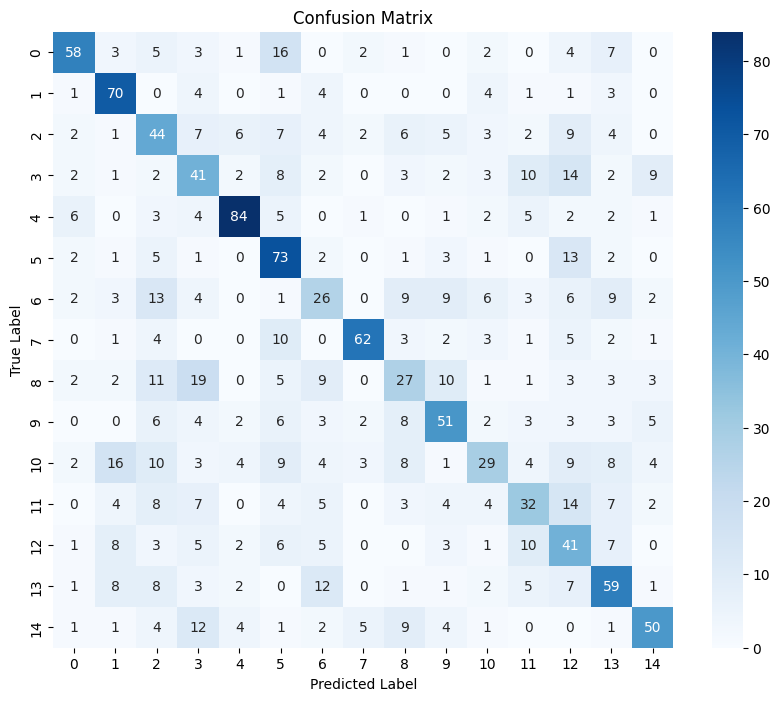

In [44]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

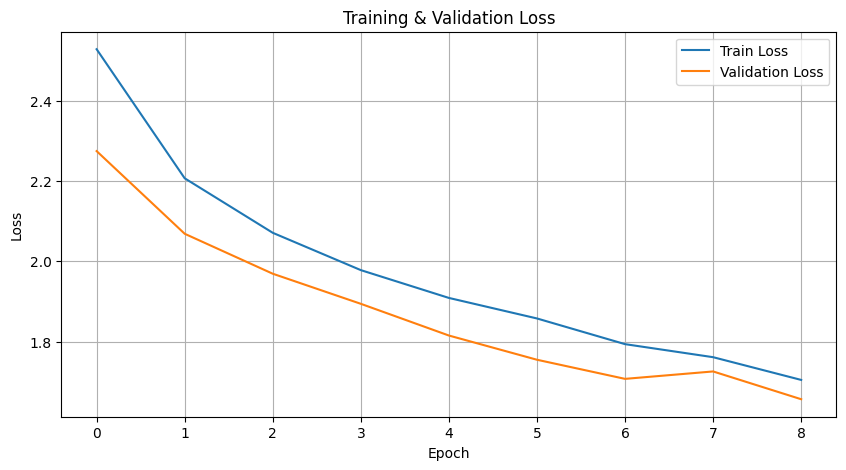

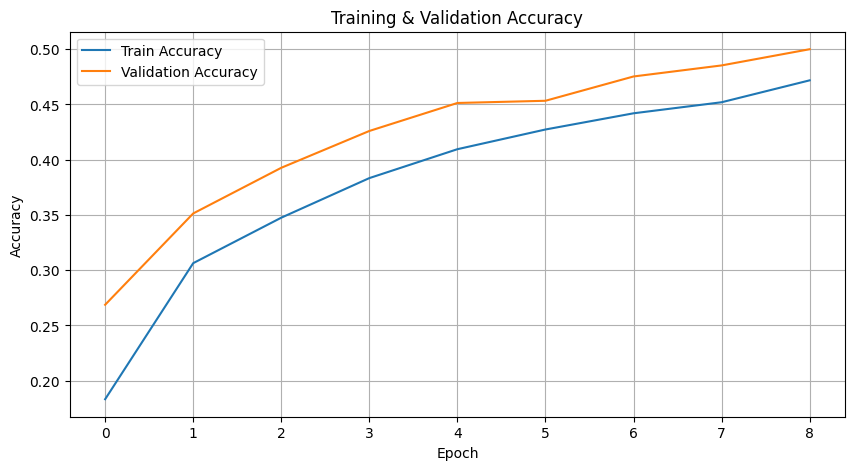

In [45]:
# Krzywa strat
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Krzywa dokładności
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
